# Assessing metadata found in the Pangaea repository for datasets

**Aim.** The aim of this experiment is to evaluate if the RDF metadata published by [Pangaea](https://www.pangaea.de/) is following the FAIR principles guideline.

**Material and methods.** In this experiment, we launch a set of FAIR tests which are mostly based on SPARQL requests.

**Results.** We produce an UpSetPlot summarizing the number of resource validating each test, allowing to show some validation combination profiles.

In [1]:
import sys
parentdir = "../.."
sys.path.insert(0, parentdir)

import requests
from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from metrics.FAIRMetricsFactory import FAIRMetricsFactory
from metrics.AbstractFAIRMetrics import AbstractFAIRMetrics

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 101.0.4951
[WDM] - Get LATEST driver version for 101.0.4951
[WDM] - Driver [/home/trosnet/.wdm/drivers/chromedriver/linux64/101.0.4951.41/chromedriver] found in cache


In [2]:
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

schema = Namespace("http://schema.org/")

## 1. Retrieve a list of DOIs from the Pangaea repository API

In [3]:
TIMEOUT = (10, 300)
NB = '10000'
# NB = '10'
OUTPUT_DIR = "../results/pangaea_data/"

def pangaeaRestRequest():
    print("REST request to pangaea...")
    # rest request
    url = 'https://ws.pangaea.de/es/pangaea/panmd/_search?pretty&size=' + NB
    while True:
        try:
            response = requests.get(url, timeout=TIMEOUT)
            break
        except SSLError:
            time.sleep(5)
        except requests.exceptions.Timeout:
            time.sleep(5)

    return response

def pangaeaJsonParser(response):
    print("Parsing result...")
    json_response = response.json()

    dois_list = []
    for element in json_response["hits"]["hits"]:
        if "URI" in element["_source"].keys():
            doi = element["_source"]["URI"]
            dois_list.append(doi)
            
    print("Retrieved " + str(len(dois_list)) + " DOIs")
    return dois_list

In [4]:
response = pangaeaRestRequest()
dois_list = pangaeaJsonParser(response)

REST request to pangaea...
Parsing result...
Retrieved 10000 DOIs


## 2. Selecting a subset of the DOIs to create a sample

In [5]:
import random

random.seed(42)

samples_dois_list = random.sample(dois_list, 500)

splitedSize = 100
samples_chunks = [samples_dois_list[x:x+splitedSize] for x in range(0, len(samples_dois_list), splitedSize)]

In [6]:
print(len(samples_dois_list))

500


In [8]:
# open file in write mode
# with open("../results/pangaea_data/url_list", 'w+') as fp:
#     for item in samples_dois_list:
#         # write each item on a new line
#         fp.write("%s\n" % item)
#     print('Done')

#open and read the file
with open("../results/pangaea_data/url_list") as f:
    lines = [line.strip() for line in f]
    samples_dois_list = lines

Done


## 3. Initiating the list of metrics to be tested

In [9]:
metrics_collection = []
metrics_collection.append(FAIRMetricsFactory.get_A11(None))
metrics_collection.append(FAIRMetricsFactory.get_F1A(None))
metrics_collection.append(FAIRMetricsFactory.get_F1B(None))
metrics_collection.append(FAIRMetricsFactory.get_F2A(None))
metrics_collection.append(FAIRMetricsFactory.get_F2B(None))
metrics_collection.append(FAIRMetricsFactory.get_I1(None))
metrics_collection.append(FAIRMetricsFactory.get_I2(None))
metrics_collection.append(FAIRMetricsFactory.get_I3(None))
metrics_collection.append(FAIRMetricsFactory.get_R11(None))
metrics_collection.append(FAIRMetricsFactory.get_R12(None))
metrics_collection.append(FAIRMetricsFactory.get_R13(None))

df_columns = ['ID']
for m in metrics_collection:
    #print(m.get_principle_tag())
    df_columns.append(m.get_principle_tag())

In [10]:
exec_time_df = pd.DataFrame(columns=df_columns)

def eval_metrics(web_res):
    metrics_collection = []
    metrics_collection.append(FAIRMetricsFactory.get_A11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I1(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I2(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I3(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R12(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R13(web_res))
    
    row = {"ID":web_res.get_url()}
    row_time = {"ID":web_res.get_url()}
    for m in metrics_collection:
        ts1 = time.time()
        e = m.evaluate()
        duration = round((time.time() - ts1), 2)
        if e is not None:
            row[m.get_principle_tag()] = e.get_score()
            row_time[m.get_principle_tag()] = duration
    
    return row, row_time

## 4. Launching the list of FAIR tests for each DOI

In [11]:
def mass_eval(samples):
    evals = []
    exec_time = []

    for sample in tqdm(samples):
        wr = WebResource(url=sample)
        row, row_time = eval_metrics(wr)
        evals.append(row)
        exec_time.append(row_time)
    
    return evals, exec_time

In [12]:
import logging
logging.getLogger().setLevel(logging.ERROR)

i = 0
for c in tqdm(samples_chunks):
    i += 1
    df = pd.DataFrame()
    df_time = pd.DataFrame()
    
    evals, exec_time = mass_eval(c)
    df = pd.concat([df, pd.DataFrame.from_records(evals)])
    df_time = pd.concat([df_time, pd.DataFrame.from_records(exec_time)])
    
    df.to_csv(OUTPUT_DIR + "FC_results_PANGAEA_"+str(i)+".csv")
    df_time.to_csv(OUTPUT_DIR + "exec_time_PANGAEA_"+str(i)+".csv")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.pangaea.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.742511', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.742511', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.742511', 'creator': [{'@id': 'https://orcid.org/0000-0003-0240-7317', '@type': 'Person', 'name': 'Claus-Dieter Hillenbrand', 'familyName': 'Hillenbrand', 'givenName': 'Claus-Dieter', 'identifier': 'https://orcid.org/0000-0003-0240-7317', 'email': 'hilc@bas.ac.uk'}, {'@id': 'https://orcid.org/0000-0002-8414-7389', '@type': 'Person', 'name': 'Robert D Larter', 'familyName': 'Larter', 'givenName': 'Robert D', 'identifier': 'https://orcid.org/0000-0002-8414-7389', 'url': 'http://www.antarctica.ac.uk/staff-profiles/template.php?user=rdla', 'email': 'rdla@bas.ac.uk'}, {'@id': 'https://orcid.org/0000-0003-1369-9482', '@type': 'Person', 'name': 'Julian A Dowdeswell', 'familyName': 'Dowdeswell', 'givenName': 'Julian A', 'identifier': 'https://orcid.org/0000-0003-1369-9482', 'e

INFO:ff4e4d42-bbf9-43d7-a206-6bd5828169d9:Checking if the URL uses HTTP protocol
INFO:ff4e4d42-bbf9-43d7-a206-6bd5828169d9:The resource use HTTP protocol
INFO:bcb1a222-7c05-421a-bf2e-4cbe62de381a:Checking if the URL is reachable, status code: 200
INFO:bcb1a222-7c05-421a-bf2e-4cbe62de381a:Status code is OK, meaning the url is Unique.
INFO:f39dae02-7853-43eb-83ac-de38d8588450:Strong evaluation:
INFO:f39dae02-7853-43eb-83ac-de38d8588450:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f39dae02-7853-43eb-83ac-de38d8588450:Found at least one of those property in metadata
INFO:4b6fe9da-7df1-4fad-85e5-39c16c55efe8:Checking if data is structured, looking for at least one RDF triple...
INFO:4b6fe9da-7df1-4fad-85e5-39c16c55efe8:749 RDF triples were found, thus data is in a well structured graph format
INFO:280f0e52-eb5f-4013-b055-b6fa74228c1a:Strong evaluation:
INFO:280f0e52-eb5f-4013-b055-b6fa74228c1a:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.931339', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.931339', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.931339', 'creator': [{'@type': 'Person', 'name': 'Andrea Y Frommel', 'familyName': 'Frommel', 'givenName': 'Andrea Y', 'email': 'afrommel@geomar.de'}, {'@type': 'Person', 'name': 'Justin Carless', 'familyName': 'Carless', 'givenName': 'Justin'}, {'@type': 'Person', 'name': 'Brian P V Hunt', 'familyName': 'Hunt', 'givenName': 'Brian P V'}, {'@type': 'Person', 'name': 'Colin J Brauner', 'familyName': 'Brauner', 'givenName': 'Colin J'}], 'name': 'Seawater carbonate chemistry and condition factor,haematocrit and plasma [Cl-],acute upper thermal tolerance and hypoxia tolerance of pink salmon', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'include

INFO:47b88052-5e57-4a14-84ac-d84d73894dd1:Checking if the URL uses HTTP protocol
INFO:47b88052-5e57-4a14-84ac-d84d73894dd1:The resource use HTTP protocol
INFO:71f89f5a-f65a-4fe9-acad-3c5d6b332965:Checking if the URL is reachable, status code: 200
INFO:71f89f5a-f65a-4fe9-acad-3c5d6b332965:Status code is OK, meaning the url is Unique.
INFO:5cbabdda-de38-42ff-b3f7-64636f64b72b:Strong evaluation:
INFO:5cbabdda-de38-42ff-b3f7-64636f64b72b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5cbabdda-de38-42ff-b3f7-64636f64b72b:Found at least one of those property in metadata
INFO:0f92e735-c767-40f1-98fc-1e4103b1dbd2:Checking if data is structured, looking for at least one RDF triple...
INFO:0f92e735-c767-40f1-98fc-1e4103b1dbd2:1430 RDF triples were found, thus data is in a well structured graph format
INFO:1669f4d4-ef4a-4d94-8522-24565e431e1a:Strong evaluation:
INFO:1669f4d4-ef4a-4d94-8522-24565e431e1a:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.849226', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.849226', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.849226', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Upper air soundings during POLARSTERN cruise ANT-XXII/4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePu

INFO:e42f3930-f880-4df0-850d-b7d9a74825c0:Checking if the URL uses HTTP protocol
INFO:e42f3930-f880-4df0-850d-b7d9a74825c0:The resource use HTTP protocol
INFO:763e9c99-3830-448d-b917-67b2f96fd738:Checking if the URL is reachable, status code: 200
INFO:763e9c99-3830-448d-b917-67b2f96fd738:Status code is OK, meaning the url is Unique.
INFO:427ffe0f-5e1c-45f1-b06d-a204b082f109:Strong evaluation:
INFO:427ffe0f-5e1c-45f1-b06d-a204b082f109:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:427ffe0f-5e1c-45f1-b06d-a204b082f109:Found at least one of those property in metadata
INFO:98c922d3-6f33-41e6-af75-f8fa3389b17a:Checking if data is structured, looking for at least one RDF triple...
INFO:98c922d3-6f33-41e6-af75-f8fa3389b17a:122 RDF triples were found, thus data is in a well structured graph format
INFO:a006826e-058d-4d50-bba2-5f777041c7a3:Strong evaluation:
INFO:a006826e-058d-4d50-bba2-5f777041c7a3:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.788201', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.788201', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.788201', 'creator': [{'@id': 'https://orcid.org/0000-0002-7245-8614', '@type': 'Person', 'name': 'Bridget S Wade', 'familyName': 'Wade', 'givenName': 'Bridget S', 'identifier': 'https://orcid.org/0000-0002-7245-8614'}, {'@id': 'https://orcid.org/0000-0001-5288-1733', '@type': 'Person', 'name': 'Richard D Norris', 'familyName': 'Norris', 'givenName': 'Richard D', 'identifier': 'https://orcid.org/0000-0001-5288-1733', 'email': 'rnorris@whoi.edu'}, {'@type': 'Person', 'name': 'Dick Kroon', 'familyName': 'Kroon', 'givenName': 'Dick', 'email': 'dick.kroon@ed.ac.uk'}], 'name': 'Stable isotope ratios of foraminifera from ODP Hole 171B-1051B sediments', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environme

INFO:9dfc3bbe-c217-4d58-9389-4558b19d8f71:Weak evaluation:
INFO:9dfc3bbe-c217-4d58-9389-4558b19d8f71:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9dfc3bbe-c217-4d58-9389-4558b19d8f71:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a9286e60-4dc1-41fc-8233-45347a54a83f:Checking if data is structured, looking for at least one RDF triple...
INFO:a9286e60-4dc1-41fc-8233-45347a54a83f:125 RDF triples were found, thus data is in a well structured graph format
INFO:548e44fc-90bf-468c-a1b6-298c28130f19:Strong evaluation:
INFO:548e44fc-90bf-468c-a1b6-298c28130f19:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:548e44fc-90bf-468c-a1b6-298c28130f19:All classes found in those ontology registries
INFO:548e44fc-90bf-468c-a1b6-298c28130f19:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:548e44fc-90bf-468c-a1b6-298c28130f19:Weak evaluation:
INFO:548e44fc-90bf-468c-a1b6-298c28130

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.754079', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.754079', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.754079', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS76/31408 during POLARSTERN cruise ARK-XXV/2 on 2010-07-12 04:53h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:24bf0b90-7178-47e4-88bf-7fb89b5aa7d9:Strong evaluation:
INFO:24bf0b90-7178-47e4-88bf-7fb89b5aa7d9:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:24bf0b90-7178-47e4-88bf-7fb89b5aa7d9:All classes found in those ontology registries
INFO:24bf0b90-7178-47e4-88bf-7fb89b5aa7d9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:24bf0b90-7178-47e4-88bf-7fb89b5aa7d9:Weak evaluation:
INFO:24bf0b90-7178-47e4-88bf-7fb89b5aa7d9:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:24bf0b90-7178-47e4-88bf-7fb89b5aa7d9:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:3c065992-7def-47ac-9574-3790e13eabe6:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:3c065992-7def-47ac-9574-3790e13eabe6:At least 3 different domains were found in metadata (13)
INFO:c362f411-e3ac-425a-bf90-e90488e3a5a2:Checking that at least one of the following licence prope

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.407950', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.407950', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.407950', 'creator': {'@type': 'Person', 'name': 'Marko Herrmann', 'familyName': 'Herrmann', 'givenName': 'Marko', 'email': 'marko.herrmann@ufra.edu.br'}, 'name': 'Assemblage of soft bottom community at 10m depth of Kongsfjorden, Arctic', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-04-06', 'description': 'This dataset is about: Assemblage of soft bottom community at 10m depth of Kongsfjorden, Arctic.', 'citation': {'@id': 'https://doi.or

INFO:8d2e5cba-ea9a-4794-841d-f117604ce8aa:Weak evaluation:
INFO:8d2e5cba-ea9a-4794-841d-f117604ce8aa:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8d2e5cba-ea9a-4794-841d-f117604ce8aa:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:05c2b7a6-b43e-4087-b748-25e8915f38e2:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:05c2b7a6-b43e-4087-b748-25e8915f38e2:At least 3 different domains were found in metadata (10)
INFO:6e8a0638-9b35-4d54-824e-cff69f751e1c:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:6e8a0638-9b35-4d54-824e-cff69f751e1c:At least one of the licence property was found in metadata !
INFO:d2408eb2-1285-4036-9e05-37df16e91b30:Checking that at l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.54990', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.54990', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.54990', 'creator': [{'@type': 'Person', 'name': 'Hans G Dietrich', 'familyName': 'Dietrich', 'givenName': 'Hans G'}, {'@type': 'Person', 'name': 'D Klosa', 'familyName': 'Klosa', 'givenName': 'D'}], 'name': 'Carbonate content of sediment core CRP-1 (Table 1)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1998-01-15', '@reverse': {'isBasedOn': {'@id': 'hdl:10013/epic.28336.d001', '@type': ['CreativeWork', 'PublicationIssue'], 'identifier': 'hdl:

INFO:517d7cde-cb73-48f1-8a90-dcd23c0f7663:Checking if data is structured, looking for at least one RDF triple...
INFO:517d7cde-cb73-48f1-8a90-dcd23c0f7663:209 RDF triples were found, thus data is in a well structured graph format
INFO:cc15661f-82e7-4e16-920c-69d1e18bdad3:Strong evaluation:
INFO:cc15661f-82e7-4e16-920c-69d1e18bdad3:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:cc15661f-82e7-4e16-920c-69d1e18bdad3:All classes found in those ontology registries
INFO:cc15661f-82e7-4e16-920c-69d1e18bdad3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:cc15661f-82e7-4e16-920c-69d1e18bdad3:Weak evaluation:
INFO:cc15661f-82e7-4e16-920c-69d1e18bdad3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:cc15661f-82e7-4e16-920c-69d1e18bdad3:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:3699a1b4-2448-4767-a727-7fab253f2e4b:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.781268', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.781268', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.781268', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6629B/09A, Romania, Moardas (Mardisch)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-05-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und B

INFO:0943c94b-1df2-4ca2-bb34-c9c1427d5c6f:All classes found in those ontology registries
INFO:0943c94b-1df2-4ca2-bb34-c9c1427d5c6f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0943c94b-1df2-4ca2-bb34-c9c1427d5c6f:Weak evaluation:
INFO:0943c94b-1df2-4ca2-bb34-c9c1427d5c6f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0943c94b-1df2-4ca2-bb34-c9c1427d5c6f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b7dd2343-bced-4ab6-b860-b90e99ea722e:Checking if data is structured, looking for at least one RDF triple...
INFO:b7dd2343-bced-4ab6-b860-b90e99ea722e:170 RDF triples were found, thus data is in a well structured graph format
INFO:5819502a-96a2-4079-a653-5ae6e67e9e0d:Strong evaluation:
INFO:5819502a-96a2-4079-a653-5ae6e67e9e0d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5819502a-96a2-4079-a653-5ae6e67e9e0d:All classes found in those ontology registries
INFO:581

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.498248', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.498248', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.498248', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Physical oceanography from BT during cruise U74X008629B_1955', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'

INFO:8f0a21da-937c-4ab0-a086-a1de182bb331:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8f0a21da-937c-4ab0-a086-a1de182bb331:Weak evaluation:
INFO:8f0a21da-937c-4ab0-a086-a1de182bb331:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8f0a21da-937c-4ab0-a086-a1de182bb331:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a49ae1e9-b57b-411e-b0d6-9fd59cb1df04:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a49ae1e9-b57b-411e-b0d6-9fd59cb1df04:At least 3 different domains were found in metadata (11)
INFO:18f38a96-50d7-4405-93ba-c71731885836:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:18f38a96-50d7-4405-93ba-c71731885836:At l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.748760', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.748760', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.748760', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:8ae8228c-205b-407a-ab27-80fb4091e44b:Checking if the URL uses HTTP protocol
INFO:8ae8228c-205b-407a-ab27-80fb4091e44b:The resource use HTTP protocol
INFO:acf7f50b-77a6-4222-907d-660c7863be07:Checking if the URL is reachable, status code: 200
INFO:acf7f50b-77a6-4222-907d-660c7863be07:Status code is OK, meaning the url is Unique.
INFO:02738e04-1a9d-4658-8aef-dec24de18a5e:Strong evaluation:
INFO:02738e04-1a9d-4658-8aef-dec24de18a5e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:02738e04-1a9d-4658-8aef-dec24de18a5e:Found at least one of those property in metadata
INFO:195d5fc3-4874-4d3f-b107-6acc4faf55d5:Checking if data is structured, looking for at least one RDF triple...
INFO:195d5fc3-4874-4d3f-b107-6acc4faf55d5:508 RDF triples were found, thus data is in a well structured graph format
INFO:79897679-1b88-43d6-9312-4e552659a1b3:Strong evaluation:
INFO:79897679-1b88-43d6-9312-4e552659a1b3:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.118308', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.118308', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.118308', 'creator': {'@type': 'Person', 'name': 'Charles Trees', 'familyName': 'Trees', 'givenName': 'Charles', 'email': 'ctrees@chors.sdsu.edu'}, 'name': 'Particulate absorption data at station TT053_10-14', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-15', 'description': 'This dataset is about: Particulate absorption data at station TT053_10-14.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'Charles

INFO:f21bf793-efb9-41d6-bdeb-5cdb98888b9e:Checking if the URL uses HTTP protocol
INFO:f21bf793-efb9-41d6-bdeb-5cdb98888b9e:The resource use HTTP protocol
INFO:9631439d-7e6e-43f3-8e90-82d92b03634c:Checking if the URL is reachable, status code: 200
INFO:9631439d-7e6e-43f3-8e90-82d92b03634c:Status code is OK, meaning the url is Unique.
INFO:4fd1383c-c4c6-4f06-ab45-05ea163a9022:Strong evaluation:
INFO:4fd1383c-c4c6-4f06-ab45-05ea163a9022:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4fd1383c-c4c6-4f06-ab45-05ea163a9022:Found at least one of those property in metadata
INFO:a7c98296-3f90-4937-8779-fd5fa5247e7f:Checking if data is structured, looking for at least one RDF triple...
INFO:a7c98296-3f90-4937-8779-fd5fa5247e7f:3324 RDF triples were found, thus data is in a well structured graph format
INFO:d16f5986-64c0-477c-8657-caa1581e3f6a:Strong evaluation:
INFO:d16f5986-64c0-477c-8657-caa1581e3f6a:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.837989', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.837989', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.837989', 'creator': {'@type': 'Organization', 'name': 'Expedition 347 Scientists', 'url': 'https://www.pangaea.de/ddi?request=iodp-msp/BSBP_staff&title=Expedition+347+Scientists&format=html'}, 'name': 'Light reflectance (RGB) of IODP Hole 347-M0064A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2014-11-06', 'description': 'This dataset is about: Light reflectance (RGB) of IODP Hole 347-M0064A.', 'citation': [{'@id': 'https://doi.org/10.2204/

INFO:451f65ea-9da9-447b-8fb2-e6c810c34392:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:451f65ea-9da9-447b-8fb2-e6c810c34392:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:785ee0b0-6ef4-4475-9ad9-f3cd33cfdcc7:Checking if data is structured, looking for at least one RDF triple...
INFO:785ee0b0-6ef4-4475-9ad9-f3cd33cfdcc7:295 RDF triples were found, thus data is in a well structured graph format
INFO:02d1843f-8d7d-4a45-89f1-0d6e50c5d80f:Strong evaluation:
INFO:02d1843f-8d7d-4a45-89f1-0d6e50c5d80f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:02d1843f-8d7d-4a45-89f1-0d6e50c5d80f:All classes found in those ontology registries
INFO:02d1843f-8d7d-4a45-89f1-0d6e50c5d80f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:02d1843f-8d7d-4a45-89f1-0d6e50c5d80f:Weak evaluation:
INFO:02d1843f-8d7d-4a45-89f1-0d6e50c5d80f:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.588912', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.588912', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.588912', 'creator': [{'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, {'@type': 'Person', 'name': 'Moritz Eimiger', 'familyName': 'Eimiger', 'givenName': 'Moritz'}], 'name': 'Tree-ring measurements of Abies alba (Silver fir) from sample ASPRO-71', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-24', 'sourceOrganization': {'@id': 'http

INFO:b351ddd6-d31b-4a1f-b731-3a0e8debbf39:Weak evaluation:
INFO:b351ddd6-d31b-4a1f-b731-3a0e8debbf39:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b351ddd6-d31b-4a1f-b731-3a0e8debbf39:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:7e0ea626-65bc-4cf1-ad72-949cbbebbaa5:Checking if data is structured, looking for at least one RDF triple...
INFO:7e0ea626-65bc-4cf1-ad72-949cbbebbaa5:272 RDF triples were found, thus data is in a well structured graph format
INFO:ab793a19-838e-4382-b2a0-0792c17cb6cc:Strong evaluation:
INFO:ab793a19-838e-4382-b2a0-0792c17cb6cc:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ab793a19-838e-4382-b2a0-0792c17cb6cc:All classes found in those ontology registries
INFO:ab793a19-838e-4382-b2a0-0792c17cb6cc:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ab793a19-838e-4382-b2a0-0792c17cb6cc:Weak evaluation:
INFO:ab793a19-838e-4382-b2a0-0792c17cb6

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.902390', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.902390', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.902390', 'creator': [{'@id': 'https://orcid.org/0000-0002-4834-7965', '@type': 'Person', 'name': 'Paul Wintersteller', 'familyName': 'Wintersteller', 'givenName': 'Paul', 'identifier': 'https://orcid.org/0000-0002-4834-7965', 'email': 'pwintersteller@marum.de'}, {'@id': 'https://orcid.org/0000-0003-3228-7862', '@type': 'Person', 'name': 'Christian dos Santos Ferreira', 'familyName': 'dos Santos Ferreira', 'givenName': 'Christian', 'identifier': 'https://orcid.org/0000-0003-3228-7862', 'email': 'cferreira@marum.de'}], 'name': 'Gridded bathymetry from EM120 multibeam echosounder of RV METEOR cruise M70/3 (Svalbard continental margin)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science

INFO:501f0174-9651-4ebe-84d6-46b8ec587791:All classes found in those ontology registries
INFO:501f0174-9651-4ebe-84d6-46b8ec587791:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:501f0174-9651-4ebe-84d6-46b8ec587791:Weak evaluation:
INFO:501f0174-9651-4ebe-84d6-46b8ec587791:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:501f0174-9651-4ebe-84d6-46b8ec587791:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:f82998cc-e93e-47a5-9f88-94dac65f1c2d:Checking if data is structured, looking for at least one RDF triple...
INFO:f82998cc-e93e-47a5-9f88-94dac65f1c2d:188 RDF triples were found, thus data is in a well structured graph format
INFO:33ca592b-2523-4cf4-a176-95f7e9561312:Strong evaluation:
INFO:33ca592b-2523-4cf4-a176-95f7e9561312:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:33ca592b-2523-4cf4-a176-95f7e9561312:All classes found in those ontology registries
INFO:33ca592b

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.354410', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.354410', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.354410', 'creator': {'@id': 'https://orcid.org/0000-0003-2175-8980', '@type': 'Person', 'name': 'Michael E Weber', 'familyName': 'Weber', 'givenName': 'Michael E', 'identifier': 'https://orcid.org/0000-0003-2175-8980', 'url': 'https://www.steinmann.uni-bonn.de/arbeitsgruppen/strukturgeologie/mitarbeiter/michael-e.-weber', 'email': 'mike.weber@uni-bonn.de'}, 'name': 'Bulk sediment properties of core SO106-260KG', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'da

INFO:b3955c22-fac1-46a1-9a25-399fcdb9ba31:Checking if the URL uses HTTP protocol
INFO:b3955c22-fac1-46a1-9a25-399fcdb9ba31:The resource use HTTP protocol
INFO:0f0fad7f-fa00-48b2-814b-4a05d4e412c8:Checking if the URL is reachable, status code: 200
INFO:0f0fad7f-fa00-48b2-814b-4a05d4e412c8:Status code is OK, meaning the url is Unique.
INFO:e7ba833f-87de-4fe7-be8a-52992bfb8db4:Strong evaluation:
INFO:e7ba833f-87de-4fe7-be8a-52992bfb8db4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e7ba833f-87de-4fe7-be8a-52992bfb8db4:Found at least one of those property in metadata
INFO:a8a257b2-fe52-4a77-bc50-eb92da662795:Checking if data is structured, looking for at least one RDF triple...
INFO:a8a257b2-fe52-4a77-bc50-eb92da662795:232 RDF triples were found, thus data is in a well structured graph format
INFO:e43ac3f4-e177-4a33-a4ba-2ff2fd70e289:Strong evaluation:
INFO:e43ac3f4-e177-4a33-a4ba-2ff2fd70e289:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.484367', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.484367', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.484367', 'creator': {'@type': 'Person', 'name': 'James Swift', 'familyName': 'Swift', 'givenName': 'James', 'email': 'jswift@ucsd.edu'}, 'name': 'Hydrochemistry measured on water bottle samples at station SAtl_1983_6N_7S_9N/131-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-07-13', 'sourceOrganization': {'@type': 'Organization', 'name': 'Scripps Institution of Oceanography, UC San Diego'}, 'description': 'This data sets is part of a co

INFO:c994212a-d670-4193-a1da-d38a63e363d4:All classes found in those ontology registries
INFO:c994212a-d670-4193-a1da-d38a63e363d4:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c994212a-d670-4193-a1da-d38a63e363d4:Weak evaluation:
INFO:c994212a-d670-4193-a1da-d38a63e363d4:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c994212a-d670-4193-a1da-d38a63e363d4:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:4d4678a3-1ed3-4baf-b7b8-c5a3083b1d9b:Checking if data is structured, looking for at least one RDF triple...
INFO:4d4678a3-1ed3-4baf-b7b8-c5a3083b1d9b:313 RDF triples were found, thus data is in a well structured graph format
INFO:71bef5ed-850c-4ece-ad53-37fec72878c4:Strong evaluation:
INFO:71bef5ed-850c-4ece-ad53-37fec72878c4:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:71bef5ed-850c-4ece-ad53-37fec72878c4:All classes found in those ontology registries
INFO:71be

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.934961', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.934961', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.934961', 'creator': [{'@type': 'Person', 'name': 'Daniela Pieck', 'familyName': 'Pieck', 'givenName': 'Daniela', 'email': 'daniela.pieck@uni-oldenburg.de'}, {'@id': 'https://orcid.org/0000-0002-7600-5313', '@type': 'Person', 'name': 'Claudia Thölen', 'familyName': 'Thölen', 'givenName': 'Claudia', 'identifier': 'https://orcid.org/0000-0002-7600-5313', 'email': 'claudia.thoelen@uni-oldenburg.de'}, {'@id': 'https://orcid.org/0000-0001-7449-1613', '@type': 'Person', 'name': 'Helmut Hillebrand', 'familyName': 'Hillebrand', 'givenName': 'Helmut', 'identifier': 'https://orcid.org/0000-0001-7449-1613', 'email': 'helmut.hillebrand@uni-oldenburg.de'}, {'@type': 'Person', 'name': 'Michael Kleyer', 'familyName': 'Kleyer', 'givenName': 'Michael', 'email': 'michael.kleyer@uni-olde

INFO:73998fbf-5251-41c7-b30f-ffaa4064fa17:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:73998fbf-5251-41c7-b30f-ffaa4064fa17:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9b9976ab-d66e-43c3-9596-1411d4c5ab09:Checking if data is structured, looking for at least one RDF triple...
INFO:9b9976ab-d66e-43c3-9596-1411d4c5ab09:391 RDF triples were found, thus data is in a well structured graph format
INFO:974ef981-af0b-47b2-a01e-d30e2f128765:Strong evaluation:
INFO:974ef981-af0b-47b2-a01e-d30e2f128765:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:974ef981-af0b-47b2-a01e-d30e2f128765:All classes found in those ontology registries
INFO:974ef981-af0b-47b2-a01e-d30e2f128765:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:974ef981-af0b-47b2-a01e-d30e2f128765:Weak evaluation:
INFO:974ef981-af0b-47b2-a01e-d30e2f128765:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.899073', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.899073', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.899073', 'creator': {'@id': 'https://orcid.org/0000-0002-3099-2771', '@type': 'Person', 'name': 'Romina A S Gehrmann', 'familyName': 'Gehrmann', 'givenName': 'Romina A S', 'identifier': 'https://orcid.org/0000-0002-3099-2771', 'email': 'r.a.gehrmann@soton.ac.uk'}, 'name': 'Controlled-source electromagnetic data from the TAG hydrothermal field, 26N Mid-Atlantic Ridge', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2019-03-06', '@reverse': {'isB

INFO:e1da18ee-75bd-425e-b142-5ded1e16b19a:Checking if data is structured, looking for at least one RDF triple...
INFO:e1da18ee-75bd-425e-b142-5ded1e16b19a:205 RDF triples were found, thus data is in a well structured graph format
INFO:f02699e2-c7f4-4585-aeda-0ce3d7960a52:Strong evaluation:
INFO:f02699e2-c7f4-4585-aeda-0ce3d7960a52:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f02699e2-c7f4-4585-aeda-0ce3d7960a52:All classes found in those ontology registries
INFO:f02699e2-c7f4-4585-aeda-0ce3d7960a52:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f02699e2-c7f4-4585-aeda-0ce3d7960a52:Weak evaluation:
INFO:f02699e2-c7f4-4585-aeda-0ce3d7960a52:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f02699e2-c7f4-4585-aeda-0ce3d7960a52:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:8eab08f3-a9e7-41f6-8d89-dbd7cb8db0a5:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.741136', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.741136', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.741136', 'creator': {'@id': 'https://orcid.org/0000-0002-8745-9636', '@type': 'Person', 'name': 'Andrei A Andreev', 'familyName': 'Andreev', 'givenName': 'Andrei A', 'identifier': 'https://orcid.org/0000-0002-8745-9636', 'url': 'http://www.geologie.uni-koeln.de/andreev.html', 'email': 'andrej.andreev@awi.de'}, 'name': 'Lithology of sediment core BAIDARA, Baidara, Russia', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-06-14', 'sourceOrgani

INFO:38fdc04c-21b7-40e6-9340-e923770ccec1:Weak evaluation:
INFO:38fdc04c-21b7-40e6-9340-e923770ccec1:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:38fdc04c-21b7-40e6-9340-e923770ccec1:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:39ab07a2-d37b-4afb-99cd-72e0f60ce98e:Checking if data is structured, looking for at least one RDF triple...
INFO:39ab07a2-d37b-4afb-99cd-72e0f60ce98e:236 RDF triples were found, thus data is in a well structured graph format
INFO:593ecfdc-3f52-4059-a1f4-e2c9fe77c757:Strong evaluation:
INFO:593ecfdc-3f52-4059-a1f4-e2c9fe77c757:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:593ecfdc-3f52-4059-a1f4-e2c9fe77c757:All classes found in those ontology registries
INFO:593ecfdc-3f52-4059-a1f4-e2c9fe77c757:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:593ecfdc-3f52-4059-a1f4-e2c9fe77c757:Weak evaluation:
INFO:593ecfdc-3f52-4059-a1f4-e2c9fe77c

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.120697', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.120697', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.120697', 'creator': {'@id': 'https://orcid.org/0000-0002-8577-7964', '@type': 'Person', 'name': 'James W Murray', 'familyName': 'Murray', 'givenName': 'James W', 'identifier': 'https://orcid.org/0000-0002-8577-7964', 'url': 'https://www.researchgate.net/profile/J_Murray', 'email': 'jmurray@u.washington.edu'}, 'name': 'Oxygen and salinity measured on water bottle samples at station TT008_5-CTD14', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2

INFO:8f085744-dace-4e6a-aefe-ea61ed2929c1:Weak evaluation:
INFO:8f085744-dace-4e6a-aefe-ea61ed2929c1:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8f085744-dace-4e6a-aefe-ea61ed2929c1:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:06d17a99-2da2-4806-946f-69b8f26b4174:Checking if data is structured, looking for at least one RDF triple...
INFO:06d17a99-2da2-4806-946f-69b8f26b4174:213 RDF triples were found, thus data is in a well structured graph format
INFO:d91e14b3-4f55-4d48-8aa0-8ae6a11fd097:Strong evaluation:
INFO:d91e14b3-4f55-4d48-8aa0-8ae6a11fd097:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d91e14b3-4f55-4d48-8aa0-8ae6a11fd097:All classes found in those ontology registries
INFO:d91e14b3-4f55-4d48-8aa0-8ae6a11fd097:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d91e14b3-4f55-4d48-8aa0-8ae6a11fd097:Weak evaluation:
INFO:d91e14b3-4f55-4d48-8aa0-8ae6a11fd

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.752597', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.752597', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.752597', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:c45ab8b5-a7fe-4a4c-863a-a0cc9e65a439:Weak evaluation:
INFO:c45ab8b5-a7fe-4a4c-863a-a0cc9e65a439:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c45ab8b5-a7fe-4a4c-863a-a0cc9e65a439:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b88cb21e-2161-41de-8a9a-c115199c4445:Checking if data is structured, looking for at least one RDF triple...
INFO:b88cb21e-2161-41de-8a9a-c115199c4445:468 RDF triples were found, thus data is in a well structured graph format
INFO:8edadcf0-d17f-446e-b27c-642a00d98a21:Strong evaluation:
INFO:8edadcf0-d17f-446e-b27c-642a00d98a21:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8edadcf0-d17f-446e-b27c-642a00d98a21:All classes found in those ontology registries
INFO:8edadcf0-d17f-446e-b27c-642a00d98a21:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8edadcf0-d17f-446e-b27c-642a00d98a21:Weak evaluation:
INFO:8edadcf0-d17f-446e-b27c-642a00d98

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.788769', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.788769', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.788769', 'creator': [{'@id': 'https://orcid.org/0000-0002-4839-5633', '@type': 'Person', 'name': 'Astrid C Wittmann', 'familyName': 'Wittmann', 'givenName': 'Astrid C', 'identifier': 'https://orcid.org/0000-0002-4839-5633', 'email': 'awittmann@marum.de'}, {'@id': 'https://orcid.org/0000-0003-3090-7554', '@type': 'Person', 'name': 'Daniela Storch', 'familyName': 'Storch', 'givenName': 'Daniela', 'identifier': 'https://orcid.org/0000-0003-3090-7554', 'url': 'http://www.awi.de/en/about-us/organisation/staff/daniela-storch.html', 'email': 'Daniela.Storch@awi.de'}, {'@type': 'Person', 'name': 'Klaus Anger', 'familyName': 'Anger', 'givenName': 'Klaus'}, {'@id': 'https://orcid.org/0000-0001-6535-6575', '@type': 'Person', 'name': 'Hans-Otto Pörtner', 'familyName': 'Pörtner', 

INFO:ffc7da50-47b3-43ae-8d69-127b13267b39:Checking if the URL uses HTTP protocol
INFO:ffc7da50-47b3-43ae-8d69-127b13267b39:The resource use HTTP protocol
INFO:9bf09378-4cdc-4e1f-857f-2babed6bc5d0:Checking if the URL is reachable, status code: 200
INFO:9bf09378-4cdc-4e1f-857f-2babed6bc5d0:Status code is OK, meaning the url is Unique.
INFO:ecc92348-79df-4b27-97af-fb2d6c624dfb:Strong evaluation:
INFO:ecc92348-79df-4b27-97af-fb2d6c624dfb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ecc92348-79df-4b27-97af-fb2d6c624dfb:Found at least one of those property in metadata
INFO:10c679e5-dbcf-4cfb-ab6f-54462406745d:Checking if data is structured, looking for at least one RDF triple...
INFO:10c679e5-dbcf-4cfb-ab6f-54462406745d:566 RDF triples were found, thus data is in a well structured graph format
INFO:619a432d-77d6-47ea-b217-4a1b21b6dec4:Strong evaluation:
INFO:619a432d-77d6-47ea-b217-4a1b21b6dec4:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.912861', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.912861', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.912861', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Ultra-violet measurements from station Fort Peck (2019-11)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2020-03-03', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', '@t

INFO:3782d8b2-6f71-4276-becc-8f212fa36968:160 RDF triples were found, thus data is in a well structured graph format
INFO:e0c3d44d-3629-49bc-81fe-1223f412d585:Strong evaluation:
INFO:e0c3d44d-3629-49bc-81fe-1223f412d585:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e0c3d44d-3629-49bc-81fe-1223f412d585:All classes found in those ontology registries
INFO:e0c3d44d-3629-49bc-81fe-1223f412d585:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e0c3d44d-3629-49bc-81fe-1223f412d585:Weak evaluation:
INFO:e0c3d44d-3629-49bc-81fe-1223f412d585:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e0c3d44d-3629-49bc-81fe-1223f412d585:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:29408a63-d4e8-4866-a515-fa0f13d9330b:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:29408a63-d4e8-4866-a515-fa0f13d9330b:At least 3 different domains were foun

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.878015', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.878015', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.878015', 'creator': [{'@id': 'https://orcid.org/0000-0003-0967-8945', '@type': 'Person', 'name': 'Laura Hehemann', 'familyName': 'Hehemann', 'givenName': 'Laura', 'identifier': 'https://orcid.org/0000-0003-0967-8945', 'email': 'laura.hehemann@awi.de'}, {'@id': 'https://orcid.org/0000-0001-5427-0151', '@type': 'Person', 'name': 'Autun Purser', 'familyName': 'Purser', 'givenName': 'Autun', 'identifier': 'https://orcid.org/0000-0001-5427-0151', 'url': 'https://www.awi.de/en/about-us/organisation/staff/autun-purser.html', 'email': 'autun.purser@awi.de'}, {'@type': 'Person', 'name': 'Fabian Schramm', 'familyName': 'Schramm', 'givenName': 'Fabian', 'url': 'https://www.mpi-bremen.de/Tiefsee-Mitarbeiter/Fabian-Schramm.html', 'email': 'fschramm@mpi-bre\xadmen.de'}, {'@id': 'ht

INFO:d25e6917-9d54-4a28-8a01-b69d2966b6c2:Strong evaluation:
INFO:d25e6917-9d54-4a28-8a01-b69d2966b6c2:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d25e6917-9d54-4a28-8a01-b69d2966b6c2:All classes found in those ontology registries
INFO:d25e6917-9d54-4a28-8a01-b69d2966b6c2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d25e6917-9d54-4a28-8a01-b69d2966b6c2:Weak evaluation:
INFO:d25e6917-9d54-4a28-8a01-b69d2966b6c2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d25e6917-9d54-4a28-8a01-b69d2966b6c2:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c1ff64fb-0789-4ba5-b668-4a862977de7b:Checking if data is structured, looking for at least one RDF triple...
INFO:c1ff64fb-0789-4ba5-b668-4a862977de7b:304 RDF triples were found, thus data is in a well structured graph format
INFO:6ea2c138-240f-46d0-a039-2bdfd3330521:Strong evaluation:
INFO:6ea2c138-240f-46d0-a039-2bdfd33

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.817327', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.817327', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.817327', 'creator': [{'@type': 'Person', 'name': 'Ileana Codruta Stezar', 'familyName': 'Stezar', 'givenName': 'Ileana Codruta', 'email': 'stezar_codruta@yahoo.com'}, {'@id': 'https://orcid.org/0000-0001-9434-9104', '@type': 'Person', 'name': 'Lisa Pizzol', 'familyName': 'Pizzol', 'givenName': 'Lisa', 'identifier': 'https://orcid.org/0000-0001-9434-9104'}, {'@id': 'https://orcid.org/0000-0001-8868-9057', '@type': 'Person', 'name': 'Andrea Critto', 'familyName': 'Critto', 'givenName': 'Andrea', 'identifier': 'https://orcid.org/0000-0001-8868-9057'}, {'@type': 'Person', 'name': 'Alexandru Ozunu', 'familyName': 'Ozunu', 'givenName': 'Alexandru'}, {'@type': 'Person', 'name': 'Antonio Marcomini', 'familyName': 'Marcomini', 'givenName': 'Antonio'}], 'name': "SADA and DESYRE

INFO:309f239a-4335-4aa3-8d88-e0b5456e9d47:All classes found in those ontology registries
INFO:309f239a-4335-4aa3-8d88-e0b5456e9d47:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:309f239a-4335-4aa3-8d88-e0b5456e9d47:Weak evaluation:
INFO:309f239a-4335-4aa3-8d88-e0b5456e9d47:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:309f239a-4335-4aa3-8d88-e0b5456e9d47:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9bc3a3f8-2c8a-4207-84c7-46b82360438f:Checking if data is structured, looking for at least one RDF triple...
INFO:9bc3a3f8-2c8a-4207-84c7-46b82360438f:151 RDF triples were found, thus data is in a well structured graph format
INFO:9489ed55-4765-41db-bf8f-1f7a2c260cd7:Strong evaluation:
INFO:9489ed55-4765-41db-bf8f-1f7a2c260cd7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9489ed55-4765-41db-bf8f-1f7a2c260cd7:All classes found in those ontology registries
INFO:948

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.881967', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.881967', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.881967', 'creator': {'@type': 'Person', 'name': 'Charles Long', 'familyName': 'Long', 'givenName': 'Charles', 'email': 'gary.hodges@noaa.gov'}, 'name': 'Basic and other measurements of radiation at station Barrow (2007-04)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2017-10-18', 'sourceOrganization': {'@type': 'Organization', 'name': 'Climate Monitoring & Diagnostics Laboratory, Boulder'}, 'description': 'Version 2, 2017-10-18 with correct

INFO:2900d55b-7bf0-4520-b3a9-a33dcad830c5:Checking if the URL uses HTTP protocol
INFO:2900d55b-7bf0-4520-b3a9-a33dcad830c5:The resource use HTTP protocol
INFO:b7b6b140-d5cd-426d-a9ca-e01dfd4f251c:Checking if the URL is reachable, status code: 200
INFO:b7b6b140-d5cd-426d-a9ca-e01dfd4f251c:Status code is OK, meaning the url is Unique.
INFO:eb11a926-0527-4864-9bbd-91fefeddd5e7:Strong evaluation:
INFO:eb11a926-0527-4864-9bbd-91fefeddd5e7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:eb11a926-0527-4864-9bbd-91fefeddd5e7:Found at least one of those property in metadata
INFO:f3dba776-fc5c-4b27-9602-403c9b461e75:Checking if data is structured, looking for at least one RDF triple...
INFO:f3dba776-fc5c-4b27-9602-403c9b461e75:547 RDF triples were found, thus data is in a well structured graph format
INFO:7d5a047a-784a-4979-a7b7-b0d40cc6c9d0:Strong evaluation:
INFO:7d5a047a-784a-4979-a7b7-b0d40cc6c9d0:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.122326', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.122326', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.122326', 'creator': {'@type': 'Person', 'name': 'Patricia Wheeler', 'familyName': 'Wheeler', 'givenName': 'Patricia'}, 'name': 'Nutrients measured on water bottle samples at station TT008_5-CTD9', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-10-07', 'description': 'This dataset is about: Nutrients measured on water bottle samples at station TT008_5-CTD9.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'Pat

INFO:1f78ffd5-cebd-44cd-bcde-b7e6c3fb5562:Checking if the URL uses HTTP protocol
INFO:1f78ffd5-cebd-44cd-bcde-b7e6c3fb5562:The resource use HTTP protocol
INFO:e14cf58f-cde0-4ef1-9746-ba6f59801452:Checking if the URL is reachable, status code: 200
INFO:e14cf58f-cde0-4ef1-9746-ba6f59801452:Status code is OK, meaning the url is Unique.
INFO:122bd3d0-47a0-4d0b-9200-5e21ab4b9a9f:Strong evaluation:
INFO:122bd3d0-47a0-4d0b-9200-5e21ab4b9a9f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:122bd3d0-47a0-4d0b-9200-5e21ab4b9a9f:Found at least one of those property in metadata
INFO:1998fe1a-5fc2-4165-bfcf-1b46a2f7162f:Checking if data is structured, looking for at least one RDF triple...
INFO:1998fe1a-5fc2-4165-bfcf-1b46a2f7162f:272 RDF triples were found, thus data is in a well structured graph format
INFO:f74ffa77-59f4-4ec4-acf3-c9649ed238a6:Strong evaluation:
INFO:f74ffa77-59f4-4ec4-acf3-c9649ed238a6:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.812000', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.812000', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.812000', 'creator': [{'@id': 'https://orcid.org/0000-0003-1582-6801', '@type': 'Person', 'name': 'Stephen J Romaniello', 'familyName': 'Romaniello', 'givenName': 'Stephen J', 'identifier': 'https://orcid.org/0000-0003-1582-6801', 'email': 'sromanie@asu.edu'}, {'@type': 'Person', 'name': 'Achim D Herrmann', 'familyName': 'Herrmann', 'givenName': 'Achim D'}, {'@type': 'Person', 'name': 'Ariel D Anbar', 'familyName': 'Anbar', 'givenName': 'Ariel D'}], 'name': 'Chemistry and isotope variations in primary precipitates for the Exuma Island region of the Bahamas', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'Data

INFO:2d0d418d-e428-4e7b-8850-fd72ee821723:Checking if the URL uses HTTP protocol
INFO:2d0d418d-e428-4e7b-8850-fd72ee821723:The resource use HTTP protocol
INFO:8204b202-eb1b-4b63-8fac-e23bfc9446a5:Checking if the URL is reachable, status code: 200
INFO:8204b202-eb1b-4b63-8fac-e23bfc9446a5:Status code is OK, meaning the url is Unique.
INFO:a0e94b25-4527-4899-817b-58afc9c8083b:Strong evaluation:
INFO:a0e94b25-4527-4899-817b-58afc9c8083b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a0e94b25-4527-4899-817b-58afc9c8083b:Found at least one of those property in metadata
INFO:ddddaa83-a6b1-4699-83b5-fa9aaf48bdd9:Checking if data is structured, looking for at least one RDF triple...
INFO:ddddaa83-a6b1-4699-83b5-fa9aaf48bdd9:804 RDF triples were found, thus data is in a well structured graph format
INFO:88ad3802-ed33-470e-958c-c6fa5326d27a:Strong evaluation:
INFO:88ad3802-ed33-470e-958c-c6fa5326d27a:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.380742', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.380742', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.380742', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS32/11892 during POLARSTERN cruise ANT-XII/1 on 1994-10-26 20:14h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:e0dda915-26a9-4d3a-ac73-04911943dd04:Checking if data is structured, looking for at least one RDF triple...
INFO:e0dda915-26a9-4d3a-ac73-04911943dd04:239 RDF triples were found, thus data is in a well structured graph format
INFO:51b9a193-5b5c-46cb-8d08-616be9021c95:Strong evaluation:
INFO:51b9a193-5b5c-46cb-8d08-616be9021c95:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:51b9a193-5b5c-46cb-8d08-616be9021c95:All classes found in those ontology registries
INFO:51b9a193-5b5c-46cb-8d08-616be9021c95:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:51b9a193-5b5c-46cb-8d08-616be9021c95:Weak evaluation:
INFO:51b9a193-5b5c-46cb-8d08-616be9021c95:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:51b9a193-5b5c-46cb-8d08-616be9021c95:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c00b643a-9d19-4865-a6ff-d2077d935472:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.476967', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.476967', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.476967', 'creator': {'@type': 'Person', 'name': 'James Swift', 'familyName': 'Swift', 'givenName': 'James', 'email': 'jswift@ucsd.edu'}, 'name': 'Hydrochemistry measured on water bottle samples at station NAtl_1985_EV_63W/65', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-07-11', 'sourceOrganization': {'@type': 'Organization', 'name': 'Scripps Institution of Oceanography, UC San Diego'}, 'description': 'This data sets is part of a compila

INFO:071cc0ba-7c1f-4718-af20-dacc14367dad:Weak evaluation:
INFO:071cc0ba-7c1f-4718-af20-dacc14367dad:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:071cc0ba-7c1f-4718-af20-dacc14367dad:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:1a37a53c-4325-4c34-b7f9-1524578aa653:Checking if data is structured, looking for at least one RDF triple...
INFO:1a37a53c-4325-4c34-b7f9-1524578aa653:289 RDF triples were found, thus data is in a well structured graph format
INFO:a6c05109-e502-4cc7-85f4-2987fe52b12a:Strong evaluation:
INFO:a6c05109-e502-4cc7-85f4-2987fe52b12a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a6c05109-e502-4cc7-85f4-2987fe52b12a:All classes found in those ontology registries
INFO:a6c05109-e502-4cc7-85f4-2987fe52b12a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a6c05109-e502-4cc7-85f4-2987fe52b12a:Weak evaluation:
INFO:a6c05109-e502-4cc7-85f4-2987fe52b1

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.262675', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.262675', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.262675', 'creator': [{'@type': 'Person', 'name': 'Hiroaki Sato', 'familyName': 'Sato', 'givenName': 'Hiroaki'}, {'@type': 'Person', 'name': 'Leonid V Dmitriev', 'familyName': 'Dmitriev', 'givenName': 'Leonid V'}, {'@type': 'Person', 'name': 'James R Heirtzler', 'familyName': 'Heirtzler', 'givenName': 'James R'}], 'name': 'Major-element chemical analyses of Hole 46-396B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-03-21', 'description':

INFO:8390b19a-6d65-4a22-8a73-5e782b9be992:Checking if the URL uses HTTP protocol
INFO:8390b19a-6d65-4a22-8a73-5e782b9be992:The resource use HTTP protocol
INFO:f7bca4e7-2420-4f86-a3ab-9986c30a7318:Checking if the URL is reachable, status code: 200
INFO:f7bca4e7-2420-4f86-a3ab-9986c30a7318:Status code is OK, meaning the url is Unique.
INFO:0690e9f8-ff0e-4c72-ba68-486c0530e1e4:Strong evaluation:
INFO:0690e9f8-ff0e-4c72-ba68-486c0530e1e4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0690e9f8-ff0e-4c72-ba68-486c0530e1e4:Found at least one of those property in metadata
INFO:385146b4-6515-4995-9ef1-3f013475d99c:Checking if data is structured, looking for at least one RDF triple...
INFO:385146b4-6515-4995-9ef1-3f013475d99c:598 RDF triples were found, thus data is in a well structured graph format
INFO:a0ebef1d-9543-48f3-865a-8b85e5c4883f:Strong evaluation:
INFO:a0ebef1d-9543-48f3-865a-8b85e5c4883f:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.578886', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.578886', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.578886', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOH4982-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@id': 'https

INFO:751b7c24-d4cd-41a7-9be3-2cdfed51c058:Weak evaluation:
INFO:751b7c24-d4cd-41a7-9be3-2cdfed51c058:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:751b7c24-d4cd-41a7-9be3-2cdfed51c058:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:bf8d115a-30ff-4ccf-94c7-804e5ac7aec3:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:bf8d115a-30ff-4ccf-94c7-804e5ac7aec3:At least 3 different domains were found in metadata (11)
INFO:f84f6d5b-ffe8-4121-ba52-ffb965d710f8:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:f84f6d5b-ffe8-4121-ba52-ffb965d710f8:None of the licence property were found in metadata
INFO:a51c63f6-a78a-4836-96a2-532c691b4c59:Checking that at least one o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.571720', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.571720', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.571720', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF12300-7', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of rings

INFO:12716883-2629-4f91-be96-b75577825c42:Weak evaluation:
INFO:12716883-2629-4f91-be96-b75577825c42:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:12716883-2629-4f91-be96-b75577825c42:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:ef7593ab-3141-4b6e-805f-d261a9b78e5a:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:ef7593ab-3141-4b6e-805f-d261a9b78e5a:At least 3 different domains were found in metadata (9)
INFO:f62d0025-55c8-445d-9263-444fddc2883e:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:f62d0025-55c8-445d-9263-444fddc2883e:None of the licence property were found in metadata
INFO:f9de3ace-173b-40ab-962a-f4f6626a0162:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.695262', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.695262', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.695262', 'creator': [{'@type': 'Person', 'name': 'Joachim Plötz', 'familyName': 'Plötz', 'givenName': 'Joachim', 'url': 'http://www.awi.de/en/about-us/organisation/staff/joachim-ploetz.html', 'email': 'joachim.ploetz@awi.de'}, {'@type': 'Person', 'name': 'Marthán Nieuwoudt Bester', 'familyName': 'Bester', 'givenName': 'Marthán Nieuwoudt', 'url': 'http://www.up.ac.za/academic/zoology/2003/mnbester.html', 'email': 'mnbester@zoology.up.ac.za'}, {'@id': 'https://orcid.org/0000-0003-0243-5422', '@type': 'Person', 'name': 'Cheryl Ann Tosh', 'familyName': 'Tosh', 'givenName': 'Cheryl Ann', 'identifier': 'https://orcid.org/0000-0003-0243-5422', 'email': 'catosh@zoology.up.ac.za'}, {'@id': 'https://orcid.org/0000-0002-9114-9569', '@type': 'Person', 'name': 'P J Nico de Bruyn',

INFO:1ed3bf6f-4ee3-41cb-9938-60eda4df7fec:Weak evaluation:
INFO:1ed3bf6f-4ee3-41cb-9938-60eda4df7fec:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1ed3bf6f-4ee3-41cb-9938-60eda4df7fec:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:de56cf25-037f-4a12-9fc5-93d5d883ab64:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:de56cf25-037f-4a12-9fc5-93d5d883ab64:At least 3 different domains were found in metadata (14)
INFO:bed51f3f-08ed-4dcc-8ba4-112cfe490eb7:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:bed51f3f-08ed-4dcc-8ba4-112cfe490eb7:At least one of the licence property was found in metadata !
INFO:b6ed41d8-f7ef-4f61-b1ed-0a0ef2b90d15:Checking that at l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.807983', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.807983', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.807983', 'creator': [{'@type': 'Person', 'name': 'Francesca Borghini', 'familyName': 'Borghini', 'givenName': 'Francesca', 'email': 'borghini@unisi.it'}, {'@type': 'Person', 'name': 'Andrea Colacevich', 'familyName': 'Colacevich', 'givenName': 'Andrea', 'email': 'colacevich2@unisi.it'}, {'@id': 'https://orcid.org/0000-0002-3607-9609', '@type': 'Person', 'name': 'Tancredi Caruso', 'familyName': 'Caruso', 'givenName': 'Tancredi', 'identifier': 'https://orcid.org/0000-0002-3607-9609'}, {'@type': 'Person', 'name': 'Roberto Bargagli', 'familyName': 'Bargagli', 'givenName': 'Roberto'}], 'name': '(Table 5) Major pigment concentration in surface sediments of northern Victoria Land lakes', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': '

INFO:78312842-f37f-4f00-bf7e-456a27b2b357:Checking if the URL uses HTTP protocol
INFO:78312842-f37f-4f00-bf7e-456a27b2b357:The resource use HTTP protocol
INFO:160b7991-690f-44ee-9473-0b89357c12ec:Checking if the URL is reachable, status code: 200
INFO:160b7991-690f-44ee-9473-0b89357c12ec:Status code is OK, meaning the url is Unique.
INFO:c26a98ae-eec0-4ff1-9aa4-5624783ee16e:Strong evaluation:
INFO:c26a98ae-eec0-4ff1-9aa4-5624783ee16e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c26a98ae-eec0-4ff1-9aa4-5624783ee16e:Found at least one of those property in metadata
INFO:6a6136fc-b344-4f94-86c4-c83c42e23a92:Checking if data is structured, looking for at least one RDF triple...
INFO:6a6136fc-b344-4f94-86c4-c83c42e23a92:1049 RDF triples were found, thus data is in a well structured graph format
INFO:6c5f42db-3e90-4b03-b354-6da20e777e4b:Strong evaluation:
INFO:6c5f42db-3e90-4b03-b354-6da20e777e4b:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.499096', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.499096', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.499096', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Physical oceanography from BT during cruise U90X008287B_1981', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'

INFO:4fa6935e-b6e7-438c-85b3-93b221f96c4e:Weak evaluation:
INFO:4fa6935e-b6e7-438c-85b3-93b221f96c4e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4fa6935e-b6e7-438c-85b3-93b221f96c4e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:96fb605a-ac75-4769-bff4-837308618e3b:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:96fb605a-ac75-4769-bff4-837308618e3b:At least 3 different domains were found in metadata (11)
INFO:65267e52-5225-4fe2-b4e9-8ef3f5fa69e7:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:65267e52-5225-4fe2-b4e9-8ef3f5fa69e7:At least one of the licence property was found in metadata !
INFO:871c1076-fffe-4fb5-99f9-1cdbe0f21719:Checking that at l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.380964', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.380964', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.380964', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS34/12612 during POLARSTERN cruise ANT-XII/3 on 1995-03-08 10:31h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:4e34469d-c58a-4853-8317-37511029a288:239 RDF triples were found, thus data is in a well structured graph format
INFO:088ceefd-2b70-4f46-b1a0-12ab700edd97:Strong evaluation:
INFO:088ceefd-2b70-4f46-b1a0-12ab700edd97:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:088ceefd-2b70-4f46-b1a0-12ab700edd97:All classes found in those ontology registries
INFO:088ceefd-2b70-4f46-b1a0-12ab700edd97:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:088ceefd-2b70-4f46-b1a0-12ab700edd97:Weak evaluation:
INFO:088ceefd-2b70-4f46-b1a0-12ab700edd97:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:088ceefd-2b70-4f46-b1a0-12ab700edd97:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:e6b8549c-00bb-42d6-93b2-e150fb777c15:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:e6b8549c-00bb-42d6-93b2-e150fb777c15:At least 3 different domains were found

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.400424', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.400424', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.400424', 'creator': {'@id': 'https://orcid.org/0000-0002-8214-5937', '@type': 'Person', 'name': 'Thomas Soltwedel', 'familyName': 'Soltwedel', 'givenName': 'Thomas', 'identifier': 'https://orcid.org/0000-0002-8214-5937', 'url': 'http://www.awi.de/en/about-us/organisation/staff/thomas-soltwedel.html', 'email': 'thomas.soltwedel@awi.de'}, 'name': 'Biochemical investigation of sediment core PLG95A_07BOX', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublishe

INFO:f7c022b1-dfd0-4828-8a8a-0f929a47d107:Checking if data is structured, looking for at least one RDF triple...
INFO:f7c022b1-dfd0-4828-8a8a-0f929a47d107:211 RDF triples were found, thus data is in a well structured graph format
INFO:876b3174-6bed-4614-985d-104d22df155b:Strong evaluation:
INFO:876b3174-6bed-4614-985d-104d22df155b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:876b3174-6bed-4614-985d-104d22df155b:All classes found in those ontology registries
INFO:876b3174-6bed-4614-985d-104d22df155b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:876b3174-6bed-4614-985d-104d22df155b:Weak evaluation:
INFO:876b3174-6bed-4614-985d-104d22df155b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:876b3174-6bed-4614-985d-104d22df155b:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:234aad9b-d15a-4dbb-85aa-275fdcac9bcc:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.583240', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.583240', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.583240', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample IB21512-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}, 'des

INFO:0e294ed5-9a00-4ce5-b628-52cf945989db:Weak evaluation:
INFO:0e294ed5-9a00-4ce5-b628-52cf945989db:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0e294ed5-9a00-4ce5-b628-52cf945989db:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:62edde14-735a-449b-b7fb-1710ba2dfd1c:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:62edde14-735a-449b-b7fb-1710ba2dfd1c:At least 3 different domains were found in metadata (9)
INFO:4070906e-1953-43ee-b28c-08b43fa324ad:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:4070906e-1953-43ee-b28c-08b43fa324ad:None of the licence property were found in metadata
INFO:259055c2-fcb7-4360-ad16-749e8b7d1509:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.786435', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.786435', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.786435', 'creator': [{'@type': 'Person', 'name': 'Mikhail A Levitan', 'familyName': 'Levitan', 'givenName': 'Mikhail A', 'email': 'levitan@geokhi.ru'}, {'@type': 'Person', 'name': 'Oleg V Levchenko', 'familyName': 'Levchenko', 'givenName': 'Oleg V'}, {'@type': 'Person', 'name': 'Ivar O Murdmaa', 'familyName': 'Murdmaa', 'givenName': 'Ivar O', 'email': 'murdmaa@mail.ru'}, {'@type': 'Person', 'name': 'Valery I Peresypkin', 'familyName': 'Peresypkin', 'givenName': 'Valery I'}, {'@type': 'Person', 'name': 'I A Roshchina', 'familyName': 'Roshchina', 'givenName': 'I A'}, {'@type': 'Person', 'name': 'A V Tolmacheva', 'familyName': 'Tolmacheva', 'givenName': 'A V'}], 'name': '(Table 3a) Chemical composition of lithostratigraphic units in Core PSh63-5151', 'publisher': {'@type

INFO:12d77ce3-bf3b-46a6-8638-3b460b8f2865:Checking if the URL uses HTTP protocol
INFO:12d77ce3-bf3b-46a6-8638-3b460b8f2865:The resource use HTTP protocol
INFO:084d670f-1371-4eaa-b83d-b1201d9f4a00:Checking if the URL is reachable, status code: 200
INFO:084d670f-1371-4eaa-b83d-b1201d9f4a00:Status code is OK, meaning the url is Unique.
INFO:9290a95a-53f1-4cfc-8d83-ce89c9bb1090:Strong evaluation:
INFO:9290a95a-53f1-4cfc-8d83-ce89c9bb1090:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9290a95a-53f1-4cfc-8d83-ce89c9bb1090:Found at least one of those property in metadata
INFO:0cd59ece-3781-4a3f-9ac9-45cdc2079e12:Checking if data is structured, looking for at least one RDF triple...
INFO:0cd59ece-3781-4a3f-9ac9-45cdc2079e12:1119 RDF triples were found, thus data is in a well structured graph format
INFO:526436f4-ce63-48cc-841f-5726db4b0ccd:Strong evaluation:
INFO:526436f4-ce63-48cc-841f-5726db4b0ccd:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.806782', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.806782', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.806782', 'creator': {'@type': 'Person', 'name': 'David A Schneider', 'familyName': 'Schneider', 'givenName': 'David A'}, 'name': '(Table 3) Revised reversal boundary depths for ODP Site 138-844', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1995-02-06', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.806783', 'description': 'DEPTH, sediment is given in mbsf. The magnetic polarity time scale and nomenclature are from Cande and Kent (1992).', 'com

INFO:18550eae-5095-46cc-8afb-ed61f7b8b263:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0269fe97-be19-4fce-b6c9-abd6660bf0a8:Checking if data is structured, looking for at least one RDF triple...
INFO:0269fe97-be19-4fce-b6c9-abd6660bf0a8:246 RDF triples were found, thus data is in a well structured graph format
INFO:dc868efe-523c-42e5-8c66-9666ed8f57b9:Strong evaluation:
INFO:dc868efe-523c-42e5-8c66-9666ed8f57b9:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:dc868efe-523c-42e5-8c66-9666ed8f57b9:All classes found in those ontology registries
INFO:dc868efe-523c-42e5-8c66-9666ed8f57b9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:dc868efe-523c-42e5-8c66-9666ed8f57b9:Weak evaluation:
INFO:dc868efe-523c-42e5-8c66-9666ed8f57b9:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:dc868efe-523c-42e5-8c66-9666ed8f57b9:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.605740', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.605740', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.605740', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF10398-7', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-04-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 208; Begin 1

INFO:d31581b9-b42c-43a2-a9c0-6003958f01cb:Weak evaluation:
INFO:d31581b9-b42c-43a2-a9c0-6003958f01cb:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d31581b9-b42c-43a2-a9c0-6003958f01cb:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:ec35f4e0-a52f-4bb6-bc60-e71f83060d8d:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:ec35f4e0-a52f-4bb6-bc60-e71f83060d8d:At least 3 different domains were found in metadata (9)
INFO:5e6cf1dd-fbeb-4057-ad32-399e5596161f:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:5e6cf1dd-fbeb-4057-ad32-399e5596161f:None of the licence property were found in metadata
INFO:704fb5a4-74f3-4dd2-bc22-2c2f1e326752:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.579535', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.579535', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.579535', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample IB20216-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}, 'des

INFO:e175131d-67f7-42df-8c9f-ce7a1ef38448:Weak evaluation:
INFO:e175131d-67f7-42df-8c9f-ce7a1ef38448:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e175131d-67f7-42df-8c9f-ce7a1ef38448:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:8514eca6-5839-4f7c-87af-fbd1e8cc12fa:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:8514eca6-5839-4f7c-87af-fbd1e8cc12fa:At least 3 different domains were found in metadata (9)
INFO:da215bfe-6d3d-4e7f-8d86-21fdc1d40e34:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:da215bfe-6d3d-4e7f-8d86-21fdc1d40e34:None of the licence property were found in metadata
INFO:c4de6439-ac72-48d5-8131-ceb83b2d73d8:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.728926', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.728926', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.728926', 'creator': [{'@type': 'Person', 'name': 'Victor B Kurnosov', 'familyName': 'Kurnosov', 'givenName': 'Victor B'}, {'@type': 'Person', 'name': 'Boris P Zolotarev', 'familyName': 'Zolotarev', 'givenName': 'Boris P'}, {'@type': 'Person', 'name': 'Andrey V Artamonov', 'familyName': 'Artamonov', 'givenName': 'Andrey V'}, {'@type': 'Person', 'name': 'Sergey M Lyapunov', 'familyName': 'Lyapunov', 'givenName': 'Sergey M'}, {'@type': 'Person', 'name': 'Georgy L Kashintsev', 'familyName': 'Kashintsev', 'givenName': 'Georgy L'}, {'@type': 'Person', 'name': 'Oleg V Chudaev', 'familyName': 'Chudaev', 'givenName': 'Oleg V'}, {'@type': 'Person', 'name': 'Alla L Sokolova', 'familyName': 'Sokolova', 'givenName': 'Alla L'}, {'@type': 'Person', 'name': 'Svetlana A Garanina', 'fa

INFO:5457153b-904d-4040-bd7d-c30e5494b156:Checking if the URL uses HTTP protocol
INFO:5457153b-904d-4040-bd7d-c30e5494b156:The resource use HTTP protocol
INFO:83880a7c-7ab0-4b83-916b-a3ea8682c2c2:Checking if the URL is reachable, status code: 200
INFO:83880a7c-7ab0-4b83-916b-a3ea8682c2c2:Status code is OK, meaning the url is Unique.
INFO:e61d91e9-6d5d-40b3-9028-de4cba738aef:Strong evaluation:
INFO:e61d91e9-6d5d-40b3-9028-de4cba738aef:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e61d91e9-6d5d-40b3-9028-de4cba738aef:Found at least one of those property in metadata
INFO:9054f493-316d-4259-9caf-4870c19123d4:Checking if data is structured, looking for at least one RDF triple...
INFO:9054f493-316d-4259-9caf-4870c19123d4:1256 RDF triples were found, thus data is in a well structured graph format
INFO:83c38c88-4e3b-4bd1-a3be-c0aaee63c385:Strong evaluation:
INFO:83c38c88-4e3b-4bd1-a3be-c0aaee63c385:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.849589', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.849589', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.849589', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS93/37394 during POLARSTERN cruise PS93.1 (ARK-XXIX/2.1) on 2015-07-02 04:31h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': '

INFO:aa6676f4-6b4b-43a6-b3d5-ad12758ec827:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:aa6676f4-6b4b-43a6-b3d5-ad12758ec827:All classes found in those ontology registries
INFO:aa6676f4-6b4b-43a6-b3d5-ad12758ec827:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:aa6676f4-6b4b-43a6-b3d5-ad12758ec827:Weak evaluation:
INFO:aa6676f4-6b4b-43a6-b3d5-ad12758ec827:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:aa6676f4-6b4b-43a6-b3d5-ad12758ec827:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:6fc0da21-d0dd-4d74-80ff-8c4d97c6fa25:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:6fc0da21-d0dd-4d74-80ff-8c4d97c6fa25:At least 3 different domains were found in metadata (13)
INFO:2a32a996-c2e8-42d9-bc4a-edc771db805b:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.564382', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.564382', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.564382', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF10538-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 78; Begin 13

INFO:e1241652-8b83-4283-a54f-dd05a78d3af7:All classes found in those ontology registries
INFO:e1241652-8b83-4283-a54f-dd05a78d3af7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e1241652-8b83-4283-a54f-dd05a78d3af7:Weak evaluation:
INFO:e1241652-8b83-4283-a54f-dd05a78d3af7:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e1241652-8b83-4283-a54f-dd05a78d3af7:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:84b91f02-bcfd-4550-a301-bfd27ea7ab93:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:84b91f02-bcfd-4550-a301-bfd27ea7ab93:At least 3 different domains were found in metadata (9)
INFO:7a4fd7b9-57bc-4dd2-bdf2-7116ebe06487:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        st

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.817495', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.817495', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.817495', 'creator': [{'@type': 'Person', 'name': 'Joseph A Curiale', 'familyName': 'Curiale', 'givenName': 'Joseph A'}, {'@type': 'Person', 'name': 'William E Harrison', 'familyName': 'Harrison', 'givenName': 'William E'}], 'name': '(Table 2) Sediment sterol content at DSDP Leg 67 Holes', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1982-07-31', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.817496', 'description': 'This dataset is about: (Tabl

INFO:7000200f-fc44-4d08-89ac-227abea5aa9c:Weak evaluation:
INFO:7000200f-fc44-4d08-89ac-227abea5aa9c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7000200f-fc44-4d08-89ac-227abea5aa9c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:339de8a9-c608-430f-83c5-d90a475fa096:Checking if data is structured, looking for at least one RDF triple...
INFO:339de8a9-c608-430f-83c5-d90a475fa096:320 RDF triples were found, thus data is in a well structured graph format
INFO:f428b506-f92b-43c7-8e3c-877131ef005a:Strong evaluation:
INFO:f428b506-f92b-43c7-8e3c-877131ef005a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f428b506-f92b-43c7-8e3c-877131ef005a:All classes found in those ontology registries
INFO:f428b506-f92b-43c7-8e3c-877131ef005a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f428b506-f92b-43c7-8e3c-877131ef005a:Weak evaluation:
INFO:f428b506-f92b-43c7-8e3c-877131ef0

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.388833', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.388833', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.388833', 'creator': [{'@type': 'Person', 'name': 'Ute Schuster', 'familyName': 'Schuster', 'givenName': 'Ute', 'email': 'U.Schuster@uea.ac.uk'}, {'@id': 'https://orcid.org/0000-0002-9654-8147', '@type': 'Person', 'name': 'Andrew J Watson', 'familyName': 'Watson', 'givenName': 'Andrew J', 'identifier': 'https://orcid.org/0000-0002-9654-8147', 'email': 'andrew.watson@exeter.ac.uk'}], 'name': 'Underway carbon dioxide in the Atlantic Ocean of Santa Maria cruise 64SA20030710', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & E

INFO:9b61ad6a-673e-4ffa-9162-5ade4d8d7ef9:Found at least one of those property in metadata
INFO:13cd8326-b5fe-4f32-8862-54526fd63977:Checking if data is structured, looking for at least one RDF triple...
INFO:13cd8326-b5fe-4f32-8862-54526fd63977:433 RDF triples were found, thus data is in a well structured graph format
INFO:0712a806-c1f5-4383-8aee-41c249a59508:Strong evaluation:
INFO:0712a806-c1f5-4383-8aee-41c249a59508:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0712a806-c1f5-4383-8aee-41c249a59508:All classes found in those ontology registries
INFO:0712a806-c1f5-4383-8aee-41c249a59508:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0712a806-c1f5-4383-8aee-41c249a59508:Weak evaluation:
INFO:0712a806-c1f5-4383-8aee-41c249a59508:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0712a806-c1f5-4383-8aee-41c249a59508:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:6a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.115669', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.115669', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.115669', 'creator': [{'@id': 'https://orcid.org/0000-0002-7793-5854', '@type': 'Person', 'name': 'Wilfried Jokat', 'familyName': 'Jokat', 'givenName': 'Wilfried', 'identifier': 'https://orcid.org/0000-0002-7793-5854', 'url': 'http://www.awi.de/en/about-us/organisation/staff/wilfried-jokat.html', 'email': 'wilfried.jokat@awi.de'}, {'@id': 'https://orcid.org/0000-0002-4133-2218', '@type': 'Person', 'name': 'Hannes Grobe', 'familyName': 'Grobe', 'givenName': 'Hannes', 'identifier': 'https://orcid.org/0000-0002-4133-2218', 'url': 'http://www.awi.de/en/about-us/organisation/staff/hannes-grobe.html', 'email': 'hannes.grobe@awi.de'}], 'name': 'Documentation of sediment core PS62/289-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'D

INFO:6ae5fd57-44c7-4172-9daf-81b38bd55508:Weak evaluation:
INFO:6ae5fd57-44c7-4172-9daf-81b38bd55508:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6ae5fd57-44c7-4172-9daf-81b38bd55508:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:6208575a-7e07-478c-adf8-9c2760c6b4a3:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:6208575a-7e07-478c-adf8-9c2760c6b4a3:At least 3 different domains were found in metadata (9)
INFO:fda53c6c-7226-4082-a394-791d680c9cff:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:fda53c6c-7226-4082-a394-791d680c9cff:At least one of the licence property was found in metadata !
INFO:6ed7f8f5-4f83-46c1-bdbc-5248ebccd090:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.496619', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.496619', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.496619', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Water temperature XBT profiles from cruise U99X122552_1996', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'},

INFO:b10fa10d-61be-404c-9703-fc122a110fe6:Checking if data is structured, looking for at least one RDF triple...
INFO:b10fa10d-61be-404c-9703-fc122a110fe6:261 RDF triples were found, thus data is in a well structured graph format
INFO:91f5212e-e19e-43bd-8611-c5db0646316e:Strong evaluation:
INFO:91f5212e-e19e-43bd-8611-c5db0646316e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:91f5212e-e19e-43bd-8611-c5db0646316e:All classes found in those ontology registries
INFO:91f5212e-e19e-43bd-8611-c5db0646316e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:91f5212e-e19e-43bd-8611-c5db0646316e:Weak evaluation:
INFO:91f5212e-e19e-43bd-8611-c5db0646316e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:91f5212e-e19e-43bd-8611-c5db0646316e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:607df750-9f15-4fb6-a35e-5dcbf84d046c:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.741638', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.741638', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.741638', 'creator': {'@type': 'Person', 'name': 'Valentina P Zernitskaya', 'familyName': 'Zernitskaya', 'givenName': 'Valentina P', 'email': 'geology@eco2.iasnet.com'}, 'name': 'Lithology of sediment core PESCHAN2, Peschanoe, Belarus', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-06-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'European Pollen Database (EPD)'}, 'description': 'This dataset was archived on 2010-05-11 from 

INFO:b7df15ea-efbe-48ce-b164-1761c4c3f58d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b7df15ea-efbe-48ce-b164-1761c4c3f58d:All classes found in those ontology registries
INFO:b7df15ea-efbe-48ce-b164-1761c4c3f58d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b7df15ea-efbe-48ce-b164-1761c4c3f58d:Weak evaluation:
INFO:b7df15ea-efbe-48ce-b164-1761c4c3f58d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b7df15ea-efbe-48ce-b164-1761c4c3f58d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:98afbf62-1a04-46c0-965d-40fc337974c0:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:98afbf62-1a04-46c0-965d-40fc337974c0:At least 3 different domains were found in metadata (9)
INFO:c3b5fd2b-b441-4fb5-991f-8934e91e30ec:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.742784', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.742784', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.742784', 'creator': [{'@id': 'https://orcid.org/0000-0001-6465-6023', '@type': 'Person', 'name': 'Antje H L Voelker', 'familyName': 'Voelker', 'givenName': 'Antje H L', 'identifier': 'https://orcid.org/0000-0001-6465-6023', 'email': 'antje.voelker@ipma.pt'}, {'@id': 'https://orcid.org/0000-0001-7811-7506', '@type': 'Person', 'name': 'Teresa Rodrigues', 'familyName': 'Rodrigues', 'givenName': 'Teresa', 'identifier': 'https://orcid.org/0000-0001-7811-7506', 'email': 'teresa.rodrigues@ipma.pt'}, {'@id': 'https://orcid.org/0000-0003-1706-5081', '@type': 'Person', 'name': 'Katharina Billups', 'familyName': 'Billups', 'givenName': 'Katharina', 'identifier': 'https://orcid.org/0000-0003-1706-5081', 'email': 'kbillups@udel.edu'}, {'@id': 'https://orcid.org/0000-0003-2946-5904

INFO:828e047e-bf06-4d86-a35e-fa2519bcd4a7:Weak evaluation:
INFO:828e047e-bf06-4d86-a35e-fa2519bcd4a7:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:828e047e-bf06-4d86-a35e-fa2519bcd4a7:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:6f9c70b3-7ebc-4b63-93a1-b3c2274913f0:Checking if data is structured, looking for at least one RDF triple...
INFO:6f9c70b3-7ebc-4b63-93a1-b3c2274913f0:318 RDF triples were found, thus data is in a well structured graph format
INFO:615acca6-32b6-4453-92a2-d913e9d597c0:Strong evaluation:
INFO:615acca6-32b6-4453-92a2-d913e9d597c0:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:615acca6-32b6-4453-92a2-d913e9d597c0:All classes found in those ontology registries
INFO:615acca6-32b6-4453-92a2-d913e9d597c0:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:615acca6-32b6-4453-92a2-d913e9d597c0:Weak evaluation:
INFO:615acca6-32b6-4453-92a2-d913e9d59

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.733950', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.733950', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.733950', 'creator': [{'@type': 'Person', 'name': 'I A Tatarin', 'familyName': 'Tatarin', 'givenName': 'I A'}, {'@type': 'Person', 'name': 'Z G Badredinov', 'familyName': 'Badredinov', 'givenName': 'Z G'}, {'@type': 'Person', 'name': 'V T Sedin', 'familyName': 'Sedin', 'givenName': 'V T'}, {'@type': 'Person', 'name': 'Valerii M Chubarov', 'familyName': 'Chubarov', 'givenName': 'Valerii M'}], 'name': '(Table 10) Representative microprobe analyses of minerals from gabbroids and websterites of the Southern block, the Amirante Arc', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', '

INFO:e06c1c03-2abc-475b-80b3-17e8481228cb:Checking if data is structured, looking for at least one RDF triple...
INFO:e06c1c03-2abc-475b-80b3-17e8481228cb:489 RDF triples were found, thus data is in a well structured graph format
INFO:2264ea6f-87e1-41b3-b6ed-562f1b8147ca:Strong evaluation:
INFO:2264ea6f-87e1-41b3-b6ed-562f1b8147ca:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2264ea6f-87e1-41b3-b6ed-562f1b8147ca:All classes found in those ontology registries
INFO:2264ea6f-87e1-41b3-b6ed-562f1b8147ca:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2264ea6f-87e1-41b3-b6ed-562f1b8147ca:Weak evaluation:
INFO:2264ea6f-87e1-41b3-b6ed-562f1b8147ca:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2264ea6f-87e1-41b3-b6ed-562f1b8147ca:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:42e319a5-bd40-4f71-b6bd-0e61c33579c6:Checking if data is structured, looking for at least one RDF

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.909714', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.909714', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.909714', 'creator': [{'@type': 'Person', 'name': "Ombretta Dell'Acqua", 'familyName': "Dell'Acqua", 'givenName': 'Ombretta', 'email': 'ombretta.dellacqua@gmail.com'}, {'@type': 'Person', 'name': 'Sara Ferrando', 'familyName': 'Ferrando', 'givenName': 'Sara'}, {'@id': 'https://orcid.org/0000-0002-5862-1470', '@type': 'Person', 'name': 'Mariachiara Chiantore', 'familyName': 'Chiantore', 'givenName': 'Mariachiara', 'identifier': 'https://orcid.org/0000-0002-5862-1470'}, {'@id': 'https://orcid.org/0000-0003-1659-2613', '@type': 'Person', 'name': 'Valentina Asnaghi', 'familyName': 'Asnaghi', 'givenName': 'Valentina', 'identifier': 'https://orcid.org/0000-0003-1659-2613', 'email': 'valentina.asnaghi@unige.it'}], 'name': 'The impact of ocean acidification on the gonads of th

INFO:db2b7a24-61de-4a8c-9109-9e64c622c0b2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:db2b7a24-61de-4a8c-9109-9e64c622c0b2:Weak evaluation:
INFO:db2b7a24-61de-4a8c-9109-9e64c622c0b2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:db2b7a24-61de-4a8c-9109-9e64c622c0b2:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:bbcdceca-4490-4f97-8494-94839aa88f2b:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:bbcdceca-4490-4f97-8494-94839aa88f2b:At least 3 different domains were found in metadata (7)
INFO:48d42bf2-02a1-4c0f-bf9f-0ec0f16b9ea7:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:48d42bf2-02a1-4c0f-bf9f-0ec0f16b9ea7:At le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.785471', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.785471', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.785471', 'creator': [{'@type': 'Person', 'name': 'Walter Schumacher', 'familyName': 'Schumacher', 'givenName': 'Walter'}, {'@type': 'Person', 'name': 'Klaus-Albrecht Bayerl', 'familyName': 'Bayerl', 'givenName': 'Klaus-Albrecht'}], 'name': '(Table 1) Radiocarbon ages of Holocene samples obtained from the Schaabe sandbar on Rügen Island', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1997-07-04', '@reverse': {'isBasedOn': {'@id': 'https://doi.o

INFO:ef678cdf-6e0b-43d9-8f9f-c66aa67f2ce2:Weak evaluation:
INFO:ef678cdf-6e0b-43d9-8f9f-c66aa67f2ce2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ef678cdf-6e0b-43d9-8f9f-c66aa67f2ce2:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ede92ab5-be1f-48ad-916f-6497cb8285d9:Checking if data is structured, looking for at least one RDF triple...
INFO:ede92ab5-be1f-48ad-916f-6497cb8285d9:273 RDF triples were found, thus data is in a well structured graph format
INFO:7c9aa8f7-31d0-44c4-8a2d-62c51a522a95:Strong evaluation:
INFO:7c9aa8f7-31d0-44c4-8a2d-62c51a522a95:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7c9aa8f7-31d0-44c4-8a2d-62c51a522a95:All classes found in those ontology registries
INFO:7c9aa8f7-31d0-44c4-8a2d-62c51a522a95:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7c9aa8f7-31d0-44c4-8a2d-62c51a522a95:Weak evaluation:
INFO:7c9aa8f7-31d0-44c4-8a2d-62c51a522

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.759010', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.759010', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.759010', 'creator': [{'@type': 'Person', 'name': 'Mikhail E Vinogradov', 'familyName': 'Vinogradov', 'givenName': 'Mikhail E'}, {'@type': 'Person', 'name': 'Elvira A Shushkina', 'familyName': 'Shushkina', 'givenName': 'Elvira A'}], 'name': '(Table 2) Wet weight biomass of mesoplankton in the Tropical and Equatorial Pacific', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1992-04-06', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.759100', 'descri

INFO:bc0b170d-6bd0-43d6-af2d-2164c0563567:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:bc0b170d-6bd0-43d6-af2d-2164c0563567:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b11df363-2f2a-4cbe-a3dd-c65a91217090:Checking if data is structured, looking for at least one RDF triple...
INFO:b11df363-2f2a-4cbe-a3dd-c65a91217090:298 RDF triples were found, thus data is in a well structured graph format
INFO:04249537-f6cf-48cb-8b6d-bac642dec37d:Strong evaluation:
INFO:04249537-f6cf-48cb-8b6d-bac642dec37d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:04249537-f6cf-48cb-8b6d-bac642dec37d:All classes found in those ontology registries
INFO:04249537-f6cf-48cb-8b6d-bac642dec37d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:04249537-f6cf-48cb-8b6d-bac642dec37d:Weak evaluation:
INFO:04249537-f6cf-48cb-8b6d-bac642dec37d:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.751977', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.751977', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.751977', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:965fde2a-1861-4446-85fa-8f0f08b7a17f:Found at least one of those property in metadata
INFO:c0674ebe-f98c-49a9-a5d2-f5572140813d:Checking if data is structured, looking for at least one RDF triple...
INFO:c0674ebe-f98c-49a9-a5d2-f5572140813d:514 RDF triples were found, thus data is in a well structured graph format
INFO:ed600492-5afb-40e5-be4f-3a3429fd6b37:Strong evaluation:
INFO:ed600492-5afb-40e5-be4f-3a3429fd6b37:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ed600492-5afb-40e5-be4f-3a3429fd6b37:All classes found in those ontology registries
INFO:ed600492-5afb-40e5-be4f-3a3429fd6b37:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ed600492-5afb-40e5-be4f-3a3429fd6b37:Weak evaluation:
INFO:ed600492-5afb-40e5-be4f-3a3429fd6b37:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ed600492-5afb-40e5-be4f-3a3429fd6b37:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.722517', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.722517', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.722517', 'creator': [{'@id': 'https://orcid.org/0000-0001-8598-1730', '@type': 'Person', 'name': 'Olivier Ragueneau', 'familyName': 'Ragueneau', 'givenName': 'Olivier', 'identifier': 'https://orcid.org/0000-0001-8598-1730', 'email': 'olivier.ragueneau@univ-brest.fr'}, {'@id': 'https://orcid.org/0000-0002-2274-8162', '@type': 'Person', 'name': 'Morgane Gallinari', 'familyName': 'Gallinari', 'givenName': 'Morgane', 'identifier': 'https://orcid.org/0000-0002-2274-8162', 'email': 'morgane.gallinari@univ-brest.fr'}, {'@type': 'Person', 'name': 'Lydie Corrin', 'familyName': 'Corrin', 'givenName': 'Lydie', 'email': 'lydie.corrin@univ-brest.fr'}, {'@type': 'Person', 'name': 'Sibylle Grandel', 'familyName': 'Grandel', 'givenName': 'Sibylle', 'email': 'sg@gpi.uni-kiel.de'}, {'@

INFO:dba64c30-f8be-44bc-9377-cc0cbbac2fb6:Checking if the URL uses HTTP protocol
INFO:dba64c30-f8be-44bc-9377-cc0cbbac2fb6:The resource use HTTP protocol
INFO:ab788664-9cb3-4e77-838e-3f4a7e8b8cde:Checking if the URL is reachable, status code: 200
INFO:ab788664-9cb3-4e77-838e-3f4a7e8b8cde:Status code is OK, meaning the url is Unique.
INFO:fe3a8340-f405-4ff7-89ca-2161c6bea8c3:Strong evaluation:
INFO:fe3a8340-f405-4ff7-89ca-2161c6bea8c3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fe3a8340-f405-4ff7-89ca-2161c6bea8c3:Found at least one of those property in metadata
INFO:4098cab6-210c-45fe-8140-09a824979eb8:Checking if data is structured, looking for at least one RDF triple...
INFO:4098cab6-210c-45fe-8140-09a824979eb8:389 RDF triples were found, thus data is in a well structured graph format
INFO:e067c852-07fb-4c9f-a985-68c1fe42064d:Strong evaluation:
INFO:e067c852-07fb-4c9f-a985-68c1fe42064d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.751038', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.751038', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.751038', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:68798d5c-f17f-427b-9415-a872f38f36da:Checking if the URL uses HTTP protocol
INFO:68798d5c-f17f-427b-9415-a872f38f36da:The resource use HTTP protocol
INFO:7a80ce1d-966e-476a-9e6d-7840187a47ad:Checking if the URL is reachable, status code: 200
INFO:7a80ce1d-966e-476a-9e6d-7840187a47ad:Status code is OK, meaning the url is Unique.
INFO:011c48a1-60ed-4f8c-9d70-05c50d955ee4:Strong evaluation:
INFO:011c48a1-60ed-4f8c-9d70-05c50d955ee4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:011c48a1-60ed-4f8c-9d70-05c50d955ee4:Found at least one of those property in metadata
INFO:73e1aae3-a642-4392-b732-db85278fed64:Checking if data is structured, looking for at least one RDF triple...
INFO:73e1aae3-a642-4392-b732-db85278fed64:658 RDF triples were found, thus data is in a well structured graph format
INFO:8f6e3904-d280-4dc6-8f1d-af3b1cf853b1:Strong evaluation:
INFO:8f6e3904-d280-4dc6-8f1d-af3b1cf853b1:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.382820', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.382820', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.382820', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS53/17826 during POLARSTERN cruise ANT-XVI/2 on 1999-01-26 09:41h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:9b0fec21-a528-4900-b07c-b0e5836f02ec:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:fa27c9e2-3733-432f-87f4-c898c88937c6:Checking if data is structured, looking for at least one RDF triple...
INFO:fa27c9e2-3733-432f-87f4-c898c88937c6:239 RDF triples were found, thus data is in a well structured graph format
INFO:ed425504-5fb4-4c47-83ee-1fd5830a3e69:Strong evaluation:
INFO:ed425504-5fb4-4c47-83ee-1fd5830a3e69:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ed425504-5fb4-4c47-83ee-1fd5830a3e69:All classes found in those ontology registries
INFO:ed425504-5fb4-4c47-83ee-1fd5830a3e69:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ed425504-5fb4-4c47-83ee-1fd5830a3e69:Weak evaluation:
INFO:ed425504-5fb4-4c47-83ee-1fd5830a3e69:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ed425504-5fb4-4c47-83ee-1fd5830a3e69:http://schema.org/DataCatalog known in Linked Open Vocab

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.497954', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.497954', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.497954', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Physical oceanography from BT during cruise U58X001850B_1976', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'

INFO:417b7894-2f65-4609-bbce-0522a0283152:Checking if data is structured, looking for at least one RDF triple...
INFO:417b7894-2f65-4609-bbce-0522a0283152:267 RDF triples were found, thus data is in a well structured graph format
INFO:0bcef7b6-8fd5-4af1-9b22-917a40eaf719:Strong evaluation:
INFO:0bcef7b6-8fd5-4af1-9b22-917a40eaf719:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0bcef7b6-8fd5-4af1-9b22-917a40eaf719:All classes found in those ontology registries
INFO:0bcef7b6-8fd5-4af1-9b22-917a40eaf719:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0bcef7b6-8fd5-4af1-9b22-917a40eaf719:Weak evaluation:
INFO:0bcef7b6-8fd5-4af1-9b22-917a40eaf719:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0bcef7b6-8fd5-4af1-9b22-917a40eaf719:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:77096120-4818-4357-abdb-67e76fa8fafe:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.663118', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.663118', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.663118', 'creator': {'@type': 'Person', 'name': 'Maren Walter', 'familyName': 'Walter', 'givenName': 'Maren', 'url': 'http://www.ocean.uni-bremen.de/mitarbeiter/mwalter/index_mw_eng.html', 'email': 'maren.walter@uni-bremen.de'}, 'name': 'Current meter data at station M62/5b-1276-CTD-LADCP', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-10-05', 'description': 'Raw data processing by inverse solutions method of Visbeck (2002); software (V. 

INFO:9a53297d-3f27-4e22-b0c1-e0a461404bb2:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f17daff9-7a2b-4cac-91f4-a8072f270eb5:Checking if data is structured, looking for at least one RDF triple...
INFO:f17daff9-7a2b-4cac-91f4-a8072f270eb5:219 RDF triples were found, thus data is in a well structured graph format
INFO:d9cd7caf-6ec9-4f99-89d5-e82ebb99bbca:Strong evaluation:
INFO:d9cd7caf-6ec9-4f99-89d5-e82ebb99bbca:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d9cd7caf-6ec9-4f99-89d5-e82ebb99bbca:All classes found in those ontology registries
INFO:d9cd7caf-6ec9-4f99-89d5-e82ebb99bbca:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d9cd7caf-6ec9-4f99-89d5-e82ebb99bbca:Weak evaluation:
INFO:d9cd7caf-6ec9-4f99-89d5-e82ebb99bbca:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d9cd7caf-6ec9-4f99-89d5-e82ebb99bbca:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.581517', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.581517', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.581517', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample IB20894-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}

INFO:8ddd2d35-5d28-42d0-bbd9-6938de4823e5:Weak evaluation:
INFO:8ddd2d35-5d28-42d0-bbd9-6938de4823e5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8ddd2d35-5d28-42d0-bbd9-6938de4823e5:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:77f31394-36e4-46f8-82a8-a4454f57d37c:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:77f31394-36e4-46f8-82a8-a4454f57d37c:At least 3 different domains were found in metadata (9)
INFO:f1955cd3-f61b-46c0-8202-43cc2b74fcaa:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:f1955cd3-f61b-46c0-8202-43cc2b74fcaa:None of the licence property were found in metadata
INFO:111e1f96-a54b-422d-9d97-68bd3b63b784:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.752550', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.752550', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.752550', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:a2c57c71-5ece-4eaf-9b42-909b36eff743:Checking if the URL uses HTTP protocol
INFO:a2c57c71-5ece-4eaf-9b42-909b36eff743:The resource use HTTP protocol
INFO:438fdfc1-63d2-4df3-a2bf-ee5c265a6c58:Checking if the URL is reachable, status code: 200
INFO:438fdfc1-63d2-4df3-a2bf-ee5c265a6c58:Status code is OK, meaning the url is Unique.
INFO:6075dbd7-2a9e-4712-8df3-fc353b11bd39:Strong evaluation:
INFO:6075dbd7-2a9e-4712-8df3-fc353b11bd39:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6075dbd7-2a9e-4712-8df3-fc353b11bd39:Found at least one of those property in metadata
INFO:8d2790a3-773d-452d-82ef-a698cc832846:Checking if data is structured, looking for at least one RDF triple...
INFO:8d2790a3-773d-452d-82ef-a698cc832846:600 RDF triples were found, thus data is in a well structured graph format
INFO:7a78b949-ef51-4382-aee8-6415e622ca97:Strong evaluation:
INFO:7a78b949-ef51-4382-aee8-6415e622ca97:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.746385', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.746385', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.746385', 'creator': [{'@type': 'Person', 'name': "Vyacheslav N Sval'nov", 'familyName': "Sval'nov", 'givenName': 'Vyacheslav N'}, {'@type': 'Person', 'name': 'Tatyana N Alekseeva', 'familyName': 'Alekseeva', 'givenName': 'Tatyana N'}], 'name': 'Grain size composition of sediments from Core DM41-3940-18', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-10-15', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.746414', 'sourceOrganization': {'@typ

INFO:33488dde-7dc6-43c3-8105-165418fd5ea1:Checking if the URL uses HTTP protocol
INFO:33488dde-7dc6-43c3-8105-165418fd5ea1:The resource use HTTP protocol
INFO:30810f47-397f-4e0f-b25f-6e30d760f91e:Checking if the URL is reachable, status code: 200
INFO:30810f47-397f-4e0f-b25f-6e30d760f91e:Status code is OK, meaning the url is Unique.
INFO:e3f6efcb-5682-4cb5-9ea1-0430bedc8fde:Strong evaluation:
INFO:e3f6efcb-5682-4cb5-9ea1-0430bedc8fde:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e3f6efcb-5682-4cb5-9ea1-0430bedc8fde:Found at least one of those property in metadata
INFO:d86383a2-489a-446c-88bf-4f28637ec701:Checking if data is structured, looking for at least one RDF triple...
INFO:d86383a2-489a-446c-88bf-4f28637ec701:469 RDF triples were found, thus data is in a well structured graph format
INFO:b47790d4-e6f0-4626-8448-1ed956d97720:Strong evaluation:
INFO:b47790d4-e6f0-4626-8448-1ed956d97720:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.800393', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.800393', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.800393', 'creator': [{'@type': 'Person', 'name': 'Eberhard Fahrbach', 'familyName': 'Fahrbach', 'givenName': 'Eberhard'}, {'@type': 'Person', 'name': 'Gerd Rohardt', 'familyName': 'Rohardt', 'givenName': 'Gerd', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gerd-rohardt.html', 'email': 'gerd.rohardt@awi.de'}, {'@type': 'Person', 'name': 'Ursula Schauer', 'familyName': 'Schauer', 'givenName': 'Ursula', 'url': 'http://www.awi.de/en/about-us/organisation/staff/ursula-schauer.html', 'email': 'ursula.schauer@awi.de'}], 'name': 'Physical oceanography and current meter data from mooring F7-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'},

INFO:0d7b1dd4-5f21-4fee-b5f7-abb0adf81769:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0d7b1dd4-5f21-4fee-b5f7-abb0adf81769:Weak evaluation:
INFO:0d7b1dd4-5f21-4fee-b5f7-abb0adf81769:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0d7b1dd4-5f21-4fee-b5f7-abb0adf81769:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:a8ce48db-0b09-441e-b63e-c57ef7d1715c:Checking if data is structured, looking for at least one RDF triple...
INFO:a8ce48db-0b09-441e-b63e-c57ef7d1715c:341 RDF triples were found, thus data is in a well structured graph format
INFO:b160c420-4d69-41c2-86d6-a4da9b4c5cef:Strong evaluation:
INFO:b160c420-4d69-41c2-86d6-a4da9b4c5cef:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b160c420-4d69-41c2-86d6-a4da9b4c5cef:All classes found in those ontology registries
INFO:b160c420-4d69-41c2-86d6-a4da9b4c5cef:Checking if all properties used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.573547', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.573547', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.573547', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF12706-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 89; Begin 14

INFO:2cccfe5b-2765-4e57-b928-7f136a7a0970:All classes found in those ontology registries
INFO:2cccfe5b-2765-4e57-b928-7f136a7a0970:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2cccfe5b-2765-4e57-b928-7f136a7a0970:Weak evaluation:
INFO:2cccfe5b-2765-4e57-b928-7f136a7a0970:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2cccfe5b-2765-4e57-b928-7f136a7a0970:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:b12bd205-34ba-4a89-adf6-35c4ea5c6ee6:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:b12bd205-34ba-4a89-adf6-35c4ea5c6ee6:At least 3 different domains were found in metadata (9)
INFO:ebe36d86-1181-452c-ba61-be9fa26eedad:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        st

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.116905', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.116905', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.116905', 'creator': {'@type': 'Person', 'name': 'Christopher Measures', 'familyName': 'Measures', 'givenName': 'Christopher'}, 'name': 'Dissolved iron and aluminum concentrations at station TT049_15-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-09', 'description': 'This dataset is about: Dissolved iron and aluminum concentrations at station TT049_15-3.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 

INFO:68e6f6cf-0f95-4014-8b00-cb873619af53:Checking if data is structured, looking for at least one RDF triple...
INFO:68e6f6cf-0f95-4014-8b00-cb873619af53:235 RDF triples were found, thus data is in a well structured graph format
INFO:2fdaa1fd-753d-4101-a421-4f843a5c646e:Strong evaluation:
INFO:2fdaa1fd-753d-4101-a421-4f843a5c646e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2fdaa1fd-753d-4101-a421-4f843a5c646e:All classes found in those ontology registries
INFO:2fdaa1fd-753d-4101-a421-4f843a5c646e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2fdaa1fd-753d-4101-a421-4f843a5c646e:Weak evaluation:
INFO:2fdaa1fd-753d-4101-a421-4f843a5c646e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2fdaa1fd-753d-4101-a421-4f843a5c646e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:256e7463-b03b-4de3-be5d-0ebbc3e69385:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.882167', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.882167', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.882167', 'creator': {'@type': 'Organization', 'name': 'Amundsen Science Data Collection', 'url': 'http://www.arcticnet.ulaval.ca/', 'email': 'pdc@arcticnet.ulaval.ca'}, 'name': 'Physical oceanography on section MVP_2016002_06 during CCGS Amundsen cruise MVP_2016002', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2017-10-22', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.882174', 'description': 'This dataset is about: Physical oceanography on se

INFO:87152f53-abef-4f55-9b6f-8cb7954be434:Checking if data is structured, looking for at least one RDF triple...
INFO:87152f53-abef-4f55-9b6f-8cb7954be434:478 RDF triples were found, thus data is in a well structured graph format
INFO:1509639c-5df7-4ef2-82b7-77e246d7eda7:Strong evaluation:
INFO:1509639c-5df7-4ef2-82b7-77e246d7eda7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:1509639c-5df7-4ef2-82b7-77e246d7eda7:All classes found in those ontology registries
INFO:1509639c-5df7-4ef2-82b7-77e246d7eda7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:1509639c-5df7-4ef2-82b7-77e246d7eda7:Weak evaluation:
INFO:1509639c-5df7-4ef2-82b7-77e246d7eda7:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1509639c-5df7-4ef2-82b7-77e246d7eda7:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:3335323b-b86e-4fc8-933f-561b2229b055:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.734372', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.734372', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.734372', 'creator': [{'@type': 'Person', 'name': 'Igor M Varentsov', 'familyName': 'Varentsov', 'givenName': 'Igor M'}, {'@type': 'Person', 'name': 'Boris P Zolotarev', 'familyName': 'Zolotarev', 'givenName': 'Boris P'}, {'@type': 'Person', 'name': 'Pyotr P Timofeev', 'familyName': 'Timofeev', 'givenName': 'Pyotr P'}, {'@type': 'Person', 'name': 'Mikhail A Rateev', 'familyName': 'Rateev', 'givenName': 'Mikhail A'}, {'@type': 'Person', 'name': 'B A Sakharov', 'familyName': 'Sakharov', 'givenName': 'B A'}, {'@type': 'Person', 'name': 'Dmitry Ya Choporov', 'familyName': 'Choporov', 'givenName': 'Dmitry Ya'}, {'@type': 'Person', 'name': 'V A Aleksandrova', 'familyName': 'Aleksandrova', 'givenName': 'V A'}, {'@type': 'Person', 'name': 'L I Bogolyubova', 'familyName': 'Bogo

INFO:1257b9dc-0b69-4cd3-a571-2fb58d53e25a:Checking if the URL uses HTTP protocol
INFO:1257b9dc-0b69-4cd3-a571-2fb58d53e25a:The resource use HTTP protocol
INFO:2738b2ff-395d-4448-95d9-b25cf0690e57:Checking if the URL is reachable, status code: 200
INFO:2738b2ff-395d-4448-95d9-b25cf0690e57:Status code is OK, meaning the url is Unique.
INFO:32ce9d36-fd22-46c7-abb5-95eb9585ad2a:Strong evaluation:
INFO:32ce9d36-fd22-46c7-abb5-95eb9585ad2a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:32ce9d36-fd22-46c7-abb5-95eb9585ad2a:Found at least one of those property in metadata
INFO:e4168e0a-71cc-400a-8cc5-386418e75b0c:Checking if data is structured, looking for at least one RDF triple...
INFO:e4168e0a-71cc-400a-8cc5-386418e75b0c:617 RDF triples were found, thus data is in a well structured graph format
INFO:2ec0582c-9177-4687-bb8a-73cb93d06756:Strong evaluation:
INFO:2ec0582c-9177-4687-bb8a-73cb93d06756:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.377398', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.377398', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.377398', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS03/00289 during POLARSTERN cruise ARK-I/1 on 1983-07-18 03:18h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pa

INFO:dd54349b-75fe-4d74-bf1d-ae8e05be1010:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:dd54349b-75fe-4d74-bf1d-ae8e05be1010:All classes found in those ontology registries
INFO:dd54349b-75fe-4d74-bf1d-ae8e05be1010:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:dd54349b-75fe-4d74-bf1d-ae8e05be1010:Weak evaluation:
INFO:dd54349b-75fe-4d74-bf1d-ae8e05be1010:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:dd54349b-75fe-4d74-bf1d-ae8e05be1010:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:ad43050f-486c-4bab-9e18-1828a2f7975c:Checking if data is structured, looking for at least one RDF triple...
INFO:ad43050f-486c-4bab-9e18-1828a2f7975c:239 RDF triples were found, thus data is in a well structured graph format
INFO:b5d2bfab-a510-4bb2-90ef-b8c0ed3cbc0b:Strong evaluation:
INFO:b5d2bfab-a510-4bb2-90ef-b8c0ed3cbc0b:Checking if all classes used in RDF are known in OLS, LO

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.860834', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.860834', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.860834', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Ultra-violet measurements from station Bondville (2010-04)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2016-05-27', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', '@t

INFO:54c36070-558e-42e7-9882-2d1d2ec70ac2:Checking if data is structured, looking for at least one RDF triple...
INFO:54c36070-558e-42e7-9882-2d1d2ec70ac2:161 RDF triples were found, thus data is in a well structured graph format
INFO:fbfd2e02-94e5-4831-9371-219d5d80ce7b:Strong evaluation:
INFO:fbfd2e02-94e5-4831-9371-219d5d80ce7b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:fbfd2e02-94e5-4831-9371-219d5d80ce7b:All classes found in those ontology registries
INFO:fbfd2e02-94e5-4831-9371-219d5d80ce7b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:fbfd2e02-94e5-4831-9371-219d5d80ce7b:Weak evaluation:
INFO:fbfd2e02-94e5-4831-9371-219d5d80ce7b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:fbfd2e02-94e5-4831-9371-219d5d80ce7b:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9679a0ee-a112-41e4-9234-93a61fcf5eb9:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.836457', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.836457', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.836457', 'creator': [{'@id': 'https://orcid.org/0000-0003-2663-4821', '@type': 'Person', 'name': 'Jürgen Laudien', 'familyName': 'Laudien', 'givenName': 'Jürgen', 'identifier': 'https://orcid.org/0000-0003-2663-4821', 'url': 'http://www.awi.de/en/about-us/organisation/staff/juergen-laudien.html', 'email': 'juergen.laudien@awi.de'}, {'@type': 'Person', 'name': 'Verena Häussermann', 'familyName': 'Häussermann', 'givenName': 'Verena', 'url': 'http://vreni.anthozoa.info/homepagevreni/', 'email': 'v.haussermann@gmail.com'}, {'@type': 'Person', 'name': 'Günter Försterra', 'familyName': 'Försterra', 'givenName': 'Günter', 'email': 'gunter_forsterra@yahoo.com'}], 'name': 'Photographs of benthic communities taken 2014-02-15 in the Fjord Comau at time series station Soledad', '

INFO:5ad8735a-7ce8-47dc-8620-fb74dee280bf:All classes found in those ontology registries
INFO:5ad8735a-7ce8-47dc-8620-fb74dee280bf:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5ad8735a-7ce8-47dc-8620-fb74dee280bf:Weak evaluation:
INFO:5ad8735a-7ce8-47dc-8620-fb74dee280bf:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5ad8735a-7ce8-47dc-8620-fb74dee280bf:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:e6348232-27bb-4d56-9259-95b3c72af443:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:e6348232-27bb-4d56-9259-95b3c72af443:At least 3 different domains were found in metadata (10)
INFO:b771067b-2e9b-4cb7-b21c-db6075785196:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        s

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.881268', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.881268', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.881268', 'creator': {'@type': 'Person', 'name': 'Charles Long', 'familyName': 'Long', 'givenName': 'Charles', 'email': 'gary.hodges@noaa.gov'}, 'name': 'Basic and other measurements of radiation at station Barrow (2012-10)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2017-10-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Climate Monitoring & Diagnostics Laboratory, Boulder'}, 'description': 'Please note that relative humidity

INFO:f71944db-9547-4eec-9121-ee650a9ac965:Checking if the URL uses HTTP protocol
INFO:f71944db-9547-4eec-9121-ee650a9ac965:The resource use HTTP protocol
INFO:abad5707-617b-4e70-8a98-2e0a9b338c5c:Checking if the URL is reachable, status code: 200
INFO:abad5707-617b-4e70-8a98-2e0a9b338c5c:Status code is OK, meaning the url is Unique.
INFO:cec230a4-f23d-42f8-aaeb-ea06ce8cbccb:Strong evaluation:
INFO:cec230a4-f23d-42f8-aaeb-ea06ce8cbccb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cec230a4-f23d-42f8-aaeb-ea06ce8cbccb:Found at least one of those property in metadata
INFO:185025a9-7679-4c2a-a9e3-3a3964635ab7:Checking if data is structured, looking for at least one RDF triple...
INFO:185025a9-7679-4c2a-a9e3-3a3964635ab7:547 RDF triples were found, thus data is in a well structured graph format
INFO:a2d35364-466a-4130-9232-767e56c8fb04:Strong evaluation:
INFO:a2d35364-466a-4130-9232-767e56c8fb04:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.746903', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.746903', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.746903', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:0fc5a0fa-1e4c-47a0-8df8-9e0b5ad76c60:All classes found in those ontology registries
INFO:0fc5a0fa-1e4c-47a0-8df8-9e0b5ad76c60:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0fc5a0fa-1e4c-47a0-8df8-9e0b5ad76c60:Weak evaluation:
INFO:0fc5a0fa-1e4c-47a0-8df8-9e0b5ad76c60:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0fc5a0fa-1e4c-47a0-8df8-9e0b5ad76c60:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:84020dbd-4b44-45a8-acf3-61d0d4d3e374:Checking if data is structured, looking for at least one RDF triple...
INFO:84020dbd-4b44-45a8-acf3-61d0d4d3e374:530 RDF triples were found, thus data is in a well structured graph format
INFO:fcec934e-3168-43ac-9af3-427f6559c94b:Strong evaluation:
INFO:fcec934e-3168-43ac-9af3-427f6559c94b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:fcec934e-3168-43ac-9af3-427f6559c94b:All classes found in those ontology registries
INFO:fce

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.607080', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.607080', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.607080', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF13002-11', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-04-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of ring

INFO:b7dbfa09-f752-4fd7-a346-019a0f5e3fc0:Checking if the URL uses HTTP protocol
INFO:b7dbfa09-f752-4fd7-a346-019a0f5e3fc0:The resource use HTTP protocol
INFO:0286eb6b-d89d-4392-a33f-d352a36961c2:Checking if the URL is reachable, status code: 200
INFO:0286eb6b-d89d-4392-a33f-d352a36961c2:Status code is OK, meaning the url is Unique.
INFO:dee12127-9b7a-42e1-9acf-c094c8e9167a:Strong evaluation:
INFO:dee12127-9b7a-42e1-9acf-c094c8e9167a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dee12127-9b7a-42e1-9acf-c094c8e9167a:Found at least one of those property in metadata
INFO:ea8e3ba1-332b-48fe-a1cf-4a588d73b9f9:Checking if data is structured, looking for at least one RDF triple...
INFO:ea8e3ba1-332b-48fe-a1cf-4a588d73b9f9:161 RDF triples were found, thus data is in a well structured graph format
INFO:27fa021d-d804-4abc-964a-21a871dd7c8f:Strong evaluation:
INFO:27fa021d-d804-4abc-964a-21a871dd7c8f:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.838862', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.838862', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.838862', 'creator': [{'@id': 'https://orcid.org/0000-0001-5111-6968', '@type': 'Person', 'name': 'Renata G Lucchi', 'familyName': 'Lucchi', 'givenName': 'Renata G', 'identifier': 'https://orcid.org/0000-0001-5111-6968', 'email': 'rglucchi@ogs.trieste.it'}, {'@type': 'Person', 'name': 'Anna Sabbatini', 'familyName': 'Sabbatini', 'givenName': 'Anna'}, {'@type': 'Person', 'name': 'Line S Nicolaisen', 'familyName': 'Nicolaisen', 'givenName': 'Line S'}, {'@id': 'https://orcid.org/0000-0001-7259-6884', '@type': 'Person', 'name': 'Andrea Caburlotto', 'familyName': 'Caburlotto', 'givenName': 'Andrea', 'identifier': 'https://orcid.org/0000-0001-7259-6884'}, {'@id': 'https://orcid.org/0000-0003-3280-6941', '@type': 'Person', 'name': 'Tanja Hörner', 'familyName': 'Hörner', 'give

INFO:eab0aefe-2137-418c-8b05-12a8c0a5eef7:All classes found in those ontology registries
INFO:eab0aefe-2137-418c-8b05-12a8c0a5eef7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:eab0aefe-2137-418c-8b05-12a8c0a5eef7:Weak evaluation:
INFO:eab0aefe-2137-418c-8b05-12a8c0a5eef7:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:eab0aefe-2137-418c-8b05-12a8c0a5eef7:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:4500da0f-e41d-4d04-bd6d-85c513b94755:Checking if data is structured, looking for at least one RDF triple...
INFO:4500da0f-e41d-4d04-bd6d-85c513b94755:304 RDF triples were found, thus data is in a well structured graph format
INFO:d1440127-0134-446c-8f6c-d166014d96db:Strong evaluation:
INFO:d1440127-0134-446c-8f6c-d166014d96db:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d1440127-0134-446c-8f6c-d166014d96db:All classes found in those ontology registries
INFO:d14

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'Dataset', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.908007', 'creator': [{'@id': 'https://orcid.org/0000-0003-4053-1394', '@type': 'Person', 'name': 'Hermann Werner Bange', 'familyName': 'Bange', 'givenName': 'Hermann Werner', 'identifier': 'https://orcid.org/0000-0003-4053-1394', 'url': 'https://www.geomar.de/hbange/', 'email': 'hbange@geomar.de'}, {'@type': 'Person', 'name': 'Annette Kock', 'familyName': 'Kock', 'givenName': 'Annette', 'email': 'akock@geomar.de'}, {'@id': 'https://orcid.org/0000-0003-2933-1586', '@type': 'Person', 'name': 'Damian L Arévalo-Martínez', 'familyName': 'Arévalo-Martínez', 'givenName': 'Damian L', 'identifier': 'https://orcid.org/0000-0003-2933-1586'}, {'@type': 'Person', 'name': 'Frederike Korth', 'familyName': 'Korth', 'givenName': 'Frederike'}], 'name': 'Hydroxylamine (NH2OH) in the water column during METEOR cruise M90', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambigu

INFO:bc8b391b-00be-4045-8aa8-f65a955db568:Weak evaluation:
INFO:bc8b391b-00be-4045-8aa8-f65a955db568:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:bc8b391b-00be-4045-8aa8-f65a955db568:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:482e1d75-fb0a-4849-ab17-2e1af4fc9a81:Checking if data is structured, looking for at least one RDF triple...
INFO:482e1d75-fb0a-4849-ab17-2e1af4fc9a81:338 RDF triples were found, thus data is in a well structured graph format
INFO:df2c8848-195b-4370-b054-f4f8ba2eb38f:Strong evaluation:
INFO:df2c8848-195b-4370-b054-f4f8ba2eb38f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:df2c8848-195b-4370-b054-f4f8ba2eb38f:All classes found in those ontology registries
INFO:df2c8848-195b-4370-b054-f4f8ba2eb38f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:df2c8848-195b-4370-b054-f4f8ba2eb38f:Weak evaluation:
INFO:df2c8848-195b-4370-b054-f4f8ba2eb

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.853953', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.853953', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.853953', 'creator': [{'@id': 'https://orcid.org/0000-0002-5676-008X', '@type': 'Person', 'name': 'Ralph M Fyfe', 'familyName': 'Fyfe', 'givenName': 'Ralph M', 'identifier': 'https://orcid.org/0000-0002-5676-008X', 'url': 'https://www.plymouth.ac.uk/staff/ralph-fyfe', 'email': 'ralph.fyfe@plymouth.ac.uk'}, {'@id': 'https://orcid.org/0000-0003-0756-3538', '@type': 'Person', 'name': 'Jessie Woodbridge', 'familyName': 'Woodbridge', 'givenName': 'Jessie', 'identifier': 'https://orcid.org/0000-0003-0756-3538', 'url': 'https://www.plymouth.ac.uk/staff/jessie-woodbridge', 'email': 'jessie.woodbridge@plymouth.ac.uk'}, {'@type': 'Person', 'name': 'Neil Roberts', 'familyName': 'Roberts', 'givenName': 'Neil', 'url': 'https://www.plymouth.ac.uk/staff/neil-roberts', 'email': 'C.N.R

INFO:cd7e3af5-1d9e-48bc-9a82-7384fb0b8c21:Weak evaluation:
INFO:cd7e3af5-1d9e-48bc-9a82-7384fb0b8c21:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:cd7e3af5-1d9e-48bc-9a82-7384fb0b8c21:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:5e254982-c042-4b34-b84b-9300830c35fb:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:5e254982-c042-4b34-b84b-9300830c35fb:At least 3 different domains were found in metadata (10)
INFO:9fd261ce-991b-484e-8a7f-f8ce9b68d5ff:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:9fd261ce-991b-484e-8a7f-f8ce9b68d5ff:At least one of the licence property was found in metadata !
INFO:64c30e34-be17-4e67-bbb4-892a1b01612a:Checking that at l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.585155', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.585155', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.585155', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample IB22051-47', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'

INFO:cb9ebb6e-2588-4fa7-a229-6a9a140906f5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:cb9ebb6e-2588-4fa7-a229-6a9a140906f5:Weak evaluation:
INFO:cb9ebb6e-2588-4fa7-a229-6a9a140906f5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:cb9ebb6e-2588-4fa7-a229-6a9a140906f5:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:eb660264-a66b-4566-bbd7-e8f6e40c4f0a:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:eb660264-a66b-4566-bbd7-e8f6e40c4f0a:At least 3 different domains were found in metadata (9)
INFO:4382759b-b364-45c5-8194-0b04f3d68c52:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:4382759b-b364-45c5-8194-0b04f3d68c52:None o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.384179', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.384179', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.384179', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS63/22453 during POLARSTERN cruise ANT-XX/2 on 2002-12-13 05:34h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.p

INFO:2e62f6a6-4d43-4f94-8408-a2f1082c4bba:All classes found in those ontology registries
INFO:2e62f6a6-4d43-4f94-8408-a2f1082c4bba:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2e62f6a6-4d43-4f94-8408-a2f1082c4bba:Weak evaluation:
INFO:2e62f6a6-4d43-4f94-8408-a2f1082c4bba:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2e62f6a6-4d43-4f94-8408-a2f1082c4bba:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c4ae5225-7e15-4bdd-9fa8-d8f7954dc697:Checking if data is structured, looking for at least one RDF triple...
INFO:c4ae5225-7e15-4bdd-9fa8-d8f7954dc697:239 RDF triples were found, thus data is in a well structured graph format
INFO:1850b765-3710-4adb-8c56-846ebe68ca0a:Strong evaluation:
INFO:1850b765-3710-4adb-8c56-846ebe68ca0a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:1850b765-3710-4adb-8c56-846ebe68ca0a:All classes found in those ontology registries
INFO:1850

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.229879', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.229879', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.229879', 'creator': [{'@type': 'Person', 'name': 'Roland von Huene', 'familyName': 'von Huene', 'givenName': 'Roland', 'email': 'rhuene@mindspring.com'}, {'@type': 'Person', 'name': 'Jean Aubouin', 'familyName': 'Aubouin', 'givenName': 'Jean'}], 'name': 'Sound velocity of Hole 84-566', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-01-14', 'description': 'This dataset is about: Sound velocity of Hole 84-566.', 'citation': [{'@type': ['Crea

INFO:2faa8057-1cb1-4d00-b769-b1430554be1c:All classes found in those ontology registries
INFO:2faa8057-1cb1-4d00-b769-b1430554be1c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2faa8057-1cb1-4d00-b769-b1430554be1c:Weak evaluation:
INFO:2faa8057-1cb1-4d00-b769-b1430554be1c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2faa8057-1cb1-4d00-b769-b1430554be1c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:66f5923f-9dee-498f-8bf4-c3433b5a265b:Checking if data is structured, looking for at least one RDF triple...
INFO:66f5923f-9dee-498f-8bf4-c3433b5a265b:372 RDF triples were found, thus data is in a well structured graph format
INFO:842ed3b4-a9c2-4d0b-a5db-2be2d0940f67:Strong evaluation:
INFO:842ed3b4-a9c2-4d0b-a5db-2be2d0940f67:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:842ed3b4-a9c2-4d0b-a5db-2be2d0940f67:All classes found in those ontology registries
INFO:842

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.219384', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.219384', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.219384', 'creator': [{'@type': 'Person', 'name': 'Charles J Vörösmarty', 'familyName': 'Vörösmarty', 'givenName': 'Charles J', 'email': 'charles.vorosmarty@unh.edu'}, {'@type': 'Person', 'name': 'B M Fekete', 'familyName': 'Fekete', 'givenName': 'B M', 'email': 'balazs.fekete@unh.edu'}, {'@type': 'Person', 'name': 'B A Tucker', 'familyName': 'Tucker', 'givenName': 'B A'}], 'name': 'Monthly mean river discharge at gauging station Kembe', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https

INFO:60d52c16-f1ac-40a2-bce8-e7ef7e3c9328:Checking if the URL uses HTTP protocol
INFO:60d52c16-f1ac-40a2-bce8-e7ef7e3c9328:The resource use HTTP protocol
INFO:9f4056ba-184a-40fa-aa28-5afeb0506415:Checking if the URL is reachable, status code: 200
INFO:9f4056ba-184a-40fa-aa28-5afeb0506415:Status code is OK, meaning the url is Unique.
INFO:80beab0e-02f7-4813-bcb1-303edf42f4eb:Strong evaluation:
INFO:80beab0e-02f7-4813-bcb1-303edf42f4eb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:80beab0e-02f7-4813-bcb1-303edf42f4eb:Found at least one of those property in metadata
INFO:3e9c32bc-e614-4ccc-8808-2d76f5efa615:Checking if data is structured, looking for at least one RDF triple...
INFO:3e9c32bc-e614-4ccc-8808-2d76f5efa615:205 RDF triples were found, thus data is in a well structured graph format
INFO:df4b6886-6028-48af-97fb-b2bea9a640bf:Strong evaluation:
INFO:df4b6886-6028-48af-97fb-b2bea9a640bf:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.879682', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.879682', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.879682', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Other measurements at 10 m from station Sioux Falls (2015-08)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2017-08-16', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', 

INFO:0b8aee68-7644-45be-921c-96c7e5025b80:Weak evaluation:
INFO:0b8aee68-7644-45be-921c-96c7e5025b80:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0b8aee68-7644-45be-921c-96c7e5025b80:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ae309556-7ece-45f3-9661-d81058c03cf7:Checking if data is structured, looking for at least one RDF triple...
INFO:ae309556-7ece-45f3-9661-d81058c03cf7:257 RDF triples were found, thus data is in a well structured graph format
INFO:11abc8c2-3b97-4d3a-a6cc-7dbaecc68b47:Strong evaluation:
INFO:11abc8c2-3b97-4d3a-a6cc-7dbaecc68b47:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:11abc8c2-3b97-4d3a-a6cc-7dbaecc68b47:All classes found in those ontology registries
INFO:11abc8c2-3b97-4d3a-a6cc-7dbaecc68b47:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:11abc8c2-3b97-4d3a-a6cc-7dbaecc68b47:Weak evaluation:
INFO:11abc8c2-3b97-4d3a-a6cc-7dbaecc68

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.575108', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.575108', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.575108', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOH3018-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@id': 'https

INFO:e2091030-db1d-476f-8203-4c0ae476de42:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c900734c-a57b-4198-8b76-bd0743d64e83:Checking if data is structured, looking for at least one RDF triple...
INFO:c900734c-a57b-4198-8b76-bd0743d64e83:154 RDF triples were found, thus data is in a well structured graph format
INFO:4a376592-db64-46e4-9689-da2ec343de9c:Strong evaluation:
INFO:4a376592-db64-46e4-9689-da2ec343de9c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4a376592-db64-46e4-9689-da2ec343de9c:All classes found in those ontology registries
INFO:4a376592-db64-46e4-9689-da2ec343de9c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4a376592-db64-46e4-9689-da2ec343de9c:Weak evaluation:
INFO:4a376592-db64-46e4-9689-da2ec343de9c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4a376592-db64-46e4-9689-da2ec343de9c:http://schema.org/DataCatalog known in Linked Open Vocab

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.746417', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.746417', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.746417', 'creator': [{'@type': 'Person', 'name': 'Benjamin Eickmann', 'familyName': 'Eickmann', 'givenName': 'Benjamin', 'email': 'Benjamin.Eickmann@geo.uib.no'}, {'@id': 'https://orcid.org/0000-0002-3099-7142', '@type': 'Person', 'name': 'Wolfgang Bach', 'familyName': 'Bach', 'givenName': 'Wolfgang', 'identifier': 'https://orcid.org/0000-0002-3099-7142', 'url': 'https://www.marum.de/en/Wolfgang-Bach.html', 'email': 'wbach@uni-bremen.de'}, {'@id': 'https://orcid.org/0000-0002-8572-0060', '@type': 'Person', 'name': 'Jörn Peckmann', 'familyName': 'Peckmann', 'givenName': 'Jörn', 'identifier': 'https://orcid.org/0000-0002-8572-0060', 'email': 'joern.peckmann@univie.ac.at'}], 'name': '(Table 1) List of samples with carbonate mineralogy, stable isotope, and accessory-miner

INFO:69b37655-a4b2-4cf2-87cf-3819650895d7:Checking if the URL uses HTTP protocol
INFO:69b37655-a4b2-4cf2-87cf-3819650895d7:The resource use HTTP protocol
INFO:08fe29da-1dfe-4540-b675-b72e857d441b:Checking if the URL is reachable, status code: 200
INFO:08fe29da-1dfe-4540-b675-b72e857d441b:Status code is OK, meaning the url is Unique.
INFO:e40a47d6-beff-4e8b-9a44-a1675165350d:Strong evaluation:
INFO:e40a47d6-beff-4e8b-9a44-a1675165350d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e40a47d6-beff-4e8b-9a44-a1675165350d:Found at least one of those property in metadata
INFO:3abf2eff-3146-4a83-915d-f8040367091a:Checking if data is structured, looking for at least one RDF triple...
INFO:3abf2eff-3146-4a83-915d-f8040367091a:264 RDF triples were found, thus data is in a well structured graph format
INFO:d4caef30-258a-4f8d-aba8-7decc4ee216d:Strong evaluation:
INFO:d4caef30-258a-4f8d-aba8-7decc4ee216d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.561262', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.561262', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.561262', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF12617-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 62; Begi

INFO:34187005-9bb9-479a-849b-1341fb31c984:Checking if data is structured, looking for at least one RDF triple...
INFO:34187005-9bb9-479a-849b-1341fb31c984:161 RDF triples were found, thus data is in a well structured graph format
INFO:6a42d7fa-34df-48fa-b6f2-bdfe062d3048:Strong evaluation:
INFO:6a42d7fa-34df-48fa-b6f2-bdfe062d3048:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6a42d7fa-34df-48fa-b6f2-bdfe062d3048:All classes found in those ontology registries
INFO:6a42d7fa-34df-48fa-b6f2-bdfe062d3048:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6a42d7fa-34df-48fa-b6f2-bdfe062d3048:Weak evaluation:
INFO:6a42d7fa-34df-48fa-b6f2-bdfe062d3048:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6a42d7fa-34df-48fa-b6f2-bdfe062d3048:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:328d6ae8-b741-4e63-9a20-38d507dad6e7:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.605052', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.605052', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.605052', 'creator': [{'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, {'@type': 'Person', 'name': 'Bernd Kromer', 'familyName': 'Kromer', 'givenName': 'Bernd', 'email': 'kr@uphys1.uphys.uni-heidelberg.de'}, {'@type': 'Person', 'name': 'Klaus-Felix Kaiser', 'familyName': 'Kaiser', 'givenName': 'Klaus-Felix', 'email': 'klaus.kaiser@wsl.ch'}, {'@type': 'Person', 'name': 'Marco Spurk', 'familyName': 'Spurk', 'givenName': 'Marco', 'email': 'spurk@uni-hohenheim.de'}, {'@id': 'https://orcid.org/0000-0003-3201-934X', '@type': 'Person', 'name': 'Konrad A Hughen', 'familyName': 'Hughen', 

INFO:2d7486ba-f674-4bf3-a078-4adca96eaee0:Checking if the URL uses HTTP protocol
INFO:2d7486ba-f674-4bf3-a078-4adca96eaee0:The resource use HTTP protocol
INFO:96685981-3c1c-4a41-8daf-4a2a1d386732:Checking if the URL is reachable, status code: 200
INFO:96685981-3c1c-4a41-8daf-4a2a1d386732:Status code is OK, meaning the url is Unique.
INFO:c2fb15b1-4c96-488a-b7a6-538935981eb8:Strong evaluation:
INFO:c2fb15b1-4c96-488a-b7a6-538935981eb8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c2fb15b1-4c96-488a-b7a6-538935981eb8:Found at least one of those property in metadata
INFO:f03ea76e-f531-49c8-88d2-01d8d6a03ccd:Checking if data is structured, looking for at least one RDF triple...
INFO:f03ea76e-f531-49c8-88d2-01d8d6a03ccd:341 RDF triples were found, thus data is in a well structured graph format
INFO:cc13cb79-4a9e-4b43-81cb-10e1765c6ed8:Strong evaluation:
INFO:cc13cb79-4a9e-4b43-81cb-10e1765c6ed8:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.319972', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.319972', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.319972', 'creator': {'@id': 'https://orcid.org/0000-0002-8159-9187', '@type': 'Person', 'name': 'Gilles Lericolais', 'familyName': 'Lericolais', 'givenName': 'Gilles', 'identifier': 'https://orcid.org/0000-0002-8159-9187', 'email': 'Gilles.Lericolais@ifremer.fr'}, 'name': 'Documentation of sediment core MD04-2766', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-09-21', 'sourceOrganization': {'@id': 'https://ror.org/044jxhp58', '@type': 'Or

INFO:3e8d3fd4-0dfe-48a5-b36f-6d6ee5245682:Weak evaluation:
INFO:3e8d3fd4-0dfe-48a5-b36f-6d6ee5245682:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3e8d3fd4-0dfe-48a5-b36f-6d6ee5245682:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:ad170368-3e98-4869-b065-ffea9f1fce56:Checking if data is structured, looking for at least one RDF triple...
INFO:ad170368-3e98-4869-b065-ffea9f1fce56:93 RDF triples were found, thus data is in a well structured graph format
INFO:4c563878-3e50-47d8-a45d-37eff5434dd7:Strong evaluation:
INFO:4c563878-3e50-47d8-a45d-37eff5434dd7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4c563878-3e50-47d8-a45d-37eff5434dd7:All classes found in those ontology registries
INFO:4c563878-3e50-47d8-a45d-37eff5434dd7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4c563878-3e50-47d8-a45d-37eff5434dd7:Weak evaluation:
INFO:4c563878-3e50-47d8-a45d-37eff5434dd7:Ch

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.842314', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.842314', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.842314', 'creator': {'@type': 'Person', 'name': 'Charles Long', 'familyName': 'Long', 'givenName': 'Charles', 'email': 'gary.hodges@noaa.gov'}, 'name': 'Other measurements at 10 m from station Darwin (2004-09)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2015-02-04', 'sourceOrganization': {'@id': 'https://ror.org/05h992307', '@type': 'Organization', 'identifier': 'https://ror.org/05h992307', 'name': 'Pacific Northwest National Laboratory, W

INFO:40e17b50-3d09-4b08-95b5-559ec68bdc8b:Checking if data is structured, looking for at least one RDF triple...
INFO:40e17b50-3d09-4b08-95b5-559ec68bdc8b:209 RDF triples were found, thus data is in a well structured graph format
INFO:b652d9a6-1583-45d0-93ec-aceda6d5350e:Strong evaluation:
INFO:b652d9a6-1583-45d0-93ec-aceda6d5350e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b652d9a6-1583-45d0-93ec-aceda6d5350e:All classes found in those ontology registries
INFO:b652d9a6-1583-45d0-93ec-aceda6d5350e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b652d9a6-1583-45d0-93ec-aceda6d5350e:Weak evaluation:
INFO:b652d9a6-1583-45d0-93ec-aceda6d5350e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b652d9a6-1583-45d0-93ec-aceda6d5350e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:1d9580b5-3bec-4ae3-bec4-91e9ee8519d9:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.787235', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.787235', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.787235', 'creator': {'@id': 'https://orcid.org/0000-0002-9267-5798', '@type': 'Person', 'name': 'Peter Thy', 'familyName': 'Thy', 'givenName': 'Peter', 'identifier': 'https://orcid.org/0000-0002-9267-5798', 'email': 'pthy@ucdavis.edu'}, 'name': '(Table T2) Major element oxides of cumulus plagioclases from ODP Hole 179-1105A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-08-10', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.787241', 'descr

INFO:f760fda1-9ba1-40ec-a5ef-c1e3df42e47b:Checking if the URL uses HTTP protocol
INFO:f760fda1-9ba1-40ec-a5ef-c1e3df42e47b:The resource use HTTP protocol
INFO:b29b2354-b2c8-43e2-b504-d2f05925836c:Checking if the URL is reachable, status code: 200
INFO:b29b2354-b2c8-43e2-b504-d2f05925836c:Status code is OK, meaning the url is Unique.
INFO:d3021eea-9082-4fb8-9bdd-9ac3e3015634:Strong evaluation:
INFO:d3021eea-9082-4fb8-9bdd-9ac3e3015634:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d3021eea-9082-4fb8-9bdd-9ac3e3015634:Found at least one of those property in metadata
INFO:4fc23f8e-5385-4bf5-afa5-06b7585f1559:Checking if data is structured, looking for at least one RDF triple...
INFO:4fc23f8e-5385-4bf5-afa5-06b7585f1559:837 RDF triples were found, thus data is in a well structured graph format
INFO:7de14e6c-47fc-4544-a887-63eb36013f82:Strong evaluation:
INFO:7de14e6c-47fc-4544-a887-63eb36013f82:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.822676', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.822676', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.822676', 'creator': {'@type': 'Organization', 'name': 'Koninklijk Nederl. Meteorologisch Inst.'}, 'name': 'Meteorological measurements in the upper air at station De Kooy, 1921-09-09 to 1923-12-18, ERA-CLIM ID 5006', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2014-11-18', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.821222', 'description': 'This dataset is about: Meteorological measurements in the upper air at station De Kooy, 1921-09-09 to

INFO:857034f9-2cad-4116-bd94-7abe14ac34f0:Checking if the URL uses HTTP protocol
INFO:857034f9-2cad-4116-bd94-7abe14ac34f0:The resource use HTTP protocol
INFO:30ea9fb9-294e-482c-a7f4-eb5074153b8d:Checking if the URL is reachable, status code: 200
INFO:30ea9fb9-294e-482c-a7f4-eb5074153b8d:Status code is OK, meaning the url is Unique.
INFO:9fbdca97-35d8-4e10-b58c-c097f2b304a9:Strong evaluation:
INFO:9fbdca97-35d8-4e10-b58c-c097f2b304a9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9fbdca97-35d8-4e10-b58c-c097f2b304a9:Found at least one of those property in metadata
INFO:c53b48e4-c9e9-44b2-bae6-34962330b140:Checking if data is structured, looking for at least one RDF triple...
INFO:c53b48e4-c9e9-44b2-bae6-34962330b140:954 RDF triples were found, thus data is in a well structured graph format
INFO:03403e34-c661-4ee6-86d7-3e7bf7071bbd:Strong evaluation:
INFO:03403e34-c661-4ee6-86d7-3e7bf7071bbd:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.761526', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.761526', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.761526', 'creator': {'@type': 'Person', 'name': 'Yury I Sorokin', 'familyName': 'Sorokin', 'givenName': 'Yury I'}, 'name': '(Table 1) Total uptake of mineral phosphate by microplankton, uptake by phytoplankton alone, and turnover time in midwater of the Peru Region', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1990-06-07', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.761529', 'description': 'This dataset is about: (Table 1) Total uptake of m

INFO:2c8ffd01-a2f3-4073-bd62-e86815fd04e7:Checking if the URL uses HTTP protocol
INFO:2c8ffd01-a2f3-4073-bd62-e86815fd04e7:The resource use HTTP protocol
INFO:e2fbef75-6333-4f07-892a-dd74fab7eb20:Checking if the URL is reachable, status code: 200
INFO:e2fbef75-6333-4f07-892a-dd74fab7eb20:Status code is OK, meaning the url is Unique.
INFO:7ef45ab7-72ab-4500-8093-85cd9a33ac4b:Strong evaluation:
INFO:7ef45ab7-72ab-4500-8093-85cd9a33ac4b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7ef45ab7-72ab-4500-8093-85cd9a33ac4b:Found at least one of those property in metadata
INFO:3849b02f-fa84-4f40-a092-b90396c5ed3a:Checking if data is structured, looking for at least one RDF triple...
INFO:3849b02f-fa84-4f40-a092-b90396c5ed3a:321 RDF triples were found, thus data is in a well structured graph format
INFO:9b97f4ed-aa46-411e-a961-32b06668a3b4:Strong evaluation:
INFO:9b97f4ed-aa46-411e-a961-32b06668a3b4:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.866397', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.866397', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.866397', 'creator': {'@id': 'https://orcid.org/0000-0002-9629-6007', '@type': 'Person', 'name': 'Sonja Berg', 'familyName': 'Berg', 'givenName': 'Sonja', 'identifier': 'https://orcid.org/0000-0002-9629-6007', 'email': 'sberg0@uni-koeln.de'}, 'name': 'Contents of water, sulphur, total organic and total inorganic carbon in sediment core Co1008 from Skua Lake, Rauer Group, East Antarctica', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2016-10-17

INFO:76b36771-03af-44cf-a37a-8713f9a1a986:Checking if data is structured, looking for at least one RDF triple...
INFO:76b36771-03af-44cf-a37a-8713f9a1a986:363 RDF triples were found, thus data is in a well structured graph format
INFO:80b64c1d-f88e-40ec-9b69-b0126177e93d:Strong evaluation:
INFO:80b64c1d-f88e-40ec-9b69-b0126177e93d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:80b64c1d-f88e-40ec-9b69-b0126177e93d:All classes found in those ontology registries
INFO:80b64c1d-f88e-40ec-9b69-b0126177e93d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:80b64c1d-f88e-40ec-9b69-b0126177e93d:Weak evaluation:
INFO:80b64c1d-f88e-40ec-9b69-b0126177e93d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:80b64c1d-f88e-40ec-9b69-b0126177e93d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ccdb43da-da02-4ae9-8135-679a9fa19757:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.701697', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.701697', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.701697', 'creator': [{'@type': 'Person', 'name': 'Eric S Saltzman', 'familyName': 'Saltzman', 'givenName': 'Eric S'}, {'@type': 'Person', 'name': 'E J Barron', 'familyName': 'Barron', 'givenName': 'E J'}], 'name': '(Table 1) Multiple stable isotope analyses of single Inoceramus specimens of DSDP Hole 3-21 in the South Atlantic Ocean', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1982-09-04', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.701741

INFO:db4c7344-6815-4663-bbfa-9a7cdbb2fd6e:Weak evaluation:
INFO:db4c7344-6815-4663-bbfa-9a7cdbb2fd6e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:db4c7344-6815-4663-bbfa-9a7cdbb2fd6e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a2a02cc5-9e38-45e6-8b1d-0d9547fb3c14:Checking if data is structured, looking for at least one RDF triple...
INFO:a2a02cc5-9e38-45e6-8b1d-0d9547fb3c14:208 RDF triples were found, thus data is in a well structured graph format
INFO:65883d9e-0213-4ebf-9620-dbddde54c48a:Strong evaluation:
INFO:65883d9e-0213-4ebf-9620-dbddde54c48a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:65883d9e-0213-4ebf-9620-dbddde54c48a:All classes found in those ontology registries
INFO:65883d9e-0213-4ebf-9620-dbddde54c48a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:65883d9e-0213-4ebf-9620-dbddde54c48a:Weak evaluation:
INFO:65883d9e-0213-4ebf-9620-dbddde54c

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.761699', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.761699', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.761699', 'creator': {'@type': 'Person', 'name': 'Georgy L Kashintsev', 'familyName': 'Kashintsev', 'givenName': 'Georgy L'}, 'name': 'Chemical and isotope compositions of rocks dredged from the Shatsky Rise', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2002-06-14', '@reverse': {'isBasedOn': {'@type': ['CreativeWork', 'PublicationIssue'], 'creator': {'@type': 'Person', 'name': 'Georgy L Kashintsev', 'familyName': 'Kashintsev', 'givenName': 'G

INFO:192070f1-2b52-4017-be22-f3ab63fbb1bb:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:192070f1-2b52-4017-be22-f3ab63fbb1bb:All classes found in those ontology registries
INFO:192070f1-2b52-4017-be22-f3ab63fbb1bb:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:192070f1-2b52-4017-be22-f3ab63fbb1bb:Weak evaluation:
INFO:192070f1-2b52-4017-be22-f3ab63fbb1bb:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:192070f1-2b52-4017-be22-f3ab63fbb1bb:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d2d37e20-bf3b-4beb-97f6-a3f9563922d6:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:d2d37e20-bf3b-4beb-97f6-a3f9563922d6:At least 3 different domains were found in metadata (6)
INFO:2baf32df-7155-44cb-b5a4-112899dfdd1e:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.774385', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.774385', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.774385', 'creator': [{'@type': 'Person', 'name': 'Yury A Bogdanov', 'familyName': 'Bogdanov', 'givenName': 'Yury A'}, {'@type': 'Person', 'name': 'Nikolay S Bortnikov', 'familyName': 'Bortnikov', 'givenName': 'Nikolay S'}, {'@type': 'Person', 'name': "Ilya V Vikent'ev", 'familyName': "Vikent'ev", 'givenName': 'Ilya V'}, {'@type': 'Person', 'name': 'Alla Yu Lein', 'familyName': 'Lein', 'givenName': 'Alla Yu'}, {'@type': 'Person', 'name': 'Evgeny G Gurvich', 'familyName': 'Gurvich', 'givenName': 'Evgeny G'}, {'@type': 'Person', 'name': 'Anatoly M Sagalevich', 'familyName': 'Sagalevich', 'givenName': 'Anatoly M'}, {'@type': 'Person', 'name': 'Vladimir A Simonov', 'familyName': 'Simonov', 'givenName': 'Vladimir A'}, {'@type': 'Person', 'name': 'S V Ikorsky', 'familyName':

INFO:297a81c3-d66d-435e-8144-1847e5cb327d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:297a81c3-d66d-435e-8144-1847e5cb327d:Weak evaluation:
INFO:297a81c3-d66d-435e-8144-1847e5cb327d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:297a81c3-d66d-435e-8144-1847e5cb327d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:64f15e78-d973-4f9d-827c-ab651fd9f0e3:Checking if data is structured, looking for at least one RDF triple...
INFO:64f15e78-d973-4f9d-827c-ab651fd9f0e3:498 RDF triples were found, thus data is in a well structured graph format
INFO:debdaf0d-f90c-4a8f-ad85-776eb3c84bd0:Strong evaluation:
INFO:debdaf0d-f90c-4a8f-ad85-776eb3c84bd0:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:debdaf0d-f90c-4a8f-ad85-776eb3c84bd0:All classes found in those ontology registries
INFO:debdaf0d-f90c-4a8f-ad85-776eb3c84bd0:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.762052', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.762052', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.762052', 'creator': [{'@type': 'Person', 'name': 'Ulrich Berner', 'familyName': 'Berner', 'givenName': 'Ulrich'}, {'@type': 'Person', 'name': 'Philippe Bertrand', 'familyName': 'Bertrand', 'givenName': 'Philippe', 'email': 'bertrand@geocean.u-bordeaux.fr'}], 'name': '(Table 1) Molecular composition and isotope ratios of methane from gas pockets of ODP Hole 124-768C', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1991-06-23', 'isPartOf': 'https

INFO:91c18a3b-4c68-4981-b73f-91e5586e75ce:All classes found in those ontology registries
INFO:91c18a3b-4c68-4981-b73f-91e5586e75ce:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:91c18a3b-4c68-4981-b73f-91e5586e75ce:Weak evaluation:
INFO:91c18a3b-4c68-4981-b73f-91e5586e75ce:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:91c18a3b-4c68-4981-b73f-91e5586e75ce:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:76f93f2d-66c4-4f90-9a2d-e52d76d52c5d:Checking if data is structured, looking for at least one RDF triple...
INFO:76f93f2d-66c4-4f90-9a2d-e52d76d52c5d:356 RDF triples were found, thus data is in a well structured graph format
INFO:bee2d123-6962-4031-9538-c12850228108:Strong evaluation:
INFO:bee2d123-6962-4031-9538-c12850228108:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:bee2d123-6962-4031-9538-c12850228108:All classes found in those ontology registries
INFO:bee

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.58075', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.58075', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.58075', 'creator': {'@type': 'Person', 'name': 'J E Cole', 'familyName': 'Cole', 'givenName': 'J E'}, 'name': 'Part of the global seawater delta oxygen-18 database from reference Cole 1996', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2001-03-06', 'description': 'This dataset is about: Part of the global seawater delta oxygen-18 database from reference Cole 1996.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': '

INFO:25ce495b-bcf2-4356-bb17-2b586a228d20:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:25ce495b-bcf2-4356-bb17-2b586a228d20:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a43424e5-9baa-4888-aa05-2bd1502c6936:Checking if data is structured, looking for at least one RDF triple...
INFO:a43424e5-9baa-4888-aa05-2bd1502c6936:238 RDF triples were found, thus data is in a well structured graph format
INFO:df298457-196c-4ef1-8a6d-cb476b1cc22f:Strong evaluation:
INFO:df298457-196c-4ef1-8a6d-cb476b1cc22f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:df298457-196c-4ef1-8a6d-cb476b1cc22f:All classes found in those ontology registries
INFO:df298457-196c-4ef1-8a6d-cb476b1cc22f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:df298457-196c-4ef1-8a6d-cb476b1cc22f:Weak evaluation:
INFO:df298457-196c-4ef1-8a6d-cb476b1cc22f:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.378514', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.378514', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.378514', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS14/05078 during POLARSTERN cruise ANT-VII/4 on 1989-02-28 10:32h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:265bfe58-66d3-4f39-961e-2b02bfc98fa1:Weak evaluation:
INFO:265bfe58-66d3-4f39-961e-2b02bfc98fa1:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:265bfe58-66d3-4f39-961e-2b02bfc98fa1:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:ee987e45-1b4c-4df9-9f28-f6f682861a25:Checking if data is structured, looking for at least one RDF triple...
INFO:ee987e45-1b4c-4df9-9f28-f6f682861a25:239 RDF triples were found, thus data is in a well structured graph format
INFO:0961d614-344f-4415-bed4-292c6b96bf2a:Strong evaluation:
INFO:0961d614-344f-4415-bed4-292c6b96bf2a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0961d614-344f-4415-bed4-292c6b96bf2a:All classes found in those ontology registries
INFO:0961d614-344f-4415-bed4-292c6b96bf2a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0961d614-344f-4415-bed4-292c6b96bf2a:Weak evaluation:
INFO:0961d614-344f-4415-bed4-292c6b96bf

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.pangaea.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9870954e-dd5d-44a9-baeb-78eabf0f8735:Checking if the URL uses HTTP protocol
INFO:9870954e-dd5d-44a9-baeb-78eabf0f8735:The resource use HTTP protocol
INFO:4745df28-88bd-4ba3-919b-4239050d5837:Checking if the URL is reachable, status code: 200
INFO:4745df28-88bd-4ba3-919b-4239050d5837:Status code is OK, meaning t

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.144925', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.144925', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.144925', 'creator': {'@type': 'Person', 'name': 'Rik Wanninkhof', 'familyName': 'Wanninkhof', 'givenName': 'Rik', 'url': 'http://www.aoml.noaa.gov/about_us/staff/?lname=WANNINKHOF&fname=Richard', 'email': 'rik.wanninkhof@noaa.gov'}, 'name': 'Underway physical oceanography and carbon dioxide measurements during Explorer of the Seas cruise Ex0631S', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2011-05-14', 'isPartOf': 'https://doi.org/10.1594/P

INFO:1df9a8fd-1501-405c-8561-6117f633121e:Found at least one of those property in metadata
INFO:14cdef20-a88a-493e-b484-63e974d071c2:Checking if data is structured, looking for at least one RDF triple...
INFO:14cdef20-a88a-493e-b484-63e974d071c2:396 RDF triples were found, thus data is in a well structured graph format
INFO:52ab33fe-2769-49c4-aa77-0493389eff58:Strong evaluation:
INFO:52ab33fe-2769-49c4-aa77-0493389eff58:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:52ab33fe-2769-49c4-aa77-0493389eff58:All classes found in those ontology registries
INFO:52ab33fe-2769-49c4-aa77-0493389eff58:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:52ab33fe-2769-49c4-aa77-0493389eff58:Weak evaluation:
INFO:52ab33fe-2769-49c4-aa77-0493389eff58:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:52ab33fe-2769-49c4-aa77-0493389eff58:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:63

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.804804', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.804804', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.804804', 'creator': [{'@type': 'Person', 'name': 'Masato Joshima', 'familyName': 'Joshima', 'givenName': 'Masato', 'email': 'm-joushima@aist.go.jp'}, {'@type': 'Person', 'name': 'Eiichi Honza', 'familyName': 'Honza', 'givenName': 'Eiichi'}], 'name': 'Component parts of the World Heat Flow Data Collection', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1986-01-07', 'description': 'This dataset is about: Component parts of the World Heat Flow Da

INFO:84fc71b5-abdf-4f6a-9fb0-997bffbc06ae:All classes found in those ontology registries
INFO:84fc71b5-abdf-4f6a-9fb0-997bffbc06ae:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:84fc71b5-abdf-4f6a-9fb0-997bffbc06ae:Weak evaluation:
INFO:84fc71b5-abdf-4f6a-9fb0-997bffbc06ae:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:84fc71b5-abdf-4f6a-9fb0-997bffbc06ae:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:225daead-d1a7-4cef-be6d-9675527f7d96:Checking if data is structured, looking for at least one RDF triple...
INFO:225daead-d1a7-4cef-be6d-9675527f7d96:365 RDF triples were found, thus data is in a well structured graph format
INFO:d024f069-8d76-48c9-868f-20d7a807525f:Strong evaluation:
INFO:d024f069-8d76-48c9-868f-20d7a807525f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d024f069-8d76-48c9-868f-20d7a807525f:All classes found in those ontology registries
INFO:d02

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.383249', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.383249', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.383249', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS56/19455 during POLARSTERN cruise ANT-XVII/3 on 2000-04-17 04:14h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www

INFO:c930e5bc-2022-46ae-b96a-0cc5a04cbdbd:Checking if data is structured, looking for at least one RDF triple...
INFO:c930e5bc-2022-46ae-b96a-0cc5a04cbdbd:239 RDF triples were found, thus data is in a well structured graph format
INFO:75b8b3f6-90e2-462b-b921-b32827716796:Strong evaluation:
INFO:75b8b3f6-90e2-462b-b921-b32827716796:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:75b8b3f6-90e2-462b-b921-b32827716796:All classes found in those ontology registries
INFO:75b8b3f6-90e2-462b-b921-b32827716796:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:75b8b3f6-90e2-462b-b921-b32827716796:Weak evaluation:
INFO:75b8b3f6-90e2-462b-b921-b32827716796:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:75b8b3f6-90e2-462b-b921-b32827716796:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:6f27dff7-cb30-4d72-a338-fe4f900a7b02:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.695161', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.695161', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.695161', 'creator': [{'@id': 'https://orcid.org/0000-0002-3499-8433', '@type': 'Person', 'name': 'Soultana Zervoudaki', 'familyName': 'Zervoudaki', 'givenName': 'Soultana', 'identifier': 'https://orcid.org/0000-0002-3499-8433', 'email': 'tanya@ath.hcmr.gr'}, {'@id': 'https://orcid.org/0000-0002-6696-3788', '@type': 'Person', 'name': 'Epaminondas Christou', 'familyName': 'Christou', 'givenName': 'Epaminondas', 'identifier': 'https://orcid.org/0000-0002-6696-3788', 'email': 'edc@ath.hcmr.gr'}, {'@type': 'Person', 'name': 'Ioanna Siokou-Frangou', 'familyName': 'Siokou-Frangou', 'givenName': 'Ioanna', 'email': 'isiokou@ath.hcmr.gr'}, {'@type': 'Person', 'name': 'Theodoros Zoulias', 'familyName': 'Zoulias', 'givenName': 'Theodoros', 'email': 'tzoulias@ath.hcmr.gr'}], 'name

INFO:b0839c61-1884-4ac7-ad5c-735f2b779ab1:Checking if the URL uses HTTP protocol
INFO:b0839c61-1884-4ac7-ad5c-735f2b779ab1:The resource use HTTP protocol
INFO:7d893596-db87-47c7-beb1-b1ac84b6d8bd:Checking if the URL is reachable, status code: 200
INFO:7d893596-db87-47c7-beb1-b1ac84b6d8bd:Status code is OK, meaning the url is Unique.
INFO:eaee7670-359e-441c-9c23-1585efe3d800:Strong evaluation:
INFO:eaee7670-359e-441c-9c23-1585efe3d800:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:eaee7670-359e-441c-9c23-1585efe3d800:Found at least one of those property in metadata
INFO:182fa332-d08c-453a-a54a-cce4b3341b68:Checking if data is structured, looking for at least one RDF triple...
INFO:182fa332-d08c-453a-a54a-cce4b3341b68:4141 RDF triples were found, thus data is in a well structured graph format
INFO:1cfc492f-1955-4b3c-b319-0ead1cb033da:Strong evaluation:
INFO:1cfc492f-1955-4b3c-b319-0ead1cb033da:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.711445', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.711445', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.711445', 'creator': [{'@type': 'Person', 'name': 'Adelie Delacour', 'familyName': 'Delacour', 'givenName': 'Adelie'}, {'@type': 'Person', 'name': 'Gretchen L Frueh-Green', 'familyName': 'Frueh-Green', 'givenName': 'Gretchen L', 'email': 'fruh-green@erdw.ethz.ch'}, {'@id': 'https://orcid.org/0000-0001-7672-8856', '@type': 'Person', 'name': 'Stefano M Bernasconi', 'familyName': 'Bernasconi', 'givenName': 'Stefano M', 'identifier': 'https://orcid.org/0000-0001-7672-8856', 'email': 'stefano.bernasconi@erdw.ethz.ch'}, {'@type': 'Person', 'name': 'Philippe Schaeffer', 'familyName': 'Schaeffer', 'givenName': 'Philippe'}, {'@id': 'https://orcid.org/0000-0002-0753-481X', '@type': 'Person', 'name': 'Deborah S Kelley', 'familyName': 'Kelley', 'givenName': 'Deborah S', 'identifie

INFO:ed974d67-5ed0-45da-8d2c-b38423c1c712:Checking if data is structured, looking for at least one RDF triple...
INFO:ed974d67-5ed0-45da-8d2c-b38423c1c712:163 RDF triples were found, thus data is in a well structured graph format
INFO:b6ca5815-256d-4bc9-8406-4da82a608d9e:Strong evaluation:
INFO:b6ca5815-256d-4bc9-8406-4da82a608d9e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b6ca5815-256d-4bc9-8406-4da82a608d9e:All classes found in those ontology registries
INFO:b6ca5815-256d-4bc9-8406-4da82a608d9e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b6ca5815-256d-4bc9-8406-4da82a608d9e:Weak evaluation:
INFO:b6ca5815-256d-4bc9-8406-4da82a608d9e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b6ca5815-256d-4bc9-8406-4da82a608d9e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:91e8560d-01b4-4299-8c54-70222ae3b471:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.721976', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.721976', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.721976', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Basic measurements of radiation at station Goodwin Creek (2005-05)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-06-23', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f

INFO:88194bd4-58ca-4e8d-83b1-50d7f1b2f3cd:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:88194bd4-58ca-4e8d-83b1-50d7f1b2f3cd:Weak evaluation:
INFO:88194bd4-58ca-4e8d-83b1-50d7f1b2f3cd:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:88194bd4-58ca-4e8d-83b1-50d7f1b2f3cd:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:09be4e4d-ae02-4ce0-80c2-9d8d91393a90:Checking if data is structured, looking for at least one RDF triple...
INFO:09be4e4d-ae02-4ce0-80c2-9d8d91393a90:361 RDF triples were found, thus data is in a well structured graph format
INFO:b973c966-af12-4d5e-ae49-d2ec26809a92:Strong evaluation:
INFO:b973c966-af12-4d5e-ae49-d2ec26809a92:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b973c966-af12-4d5e-ae49-d2ec26809a92:All classes found in those ontology registries
INFO:b973c966-af12-4d5e-ae49-d2ec26809a92:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.263709', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.263709', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.263709', 'creator': [{'@type': 'Person', 'name': 'Bilal U Haq', 'familyName': 'Haq', 'givenName': 'Bilal U'}, {'@type': 'Person', 'name': 'Ulrich von Rad', 'familyName': 'von Rad', 'givenName': 'Ulrich', 'email': 'u.vonrad@t-online.de'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Paleomagnetic measurements on ODP Hole 122-764A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-03-22', 'description': 'This data

INFO:bc1e2f26-906a-430a-b2aa-1b789fbcba91:Checking if the URL uses HTTP protocol
INFO:bc1e2f26-906a-430a-b2aa-1b789fbcba91:The resource use HTTP protocol
INFO:294951ff-4d84-42ef-9712-d5c858dbecc1:Checking if the URL is reachable, status code: 200
INFO:294951ff-4d84-42ef-9712-d5c858dbecc1:Status code is OK, meaning the url is Unique.
INFO:a7b87859-302e-4c8d-bc70-70b0dad6d8a8:Strong evaluation:
INFO:a7b87859-302e-4c8d-bc70-70b0dad6d8a8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a7b87859-302e-4c8d-bc70-70b0dad6d8a8:Found at least one of those property in metadata
INFO:2ac916cc-28ba-4685-b56a-88949d226e1f:Checking if data is structured, looking for at least one RDF triple...
INFO:2ac916cc-28ba-4685-b56a-88949d226e1f:347 RDF triples were found, thus data is in a well structured graph format
INFO:a2f6fd65-f90a-448d-affe-96a5c1065403:Strong evaluation:
INFO:a2f6fd65-f90a-448d-affe-96a5c1065403:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.562470', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.562470', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.562470', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF10101-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 90; Be

INFO:03a804d4-2326-4ff6-9b87-439ab4d3a427:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:03a804d4-2326-4ff6-9b87-439ab4d3a427:All classes found in those ontology registries
INFO:03a804d4-2326-4ff6-9b87-439ab4d3a427:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:03a804d4-2326-4ff6-9b87-439ab4d3a427:Weak evaluation:
INFO:03a804d4-2326-4ff6-9b87-439ab4d3a427:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:03a804d4-2326-4ff6-9b87-439ab4d3a427:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:8e29b4ec-4479-4b56-a0ef-7a29ce873147:Checking if data is structured, looking for at least one RDF triple...
INFO:8e29b4ec-4479-4b56-a0ef-7a29ce873147:161 RDF triples were found, thus data is in a well structured graph format
INFO:53f4bd26-81fa-403e-bc17-02562a6632dc:Strong evaluation:
INFO:53f4bd26-81fa-403e-bc17-02562a6632dc:Checking if all classes used in RDF are known in OLS, LO

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.80694', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.80694', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.80694', 'creator': [{'@type': 'Person', 'name': 'H Haardt', 'familyName': 'Haardt', 'givenName': 'H'}, {'@type': 'Person', 'name': 'R Maaßen', 'familyName': 'Maaßen', 'givenName': 'R'}], 'name': 'Oceanographic and optical profile at station M56_58-72', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1983-10-22', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.737666', 'description': 'This dataset is about: Oceanographic and optical profile at station

INFO:ef27bb90-b3e9-40d1-8d20-59a3595723d5:Checking if the URL uses HTTP protocol
INFO:ef27bb90-b3e9-40d1-8d20-59a3595723d5:The resource use HTTP protocol
INFO:bab071d0-27ec-4667-a2b4-c77787d1684a:Checking if the URL is reachable, status code: 200
INFO:bab071d0-27ec-4667-a2b4-c77787d1684a:Status code is OK, meaning the url is Unique.
INFO:2deab842-7351-4876-a486-2e36bb4e80b3:Strong evaluation:
INFO:2deab842-7351-4876-a486-2e36bb4e80b3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2deab842-7351-4876-a486-2e36bb4e80b3:Found at least one of those property in metadata
INFO:27061983-d5b0-4e10-9298-a7b07a7c5182:Checking if data is structured, looking for at least one RDF triple...
INFO:27061983-d5b0-4e10-9298-a7b07a7c5182:344 RDF triples were found, thus data is in a well structured graph format
INFO:a464e355-4d8a-4397-9b28-283dce910c35:Strong evaluation:
INFO:a464e355-4d8a-4397-9b28-283dce910c35:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.847782', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.847782', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.847782', 'creator': [{'@type': 'Person', 'name': 'Carsten J Schubert', 'familyName': 'Schubert', 'givenName': 'Carsten J', 'email': 'carsten.schubert@eawag.ch'}, {'@id': 'https://orcid.org/0000-0002-4453-9564', '@type': 'Person', 'name': 'Ruediger Stein', 'familyName': 'Stein', 'givenName': 'Ruediger', 'identifier': 'https://orcid.org/0000-0002-4453-9564', 'url': 'http://www.awi.de/en/about-us/organisation/staff/ruediger-stein.html', 'email': 'ruediger.stein@awi.de'}, {'@type': 'Person', 'name': 'Stephen E Calvert', 'familyName': 'Calvert', 'givenName': 'Stephen E', 'email': 'calvert@eos.ubc.ca'}], 'name': 'Age determination and n-Alkane concentration of Arctic Ocean sediment cores', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription'

INFO:b1aee8bf-a958-47f4-872d-3e94558d953a:Status code is OK, meaning the url is Unique.
INFO:014c607e-a892-498b-8001-ed97eb29d399:Strong evaluation:
INFO:014c607e-a892-498b-8001-ed97eb29d399:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:014c607e-a892-498b-8001-ed97eb29d399:Found at least one of those property in metadata
INFO:81ee0b22-9fde-4367-964d-ac42f6b73875:Checking if data is structured, looking for at least one RDF triple...
INFO:81ee0b22-9fde-4367-964d-ac42f6b73875:141 RDF triples were found, thus data is in a well structured graph format
INFO:91bf615f-e9cd-49e2-b78e-3ec30c201750:Strong evaluation:
INFO:91bf615f-e9cd-49e2-b78e-3ec30c201750:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:91bf615f-e9cd-49e2-b78e-3ec30c201750:All classes found in those ontology registries
INFO:91bf615f-e9cd-49e2-b78e-3ec30c201750:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:91bf615f-e9cd-49e

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.873957', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.873957', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.873957', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Ultra-violet measurements from station Rock Springs (2014-03)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2017-03-26', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', 

INFO:c8988723-b196-475a-ac23-c201944234e1:Weak evaluation:
INFO:c8988723-b196-475a-ac23-c201944234e1:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c8988723-b196-475a-ac23-c201944234e1:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:13cb6b78-8b4d-4f41-9c38-dde8b5e861ee:Checking if data is structured, looking for at least one RDF triple...
INFO:13cb6b78-8b4d-4f41-9c38-dde8b5e861ee:160 RDF triples were found, thus data is in a well structured graph format
INFO:9f9bdfca-c985-4c6b-a3bb-5b5a9df1e170:Strong evaluation:
INFO:9f9bdfca-c985-4c6b-a3bb-5b5a9df1e170:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9f9bdfca-c985-4c6b-a3bb-5b5a9df1e170:All classes found in those ontology registries
INFO:9f9bdfca-c985-4c6b-a3bb-5b5a9df1e170:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9f9bdfca-c985-4c6b-a3bb-5b5a9df1e170:Weak evaluation:
INFO:9f9bdfca-c985-4c6b-a3bb-5b5a9df1e

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.942985', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.942985', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.942985', 'creator': [{'@type': 'Person', 'name': 'Suman Sarkar', 'familyName': 'Sarkar', 'givenName': 'Suman', 'email': 'suman.sarkar@bristol.ac.uk'}, {'@id': 'https://orcid.org/0000-0002-6897-8692', '@type': 'Person', 'name': 'Laura Cotton', 'familyName': 'Cotton', 'givenName': 'Laura', 'identifier': 'https://orcid.org/0000-0002-6897-8692', 'email': 'laura.cotton@snm.ku.dk'}, {'@id': 'https://orcid.org/0000-0002-1902-3283', '@type': 'Person', 'name': 'Paul J Valdes', 'familyName': 'Valdes', 'givenName': 'Paul J', 'identifier': 'https://orcid.org/0000-0002-1902-3283', 'email': 'p.j.valdes@bristol.ac.uk'}, {'@id': 'https://orcid.org/0000-0001-8419-2721', '@type': 'Person', 'name': 'Daniela N Schmidt', 'familyName': 'Schmidt', 'givenName': 'Daniela N', 'identifier': 'ht

INFO:4c084b4d-0000-4d7c-b064-81f326713378:Status code is OK, meaning the url is Unique.
INFO:9b6ec69b-b9dd-4ec8-bbcd-e209b05453dc:Strong evaluation:
INFO:9b6ec69b-b9dd-4ec8-bbcd-e209b05453dc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9b6ec69b-b9dd-4ec8-bbcd-e209b05453dc:Found at least one of those property in metadata
INFO:e7affe6f-0f07-4ec7-a8ec-0c4e2d9149c3:Checking if data is structured, looking for at least one RDF triple...
INFO:e7affe6f-0f07-4ec7-a8ec-0c4e2d9149c3:331 RDF triples were found, thus data is in a well structured graph format
INFO:fadec36a-2e93-4b3a-8ad7-c009a91c3d06:Strong evaluation:
INFO:fadec36a-2e93-4b3a-8ad7-c009a91c3d06:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:fadec36a-2e93-4b3a-8ad7-c009a91c3d06:All classes found in those ontology registries
INFO:fadec36a-2e93-4b3a-8ad7-c009a91c3d06:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:fadec36a-2e93-4b3

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.834473', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.834473', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.834473', 'creator': {'@type': 'Person', 'name': 'G C Laurence', 'familyName': 'Laurence', 'givenName': 'G C'}, 'name': 'Growth rate of Pseudopleuronectes americanus determined experimentally', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2014-07-29', 'description': 'This dataset is about: Growth rate of Pseudopleuronectes americanus determined experimentally.', 'citation': {'@id': 'https://doi.org/10.1007/BF00399202', '@type': ['CreativeWork'

INFO:1efafc26-38e3-4f35-8287-b153ec9227f6:Checking if the URL uses HTTP protocol
INFO:1efafc26-38e3-4f35-8287-b153ec9227f6:The resource use HTTP protocol
INFO:5bbe6428-1be6-4176-9922-04e9f9dd54f0:Checking if the URL is reachable, status code: 200
INFO:5bbe6428-1be6-4176-9922-04e9f9dd54f0:Status code is OK, meaning the url is Unique.
INFO:d025f288-edbe-4cf6-a890-12a38cfef076:Strong evaluation:
INFO:d025f288-edbe-4cf6-a890-12a38cfef076:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d025f288-edbe-4cf6-a890-12a38cfef076:Found at least one of those property in metadata
INFO:9b0f1783-fcf4-4022-856c-d12a5c85a891:Checking if data is structured, looking for at least one RDF triple...
INFO:9b0f1783-fcf4-4022-856c-d12a5c85a891:218 RDF triples were found, thus data is in a well structured graph format
INFO:201dd534-c92c-44e2-9728-b0fbf56ca016:Strong evaluation:
INFO:201dd534-c92c-44e2-9728-b0fbf56ca016:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.912938', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.912938', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.912938', 'creator': {'@id': 'https://orcid.org/0000-0002-4834-7965', '@type': 'Person', 'name': 'Paul Wintersteller', 'familyName': 'Wintersteller', 'givenName': 'Paul', 'identifier': 'https://orcid.org/0000-0002-4834-7965', 'email': 'pwintersteller@marum.de'}, 'name': 'Gridded bathymetry from EM122 multibeam echosounder of R/V Maria S. Merian cruise MSM57/1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2020-03-04', 'description': 'Bathymetr

INFO:635a0b96-7e10-4f7c-8c94-57afaef8ad55:Found at least one of those property in metadata
INFO:8a7a3a38-d35b-4f1c-bb59-dc265c4002ee:Checking if data is structured, looking for at least one RDF triple...
INFO:8a7a3a38-d35b-4f1c-bb59-dc265c4002ee:472 RDF triples were found, thus data is in a well structured graph format
INFO:a28843d3-94bb-4ee9-99a9-929c4f007fa0:Strong evaluation:
INFO:a28843d3-94bb-4ee9-99a9-929c4f007fa0:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a28843d3-94bb-4ee9-99a9-929c4f007fa0:All classes found in those ontology registries
INFO:a28843d3-94bb-4ee9-99a9-929c4f007fa0:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a28843d3-94bb-4ee9-99a9-929c4f007fa0:Weak evaluation:
INFO:a28843d3-94bb-4ee9-99a9-929c4f007fa0:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a28843d3-94bb-4ee9-99a9-929c4f007fa0:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:7

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.745121', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.745121', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.745121', 'creator': [{'@type': 'Person', 'name': 'E V Sharkov', 'familyName': 'Sharkov', 'givenName': 'E V'}, {'@type': 'Person', 'name': 'Nikolay S Bortnikov', 'familyName': 'Bortnikov', 'givenName': 'Nikolay S'}, {'@type': 'Person', 'name': 'T F Zinger', 'familyName': 'Zinger', 'givenName': 'T F'}, {'@type': 'Person', 'name': 'A V Chistyakov', 'familyName': 'Chistyakov', 'givenName': 'A V'}], 'name': 'Chemical composition of minerals and rocks from the Sierra Leone segment of the Mid-Atlantic Ridge and from the Markov depression, Central Atlantic', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog

INFO:81ecd52c-3272-46ab-a40f-ec4f01a8226c:All classes found in those ontology registries
INFO:81ecd52c-3272-46ab-a40f-ec4f01a8226c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:81ecd52c-3272-46ab-a40f-ec4f01a8226c:Weak evaluation:
INFO:81ecd52c-3272-46ab-a40f-ec4f01a8226c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:81ecd52c-3272-46ab-a40f-ec4f01a8226c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:fe50eef1-c183-41fe-8301-dac0da242825:Checking if data is structured, looking for at least one RDF triple...
INFO:fe50eef1-c183-41fe-8301-dac0da242825:168 RDF triples were found, thus data is in a well structured graph format
INFO:6e612541-e0e4-453d-b7a0-9e4d5808cce7:Strong evaluation:
INFO:6e612541-e0e4-453d-b7a0-9e4d5808cce7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6e612541-e0e4-453d-b7a0-9e4d5808cce7:All classes found in those ontology registries
INFO:6e6

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.888294', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.888294', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.888294', 'creator': [{'@id': 'https://orcid.org/0000-0002-9826-8835', '@type': 'Person', 'name': 'Tobias Binder', 'familyName': 'Binder', 'givenName': 'Tobias', 'identifier': 'https://orcid.org/0000-0002-9826-8835', 'email': 'tobias.binder@ibeo-as.com'}, {'@type': 'Organization', 'name': 'Beyond EPICA - Oldest Ice project members'}], 'name': 'Links to master tracks in different resolutions from POLAR 6 flight ANT_OIR_2016_2017_1701021001', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'ht

INFO:1fd7c564-6fb8-4b6c-b7bf-0191826ad28e:Weak evaluation:
INFO:1fd7c564-6fb8-4b6c-b7bf-0191826ad28e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1fd7c564-6fb8-4b6c-b7bf-0191826ad28e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f7667a13-d32f-467c-83ca-8e660cbc9c7e:Checking if data is structured, looking for at least one RDF triple...
INFO:f7667a13-d32f-467c-83ca-8e660cbc9c7e:200 RDF triples were found, thus data is in a well structured graph format
INFO:4459d1ca-4dfe-43ba-880c-286f1fd677ff:Strong evaluation:
INFO:4459d1ca-4dfe-43ba-880c-286f1fd677ff:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4459d1ca-4dfe-43ba-880c-286f1fd677ff:All classes found in those ontology registries
INFO:4459d1ca-4dfe-43ba-880c-286f1fd677ff:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4459d1ca-4dfe-43ba-880c-286f1fd677ff:Weak evaluation:
INFO:4459d1ca-4dfe-43ba-880c-286f1fd67

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.721448', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.721448', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.721448', 'creator': {'@type': 'Person', 'name': 'John Deluisi', 'familyName': 'Deluisi', 'givenName': 'John', 'email': 'john.j.deluisi@noaa.gov'}, 'name': 'Basic measurements of radiation at station Fort Peck (1998-08)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-06-19', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', '@type': 'Organization', 'identifier': 'https://ror.org/0061q5f61', 'name': 'NOAA - Air Resources Laboratory

INFO:0dd159f5-5c7c-471d-8d8a-538da1dc5bb4:Found at least one of those property in metadata
INFO:de4df391-7bd2-4095-80e0-1c791136ab9d:Checking if data is structured, looking for at least one RDF triple...
INFO:de4df391-7bd2-4095-80e0-1c791136ab9d:378 RDF triples were found, thus data is in a well structured graph format
INFO:5faab482-3840-4c38-ae1e-7de59f8200b7:Strong evaluation:
INFO:5faab482-3840-4c38-ae1e-7de59f8200b7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5faab482-3840-4c38-ae1e-7de59f8200b7:All classes found in those ontology registries
INFO:5faab482-3840-4c38-ae1e-7de59f8200b7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5faab482-3840-4c38-ae1e-7de59f8200b7:Weak evaluation:
INFO:5faab482-3840-4c38-ae1e-7de59f8200b7:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5faab482-3840-4c38-ae1e-7de59f8200b7:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.619751', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.619751', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.619751', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF12353-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-06-28', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 59; Be

INFO:10cb6024-dd6a-4d1b-a432-689ef96ed22c:Weak evaluation:
INFO:10cb6024-dd6a-4d1b-a432-689ef96ed22c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:10cb6024-dd6a-4d1b-a432-689ef96ed22c:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:afd849dc-9a92-4c57-9b7b-1f42480bcb10:Checking if data is structured, looking for at least one RDF triple...
INFO:afd849dc-9a92-4c57-9b7b-1f42480bcb10:161 RDF triples were found, thus data is in a well structured graph format
INFO:09830e0a-cea6-4905-b124-275c3e5ca6f3:Strong evaluation:
INFO:09830e0a-cea6-4905-b124-275c3e5ca6f3:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:09830e0a-cea6-4905-b124-275c3e5ca6f3:All classes found in those ontology registries
INFO:09830e0a-cea6-4905-b124-275c3e5ca6f3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:09830e0a-cea6-4905-b124-275c3e5ca6f3:Weak evaluation:
INFO:09830e0a-cea6-4905-b124-275c3e5ca6

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.751913', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.751913', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.751913', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:8e276220-9d1b-4abd-9810-a0c3eb92c4a2:Checking if the URL uses HTTP protocol
INFO:8e276220-9d1b-4abd-9810-a0c3eb92c4a2:The resource use HTTP protocol
INFO:20408446-9442-4daf-aaef-f2f8326afa6b:Checking if the URL is reachable, status code: 200
INFO:20408446-9442-4daf-aaef-f2f8326afa6b:Status code is OK, meaning the url is Unique.
INFO:bc55e62d-5b89-45f4-b3a8-9aba436fc09e:Strong evaluation:
INFO:bc55e62d-5b89-45f4-b3a8-9aba436fc09e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bc55e62d-5b89-45f4-b3a8-9aba436fc09e:Found at least one of those property in metadata
INFO:b4243ae4-6910-4f21-82ad-6038b96fa39a:Checking if data is structured, looking for at least one RDF triple...
INFO:b4243ae4-6910-4f21-82ad-6038b96fa39a:500 RDF triples were found, thus data is in a well structured graph format
INFO:4ec9eff2-5e0e-4d90-8296-f2be65ae50ca:Strong evaluation:
INFO:4ec9eff2-5e0e-4d90-8296-f2be65ae50ca:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.785126', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.785126', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.785126', 'creator': [{'@type': 'Person', 'name': 'P N Kuprin', 'familyName': 'Kuprin', 'givenName': 'P N'}, {'@type': 'Person', 'name': 'L A Zolotaya', 'familyName': 'Zolotaya', 'givenName': 'L A'}, {'@type': 'Person', 'name': 'M V Kalisheva', 'familyName': 'Kalisheva', 'givenName': 'M V'}], 'name': '(Table A) Magnetic susceptibility of bottom sediments from Core GS-04 collected in the South Caspian Sea', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePubli

INFO:e7e4eb92-6e37-4cce-b3c8-81f7dadebda0:Found at least one of those property in metadata
INFO:351c219b-e369-45c2-8a81-6d142fea5507:Checking if data is structured, looking for at least one RDF triple...
INFO:351c219b-e369-45c2-8a81-6d142fea5507:331 RDF triples were found, thus data is in a well structured graph format
INFO:9b2e40f3-0e12-4f12-913a-1d293a1b21f2:Strong evaluation:
INFO:9b2e40f3-0e12-4f12-913a-1d293a1b21f2:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9b2e40f3-0e12-4f12-913a-1d293a1b21f2:All classes found in those ontology registries
INFO:9b2e40f3-0e12-4f12-913a-1d293a1b21f2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9b2e40f3-0e12-4f12-913a-1d293a1b21f2:Weak evaluation:
INFO:9b2e40f3-0e12-4f12-913a-1d293a1b21f2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9b2e40f3-0e12-4f12-913a-1d293a1b21f2:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:2

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.118097', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.118097', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.118097', 'creator': {'@type': 'Person', 'name': 'Robert R Bidigare', 'familyName': 'Bidigare', 'givenName': 'Robert R'}, 'name': 'Chlorophyll a and pheopigments measured on water bottle samples at station TT045_27-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-15', 'description': 'Dukes AU-10 fluorometer. Blank=0. Calibrated by M. Latasa. Extraction volume: 10 mL 90% Acetone.', 'comment': 'Dukes AU-10 fluorometer. Blank=0. Calibrate

INFO:c04102e6-a7c8-4813-93a1-ecf2c0dd783a:Weak evaluation:
INFO:c04102e6-a7c8-4813-93a1-ecf2c0dd783a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c04102e6-a7c8-4813-93a1-ecf2c0dd783a:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a443eed8-a3e1-4ea3-9011-b49b0b84dc09:Checking if data is structured, looking for at least one RDF triple...
INFO:a443eed8-a3e1-4ea3-9011-b49b0b84dc09:208 RDF triples were found, thus data is in a well structured graph format
INFO:84d15927-dd79-49f1-8e65-1703316e95d3:Strong evaluation:
INFO:84d15927-dd79-49f1-8e65-1703316e95d3:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:84d15927-dd79-49f1-8e65-1703316e95d3:All classes found in those ontology registries
INFO:84d15927-dd79-49f1-8e65-1703316e95d3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:84d15927-dd79-49f1-8e65-1703316e95d3:Weak evaluation:
INFO:84d15927-dd79-49f1-8e65-1703316e9

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.116461', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.116461', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.116461', 'creator': {'@id': 'https://orcid.org/0000-0003-2821-3553', '@type': 'Person', 'name': 'Edward T Peltzer', 'familyName': 'Peltzer', 'givenName': 'Edward T', 'identifier': 'https://orcid.org/0000-0003-2821-3553', 'email': 'epeltzer@whoi.edu'}, 'name': 'Total organic carbon at station TT049_28-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-09', 'description': 'This dataset is about: Total organic carbon at station TT049_28-1.

INFO:539a1849-d27a-43b3-acb8-cddd8216b99c:Weak evaluation:
INFO:539a1849-d27a-43b3-acb8-cddd8216b99c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:539a1849-d27a-43b3-acb8-cddd8216b99c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f1a9c7de-1afa-4acf-9097-1bb3a826c1f4:Checking if data is structured, looking for at least one RDF triple...
INFO:f1a9c7de-1afa-4acf-9097-1bb3a826c1f4:177 RDF triples were found, thus data is in a well structured graph format
INFO:5410a8e3-911b-401b-a62b-18e01a95042b:Strong evaluation:
INFO:5410a8e3-911b-401b-a62b-18e01a95042b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5410a8e3-911b-401b-a62b-18e01a95042b:All classes found in those ontology registries
INFO:5410a8e3-911b-401b-a62b-18e01a95042b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5410a8e3-911b-401b-a62b-18e01a95042b:Weak evaluation:
INFO:5410a8e3-911b-401b-a62b-18e01a950

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.407951', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.407951', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.407951', 'creator': {'@type': 'Person', 'name': 'Marko Herrmann', 'familyName': 'Herrmann', 'givenName': 'Marko', 'email': 'marko.herrmann@ufra.edu.br'}, 'name': 'Assemblage of soft bottom community at 15m depth of Kongsfjorden, Arctic', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-04-06', 'description': 'This dataset is about: Assemblage of soft bottom community at 15m depth of Kongsfjorden, Arctic.', 'citation': {'@id': 'https://doi.or

INFO:2094a178-1735-432d-8869-aad205c10ab9:Weak evaluation:
INFO:2094a178-1735-432d-8869-aad205c10ab9:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2094a178-1735-432d-8869-aad205c10ab9:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c6730917-f12b-48c1-869c-e58d80d0567c:Checking if data is structured, looking for at least one RDF triple...
INFO:c6730917-f12b-48c1-869c-e58d80d0567c:234 RDF triples were found, thus data is in a well structured graph format
INFO:8b8b60f1-2939-46f9-b50d-748bca9881b0:Strong evaluation:
INFO:8b8b60f1-2939-46f9-b50d-748bca9881b0:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8b8b60f1-2939-46f9-b50d-748bca9881b0:All classes found in those ontology registries
INFO:8b8b60f1-2939-46f9-b50d-748bca9881b0:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8b8b60f1-2939-46f9-b50d-748bca9881b0:Weak evaluation:
INFO:8b8b60f1-2939-46f9-b50d-748bca988

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.694593', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.694593', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.694593', 'creator': [{'@id': 'https://orcid.org/0000-0002-1948-3482', '@type': 'Person', 'name': 'Evangelia Krasakopoulou', 'familyName': 'Krasakopoulou', 'givenName': 'Evangelia', 'identifier': 'https://orcid.org/0000-0002-1948-3482', 'email': 'ekras@marine.aegean.gr'}, {'@type': 'Person', 'name': 'Ekaterini Souvermezoglou', 'familyName': 'Souvermezoglou', 'givenName': 'Ekaterini', 'email': 'katerina@ath.hcmr.gr'}], 'name': 'Temperature and salinity in the water column of the Ionian Sea at Station SEPT-2000-IPA2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatin

INFO:76a60690-57e6-4e81-8312-f65396e25b41:Weak evaluation:
INFO:76a60690-57e6-4e81-8312-f65396e25b41:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:76a60690-57e6-4e81-8312-f65396e25b41:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:02e6f30d-c086-410a-9ab1-eb5d92d77df5:Checking if data is structured, looking for at least one RDF triple...
INFO:02e6f30d-c086-410a-9ab1-eb5d92d77df5:174 RDF triples were found, thus data is in a well structured graph format
INFO:c69119ef-b383-447c-b3ba-4d73f059003d:Strong evaluation:
INFO:c69119ef-b383-447c-b3ba-4d73f059003d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c69119ef-b383-447c-b3ba-4d73f059003d:All classes found in those ontology registries
INFO:c69119ef-b383-447c-b3ba-4d73f059003d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c69119ef-b383-447c-b3ba-4d73f059003d:Weak evaluation:
INFO:c69119ef-b383-447c-b3ba-4d73f05900

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.890790', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.890790', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.890790', 'creator': [{'@id': 'https://orcid.org/0000-0002-9826-8835', '@type': 'Person', 'name': 'Tobias Binder', 'familyName': 'Binder', 'givenName': 'Tobias', 'identifier': 'https://orcid.org/0000-0002-9826-8835', 'email': 'tobias.binder@ibeo-as.com'}, {'@id': 'https://orcid.org/0000-0002-6380-962X', '@type': 'Person', 'name': 'Olaf Eisen', 'familyName': 'Eisen', 'givenName': 'Olaf', 'identifier': 'https://orcid.org/0000-0002-6380-962X', 'url': 'https://www.awi.de/en/about-us/organisation/staff/olaf-eisen.html', 'email': 'olaf.eisen@awi.de'}], 'name': 'Links to master tracks in different resolutions from POLAR 6 flight EGRIP_NOR_2018_1805091701', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Enviro

INFO:a24eefe6-238b-43de-8ee0-516bc5f5841f:Weak evaluation:
INFO:a24eefe6-238b-43de-8ee0-516bc5f5841f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a24eefe6-238b-43de-8ee0-516bc5f5841f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:4405344f-f4a0-4c50-83e0-981378fec5ae:Checking if data is structured, looking for at least one RDF triple...
INFO:4405344f-f4a0-4c50-83e0-981378fec5ae:202 RDF triples were found, thus data is in a well structured graph format
INFO:ce83b59c-ca74-4827-a5b4-b9e4c7b7b979:Strong evaluation:
INFO:ce83b59c-ca74-4827-a5b4-b9e4c7b7b979:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ce83b59c-ca74-4827-a5b4-b9e4c7b7b979:All classes found in those ontology registries
INFO:ce83b59c-ca74-4827-a5b4-b9e4c7b7b979:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ce83b59c-ca74-4827-a5b4-b9e4c7b7b979:Weak evaluation:
INFO:ce83b59c-ca74-4827-a5b4-b9e4c7b7b

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.806342', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.806342', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.806342', 'creator': [{'@id': 'https://orcid.org/0000-0002-0272-7989', '@type': 'Person', 'name': 'Neil R Bennett', 'familyName': 'Bennett', 'givenName': 'Neil R', 'identifier': 'https://orcid.org/0000-0002-0272-7989', 'email': 'bennett@geology.utoronto.ca'}, {'@type': 'Person', 'name': 'James M Brenan', 'familyName': 'Brenan', 'givenName': 'James M'}], 'name': 'Summary of phase compositions of experimental silicate melt, un-normalised analyses', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url

INFO:035d867c-616b-46c3-95f7-a33ddb2832fe:Checking if the URL uses HTTP protocol
INFO:035d867c-616b-46c3-95f7-a33ddb2832fe:The resource use HTTP protocol
INFO:bcbc8543-56a7-4ff8-bdc7-bcae59432a0f:Checking if the URL is reachable, status code: 200
INFO:bcbc8543-56a7-4ff8-bdc7-bcae59432a0f:Status code is OK, meaning the url is Unique.
INFO:4b2752ff-f7b0-47e1-a015-c0e5236d2e00:Strong evaluation:
INFO:4b2752ff-f7b0-47e1-a015-c0e5236d2e00:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4b2752ff-f7b0-47e1-a015-c0e5236d2e00:Found at least one of those property in metadata
INFO:368f6e2a-61ae-4720-ac48-310f0d042ab4:Checking if data is structured, looking for at least one RDF triple...
INFO:368f6e2a-61ae-4720-ac48-310f0d042ab4:1136 RDF triples were found, thus data is in a well structured graph format
INFO:5f642c22-f32f-4548-a7ee-a02d79edfefd:Strong evaluation:
INFO:5f642c22-f32f-4548-a7ee-a02d79edfefd:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.388712', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.388712', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.388712', 'creator': {'@type': 'Person', 'name': 'Günther Nausch', 'familyName': 'Nausch', 'givenName': 'Günther', 'email': 'guenther.nausch@io-warnemuende.de'}, 'name': 'Nutrients from water bottle profile BS960823.KTS_350', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-02-17', 'sourceOrganization': {'@id': 'https://ror.org/03xh9nq73', '@type': 'Organization', 'identifier': 'https://ror.org/03xh9nq73', 'name': 'Leibniz Institute for Balti

INFO:dd8b450d-54a1-4be1-bc01-8a3d2d8e1aea:Weak evaluation:
INFO:dd8b450d-54a1-4be1-bc01-8a3d2d8e1aea:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:dd8b450d-54a1-4be1-bc01-8a3d2d8e1aea:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:5f3dc942-cda1-47ec-91d5-666e26bd383f:Checking if data is structured, looking for at least one RDF triple...
INFO:5f3dc942-cda1-47ec-91d5-666e26bd383f:228 RDF triples were found, thus data is in a well structured graph format
INFO:1243ab55-fa2a-4df9-8202-23eb58f0c0ff:Strong evaluation:
INFO:1243ab55-fa2a-4df9-8202-23eb58f0c0ff:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:1243ab55-fa2a-4df9-8202-23eb58f0c0ff:All classes found in those ontology registries
INFO:1243ab55-fa2a-4df9-8202-23eb58f0c0ff:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:1243ab55-fa2a-4df9-8202-23eb58f0c0ff:Weak evaluation:
INFO:1243ab55-fa2a-4df9-8202-23eb58f0c0

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.943009', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.943009', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.943009', 'creator': [{'@id': 'https://orcid.org/0000-0002-9022-3069', '@type': 'Person', 'name': 'Mia Wege', 'familyName': 'Wege', 'givenName': 'Mia', 'identifier': 'https://orcid.org/0000-0002-9022-3069', 'email': 'mia.wege@gmail.com'}, {'@id': 'https://orcid.org/0000-0003-3060-0317', '@type': 'Person', 'name': 'Elin Darelius', 'familyName': 'Darelius', 'givenName': 'Elin', 'identifier': 'https://orcid.org/0000-0003-3060-0317', 'email': 'Elin.Darelius@uib.no'}, {'@id': 'https://orcid.org/0000-0002-9357-9853', '@type': 'Person', 'name': 'Hartmut H Hellmer', 'familyName': 'Hellmer', 'givenName': 'Hartmut H', 'identifier': 'https://orcid.org/0000-0002-9357-9853', 'url': 'http://www.awi.de/en/about-us/organisation/staff/hartmut-hellmer.html', 'email': 'hartmut.hellmer@aw

INFO:30ec2c38-d978-4173-84cd-d7af63e1a6e5:All classes found in those ontology registries
INFO:30ec2c38-d978-4173-84cd-d7af63e1a6e5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:30ec2c38-d978-4173-84cd-d7af63e1a6e5:Weak evaluation:
INFO:30ec2c38-d978-4173-84cd-d7af63e1a6e5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:30ec2c38-d978-4173-84cd-d7af63e1a6e5:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:6acb7ce8-292c-4ad8-ba90-d5851f481c80:Checking if data is structured, looking for at least one RDF triple...
INFO:6acb7ce8-292c-4ad8-ba90-d5851f481c80:208 RDF triples were found, thus data is in a well structured graph format
INFO:5971dcf5-d442-449f-ba1c-41208f2083a1:Strong evaluation:
INFO:5971dcf5-d442-449f-ba1c-41208f2083a1:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5971dcf5-d442-449f-ba1c-41208f2083a1:All classes found in those ontology registries
INFO:597

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.123588', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.123588', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.123588', 'creator': [{'@id': 'https://orcid.org/0000-0002-2551-1830', '@type': 'Person', 'name': 'Jan Newton', 'familyName': 'Newton', 'givenName': 'Jan', 'identifier': 'https://orcid.org/0000-0002-2551-1830', 'email': 'newton@apl.washington.edu'}, {'@id': 'https://orcid.org/0000-0002-8577-7964', '@type': 'Person', 'name': 'James W Murray', 'familyName': 'Murray', 'givenName': 'James W', 'identifier': 'https://orcid.org/0000-0002-8577-7964', 'url': 'https://www.researchgate.net/profile/J_Murray', 'email': 'jmurray@u.washington.edu'}], 'name': 'Fluorometric chlorophyll a and total phaeopigment at station TT011_13-TM104', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'htt

INFO:ef767d7c-3b1f-4bff-95c7-f5daac7564b2:Weak evaluation:
INFO:ef767d7c-3b1f-4bff-95c7-f5daac7564b2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ef767d7c-3b1f-4bff-95c7-f5daac7564b2:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9d50aa1d-a9b4-4ac1-87bc-9dd44d15a247:Checking if data is structured, looking for at least one RDF triple...
INFO:9d50aa1d-a9b4-4ac1-87bc-9dd44d15a247:292 RDF triples were found, thus data is in a well structured graph format
INFO:ce146904-c979-4a73-adc0-cbd8b56380f6:Strong evaluation:
INFO:ce146904-c979-4a73-adc0-cbd8b56380f6:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ce146904-c979-4a73-adc0-cbd8b56380f6:All classes found in those ontology registries
INFO:ce146904-c979-4a73-adc0-cbd8b56380f6:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ce146904-c979-4a73-adc0-cbd8b56380f6:Weak evaluation:
INFO:ce146904-c979-4a73-adc0-cbd8b5638

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.722398', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.722398', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.722398', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Ultra-violet measurements from station Goodwin Creek (2002-08)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-06-24', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61',

INFO:15caa1be-f556-4b27-8e0b-13be0cc1acf2:Checking if the URL uses HTTP protocol
INFO:15caa1be-f556-4b27-8e0b-13be0cc1acf2:The resource use HTTP protocol
INFO:97e47a3e-12c4-466f-a243-8ce6674f9b73:Checking if the URL is reachable, status code: 200
INFO:97e47a3e-12c4-466f-a243-8ce6674f9b73:Status code is OK, meaning the url is Unique.
INFO:d07f221f-3c90-4164-93c7-fd9caa39b41d:Strong evaluation:
INFO:d07f221f-3c90-4164-93c7-fd9caa39b41d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d07f221f-3c90-4164-93c7-fd9caa39b41d:Found at least one of those property in metadata
INFO:6d781f97-6b5e-443b-9304-747f06aba315:Checking if data is structured, looking for at least one RDF triple...
INFO:6d781f97-6b5e-443b-9304-747f06aba315:161 RDF triples were found, thus data is in a well structured graph format
INFO:a1eced59-7770-42f4-b31a-5bcdc28b5864:Strong evaluation:
INFO:a1eced59-7770-42f4-b31a-5bcdc28b5864:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.115575', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.115575', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.115575', 'creator': [{'@type': 'Person', 'name': 'Scott D Nodder', 'familyName': 'Nodder', 'givenName': 'Scott D', 'email': 'Scott.Nodder@niwa.co.nz'}, {'@id': 'https://orcid.org/0000-0003-2965-0296', '@type': 'Person', 'name': 'Anya M Waite', 'familyName': 'Waite', 'givenName': 'Anya M', 'identifier': 'https://orcid.org/0000-0003-2965-0296', 'url': 'https://www.awi.de/en/about-us/organisation/staff/anya-waite.html', 'email': 'anya.waite@awi.de'}], 'name': 'Phytopigment flux of the OUT-patch defined iron-fertilized area of trap T11-13_JA', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 

INFO:5a2261a6-349f-4c45-9a01-566169a1704c:Checking if the URL uses HTTP protocol
INFO:5a2261a6-349f-4c45-9a01-566169a1704c:The resource use HTTP protocol
INFO:b0ad7430-8438-49c4-9eff-c6e3fe1ba3fd:Checking if the URL is reachable, status code: 200
INFO:b0ad7430-8438-49c4-9eff-c6e3fe1ba3fd:Status code is OK, meaning the url is Unique.
INFO:d5cf7bb4-addf-4fdb-9a49-1ac6cc74dcb9:Strong evaluation:
INFO:d5cf7bb4-addf-4fdb-9a49-1ac6cc74dcb9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d5cf7bb4-addf-4fdb-9a49-1ac6cc74dcb9:Found at least one of those property in metadata
INFO:5a8e424c-f2ba-461a-97c4-8f0ca0b00b4d:Checking if data is structured, looking for at least one RDF triple...
INFO:5a8e424c-f2ba-461a-97c4-8f0ca0b00b4d:310 RDF triples were found, thus data is in a well structured graph format
INFO:5d79ddb8-0eb7-4a29-8a75-d7f83a20d018:Strong evaluation:
INFO:5d79ddb8-0eb7-4a29-8a75-d7f83a20d018:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.249644', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.249644', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.249644', 'creator': [{'@type': 'Organization', 'name': 'Ducasse'}, {'@type': 'Person', 'name': 'Lucien Montadert', 'familyName': 'Montadert', 'givenName': 'Lucien'}, {'@type': 'Person', 'name': 'David G Roberts', 'familyName': 'Roberts', 'givenName': 'David G'}], 'name': 'Ostracoda abundance of Hole 48-403', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-02-14', 'description': 'Relative abundance: D = dominant, A = abundant, C = common, F 

INFO:f5280349-b42f-45f8-ba6b-668ec1ef1913:Checking if the URL uses HTTP protocol
INFO:f5280349-b42f-45f8-ba6b-668ec1ef1913:The resource use HTTP protocol
INFO:ed9db72f-8484-4638-ba0f-6d8b171c6e2b:Checking if the URL is reachable, status code: 200
INFO:ed9db72f-8484-4638-ba0f-6d8b171c6e2b:Status code is OK, meaning the url is Unique.
INFO:0aaf546f-cca2-451a-95eb-f8bfd9f6ca51:Strong evaluation:
INFO:0aaf546f-cca2-451a-95eb-f8bfd9f6ca51:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0aaf546f-cca2-451a-95eb-f8bfd9f6ca51:Found at least one of those property in metadata
INFO:d747140d-db85-44c6-9d3f-6706323cdcf3:Checking if data is structured, looking for at least one RDF triple...
INFO:d747140d-db85-44c6-9d3f-6706323cdcf3:721 RDF triples were found, thus data is in a well structured graph format
INFO:3722e22f-56e8-4156-ae68-c0ceebde5a5f:Strong evaluation:
INFO:3722e22f-56e8-4156-ae68-c0ceebde5a5f:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.820367', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.820367', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.820367', 'creator': {'@id': 'https://orcid.org/0000-0001-6069-7485', '@type': 'Person', 'name': 'Gerhard Kuhn', 'familyName': 'Kuhn', 'givenName': 'Gerhard', 'identifier': 'https://orcid.org/0000-0001-6069-7485', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gerhard-kuhn.html', 'email': 'gerhard.kuhn@awi.de'}, 'name': 'Documentation of sediment core PS81/272-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2013-10-15', 'sourceOrgan

INFO:a9c60340-ca94-4041-b795-9f3ea9bc5ac1:All classes found in those ontology registries
INFO:a9c60340-ca94-4041-b795-9f3ea9bc5ac1:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a9c60340-ca94-4041-b795-9f3ea9bc5ac1:Weak evaluation:
INFO:a9c60340-ca94-4041-b795-9f3ea9bc5ac1:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a9c60340-ca94-4041-b795-9f3ea9bc5ac1:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:db36a8ec-d1fd-417f-9a03-1b40f5546cca:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:db36a8ec-d1fd-417f-9a03-1b40f5546cca:At least 3 different domains were found in metadata (9)
INFO:6ae47126-ba91-4362-a34a-b7af2ff7c02b:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        st

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.771092', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.771092', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.771092', 'creator': [{'@type': 'Person', 'name': 'Antoine Carlier', 'familyName': 'Carlier', 'givenName': 'Antoine', 'email': 'Antoine.Carlier@ifremer.fr'}, {'@type': 'Person', 'name': 'E Le Guilloux', 'familyName': 'Le Guilloux', 'givenName': 'E'}, {'@id': 'https://orcid.org/0000-0002-4906-4131', '@type': 'Person', 'name': 'Karine Olu', 'familyName': 'Olu', 'givenName': 'Karine', 'identifier': 'https://orcid.org/0000-0002-4906-4131', 'email': 'Karine.Olu@ifremer.fr'}, {'@type': 'Person', 'name': 'Jozée Sarrazin', 'familyName': 'Sarrazin', 'givenName': 'Jozée', 'email': 'jozee.sarrazin@ifremer.fr'}, {'@id': 'https://orcid.org/0000-0002-4890-2949', '@type': 'Person', 'name': 'F Mastrototaro', 'familyName': 'Mastrototaro', 'givenName': 'F', 'identifier': 'https://orcid.

INFO:4556fe46-62b7-48d4-a39c-5713849196a5:Checking if the URL uses HTTP protocol
INFO:4556fe46-62b7-48d4-a39c-5713849196a5:The resource use HTTP protocol
INFO:c43c1431-c720-4a85-af6b-99235cd92a55:Checking if the URL is reachable, status code: 200
INFO:c43c1431-c720-4a85-af6b-99235cd92a55:Status code is OK, meaning the url is Unique.
INFO:e9c64acc-09f0-4897-8b1e-d5ce562b9c40:Strong evaluation:
INFO:e9c64acc-09f0-4897-8b1e-d5ce562b9c40:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e9c64acc-09f0-4897-8b1e-d5ce562b9c40:Found at least one of those property in metadata
INFO:3a71d14e-c51f-47ce-a861-3846433637d9:Checking if data is structured, looking for at least one RDF triple...
INFO:3a71d14e-c51f-47ce-a861-3846433637d9:563 RDF triples were found, thus data is in a well structured graph format
INFO:e5541191-c227-4715-aa94-f7932f388a74:Strong evaluation:
INFO:e5541191-c227-4715-aa94-f7932f388a74:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.570996', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.570996', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.570996', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF12105-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of rings

INFO:4d38df19-5090-41c2-8122-c6d1774118e4:Checking if the URL uses HTTP protocol
INFO:4d38df19-5090-41c2-8122-c6d1774118e4:The resource use HTTP protocol
INFO:6a3f3293-93f2-4d4f-827f-9813a47ccd14:Checking if the URL is reachable, status code: 200
INFO:6a3f3293-93f2-4d4f-827f-9813a47ccd14:Status code is OK, meaning the url is Unique.
INFO:2b584271-014f-4778-bcd4-5197e9f28428:Strong evaluation:
INFO:2b584271-014f-4778-bcd4-5197e9f28428:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2b584271-014f-4778-bcd4-5197e9f28428:Found at least one of those property in metadata
INFO:6e60c14a-7d69-45be-b919-126ea66ea4a7:Checking if data is structured, looking for at least one RDF triple...
INFO:6e60c14a-7d69-45be-b919-126ea66ea4a7:161 RDF triples were found, thus data is in a well structured graph format
INFO:b49a1c17-02ac-4561-97bf-bc8ded77890d:Strong evaluation:
INFO:b49a1c17-02ac-4561-97bf-bc8ded77890d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.820114', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.820114', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.820114', 'creator': [{'@type': 'Person', 'name': 'Andreas Macke', 'familyName': 'Macke', 'givenName': 'Andreas', 'email': 'andreas.macke@tropos.de'}, {'@type': 'Person', 'name': 'John Kalisch', 'familyName': 'Kalisch', 'givenName': 'John', 'url': 'http://www.uni-oldenburg.de/index.php?id=28005', 'email': 'john.kalisch@uni-oldenburg.de'}], 'name': 'Total Sky Imager observations during POLARSTERN cruise ANT-XXV/1 on 2008-11-18 with links to images', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'u

INFO:a7424336-8b7a-45a5-b135-45c842a8355a:Found at least one of those property in metadata
INFO:dc30b2a6-22ef-4e26-ba5b-0325d2e52e5e:Checking if data is structured, looking for at least one RDF triple...
INFO:dc30b2a6-22ef-4e26-ba5b-0325d2e52e5e:153 RDF triples were found, thus data is in a well structured graph format
INFO:07608d29-725d-4791-9961-47f2803e03be:Strong evaluation:
INFO:07608d29-725d-4791-9961-47f2803e03be:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:07608d29-725d-4791-9961-47f2803e03be:All classes found in those ontology registries
INFO:07608d29-725d-4791-9961-47f2803e03be:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:07608d29-725d-4791-9961-47f2803e03be:Weak evaluation:
INFO:07608d29-725d-4791-9961-47f2803e03be:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:07608d29-725d-4791-9961-47f2803e03be:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:8

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.759902', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.759902', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.759902', 'creator': {'@type': 'Person', 'name': 'V P Ponomarenko', 'familyName': 'Ponomarenko', 'givenName': 'V P'}, 'name': '(Table 2) Migration of haddock from places of wintering and spawning to regions of fattening', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1996-04-28', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.759907', 'description': "Parameters: ''Latitude'', ''Longitude'', and ''Date/Time of event'' show positions and dates of t

INFO:929c202d-1541-4274-a588-51a693386fdc:Checking if the URL uses HTTP protocol
INFO:929c202d-1541-4274-a588-51a693386fdc:The resource use HTTP protocol
INFO:950c0ebd-dd73-4575-bc14-4c52dcdb3a31:Checking if the URL is reachable, status code: 200
INFO:950c0ebd-dd73-4575-bc14-4c52dcdb3a31:Status code is OK, meaning the url is Unique.
INFO:cc9d1b3c-17c4-4c5b-9b96-ebb8ae629c70:Strong evaluation:
INFO:cc9d1b3c-17c4-4c5b-9b96-ebb8ae629c70:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cc9d1b3c-17c4-4c5b-9b96-ebb8ae629c70:Found at least one of those property in metadata
INFO:78b17883-b308-47f3-a8b0-2e65b02de21c:Checking if data is structured, looking for at least one RDF triple...
INFO:78b17883-b308-47f3-a8b0-2e65b02de21c:213 RDF triples were found, thus data is in a well structured graph format
INFO:6c32f4e8-706f-4ce4-a2e8-b3e761dca2e2:Strong evaluation:
INFO:6c32f4e8-706f-4ce4-a2e8-b3e761dca2e2:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.377413', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.377413', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.377413', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS05/01000 during POLARSTERN cruise ARK-II/2 on 1984-07-08 07:48h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.p

INFO:3b6da98d-0bc8-4157-9443-c03483584d12:Strong evaluation:
INFO:3b6da98d-0bc8-4157-9443-c03483584d12:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3b6da98d-0bc8-4157-9443-c03483584d12:All classes found in those ontology registries
INFO:3b6da98d-0bc8-4157-9443-c03483584d12:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3b6da98d-0bc8-4157-9443-c03483584d12:Weak evaluation:
INFO:3b6da98d-0bc8-4157-9443-c03483584d12:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3b6da98d-0bc8-4157-9443-c03483584d12:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:08ef4cd1-bc8f-4011-95b1-015f568ed65d:Checking if data is structured, looking for at least one RDF triple...
INFO:08ef4cd1-bc8f-4011-95b1-015f568ed65d:239 RDF triples were found, thus data is in a well structured graph format
INFO:b87bee0c-8f36-44fc-9ecf-f12198b14fa4:Strong evaluation:
INFO:b87bee0c-8f36-44fc-9ecf-f12198b1

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.548998', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.548998', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.548998', 'creator': [{'@type': 'Person', 'name': 'Gabriel Claramunt', 'familyName': 'Claramunt', 'givenName': 'Gabriel', 'email': 'gabriel.claramunt@unap.cl'}, {'@type': 'Person', 'name': 'Edgardo Santander', 'familyName': 'Santander', 'givenName': 'Edgardo'}], 'name': 'Nutrients measured on water bottle samples at station Chan_2003-08-09_9, Chanavallita, Chile', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-11-23', 'sourceOrganization': 

INFO:b948d22c-1593-46b3-8c57-d0615440d526:Weak evaluation:
INFO:b948d22c-1593-46b3-8c57-d0615440d526:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b948d22c-1593-46b3-8c57-d0615440d526:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:500fae91-6f5d-432d-b688-b7ab8c9844f4:Checking if data is structured, looking for at least one RDF triple...
INFO:500fae91-6f5d-432d-b688-b7ab8c9844f4:298 RDF triples were found, thus data is in a well structured graph format
INFO:6afbe61c-1a69-409e-bf87-338311bec883:Strong evaluation:
INFO:6afbe61c-1a69-409e-bf87-338311bec883:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6afbe61c-1a69-409e-bf87-338311bec883:All classes found in those ontology registries
INFO:6afbe61c-1a69-409e-bf87-338311bec883:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6afbe61c-1a69-409e-bf87-338311bec883:Weak evaluation:
INFO:6afbe61c-1a69-409e-bf87-338311bec8

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.146311', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.146311', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.146311', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6222B/13M, Netherlands, Bakel', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforschu

INFO:3794e0ed-cc61-4489-b9c7-d56aa5f9a4e5:Weak evaluation:
INFO:3794e0ed-cc61-4489-b9c7-d56aa5f9a4e5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3794e0ed-cc61-4489-b9c7-d56aa5f9a4e5:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:1be1dfe3-a897-4f05-9e61-30857e20d97b:Checking if data is structured, looking for at least one RDF triple...
INFO:1be1dfe3-a897-4f05-9e61-30857e20d97b:170 RDF triples were found, thus data is in a well structured graph format
INFO:d500eefd-816a-489b-8dad-528ce1bf4a65:Strong evaluation:
INFO:d500eefd-816a-489b-8dad-528ce1bf4a65:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d500eefd-816a-489b-8dad-528ce1bf4a65:All classes found in those ontology registries
INFO:d500eefd-816a-489b-8dad-528ce1bf4a65:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d500eefd-816a-489b-8dad-528ce1bf4a65:Weak evaluation:
INFO:d500eefd-816a-489b-8dad-528ce1bf4

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.561580', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.561580', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.561580', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF12835-19', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 72; Beg

INFO:568ac790-0556-4a2f-8f58-96898c715a36:Weak evaluation:
INFO:568ac790-0556-4a2f-8f58-96898c715a36:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:568ac790-0556-4a2f-8f58-96898c715a36:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:5dcc0f48-c050-4433-9629-74b073866612:Checking if data is structured, looking for at least one RDF triple...
INFO:5dcc0f48-c050-4433-9629-74b073866612:161 RDF triples were found, thus data is in a well structured graph format
INFO:b5242232-cf47-4e2c-a2ad-c699cc55ac1b:Strong evaluation:
INFO:b5242232-cf47-4e2c-a2ad-c699cc55ac1b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b5242232-cf47-4e2c-a2ad-c699cc55ac1b:All classes found in those ontology registries
INFO:b5242232-cf47-4e2c-a2ad-c699cc55ac1b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b5242232-cf47-4e2c-a2ad-c699cc55ac1b:Weak evaluation:
INFO:b5242232-cf47-4e2c-a2ad-c699cc55ac

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.54864', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.54864', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.54864', 'creator': [{'@id': 'https://orcid.org/0000-0003-1453-9181', '@type': 'Person', 'name': 'Ralph R Schneider', 'familyName': 'Schneider', 'givenName': 'Ralph R', 'identifier': 'https://orcid.org/0000-0003-1453-9181', 'email': 'ralph.schneider@ifg.uni-kiel.de'}, {'@type': 'Person', 'name': 'Peter J Müller', 'familyName': 'Müller', 'givenName': 'Peter J'}, {'@type': 'Person', 'name': 'Götz Ruhland', 'familyName': 'Ruhland', 'givenName': 'Götz', 'email': 'gruhland@uni-bremen.de'}, {'@type': 'Person', 'name': 'Gerrit Meinecke', 'familyName': 'Meinecke', 'givenName': 'Gerrit', 'email': 'gmei@uni-bremen.de'}, {'@type': 'Person', 'name': 'Heike Schmidt', 'familyName': 'Schmidt', 'givenName': 'Heike'}, {'@id': 'https://orcid.org/0000-0002-6803-2020', '@type': 'Person', 'n

INFO:4f19a4d6-676f-4a60-bdcf-1692f1bdb2bb:Checking if the URL uses HTTP protocol
INFO:4f19a4d6-676f-4a60-bdcf-1692f1bdb2bb:The resource use HTTP protocol
INFO:fa899873-e3e8-48f6-9512-3301362719e0:Checking if the URL is reachable, status code: 200
INFO:fa899873-e3e8-48f6-9512-3301362719e0:Status code is OK, meaning the url is Unique.
INFO:c870edfe-37c4-485d-8aed-6cbcbf6d81e4:Strong evaluation:
INFO:c870edfe-37c4-485d-8aed-6cbcbf6d81e4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c870edfe-37c4-485d-8aed-6cbcbf6d81e4:Found at least one of those property in metadata
INFO:3ee26003-62a0-4992-b302-8f97b727f139:Checking if data is structured, looking for at least one RDF triple...
INFO:3ee26003-62a0-4992-b302-8f97b727f139:388 RDF triples were found, thus data is in a well structured graph format
INFO:72530f75-3f15-4726-b1ee-0b6544aa6227:Strong evaluation:
INFO:72530f75-3f15-4726-b1ee-0b6544aa6227:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.749993', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.749993', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.749993', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:33353ced-240a-4095-93a1-b3ac8cde952c:Checking if the URL uses HTTP protocol
INFO:33353ced-240a-4095-93a1-b3ac8cde952c:The resource use HTTP protocol
INFO:1452de93-6949-4b2d-a850-a941d65cfc8e:Checking if the URL is reachable, status code: 200
INFO:1452de93-6949-4b2d-a850-a941d65cfc8e:Status code is OK, meaning the url is Unique.
INFO:70f44587-76e7-4c20-9741-6dbfc4f208ff:Strong evaluation:
INFO:70f44587-76e7-4c20-9741-6dbfc4f208ff:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:70f44587-76e7-4c20-9741-6dbfc4f208ff:Found at least one of those property in metadata
INFO:289fcad3-d7de-4ea0-a12c-62ebd6444408:Checking if data is structured, looking for at least one RDF triple...
INFO:289fcad3-d7de-4ea0-a12c-62ebd6444408:690 RDF triples were found, thus data is in a well structured graph format
INFO:bdc33c25-b1a0-4204-b61f-e95aecdd7ced:Strong evaluation:
INFO:bdc33c25-b1a0-4204-b61f-e95aecdd7ced:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.499758', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.499758', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.499758', 'creator': {'@id': 'https://orcid.org/0000-0001-6069-7485', '@type': 'Person', 'name': 'Gerhard Kuhn', 'familyName': 'Kuhn', 'givenName': 'Gerhard', 'identifier': 'https://orcid.org/0000-0001-6069-7485', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gerhard-kuhn.html', 'email': 'gerhard.kuhn@awi.de'}, 'name': 'Documentation of sediment core PS69/299-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-07-28', 'sourceOrgan

INFO:d9a059d2-61eb-47fd-97dd-6c58229ceb1d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d9a059d2-61eb-47fd-97dd-6c58229ceb1d:All classes found in those ontology registries
INFO:d9a059d2-61eb-47fd-97dd-6c58229ceb1d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d9a059d2-61eb-47fd-97dd-6c58229ceb1d:Weak evaluation:
INFO:d9a059d2-61eb-47fd-97dd-6c58229ceb1d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d9a059d2-61eb-47fd-97dd-6c58229ceb1d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:dff46931-85ab-4678-bf4d-ec47074c38a5:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:dff46931-85ab-4678-bf4d-ec47074c38a5:At least 3 different domains were found in metadata (9)
INFO:deb4f58a-767e-4216-b5f0-0a10a5bf5991:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.572235', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.572235', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.572235', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF12429-13', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of ring

INFO:dacb77b6-7f5b-46ad-bc98-7dcc0830a4ca:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:dacb77b6-7f5b-46ad-bc98-7dcc0830a4ca:All classes found in those ontology registries
INFO:dacb77b6-7f5b-46ad-bc98-7dcc0830a4ca:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:dacb77b6-7f5b-46ad-bc98-7dcc0830a4ca:Weak evaluation:
INFO:dacb77b6-7f5b-46ad-bc98-7dcc0830a4ca:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:dacb77b6-7f5b-46ad-bc98-7dcc0830a4ca:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:1fb1c701-6614-48fc-82ca-ab4a387491ed:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:1fb1c701-6614-48fc-82ca-ab4a387491ed:At least 3 different domains were found in metadata (9)
INFO:534fbab2-1825-46b0-9d77-d33c863b6942:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        d

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.667504', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.667504', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.667504', 'creator': {'@type': 'Person', 'name': 'Bruce Forgan', 'familyName': 'Forgan', 'givenName': 'Bruce', 'email': 'B.Forgan@bom.gov.au'}, 'name': 'Basic measurements of radiation at station Alice Springs (1995-01)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-11-12', 'sourceOrganization': {'@type': 'Organization', 'name': 'Bureau of Meteorology Research Centre, Melbourne'}, 'description': 'This dataset is about: Basic measurements 

INFO:185b997b-4e88-4838-8ed2-a8ab2e7ebf17:Checking if the URL uses HTTP protocol
INFO:185b997b-4e88-4838-8ed2-a8ab2e7ebf17:The resource use HTTP protocol
INFO:4b8553ce-0ded-4181-b148-2de66ac4a300:Checking if the URL is reachable, status code: 200
INFO:4b8553ce-0ded-4181-b148-2de66ac4a300:Status code is OK, meaning the url is Unique.
INFO:11a5dc5b-1e03-495d-adf5-da2d0270dff3:Strong evaluation:
INFO:11a5dc5b-1e03-495d-adf5-da2d0270dff3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:11a5dc5b-1e03-495d-adf5-da2d0270dff3:Found at least one of those property in metadata
INFO:37d9c10d-03ee-4f95-b39c-2504e140b4de:Checking if data is structured, looking for at least one RDF triple...
INFO:37d9c10d-03ee-4f95-b39c-2504e140b4de:358 RDF triples were found, thus data is in a well structured graph format
INFO:1c0e551e-95f6-4e32-a53f-94aa8a61f94d:Strong evaluation:
INFO:1c0e551e-95f6-4e32-a53f-94aa8a61f94d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.589492', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.589492', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.589492', 'creator': [{'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, {'@type': 'Person', 'name': 'Margrit Brunner', 'familyName': 'Brunner', 'givenName': 'Margrit'}], 'name': 'Tree-ring measurements of Pseudotsuga menziesii (Douglas-fir) from sample BEAR-102', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-24', 'sourceOrganization':

INFO:81ef29ee-a4ca-41a6-973f-09e1a59c9617:Weak evaluation:
INFO:81ef29ee-a4ca-41a6-973f-09e1a59c9617:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:81ef29ee-a4ca-41a6-973f-09e1a59c9617:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:6c517cac-78e3-4188-b9c4-56dbf3893663:Checking if data is structured, looking for at least one RDF triple...
INFO:6c517cac-78e3-4188-b9c4-56dbf3893663:282 RDF triples were found, thus data is in a well structured graph format
INFO:1c5c427a-6fe4-4c23-8bc8-389e04d51cb4:Strong evaluation:
INFO:1c5c427a-6fe4-4c23-8bc8-389e04d51cb4:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:1c5c427a-6fe4-4c23-8bc8-389e04d51cb4:All classes found in those ontology registries
INFO:1c5c427a-6fe4-4c23-8bc8-389e04d51cb4:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:1c5c427a-6fe4-4c23-8bc8-389e04d51cb4:Weak evaluation:
INFO:1c5c427a-6fe4-4c23-8bc8-389e04d51c

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.751761', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.751761', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.751761', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:e9508f6d-bff7-43db-b2a3-98525c2f071d:Checking if the URL uses HTTP protocol
INFO:e9508f6d-bff7-43db-b2a3-98525c2f071d:The resource use HTTP protocol
INFO:2fea9777-8b55-4669-b066-1450c22e75cf:Checking if the URL is reachable, status code: 200
INFO:2fea9777-8b55-4669-b066-1450c22e75cf:Status code is OK, meaning the url is Unique.
INFO:402f89ab-587e-4023-8b46-9b540a1a8e2e:Strong evaluation:
INFO:402f89ab-587e-4023-8b46-9b540a1a8e2e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:402f89ab-587e-4023-8b46-9b540a1a8e2e:Found at least one of those property in metadata
INFO:fc1c8bf2-e649-40a0-969a-dfaa214601ed:Checking if data is structured, looking for at least one RDF triple...
INFO:fc1c8bf2-e649-40a0-969a-dfaa214601ed:318 RDF triples were found, thus data is in a well structured graph format
INFO:ba784d1f-1513-4d86-a531-9e4369d8ef1c:Strong evaluation:
INFO:ba784d1f-1513-4d86-a531-9e4369d8ef1c:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.131808', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.131808', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.131808', 'creator': [{'@type': 'Person', 'name': 'Robert Olson', 'familyName': 'Olson', 'givenName': 'Robert'}, {'@id': 'https://orcid.org/0000-0002-4591-2842', '@type': 'Person', 'name': 'Heidi Sosik', 'familyName': 'Sosik', 'givenName': 'Heidi', 'identifier': 'https://orcid.org/0000-0002-4591-2842', 'email': 'hsosik@whoi.edu'}], 'name': 'Picoplankton abundance and biomass at station NBP97-01-14-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished'

INFO:94d382fa-1334-4c22-8e88-55a5c7fd8d49:Checking if data is structured, looking for at least one RDF triple...
INFO:94d382fa-1334-4c22-8e88-55a5c7fd8d49:411 RDF triples were found, thus data is in a well structured graph format
INFO:f931d3a5-2f92-44f3-9aa5-eb40452e9c3d:Strong evaluation:
INFO:f931d3a5-2f92-44f3-9aa5-eb40452e9c3d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f931d3a5-2f92-44f3-9aa5-eb40452e9c3d:All classes found in those ontology registries
INFO:f931d3a5-2f92-44f3-9aa5-eb40452e9c3d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f931d3a5-2f92-44f3-9aa5-eb40452e9c3d:Weak evaluation:
INFO:f931d3a5-2f92-44f3-9aa5-eb40452e9c3d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f931d3a5-2f92-44f3-9aa5-eb40452e9c3d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:47a7b974-0992-4903-9b13-0f77aef86854:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.127833', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.127833', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.127833', 'creator': {'@type': 'Person', 'name': 'Louis A Codispoti', 'familyName': 'Codispoti', 'givenName': 'Louis A', 'url': 'http://www.hpl.umces.edu/faculty/codispoticv.html', 'email': 'codispot@hpl.umces.edu'}, 'name': 'Physical oceanography and nutrients measured on water bottle samples at station NBP97-08-28-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-13', 'description': 'This dataset is about: Physical oceanography and nu

INFO:25323997-6f52-4d51-918e-b4f9bb9c907a:Status code is OK, meaning the url is Unique.
INFO:9ae92ad0-b4e7-499f-aa9b-d5a8ec22a490:Strong evaluation:
INFO:9ae92ad0-b4e7-499f-aa9b-d5a8ec22a490:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9ae92ad0-b4e7-499f-aa9b-d5a8ec22a490:Found at least one of those property in metadata
INFO:899113de-f030-4af3-a46f-9d6f206c8945:Checking if data is structured, looking for at least one RDF triple...
INFO:899113de-f030-4af3-a46f-9d6f206c8945:400 RDF triples were found, thus data is in a well structured graph format
INFO:6f30594b-3442-4a0f-bb9c-8793adb90713:Strong evaluation:
INFO:6f30594b-3442-4a0f-bb9c-8793adb90713:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6f30594b-3442-4a0f-bb9c-8793adb90713:All classes found in those ontology registries
INFO:6f30594b-3442-4a0f-bb9c-8793adb90713:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6f30594b-3442-4a0

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.252392', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.252392', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.252392', 'creator': [{'@type': 'Person', 'name': 'David A Feary', 'familyName': 'Feary', 'givenName': 'David A'}, {'@type': 'Person', 'name': 'Albert C Hine', 'familyName': 'Hine', 'givenName': 'Albert C'}, {'@id': 'https://orcid.org/0000-0002-7662-1060', '@type': 'Person', 'name': 'Mitchell J Malone', 'familyName': 'Malone', 'givenName': 'Mitchell J', 'identifier': 'https://orcid.org/0000-0002-7662-1060'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Carbonates and bulk sediment geochemistry of ODP Hole 182-1126B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'n

INFO:f2b7cae5-a5c6-4afb-b8d7-a652789964f3:Checking if the URL uses HTTP protocol
INFO:f2b7cae5-a5c6-4afb-b8d7-a652789964f3:The resource use HTTP protocol
INFO:0eb0c76a-ec9b-4b9f-a786-b3694d19bf4a:Checking if the URL is reachable, status code: 200
INFO:0eb0c76a-ec9b-4b9f-a786-b3694d19bf4a:Status code is OK, meaning the url is Unique.
INFO:976ab49b-313c-4815-b751-247bfcc073b6:Strong evaluation:
INFO:976ab49b-313c-4815-b751-247bfcc073b6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:976ab49b-313c-4815-b751-247bfcc073b6:Found at least one of those property in metadata
INFO:5a7ee35e-e13d-4fcc-a5b2-ae3902a698c9:Checking if data is structured, looking for at least one RDF triple...
INFO:5a7ee35e-e13d-4fcc-a5b2-ae3902a698c9:427 RDF triples were found, thus data is in a well structured graph format
INFO:ce2b00cd-24d8-4923-8329-f2d9ea2c8a6c:Strong evaluation:
INFO:ce2b00cd-24d8-4923-8329-f2d9ea2c8a6c:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.588604', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.588604', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.588604', 'creator': {'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, 'name': 'Tree-ring measurements of Larix dahurica (Dahurican larch) from sample ANDRYULA-81', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-24', 'sourceOrganization': {'@id': 'https://ror.org/04bs5yc70', '@type': 'Organization', 'identifier': 'https://ror.org/04bs5

INFO:a2862730-70f1-4708-a65d-ea84e06ef309:Strong evaluation:
INFO:a2862730-70f1-4708-a65d-ea84e06ef309:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a2862730-70f1-4708-a65d-ea84e06ef309:Found at least one of those property in metadata
INFO:3fffdecb-dec6-4d78-be4f-48119ee8b425:Checking if data is structured, looking for at least one RDF triple...
INFO:3fffdecb-dec6-4d78-be4f-48119ee8b425:272 RDF triples were found, thus data is in a well structured graph format
INFO:94f4eea1-986f-409d-b69b-aba9b1c070f5:Strong evaluation:
INFO:94f4eea1-986f-409d-b69b-aba9b1c070f5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:94f4eea1-986f-409d-b69b-aba9b1c070f5:All classes found in those ontology registries
INFO:94f4eea1-986f-409d-b69b-aba9b1c070f5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:94f4eea1-986f-409d-b69b-aba9b1c070f5:Weak evaluation:
INFO:94f4eea1-986f-409d-b69b-aba9b1c070f5:Checking 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.258522', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.258522', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.258522', 'creator': [{'@type': 'Person', 'name': 'David K Rea', 'familyName': 'Rea', 'givenName': 'David K'}, {'@type': 'Person', 'name': 'Ivan A Basov', 'familyName': 'Basov', 'givenName': 'Ivan A'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Moisture and density measured on ODP Hole 145-885A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-03-07', 'description': 'Method A: wet-bulk volume measured with spe

INFO:0afaa386-6688-424d-ae46-ae923b445178:Status code is OK, meaning the url is Unique.
INFO:d08ed3d8-0a23-4943-b641-4afcf8bdfab7:Strong evaluation:
INFO:d08ed3d8-0a23-4943-b641-4afcf8bdfab7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d08ed3d8-0a23-4943-b641-4afcf8bdfab7:Found at least one of those property in metadata
INFO:1c7fbb96-d3f5-4c2f-af9d-84a46a054f47:Checking if data is structured, looking for at least one RDF triple...
INFO:1c7fbb96-d3f5-4c2f-af9d-84a46a054f47:400 RDF triples were found, thus data is in a well structured graph format
INFO:e6701f41-79d8-4044-a051-b59cff5a0180:Strong evaluation:
INFO:e6701f41-79d8-4044-a051-b59cff5a0180:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e6701f41-79d8-4044-a051-b59cff5a0180:All classes found in those ontology registries
INFO:e6701f41-79d8-4044-a051-b59cff5a0180:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e6701f41-79d8-404

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.122342', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.122342', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.122342', 'creator': {'@type': 'Person', 'name': 'Patricia Wheeler', 'familyName': 'Wheeler', 'givenName': 'Patricia'}, 'name': 'Nutrients measured on water bottle samples at station TT012_5-CTD23', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-10-07', 'description': 'This dataset is about: Nutrients measured on water bottle samples at station TT012_5-CTD23.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'P

INFO:ca4e6635-c1d6-4ee0-ba2a-0a4fb53b4306:Weak evaluation:
INFO:ca4e6635-c1d6-4ee0-ba2a-0a4fb53b4306:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ca4e6635-c1d6-4ee0-ba2a-0a4fb53b4306:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:e7ccfe25-1200-4028-bd32-67f76c7de892:Checking if data is structured, looking for at least one RDF triple...
INFO:e7ccfe25-1200-4028-bd32-67f76c7de892:272 RDF triples were found, thus data is in a well structured graph format
INFO:6752dcd9-5202-4445-bc6d-504d42199960:Strong evaluation:
INFO:6752dcd9-5202-4445-bc6d-504d42199960:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6752dcd9-5202-4445-bc6d-504d42199960:All classes found in those ontology registries
INFO:6752dcd9-5202-4445-bc6d-504d42199960:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6752dcd9-5202-4445-bc6d-504d42199960:Weak evaluation:
INFO:6752dcd9-5202-4445-bc6d-504d42199

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.609843', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.609843', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.609843', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample IB22495-10', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-04-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'},

INFO:80fc6964-d0ff-425e-b12d-5734626db434:Strong evaluation:
INFO:80fc6964-d0ff-425e-b12d-5734626db434:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:80fc6964-d0ff-425e-b12d-5734626db434:All classes found in those ontology registries
INFO:80fc6964-d0ff-425e-b12d-5734626db434:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:80fc6964-d0ff-425e-b12d-5734626db434:Weak evaluation:
INFO:80fc6964-d0ff-425e-b12d-5734626db434:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:80fc6964-d0ff-425e-b12d-5734626db434:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:60770f32-32a9-4867-9a70-38a29ae08ae5:Checking if data is structured, looking for at least one RDF triple...
INFO:60770f32-32a9-4867-9a70-38a29ae08ae5:161 RDF triples were found, thus data is in a well structured graph format
INFO:53b03bf4-cb72-459a-8ed0-e8d33d37f79d:Strong evaluation:
INFO:53b03bf4-cb72-459a-8ed0-e8d33d37

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.823951', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.823951', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.823951', 'creator': [{'@type': 'Person', 'name': 'Andreas Macke', 'familyName': 'Macke', 'givenName': 'Andreas', 'email': 'andreas.macke@tropos.de'}, {'@type': 'Person', 'name': 'Yann Zoll', 'familyName': 'Zoll', 'givenName': 'Yann'}, {'@id': 'https://orcid.org/0000-0001-9517-8300', '@type': 'Person', 'name': 'Bernhard Pospichal', 'familyName': 'Pospichal', 'givenName': 'Bernhard', 'identifier': 'https://orcid.org/0000-0001-9517-8300', 'email': 'bernhard.pospichal@uni-leipzig.de'}], 'name': 'Continuous liquid water path (LWP) and integrated water vapour (IWV) measurements during POLARSTERN cruise ANT-XXVI/4 on 2010-04-30', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': '

INFO:c6be1275-5233-45b1-af9e-4c9681aaf03f:Checking if the URL uses HTTP protocol
INFO:c6be1275-5233-45b1-af9e-4c9681aaf03f:The resource use HTTP protocol
INFO:c17f60f3-e2a4-46a2-a90f-1537575669e9:Checking if the URL is reachable, status code: 200
INFO:c17f60f3-e2a4-46a2-a90f-1537575669e9:Status code is OK, meaning the url is Unique.
INFO:e1239356-1e48-4e90-844c-8f135638aa7f:Strong evaluation:
INFO:e1239356-1e48-4e90-844c-8f135638aa7f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e1239356-1e48-4e90-844c-8f135638aa7f:Found at least one of those property in metadata
INFO:1e7e7dbb-1116-491b-9d92-ef4bce4a9b05:Checking if data is structured, looking for at least one RDF triple...
INFO:1e7e7dbb-1116-491b-9d92-ef4bce4a9b05:224 RDF triples were found, thus data is in a well structured graph format
INFO:83ef8e8c-a5e0-4890-97f5-76f3457709c2:Strong evaluation:
INFO:83ef8e8c-a5e0-4890-97f5-76f3457709c2:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.904817', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.904817', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.904817', 'creator': [{'@id': 'https://orcid.org/0000-0003-1308-8438', '@type': 'Person', 'name': 'Jessica Kelln', 'familyName': 'Kelln', 'givenName': 'Jessica', 'identifier': 'https://orcid.org/0000-0003-1308-8438', 'email': 'jessica.kelln@uni-siegen.de'}, {'@type': 'Person', 'name': 'Sönke Dangendorf', 'familyName': 'Dangendorf', 'givenName': 'Sönke'}, {'@type': 'Person', 'name': 'Jürgen Jensen', 'familyName': 'Jensen', 'givenName': 'Jürgen'}, {'@type': 'Person', 'name': 'Justus Patzke', 'familyName': 'Patzke', 'givenName': 'Justus'}, {'@type': 'Person', 'name': 'Peter Fröhle', 'familyName': 'Fröhle', 'givenName': 'Peter'}], 'name': 'Monthly sea level from tide gauge station Heiligenhafen at the German Baltic coastline', 'publisher': {'@type': 'Organization', 'name':

INFO:6f1f16fa-d20b-468c-a23d-d47d59f1a0ff:Checking if the URL uses HTTP protocol
INFO:6f1f16fa-d20b-468c-a23d-d47d59f1a0ff:The resource use HTTP protocol
INFO:9e0be25f-e46d-4983-9ba2-8e28c5f65516:Checking if the URL is reachable, status code: 200
INFO:9e0be25f-e46d-4983-9ba2-8e28c5f65516:Status code is OK, meaning the url is Unique.
INFO:c9ef93ee-cc55-4d62-b408-0eb07f5d00e1:Strong evaluation:
INFO:c9ef93ee-cc55-4d62-b408-0eb07f5d00e1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c9ef93ee-cc55-4d62-b408-0eb07f5d00e1:Found at least one of those property in metadata
INFO:00a291d8-f300-41d4-b0b0-ecd4556ccf9e:Checking if data is structured, looking for at least one RDF triple...
INFO:00a291d8-f300-41d4-b0b0-ecd4556ccf9e:487 RDF triples were found, thus data is in a well structured graph format
INFO:b4c68642-78c0-4735-a6d1-f1abd62ccb8a:Strong evaluation:
INFO:b4c68642-78c0-4735-a6d1-f1abd62ccb8a:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.863002', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.863002', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.863002', 'creator': [{'@id': 'https://orcid.org/0000-0003-3119-6512', '@type': 'Person', 'name': 'Yvelice Soraya Castillo', 'familyName': 'Castillo', 'givenName': 'Yvelice Soraya', 'identifier': 'https://orcid.org/0000-0003-3119-6512', 'email': 'yvelicesoraya@gmail.com'}, {'@id': 'https://orcid.org/0000-0002-2729-2897', '@type': 'Person', 'name': 'Maria Alexandra Pais', 'familyName': 'Pais', 'givenName': 'Maria Alexandra', 'identifier': 'https://orcid.org/0000-0002-2729-2897', 'email': 'pais@fis.uc.pt'}, {'@id': 'https://orcid.org/0000-0002-4430-7149', '@type': 'Person', 'name': 'Paulo Ribeiro', 'familyName': 'Ribeiro', 'givenName': 'Paulo', 'identifier': 'https://orcid.org/0000-0002-4430-7149', 'email': 'pribeiro@ci.uc.pt'}, {'@id': 'https://orcid.org/0000-0002-1663-

INFO:d435c641-be4c-488d-a68e-97c18d82d4cb:Weak evaluation:
INFO:d435c641-be4c-488d-a68e-97c18d82d4cb:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d435c641-be4c-488d-a68e-97c18d82d4cb:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:98784e71-dad5-44fa-b8b5-92ce15c9c6cc:Checking if data is structured, looking for at least one RDF triple...
INFO:98784e71-dad5-44fa-b8b5-92ce15c9c6cc:211 RDF triples were found, thus data is in a well structured graph format
INFO:6cb09894-f4af-41be-9801-dc93e355af07:Strong evaluation:
INFO:6cb09894-f4af-41be-9801-dc93e355af07:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6cb09894-f4af-41be-9801-dc93e355af07:All classes found in those ontology registries
INFO:6cb09894-f4af-41be-9801-dc93e355af07:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6cb09894-f4af-41be-9801-dc93e355af07:Weak evaluation:
INFO:6cb09894-f4af-41be-9801-dc93e355a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.499568', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.499568', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.499568', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Physical oceanography from BT during cruise U90XX08703B_1967', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'

INFO:206b3bd1-9a5a-4d40-8322-09bd4ada2e5c:All classes found in those ontology registries
INFO:206b3bd1-9a5a-4d40-8322-09bd4ada2e5c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:206b3bd1-9a5a-4d40-8322-09bd4ada2e5c:Weak evaluation:
INFO:206b3bd1-9a5a-4d40-8322-09bd4ada2e5c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:206b3bd1-9a5a-4d40-8322-09bd4ada2e5c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:cda55d42-fcc2-4244-a1e2-c7de684d9b32:Checking if data is structured, looking for at least one RDF triple...
INFO:cda55d42-fcc2-4244-a1e2-c7de684d9b32:273 RDF triples were found, thus data is in a well structured graph format
INFO:08997fca-fcc3-4d0b-ba80-cf1c4a575423:Strong evaluation:
INFO:08997fca-fcc3-4d0b-ba80-cf1c4a575423:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:08997fca-fcc3-4d0b-ba80-cf1c4a575423:All classes found in those ontology registries
INFO:089

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.575828', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.575828', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.575828', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOH3424-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@id': 'https://r

INFO:fcf389d5-d1af-40bd-9156-12ac1f1972f6:154 RDF triples were found, thus data is in a well structured graph format
INFO:94de4cf4-2cb3-4512-9fa1-3e003717436b:Strong evaluation:
INFO:94de4cf4-2cb3-4512-9fa1-3e003717436b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:94de4cf4-2cb3-4512-9fa1-3e003717436b:All classes found in those ontology registries
INFO:94de4cf4-2cb3-4512-9fa1-3e003717436b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:94de4cf4-2cb3-4512-9fa1-3e003717436b:Weak evaluation:
INFO:94de4cf4-2cb3-4512-9fa1-3e003717436b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:94de4cf4-2cb3-4512-9fa1-3e003717436b:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:6543ab86-7cf0-4023-8b16-f7ca9aba6a41:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:6543ab86-7cf0-4023-8b16-f7ca9aba6a41:At least 3 different domains were found

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.925663', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.925663', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.925663', 'creator': [{'@id': 'https://orcid.org/0000-0002-0671-8545', '@type': 'Person', 'name': 'Philipp Anhaus', 'familyName': 'Anhaus', 'givenName': 'Philipp', 'identifier': 'https://orcid.org/0000-0002-0671-8545', 'email': 'philipp.anhaus@awi.de'}, {'@id': 'https://orcid.org/0000-0003-2422-0414', '@type': 'Person', 'name': 'Christian Katlein', 'familyName': 'Katlein', 'givenName': 'Christian', 'identifier': 'https://orcid.org/0000-0003-2422-0414', 'url': 'http://www.awi.de/en/about-us/organisation/staff/christian-katlein.html', 'email': 'christian.katlein@awi.de'}, {'@id': 'https://orcid.org/0000-0003-1294-9531', '@type': 'Person', 'name': 'Mario Hoppmann', 'familyName': 'Hoppmann', 'givenName': 'Mario', 'identifier': 'https://orcid.org/0000-0003-1294-9531', 'url'

INFO:93e9c0c6-b737-465b-a2c8-02299ad2d2ec:All classes found in those ontology registries
INFO:93e9c0c6-b737-465b-a2c8-02299ad2d2ec:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:93e9c0c6-b737-465b-a2c8-02299ad2d2ec:Weak evaluation:
INFO:93e9c0c6-b737-465b-a2c8-02299ad2d2ec:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:93e9c0c6-b737-465b-a2c8-02299ad2d2ec:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:2be62842-6a87-4178-9152-efc08fff16d9:Checking if data is structured, looking for at least one RDF triple...
INFO:2be62842-6a87-4178-9152-efc08fff16d9:201 RDF triples were found, thus data is in a well structured graph format
INFO:ceb58505-2db4-4890-bd6b-6acc163d7304:Strong evaluation:
INFO:ceb58505-2db4-4890-bd6b-6acc163d7304:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ceb58505-2db4-4890-bd6b-6acc163d7304:All classes found in those ontology registries
INFO:ceb5

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.193710', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.193710', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.193710', 'creator': {'@type': 'Person', 'name': 'Raymond T Pollard', 'familyName': 'Pollard', 'givenName': 'Raymond T', 'email': 'r.pollard@noc.soton.ac.uk'}, 'name': 'Physical oceanography at station DI198_12203', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-07-10', 'description': 'This dataset is about: Physical oceanography at station DI198_12203.', 'citation': [{'@id': 'https://store.pangaea.de/Projects/JGOFS/United_Kingdom/Sterna92_

INFO:33cca7b3-fbdb-4b68-a110-db443d9e8d71:Checking if the URL uses HTTP protocol
INFO:33cca7b3-fbdb-4b68-a110-db443d9e8d71:The resource use HTTP protocol
INFO:4e9ab68b-cdf2-4feb-a811-5bd6310c6dda:Checking if the URL is reachable, status code: 200
INFO:4e9ab68b-cdf2-4feb-a811-5bd6310c6dda:Status code is OK, meaning the url is Unique.
INFO:6a2e658b-d7a8-474a-9e12-e9bfafbfe789:Strong evaluation:
INFO:6a2e658b-d7a8-474a-9e12-e9bfafbfe789:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6a2e658b-d7a8-474a-9e12-e9bfafbfe789:Found at least one of those property in metadata
INFO:fb58c366-b17f-491a-826c-9c39a4c54dfc:Checking if data is structured, looking for at least one RDF triple...
INFO:fb58c366-b17f-491a-826c-9c39a4c54dfc:501 RDF triples were found, thus data is in a well structured graph format
INFO:dbaab8f1-70c3-4a49-964f-6901ab5d4962:Strong evaluation:
INFO:dbaab8f1-70c3-4a49-964f-6901ab5d4962:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.835653', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.835653', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.835653', 'creator': [{'@type': 'Person', 'name': 'Andy W Dale', 'familyName': 'Dale', 'givenName': 'Andy W', 'email': 'adale@geomar.de'}, {'@type': 'Person', 'name': 'Bettina Domeyer', 'familyName': 'Domeyer', 'givenName': 'Bettina', 'email': 'bdomeyer@geomar.de'}, {'@type': 'Person', 'name': 'Regina Surberg', 'familyName': 'Surberg', 'givenName': 'Regina', 'email': 'rsurberg@geomar.de'}, {'@type': 'Person', 'name': 'Anke Bleyer', 'familyName': 'Bleyer', 'givenName': 'Anke', 'email': 'ableyer@geomar.de'}, {'@type': 'Person', 'name': 'Stefan Sommer', 'familyName': 'Sommer', 'givenName': 'Stefan', 'email': 'ssommer@geomar.de'}], 'name': 'Porewater geochemistry of sediment core MSM17/4_425', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescrip

INFO:4bf17a7f-ddd0-4d2f-af6a-8836ec362be6:Checking if the URL uses HTTP protocol
INFO:4bf17a7f-ddd0-4d2f-af6a-8836ec362be6:The resource use HTTP protocol
INFO:fba83816-915e-49e7-9b79-5714adb30062:Checking if the URL is reachable, status code: 200
INFO:fba83816-915e-49e7-9b79-5714adb30062:Status code is OK, meaning the url is Unique.
INFO:2879afdb-8d39-4bfe-aae7-5735b096fcb9:Strong evaluation:
INFO:2879afdb-8d39-4bfe-aae7-5735b096fcb9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2879afdb-8d39-4bfe-aae7-5735b096fcb9:Found at least one of those property in metadata
INFO:7172078a-7790-4545-9831-dfcd847e44e4:Checking if data is structured, looking for at least one RDF triple...
INFO:7172078a-7790-4545-9831-dfcd847e44e4:1024 RDF triples were found, thus data is in a well structured graph format
INFO:c31ea1e9-f7bf-4f06-bcd5-44dfd8874701:Strong evaluation:
INFO:c31ea1e9-f7bf-4f06-bcd5-44dfd8874701:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.620918', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.620918', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.620918', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample IB22449-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-06-28', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}, 'des

INFO:36fa0bac-9868-44f4-9753-91ec1143918a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:36fa0bac-9868-44f4-9753-91ec1143918a:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:87e9d5aa-f8b6-4077-b3a3-1fa7ac561dec:Checking if data is structured, looking for at least one RDF triple...
INFO:87e9d5aa-f8b6-4077-b3a3-1fa7ac561dec:161 RDF triples were found, thus data is in a well structured graph format
INFO:10cfa6ad-b3d0-4475-a9ee-115f4488f7e1:Strong evaluation:
INFO:10cfa6ad-b3d0-4475-a9ee-115f4488f7e1:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:10cfa6ad-b3d0-4475-a9ee-115f4488f7e1:All classes found in those ontology registries
INFO:10cfa6ad-b3d0-4475-a9ee-115f4488f7e1:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:10cfa6ad-b3d0-4475-a9ee-115f4488f7e1:Weak evaluation:
INFO:10cfa6ad-b3d0-4475-a9ee-115f4488f7e1:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.55795', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.55795', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.55795', 'creator': [{'@type': 'Person', 'name': 'Stefanie K Harwart', 'familyName': 'Harwart', 'givenName': 'Stefanie K'}, {'@type': 'Person', 'name': 'Birgit Hagedorn', 'familyName': 'Hagedorn', 'givenName': 'Birgit', 'email': 'birgit.hagedorn@awi.de'}, {'@type': 'Person', 'name': 'Martin Melles', 'familyName': 'Melles', 'givenName': 'Martin', 'url': 'http://www.geologie.uni-koeln.de/melles.html', 'email': 'mmelles@uni-koeln.de'}, {'@type': 'Person', 'name': 'Ulrich Wand', 'familyName': 'Wand', 'givenName': 'Ulrich', 'email': 'ulrich.wand@awi.de'}], 'name': 'Geochemistry of sediment profile PG1111', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}

INFO:44358cd1-d652-4f76-84e2-af9e24370a05:Checking if the URL uses HTTP protocol
INFO:44358cd1-d652-4f76-84e2-af9e24370a05:The resource use HTTP protocol
INFO:640e37d2-c568-4d4b-b9f4-f515ce1fc93b:Checking if the URL is reachable, status code: 200
INFO:640e37d2-c568-4d4b-b9f4-f515ce1fc93b:Status code is OK, meaning the url is Unique.
INFO:438a191c-e8d4-4451-af8a-42d80ec22d98:Strong evaluation:
INFO:438a191c-e8d4-4451-af8a-42d80ec22d98:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:438a191c-e8d4-4451-af8a-42d80ec22d98:Found at least one of those property in metadata
INFO:12a6d706-2491-4475-bf90-c2ed75a4b774:Checking if data is structured, looking for at least one RDF triple...
INFO:12a6d706-2491-4475-bf90-c2ed75a4b774:433 RDF triples were found, thus data is in a well structured graph format
INFO:050e61d3-352d-4199-89fa-53fa597da8a6:Strong evaluation:
INFO:050e61d3-352d-4199-89fa-53fa597da8a6:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.788957', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.788957', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.788957', 'creator': {'@type': 'Person', 'name': 'Christoph Hemleben', 'familyName': 'Hemleben', 'givenName': 'Christoph', 'url': 'http://www.uni-tuebingen.de/transfer/angebote/geo/hemleben.html', 'email': 'christoph.hemleben@uni-tuebingen.de'}, 'name': 'Documentation of sediment core M40/4_KL52', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-09-24', 'sourceOrganization': {'@id': 'https://ror.org/03a1kwz48', '@type': 'Organization', 'ident

INFO:7dcc45de-1557-48ad-a46d-3984552bcc07:Weak evaluation:
INFO:7dcc45de-1557-48ad-a46d-3984552bcc07:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7dcc45de-1557-48ad-a46d-3984552bcc07:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:8e6cbdd0-e465-47c7-9ffe-4685b35fe37c:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:8e6cbdd0-e465-47c7-9ffe-4685b35fe37c:At least 3 different domains were found in metadata (8)
INFO:81322a95-d29b-4771-a682-684d59984a7d:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:81322a95-d29b-4771-a682-684d59984a7d:At least one of the licence property was found in metadata !
INFO:ea694453-0d1d-4d29-9de6-d4fe62f61715:Checking that at lea

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.862977', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.862977', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.862977', 'creator': [{'@id': 'https://orcid.org/0000-0001-5952-1765', '@type': 'Person', 'name': 'Frank Lamy', 'familyName': 'Lamy', 'givenName': 'Frank', 'identifier': 'https://orcid.org/0000-0001-5952-1765', 'url': 'http://www.awi.de/en/about-us/organisation/staff/frank-lamy.html', 'email': 'frank.lamy@awi.de'}, {'@id': 'https://orcid.org/0000-0002-1997-1718', '@type': 'Person', 'name': 'Helge Wolfgang Arz', 'familyName': 'Arz', 'givenName': 'Helge Wolfgang', 'identifier': 'https://orcid.org/0000-0002-1997-1718', 'email': 'helge.arz@io-warnemuende.de'}, {'@type': 'Person', 'name': 'Dirk Nürnberg', 'familyName': 'Nürnberg', 'givenName': 'Dirk', 'url': 'https://www.geomar.de/dnuernberg/', 'email': 'dnuernberg@geomar.de'}], 'name': 'Documentation of sediment core PS97/

INFO:2bfc5672-8af1-4663-a4f5-adde8961d4de:Weak evaluation:
INFO:2bfc5672-8af1-4663-a4f5-adde8961d4de:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2bfc5672-8af1-4663-a4f5-adde8961d4de:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ad66871e-5432-48bf-875f-d9477a106b20:Checking if data is structured, looking for at least one RDF triple...
INFO:ad66871e-5432-48bf-875f-d9477a106b20:112 RDF triples were found, thus data is in a well structured graph format
INFO:8d8d213f-2e29-47ee-9790-8487cac36f5f:Strong evaluation:
INFO:8d8d213f-2e29-47ee-9790-8487cac36f5f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8d8d213f-2e29-47ee-9790-8487cac36f5f:All classes found in those ontology registries
INFO:8d8d213f-2e29-47ee-9790-8487cac36f5f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8d8d213f-2e29-47ee-9790-8487cac36f5f:Weak evaluation:
INFO:8d8d213f-2e29-47ee-9790-8487cac36

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.729874', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.729874', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.729874', 'creator': [{'@type': 'Person', 'name': 'Victor B Kurnosov', 'familyName': 'Kurnosov', 'givenName': 'Victor B'}, {'@type': 'Person', 'name': 'Boris P Zolotarev', 'familyName': 'Zolotarev', 'givenName': 'Boris P'}, {'@type': 'Person', 'name': 'Andrey V Artamonov', 'familyName': 'Artamonov', 'givenName': 'Andrey V'}, {'@type': 'Person', 'name': 'Sergey M Lyapunov', 'familyName': 'Lyapunov', 'givenName': 'Sergey M'}, {'@type': 'Person', 'name': 'Georgy L Kashintsev', 'familyName': 'Kashintsev', 'givenName': 'Georgy L'}, {'@type': 'Person', 'name': 'Oleg V Chudaev', 'familyName': 'Chudaev', 'givenName': 'Oleg V'}, {'@type': 'Person', 'name': 'Alla L Sokolova', 'familyName': 'Sokolova', 'givenName': 'Alla L'}, {'@type': 'Person', 'name': 'Svetlana A Garanina', 'fa

INFO:f1c01c29-24d3-46b1-9547-7b6c177212b5:Checking if the URL uses HTTP protocol
INFO:f1c01c29-24d3-46b1-9547-7b6c177212b5:The resource use HTTP protocol
INFO:7454c3f6-938c-4b80-bea2-3c2fc8eb860b:Checking if the URL is reachable, status code: 200
INFO:7454c3f6-938c-4b80-bea2-3c2fc8eb860b:Status code is OK, meaning the url is Unique.
INFO:ec142816-b1ef-433e-bf9d-aa55ddc6507c:Strong evaluation:
INFO:ec142816-b1ef-433e-bf9d-aa55ddc6507c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ec142816-b1ef-433e-bf9d-aa55ddc6507c:Found at least one of those property in metadata
INFO:879e0131-3706-414d-91c9-afdd6f9c05e6:Checking if data is structured, looking for at least one RDF triple...
INFO:879e0131-3706-414d-91c9-afdd6f9c05e6:1119 RDF triples were found, thus data is in a well structured graph format
INFO:b076f799-5510-4b78-8ae4-5d62b6cfcef5:Strong evaluation:
INFO:b076f799-5510-4b78-8ae4-5d62b6cfcef5:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.407480', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.407480', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.407480', 'creator': [{'@id': 'https://orcid.org/0000-0003-1496-2828', '@type': 'Person', 'name': 'Monika Rhein', 'familyName': 'Rhein', 'givenName': 'Monika', 'identifier': 'https://orcid.org/0000-0003-1496-2828', 'url': 'http://www.ocean.uni-bremen.de/mitarbeiter/mrhein/index_mr_eng.html', 'email': 'mrhein@physik.uni-bremen.de'}, {'@id': 'https://orcid.org/0000-0002-3704-3990', '@type': 'Person', 'name': 'Reiner Steinfeldt', 'familyName': 'Steinfeldt', 'givenName': 'Reiner', 'identifier': 'https://orcid.org/0000-0002-3704-3990', 'url': 'http://www.ocean.uni-bremen.de/mitarbeiter/rsteinf/index_rst_eng.html', 'email': 'rsteinf@physik.uni-bremen.de'}], 'name': 'Hydrochemistry measured on water bottle samples at station M39/4_442', 'publisher': {'@type': 'Organization', 

INFO:e020a8ec-b588-4703-be76-509c4d50354d:Checking if the URL uses HTTP protocol
INFO:e020a8ec-b588-4703-be76-509c4d50354d:The resource use HTTP protocol
INFO:5971c89c-00cd-4b0d-9cb5-3f40ecef32ae:Checking if the URL is reachable, status code: 200
INFO:5971c89c-00cd-4b0d-9cb5-3f40ecef32ae:Status code is OK, meaning the url is Unique.
INFO:e8941fd3-bf4d-4d9a-901b-af1a48e3d75a:Strong evaluation:
INFO:e8941fd3-bf4d-4d9a-901b-af1a48e3d75a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e8941fd3-bf4d-4d9a-901b-af1a48e3d75a:Found at least one of those property in metadata
INFO:9157f956-181b-479f-9dd8-a37bb94a68f7:Checking if data is structured, looking for at least one RDF triple...
INFO:9157f956-181b-479f-9dd8-a37bb94a68f7:477 RDF triples were found, thus data is in a well structured graph format
INFO:5c7116f8-00e0-4ecb-b598-040c49871cc7:Strong evaluation:
INFO:5c7116f8-00e0-4ecb-b598-040c49871cc7:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.874696', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.874696', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.874696', 'creator': [{'@id': 'https://orcid.org/0000-0002-3149-0546', '@type': 'Person', 'name': 'Philipp Munz', 'familyName': 'Munz', 'givenName': 'Philipp', 'identifier': 'https://orcid.org/0000-0002-3149-0546', 'email': 'philipp.munz@uni-tuebingen'}, {'@type': 'Person', 'name': 'Stephan Steinke', 'familyName': 'Steinke', 'givenName': 'Stephan', 'email': 'ssteinke@xmu.edu.cn'}, {'@type': 'Person', 'name': 'Anna Böll', 'familyName': 'Böll', 'givenName': 'Anna', 'email': 'anna.boell@zmaw.de'}, {'@type': 'Person', 'name': 'Andreas Lückge', 'familyName': 'Lückge', 'givenName': 'Andreas', 'email': 'andreas.lueckge@bgr.de'}, {'@id': 'https://orcid.org/0000-0002-8382-8019', '@type': 'Person', 'name': 'Jeroen Groeneveld', 'familyName': 'Groeneveld', 'givenName': 'Jeroen', '

INFO:634184a2-62e5-44ef-b05a-954b4a1d1a0c:Found at least one of those property in metadata
INFO:41f518d2-33ac-40f4-a667-aea21e6d29ff:Checking if data is structured, looking for at least one RDF triple...
INFO:41f518d2-33ac-40f4-a667-aea21e6d29ff:210 RDF triples were found, thus data is in a well structured graph format
INFO:14c5b509-af66-4832-a824-6067b5c12f55:Strong evaluation:
INFO:14c5b509-af66-4832-a824-6067b5c12f55:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:14c5b509-af66-4832-a824-6067b5c12f55:All classes found in those ontology registries
INFO:14c5b509-af66-4832-a824-6067b5c12f55:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:14c5b509-af66-4832-a824-6067b5c12f55:Weak evaluation:
INFO:14c5b509-af66-4832-a824-6067b5c12f55:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:14c5b509-af66-4832-a824-6067b5c12f55:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:5

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.326103', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.326103', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.326103', 'creator': {'@id': 'https://orcid.org/0000-0002-4169-8201', '@type': 'Person', 'name': 'Ana Martins', 'familyName': 'Martins', 'givenName': 'Ana', 'identifier': 'https://orcid.org/0000-0002-4169-8201', 'email': 'anamartins@uac.pt'}, 'name': 'Physical oceanography at CTD station ARQ_jul03_st_7', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-10-25', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.842709', 'sourceOrganization': {'@id':

INFO:49618e62-d732-4316-bc48-dbc9b2f214fc:Weak evaluation:
INFO:49618e62-d732-4316-bc48-dbc9b2f214fc:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:49618e62-d732-4316-bc48-dbc9b2f214fc:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:8a52c0b0-9882-4c8f-8343-99faf7fef9dc:Checking if data is structured, looking for at least one RDF triple...
INFO:8a52c0b0-9882-4c8f-8343-99faf7fef9dc:263 RDF triples were found, thus data is in a well structured graph format
INFO:c8b85743-01fe-4d16-9f7c-c6086c6bcad5:Strong evaluation:
INFO:c8b85743-01fe-4d16-9f7c-c6086c6bcad5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c8b85743-01fe-4d16-9f7c-c6086c6bcad5:All classes found in those ontology registries
INFO:c8b85743-01fe-4d16-9f7c-c6086c6bcad5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c8b85743-01fe-4d16-9f7c-c6086c6bcad5:Weak evaluation:
INFO:c8b85743-01fe-4d16-9f7c-c6086c6bca

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.562288', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.562288', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.562288', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF10083-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 55; Be

INFO:ff08b93c-6a02-4529-9b5c-293a2c01863c:Weak evaluation:
INFO:ff08b93c-6a02-4529-9b5c-293a2c01863c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ff08b93c-6a02-4529-9b5c-293a2c01863c:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:8ae0ede3-4cbe-4077-942a-062b7eb51bef:Checking if data is structured, looking for at least one RDF triple...
INFO:8ae0ede3-4cbe-4077-942a-062b7eb51bef:161 RDF triples were found, thus data is in a well structured graph format
INFO:cc98364d-5595-421e-96fe-b2dbb74f2053:Strong evaluation:
INFO:cc98364d-5595-421e-96fe-b2dbb74f2053:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:cc98364d-5595-421e-96fe-b2dbb74f2053:All classes found in those ontology registries
INFO:cc98364d-5595-421e-96fe-b2dbb74f2053:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:cc98364d-5595-421e-96fe-b2dbb74f2053:Weak evaluation:
INFO:cc98364d-5595-421e-96fe-b2dbb74f20

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.207922', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.207922', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.207922', 'creator': {'@id': 'https://orcid.org/0000-0001-6601-856X', '@type': 'Person', 'name': 'Nicolas Thouveny', 'familyName': 'Thouveny', 'givenName': 'Nicolas', 'identifier': 'https://orcid.org/0000-0001-6601-856X', 'email': 'thouveny@cerege.fr'}, 'name': 'Palaeomagnetic (on u-channels) of sediment core MD95-2039', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-10-08', 'description': 'This dataset is about: Palaeomagnetic (on u-channe

INFO:28610490-860e-4379-b26a-43305b765560:Checking if the URL uses HTTP protocol
INFO:28610490-860e-4379-b26a-43305b765560:The resource use HTTP protocol
INFO:c3d1ef2c-1232-4ba5-a38e-96d1e180c297:Checking if the URL is reachable, status code: 200
INFO:c3d1ef2c-1232-4ba5-a38e-96d1e180c297:Status code is OK, meaning the url is Unique.
INFO:cfe96f92-0c1e-4f38-9368-67e1b2c74b29:Strong evaluation:
INFO:cfe96f92-0c1e-4f38-9368-67e1b2c74b29:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cfe96f92-0c1e-4f38-9368-67e1b2c74b29:Found at least one of those property in metadata
INFO:55f5e188-8755-4f20-a7e2-63b24a89607c:Checking if data is structured, looking for at least one RDF triple...
INFO:55f5e188-8755-4f20-a7e2-63b24a89607c:585 RDF triples were found, thus data is in a well structured graph format
INFO:26bce385-681e-435b-8367-3e79430d52e7:Strong evaluation:
INFO:26bce385-681e-435b-8367-3e79430d52e7:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.57205', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.57205', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.57205', 'creator': [{'@type': 'Person', 'name': 'Bettina Boucsein', 'familyName': 'Boucsein', 'givenName': 'Bettina'}, {'@id': 'https://orcid.org/0000-0001-9317-4656', '@type': 'Person', 'name': 'Kirsten Fahl', 'familyName': 'Fahl', 'givenName': 'Kirsten', 'identifier': 'https://orcid.org/0000-0001-9317-4656', 'url': 'http://www.awi.de/en/about-us/organisation/staff/kirsten-fahl.html', 'email': 'kirsten.fahl@awi.de'}, {'@id': 'https://orcid.org/0000-0002-4453-9564', '@type': 'Person', 'name': 'Ruediger Stein', 'familyName': 'Stein', 'givenName': 'Ruediger', 'identifier': 'https://orcid.org/0000-0002-4453-9564', 'url': 'http://www.awi.de/en/about-us/organisation/staff/ruediger-stein.html', 'email': 'ruediger.stein@awi.de'}], 'name': '(Fig. 5) Macerals in sediment core PS

INFO:399c7a7c-634b-4b53-92fa-7fee2ed73384:Checking if the URL uses HTTP protocol
INFO:399c7a7c-634b-4b53-92fa-7fee2ed73384:The resource use HTTP protocol
INFO:65b5f802-77a1-41c7-9653-13e9b2b6a4b0:Checking if the URL is reachable, status code: 200
INFO:65b5f802-77a1-41c7-9653-13e9b2b6a4b0:Status code is OK, meaning the url is Unique.
INFO:cda94252-57cf-4503-a7d0-4902e27cc677:Strong evaluation:
INFO:cda94252-57cf-4503-a7d0-4902e27cc677:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cda94252-57cf-4503-a7d0-4902e27cc677:Found at least one of those property in metadata
INFO:9573b731-3837-4e55-9c07-39dbaa9685c7:Checking if data is structured, looking for at least one RDF triple...
INFO:9573b731-3837-4e55-9c07-39dbaa9685c7:622 RDF triples were found, thus data is in a well structured graph format
INFO:edaaf167-4d5e-4ddb-856d-8bf1c7d3fefd:Strong evaluation:
INFO:edaaf167-4d5e-4ddb-856d-8bf1c7d3fefd:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.383881', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.383881', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.383881', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS61/21288 during POLARSTERN cruise ANT-XIX/2 on 2001-12-20 09:46h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:5fa84c52-d404-4842-b781-d0fe3fc86a0d:Strong evaluation:
INFO:5fa84c52-d404-4842-b781-d0fe3fc86a0d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5fa84c52-d404-4842-b781-d0fe3fc86a0d:Found at least one of those property in metadata
INFO:10a1c4fd-11b7-41c4-b2a6-abd07fb56f87:Checking if data is structured, looking for at least one RDF triple...
INFO:10a1c4fd-11b7-41c4-b2a6-abd07fb56f87:239 RDF triples were found, thus data is in a well structured graph format
INFO:6ea22a5e-b79f-4219-bff9-f76d67e8157e:Strong evaluation:
INFO:6ea22a5e-b79f-4219-bff9-f76d67e8157e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6ea22a5e-b79f-4219-bff9-f76d67e8157e:All classes found in those ontology registries
INFO:6ea22a5e-b79f-4219-bff9-f76d67e8157e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6ea22a5e-b79f-4219-bff9-f76d67e8157e:Weak evaluation:
INFO:6ea22a5e-b79f-4219-bff9-f76d67e8157e:Checking 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.118105', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.118105', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.118105', 'creator': {'@type': 'Person', 'name': 'Robert R Bidigare', 'familyName': 'Bidigare', 'givenName': 'Robert R'}, 'name': 'Chlorophyll a and pheopigments measured on water bottle samples at station TT045_4-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-15', 'description': 'Dukes AU-10 fluorometer. Blank=0. Calibrated by M. Latasa. Extraction volume: 10 mL 90% Acetone.', 'comment': 'Dukes AU-10 fluorometer. Blank=0. Calibrated

INFO:6033344f-3a5e-47de-9cf5-3dab18c42949:Found at least one of those property in metadata
INFO:7e68dbe9-0882-48a9-b035-24d38283eb37:Checking if data is structured, looking for at least one RDF triple...
INFO:7e68dbe9-0882-48a9-b035-24d38283eb37:208 RDF triples were found, thus data is in a well structured graph format
INFO:2b485263-2534-4661-abe3-ce662d7ec3cf:Strong evaluation:
INFO:2b485263-2534-4661-abe3-ce662d7ec3cf:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2b485263-2534-4661-abe3-ce662d7ec3cf:All classes found in those ontology registries
INFO:2b485263-2534-4661-abe3-ce662d7ec3cf:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2b485263-2534-4661-abe3-ce662d7ec3cf:Weak evaluation:
INFO:2b485263-2534-4661-abe3-ce662d7ec3cf:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2b485263-2534-4661-abe3-ce662d7ec3cf:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:4

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.940670', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.940670', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.940670', 'creator': [{'@id': 'https://orcid.org/0000-0001-8525-8622', '@type': 'Person', 'name': 'Ruibo Lei', 'familyName': 'Lei', 'givenName': 'Ruibo', 'identifier': 'https://orcid.org/0000-0001-8525-8622', 'email': 'leiruibo@pric.org.cn'}, {'@type': 'Person', 'name': 'Jennifer K Hutchings', 'familyName': 'Hutchings', 'givenName': 'Jennifer K', 'email': 'jennifer.hutchings@oregonstate.edu'}, {'@id': 'https://orcid.org/0000-0001-8156-8412', '@type': 'Person', 'name': 'Bin Cheng', 'familyName': 'Cheng', 'givenName': 'Bin', 'identifier': 'https://orcid.org/0000-0001-8156-8412', 'email': 'bin.cheng@fmi.fi'}, {'@id': 'https://orcid.org/0000-0003-1294-9531', '@type': 'Person', 'name': 'Mario Hoppmann', 'familyName': 'Hoppmann', 'givenName': 'Mario', 'identifier': 'https://

INFO:480c5dc9-098e-40f2-8fed-6a4cd1008d2f:Checking if the URL uses HTTP protocol
INFO:480c5dc9-098e-40f2-8fed-6a4cd1008d2f:The resource use HTTP protocol
INFO:0bbaa2cb-5f84-414a-8dd6-876c4b40c55f:Checking if the URL is reachable, status code: 200
INFO:0bbaa2cb-5f84-414a-8dd6-876c4b40c55f:Status code is OK, meaning the url is Unique.
INFO:2b0c3b46-2248-4ec8-a867-316b9d4de3d8:Strong evaluation:
INFO:2b0c3b46-2248-4ec8-a867-316b9d4de3d8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2b0c3b46-2248-4ec8-a867-316b9d4de3d8:Found at least one of those property in metadata
INFO:39c11f19-0d8a-4628-92b6-7825680ac183:Checking if data is structured, looking for at least one RDF triple...
INFO:39c11f19-0d8a-4628-92b6-7825680ac183:4536 RDF triples were found, thus data is in a well structured graph format
INFO:fd75bd35-0bf9-42ee-93b3-38852d65b299:Strong evaluation:
INFO:fd75bd35-0bf9-42ee-93b3-38852d65b299:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.746507', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.746507', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.746507', 'creator': {'@type': 'Person', 'name': 'Jean-Philippe Morel', 'familyName': 'Morel', 'givenName': 'Jean-Philippe', 'email': 'jean-philippe.morel@meteo.fr'}, 'name': 'Basic measurements of radiation at station Carpentras (2010-09)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-10-19', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.932930', 'sourceOrganization': {'@type': 'Organization', 'name': 'Centre Radiometrique'}, 'description

INFO:390e323f-04fe-4359-ae30-68ce4034339e:Checking if the URL uses HTTP protocol
INFO:390e323f-04fe-4359-ae30-68ce4034339e:The resource use HTTP protocol
INFO:1a324b12-89c4-41b5-9aa9-f6b3273e3397:Checking if the URL is reachable, status code: 200
INFO:1a324b12-89c4-41b5-9aa9-f6b3273e3397:Status code is OK, meaning the url is Unique.
INFO:aaa5e399-bc2e-4a1b-9081-a7bb66ba718d:Strong evaluation:
INFO:aaa5e399-bc2e-4a1b-9081-a7bb66ba718d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:aaa5e399-bc2e-4a1b-9081-a7bb66ba718d:Found at least one of those property in metadata
INFO:bac08129-f99a-48e9-8358-e80197a709d6:Checking if data is structured, looking for at least one RDF triple...
INFO:bac08129-f99a-48e9-8358-e80197a709d6:647 RDF triples were found, thus data is in a well structured graph format
INFO:bfb60615-81ad-4b3c-8f75-b3ef7fa1baa8:Strong evaluation:
INFO:bfb60615-81ad-4b3c-8f75-b3ef7fa1baa8:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.548131', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.548131', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.548131', 'creator': [{'@type': 'Person', 'name': 'Liliana Herrera', 'familyName': 'Herrera', 'givenName': 'Liliana'}, {'@type': 'Person', 'name': 'Edgardo Santander', 'familyName': 'Santander', 'givenName': 'Edgardo'}, {'@type': 'Person', 'name': 'Gabriel Claramunt', 'familyName': 'Claramunt', 'givenName': 'Gabriel', 'email': 'gabriel.claramunt@unap.cl'}], 'name': 'Nutrients and bacteria measured on water bottle samples at station Chip_2003-10-31_11, Chipana, Chile', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Enviro

INFO:a54130d9-d882-45ea-b702-3efcf7714b80:Strong evaluation:
INFO:a54130d9-d882-45ea-b702-3efcf7714b80:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a54130d9-d882-45ea-b702-3efcf7714b80:Found at least one of those property in metadata
INFO:a4307b3a-56c0-41a1-8616-5b08a8610028:Checking if data is structured, looking for at least one RDF triple...
INFO:a4307b3a-56c0-41a1-8616-5b08a8610028:356 RDF triples were found, thus data is in a well structured graph format
INFO:b0f7ece6-1ca9-472a-b84b-b47bf3243e34:Strong evaluation:
INFO:b0f7ece6-1ca9-472a-b84b-b47bf3243e34:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b0f7ece6-1ca9-472a-b84b-b47bf3243e34:All classes found in those ontology registries
INFO:b0f7ece6-1ca9-472a-b84b-b47bf3243e34:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b0f7ece6-1ca9-472a-b84b-b47bf3243e34:Weak evaluation:
INFO:b0f7ece6-1ca9-472a-b84b-b47bf3243e34:Checking 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.205671', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.205671', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.205671', 'creator': [{'@type': 'Organization', 'name': 'OMEX Project Members', 'url': 'https://www.pangaea.de/Projects/JGOFS/OMEX/OMEX-I_ROLLHON.pdf'}, {'@type': 'Person', 'name': 'Mike J R Fasham', 'familyName': 'Fasham', 'givenName': 'Mike J R', 'email': 'mjf@soc.soton.ac.uk'}], 'name': 'Salinity measured in surface water during DISCOVERY cruise D217', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-08-30', 'description': 'This dataset is

INFO:68742734-fc1e-4798-b481-56dce7d9b8a4:Weak evaluation:
INFO:68742734-fc1e-4798-b481-56dce7d9b8a4:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:68742734-fc1e-4798-b481-56dce7d9b8a4:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:4bd654fd-0055-44fc-9f9d-f8e6d18dbb8f:Checking if data is structured, looking for at least one RDF triple...
INFO:4bd654fd-0055-44fc-9f9d-f8e6d18dbb8f:223 RDF triples were found, thus data is in a well structured graph format
INFO:ca4da9c1-6ece-4c23-9f0c-2ca8a1440636:Strong evaluation:
INFO:ca4da9c1-6ece-4c23-9f0c-2ca8a1440636:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ca4da9c1-6ece-4c23-9f0c-2ca8a1440636:All classes found in those ontology registries
INFO:ca4da9c1-6ece-4c23-9f0c-2ca8a1440636:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ca4da9c1-6ece-4c23-9f0c-2ca8a1440636:Weak evaluation:
INFO:ca4da9c1-6ece-4c23-9f0c-2ca8a1440

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.826385', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.826385', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.826385', 'creator': [{'@type': 'Person', 'name': "Steven L d'Hondt", 'familyName': "d'Hondt", 'givenName': 'Steven L'}, {'@id': 'https://orcid.org/0000-0003-2887-6525', '@type': 'Person', 'name': 'Fumio Inagaki', 'familyName': 'Inagaki', 'givenName': 'Fumio', 'identifier': 'https://orcid.org/0000-0003-2887-6525'}, {'@id': 'https://orcid.org/0000-0002-3785-3336', '@type': 'Person', 'name': 'Carlos A Alvarez Zarikian', 'familyName': 'Alvarez Zarikian', 'givenName': 'Carlos A', 'identifier': 'https://orcid.org/0000-0002-3785-3336'}, {'@type': 'Organization', 'name': 'Expedition 329 Scientists'}], 'name': 'Gamma ray attenuation bulk density from IODP Hole 329-U1366C', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher fo

INFO:cdc3616b-45c9-4215-b0bd-564065e8f499:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:cdc3616b-45c9-4215-b0bd-564065e8f499:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:33de74f2-8fe0-4001-b750-28a4c5595e39:Checking if data is structured, looking for at least one RDF triple...
INFO:33de74f2-8fe0-4001-b750-28a4c5595e39:249 RDF triples were found, thus data is in a well structured graph format
INFO:e7c1a5ac-4919-4e01-a2b8-2d29cc99b8e2:Strong evaluation:
INFO:e7c1a5ac-4919-4e01-a2b8-2d29cc99b8e2:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e7c1a5ac-4919-4e01-a2b8-2d29cc99b8e2:All classes found in those ontology registries
INFO:e7c1a5ac-4919-4e01-a2b8-2d29cc99b8e2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e7c1a5ac-4919-4e01-a2b8-2d29cc99b8e2:Weak evaluation:
INFO:e7c1a5ac-4919-4e01-a2b8-2d29cc99b8e2:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.327242', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.327242', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.327242', 'creator': [{'@id': 'https://orcid.org/0000-0002-5960-930X', '@type': 'Person', 'name': 'Enno Schefuß', 'familyName': 'Schefuß', 'givenName': 'Enno', 'identifier': 'https://orcid.org/0000-0002-5960-930X', 'email': 'eschefuss@marum.de'}, {'@id': 'https://orcid.org/0000-0002-8683-1854', '@type': 'Person', 'name': 'Jaap S Sinninghe Damsté', 'familyName': 'Sinninghe Damsté', 'givenName': 'Jaap S', 'identifier': 'https://orcid.org/0000-0002-8683-1854', 'email': 'jaap.damste@nioz.nl'}, {'@type': 'Person', 'name': 'J H Fred Jansen', 'familyName': 'Jansen', 'givenName': 'J H Fred', 'email': 'jansen@nioz.nl'}], 'name': 'Tropical Atlantic SST during the mid-Pleistocene transition (MPT) of ODP Hole 175-1077B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'd

INFO:3fa8e63a-8817-4195-95bd-c6cdd6b3fe56:Found at least one of those property in metadata
INFO:d8287eb7-42e3-477a-af2f-bf138557d18b:Checking if data is structured, looking for at least one RDF triple...
INFO:d8287eb7-42e3-477a-af2f-bf138557d18b:290 RDF triples were found, thus data is in a well structured graph format
INFO:0a0d3f9c-23f7-4d84-98fd-76a40fdbd4a5:Strong evaluation:
INFO:0a0d3f9c-23f7-4d84-98fd-76a40fdbd4a5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0a0d3f9c-23f7-4d84-98fd-76a40fdbd4a5:All classes found in those ontology registries
INFO:0a0d3f9c-23f7-4d84-98fd-76a40fdbd4a5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0a0d3f9c-23f7-4d84-98fd-76a40fdbd4a5:Weak evaluation:
INFO:0a0d3f9c-23f7-4d84-98fd-76a40fdbd4a5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0a0d3f9c-23f7-4d84-98fd-76a40fdbd4a5:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.788569', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.788569', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.788569', 'creator': [{'@id': 'https://orcid.org/0000-0003-0737-8826', '@type': 'Person', 'name': 'Jackie A Lees', 'familyName': 'Lees', 'givenName': 'Jackie A', 'identifier': 'https://orcid.org/0000-0003-0737-8826'}, {'@id': 'https://orcid.org/0000-0001-6777-4463', '@type': 'Person', 'name': 'Paul R Bown', 'familyName': 'Bown', 'givenName': 'Paul R', 'identifier': 'https://orcid.org/0000-0001-6777-4463'}], 'name': '(Table T10) Calcareous nannofossil stratigraphy of ODP Hole 198-1212A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher

INFO:4385a5ab-a322-4aeb-905d-0da139983233:Checking if the URL uses HTTP protocol
INFO:4385a5ab-a322-4aeb-905d-0da139983233:The resource use HTTP protocol
INFO:7a64a96a-a95b-40f6-8e1d-01913b95ee24:Checking if the URL is reachable, status code: 200
INFO:7a64a96a-a95b-40f6-8e1d-01913b95ee24:Status code is OK, meaning the url is Unique.
INFO:36829d0c-f135-47e5-820f-55914de068a5:Strong evaluation:
INFO:36829d0c-f135-47e5-820f-55914de068a5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:36829d0c-f135-47e5-820f-55914de068a5:Found at least one of those property in metadata
INFO:5a809565-0e95-4e01-a58c-06de6f52cfde:Checking if data is structured, looking for at least one RDF triple...
INFO:5a809565-0e95-4e01-a58c-06de6f52cfde:646 RDF triples were found, thus data is in a well structured graph format
INFO:ee3c78ad-3d40-451b-9ccd-703d081dc83d:Strong evaluation:
INFO:ee3c78ad-3d40-451b-9ccd-703d081dc83d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.145724', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.145724', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.145724', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': "Tree-ring width of Pinus sylvestris from historical object sample 6454B/01A, Netherlands, 's-Hertogenbosch", 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2011-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung un

INFO:30a78912-ec85-4879-a070-0d272e9f76a2:Checking if data is structured, looking for at least one RDF triple...
INFO:30a78912-ec85-4879-a070-0d272e9f76a2:170 RDF triples were found, thus data is in a well structured graph format
INFO:668cd42f-7114-4742-80c7-8b8bc2ee5e13:Strong evaluation:
INFO:668cd42f-7114-4742-80c7-8b8bc2ee5e13:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:668cd42f-7114-4742-80c7-8b8bc2ee5e13:All classes found in those ontology registries
INFO:668cd42f-7114-4742-80c7-8b8bc2ee5e13:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:668cd42f-7114-4742-80c7-8b8bc2ee5e13:Weak evaluation:
INFO:668cd42f-7114-4742-80c7-8b8bc2ee5e13:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:668cd42f-7114-4742-80c7-8b8bc2ee5e13:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ba37fe32-9f18-42d7-bd06-f1fd6a14607f:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.129385', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.129385', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.129385', 'creator': {'@type': 'Person', 'name': 'Christopher Measures', 'familyName': 'Measures', 'givenName': 'Christopher'}, 'name': 'Dissolved iron and aluminum concentrations at station KIWI-7/10-18', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-20', 'description': 'This dataset is about: Dissolved iron and aluminum concentrations at station KIWI-7/10-18.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'nam

INFO:895d5f09-2b41-4e28-b92a-84386acf1ba8:Strong evaluation:
INFO:895d5f09-2b41-4e28-b92a-84386acf1ba8:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:895d5f09-2b41-4e28-b92a-84386acf1ba8:All classes found in those ontology registries
INFO:895d5f09-2b41-4e28-b92a-84386acf1ba8:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:895d5f09-2b41-4e28-b92a-84386acf1ba8:Weak evaluation:
INFO:895d5f09-2b41-4e28-b92a-84386acf1ba8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:895d5f09-2b41-4e28-b92a-84386acf1ba8:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:7db0d932-8903-42de-bc9d-25fe00158c86:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:7db0d932-8903-42de-bc9d-25fe00158c86:At least 3 different domains were found in metadata (11)
INFO:b240e3e9-e480-4005-8b45-c8636d4686ec:Checking that at least one of the following licence prop

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.875360', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.875360', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.875360', 'creator': [{'@id': 'https://orcid.org/0000-0002-9793-9852', '@type': 'Person', 'name': 'Leonie Peti', 'familyName': 'Peti', 'givenName': 'Leonie', 'identifier': 'https://orcid.org/0000-0002-9793-9852', 'email': 'lpet986@aucklanduni.ac.nz'}, {'@id': 'https://orcid.org/0000-0003-4147-5531', '@type': 'Person', 'name': 'Nicolas Thibault', 'familyName': 'Thibault', 'givenName': 'Nicolas', 'identifier': 'https://orcid.org/0000-0003-4147-5531'}], 'name': 'Biometric study of Schizosphaerella, TOC, CaCO3 (Early Jurassic, Paris Basin)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PA

INFO:3ad4bd02-990c-4d18-bc44-8f978a3deb1e:All classes found in those ontology registries
INFO:3ad4bd02-990c-4d18-bc44-8f978a3deb1e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3ad4bd02-990c-4d18-bc44-8f978a3deb1e:Weak evaluation:
INFO:3ad4bd02-990c-4d18-bc44-8f978a3deb1e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3ad4bd02-990c-4d18-bc44-8f978a3deb1e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:861f4c63-0599-45a5-9313-6cfb9dc3d942:Checking if data is structured, looking for at least one RDF triple...
INFO:861f4c63-0599-45a5-9313-6cfb9dc3d942:100 RDF triples were found, thus data is in a well structured graph format
INFO:20139bc7-b103-4817-a2f2-d59c31c8c941:Strong evaluation:
INFO:20139bc7-b103-4817-a2f2-d59c31c8c941:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:20139bc7-b103-4817-a2f2-d59c31c8c941:All classes found in those ontology registries
INFO:201

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.219270', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.219270', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.219270', 'creator': [{'@type': 'Person', 'name': 'Charles J Vörösmarty', 'familyName': 'Vörösmarty', 'givenName': 'Charles J', 'email': 'charles.vorosmarty@unh.edu'}, {'@type': 'Person', 'name': 'B M Fekete', 'familyName': 'Fekete', 'givenName': 'B M', 'email': 'balazs.fekete@unh.edu'}, {'@type': 'Person', 'name': 'B A Tucker', 'familyName': 'Tucker', 'givenName': 'B A'}], 'name': 'Monthly mean river discharge at gauging station Whitefield', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': '

INFO:1591fcae-d938-435e-b9bb-54417d09563b:Status code is OK, meaning the url is Unique.
INFO:cf598da4-d142-4dea-90f4-7f1ef4a760e1:Strong evaluation:
INFO:cf598da4-d142-4dea-90f4-7f1ef4a760e1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cf598da4-d142-4dea-90f4-7f1ef4a760e1:Found at least one of those property in metadata
INFO:db90f3b7-743f-407c-9926-78b4345041b3:Checking if data is structured, looking for at least one RDF triple...
INFO:db90f3b7-743f-407c-9926-78b4345041b3:205 RDF triples were found, thus data is in a well structured graph format
INFO:3a113da4-89c7-43a7-bc4a-9e95c38e748a:Strong evaluation:
INFO:3a113da4-89c7-43a7-bc4a-9e95c38e748a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3a113da4-89c7-43a7-bc4a-9e95c38e748a:All classes found in those ontology registries
INFO:3a113da4-89c7-43a7-bc4a-9e95c38e748a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3a113da4-89c7-43a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.510871', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.510871', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.510871', 'creator': [{'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, {'@type': 'Person', 'name': 'Hartwig Gernandt', 'familyName': 'Gernandt', 'givenName': 'Hartwig', 'url': 'http://www.awi.de/en/about-us/organisation/staff/hartwig-gernandt.html', 'email': 'hartwig.gernandt@awi.de'}], 'name': 'Radiosonde at Georg-Forster station on 1990-08-24 00:00h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': '

INFO:dbfb4e1e-dccd-46eb-8499-e69ec7a3ec6a:Found at least one of those property in metadata
INFO:48e3a3b6-f29e-4e14-b002-e4e863068b7e:Checking if data is structured, looking for at least one RDF triple...
INFO:48e3a3b6-f29e-4e14-b002-e4e863068b7e:251 RDF triples were found, thus data is in a well structured graph format
INFO:67175396-08cd-4cb2-b9bb-6009f92e1f5e:Strong evaluation:
INFO:67175396-08cd-4cb2-b9bb-6009f92e1f5e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:67175396-08cd-4cb2-b9bb-6009f92e1f5e:All classes found in those ontology registries
INFO:67175396-08cd-4cb2-b9bb-6009f92e1f5e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:67175396-08cd-4cb2-b9bb-6009f92e1f5e:Weak evaluation:
INFO:67175396-08cd-4cb2-b9bb-6009f92e1f5e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:67175396-08cd-4cb2-b9bb-6009f92e1f5e:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:e1

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.564088', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.564088', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.564088', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF10454-8', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 75; Begin 16

INFO:427958a8-19c2-4b37-b98b-754269ca4762:Weak evaluation:
INFO:427958a8-19c2-4b37-b98b-754269ca4762:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:427958a8-19c2-4b37-b98b-754269ca4762:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:de41934b-6489-4ac1-8b27-77e05b5ff4fa:Checking if data is structured, looking for at least one RDF triple...
INFO:de41934b-6489-4ac1-8b27-77e05b5ff4fa:161 RDF triples were found, thus data is in a well structured graph format
INFO:097eb5c3-e5c8-4ade-a85e-6ddf18c72fb4:Strong evaluation:
INFO:097eb5c3-e5c8-4ade-a85e-6ddf18c72fb4:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:097eb5c3-e5c8-4ade-a85e-6ddf18c72fb4:All classes found in those ontology registries
INFO:097eb5c3-e5c8-4ade-a85e-6ddf18c72fb4:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:097eb5c3-e5c8-4ade-a85e-6ddf18c72fb4:Weak evaluation:
INFO:097eb5c3-e5c8-4ade-a85e-6ddf18c72f

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.270269', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.270269', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.270269', 'creator': [{'@id': 'https://orcid.org/0000-0002-7662-1060', '@type': 'Person', 'name': 'Mitchell J Malone', 'familyName': 'Malone', 'givenName': 'Mitchell J', 'identifier': 'https://orcid.org/0000-0002-7662-1060'}, {'@id': 'https://orcid.org/0000-0003-2793-0307', '@type': 'Person', 'name': 'Jochen Erbacher', 'familyName': 'Erbacher', 'givenName': 'Jochen', 'identifier': 'https://orcid.org/0000-0003-2793-0307', 'email': 'j.erbacher@bgr.de'}, {'@id': 'https://orcid.org/0000-0002-1976-6159', '@type': 'Person', 'name': 'David C Mosher', 'familyName': 'Mosher', 'givenName': 'David C', 'identifier': 'https://orcid.org/0000-0002-1976-6159'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Paleontological investigation on nannofossils of O

INFO:2d6f10d0-3850-4ba9-9087-56a48bf954d8:Weak evaluation:
INFO:2d6f10d0-3850-4ba9-9087-56a48bf954d8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2d6f10d0-3850-4ba9-9087-56a48bf954d8:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:61f0ae3d-4bba-4c30-a025-5132897a8c6e:Checking if data is structured, looking for at least one RDF triple...
INFO:61f0ae3d-4bba-4c30-a025-5132897a8c6e:273 RDF triples were found, thus data is in a well structured graph format
INFO:e4f629eb-4953-4bd1-96e8-25be47f9b6d0:Strong evaluation:
INFO:e4f629eb-4953-4bd1-96e8-25be47f9b6d0:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e4f629eb-4953-4bd1-96e8-25be47f9b6d0:All classes found in those ontology registries
INFO:e4f629eb-4953-4bd1-96e8-25be47f9b6d0:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e4f629eb-4953-4bd1-96e8-25be47f9b6d0:Weak evaluation:
INFO:e4f629eb-4953-4bd1-96e8-25be47f9b

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.885327', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.885327', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.885327', 'creator': {'@type': 'Person', 'name': 'Charles Long', 'familyName': 'Long', 'givenName': 'Charles', 'email': 'gary.hodges@noaa.gov'}, 'name': 'Basic and other measurements of radiation at station Barrow (2002-05)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2018-01-20', 'sourceOrganization': {'@type': 'Organization', 'name': 'Climate Monitoring & Diagnostics Laboratory, Boulder'}, 'description': 'Version 2, (2018-01-20), with corr

INFO:243d84af-e588-40f1-b7de-4746e7524507:Checking if the URL uses HTTP protocol
INFO:243d84af-e588-40f1-b7de-4746e7524507:The resource use HTTP protocol
INFO:66646ebc-7ebc-4193-b806-fa29ff73aa2f:Checking if the URL is reachable, status code: 200
INFO:66646ebc-7ebc-4193-b806-fa29ff73aa2f:Status code is OK, meaning the url is Unique.
INFO:f0d5f6aa-147f-4bd7-a7f6-fb0fd8bb5e08:Strong evaluation:
INFO:f0d5f6aa-147f-4bd7-a7f6-fb0fd8bb5e08:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f0d5f6aa-147f-4bd7-a7f6-fb0fd8bb5e08:Found at least one of those property in metadata
INFO:2045fe87-2949-485a-9c54-9abad1d68e50:Checking if data is structured, looking for at least one RDF triple...
INFO:2045fe87-2949-485a-9c54-9abad1d68e50:521 RDF triples were found, thus data is in a well structured graph format
INFO:5b1e06d5-326a-44c9-832d-1c1543f366af:Strong evaluation:
INFO:5b1e06d5-326a-44c9-832d-1c1543f366af:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.669944', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.669944', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.669944', 'creator': {'@type': 'Person', 'name': 'Ellsworth G Dutton', 'familyName': 'Dutton', 'givenName': 'Ellsworth G', 'email': 'sara.morris@noaa.gov'}, 'name': 'Basic measurements of radiation at station Kwajalein (1999-11)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-11-27', 'sourceOrganization': {'@type': 'Organization', 'name': 'Climate Monitoring & Diagnostics Laboratory, Boulder'}, 'description': 'This dataset is about: Basic 

INFO:5efc1198-fdfa-470d-9200-c255f7a7ecc5:Checking if the URL uses HTTP protocol
INFO:5efc1198-fdfa-470d-9200-c255f7a7ecc5:The resource use HTTP protocol
INFO:e0ef99fa-b9d7-4025-ad02-5b8c96478247:Checking if the URL is reachable, status code: 200
INFO:e0ef99fa-b9d7-4025-ad02-5b8c96478247:Status code is OK, meaning the url is Unique.
INFO:93f55c23-8e0d-4ea0-85cc-7e378e8bf3bb:Strong evaluation:
INFO:93f55c23-8e0d-4ea0-85cc-7e378e8bf3bb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:93f55c23-8e0d-4ea0-85cc-7e378e8bf3bb:Found at least one of those property in metadata
INFO:829912cb-084a-4ffa-84b4-0f9320ff69d8:Checking if data is structured, looking for at least one RDF triple...
INFO:829912cb-084a-4ffa-84b4-0f9320ff69d8:454 RDF triples were found, thus data is in a well structured graph format
INFO:133f2b19-1cb7-44fc-bcb6-7eeec73aa817:Strong evaluation:
INFO:133f2b19-1cb7-44fc-bcb6-7eeec73aa817:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.794899', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.794899', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.794899', 'creator': [{'@type': 'Person', 'name': 'Kensaku Tamaki', 'familyName': 'Tamaki', 'givenName': 'Kensaku'}, {'@type': 'Person', 'name': 'Kenneth A Pisciotto', 'familyName': 'Pisciotto', 'givenName': 'Kenneth A'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Sample corelog of ODP Hole 127-794A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-11-02', 'description': 'This dataset is about: Sample corelog 

INFO:1e1a0080-3482-47c3-8b2d-bbc0c37a2eb2:Weak evaluation:
INFO:1e1a0080-3482-47c3-8b2d-bbc0c37a2eb2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1e1a0080-3482-47c3-8b2d-bbc0c37a2eb2:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:483a27b9-f254-4dc0-b1ca-6de99dbb357e:Checking if data is structured, looking for at least one RDF triple...
INFO:483a27b9-f254-4dc0-b1ca-6de99dbb357e:297 RDF triples were found, thus data is in a well structured graph format
INFO:77e7b3bc-6f49-4747-a313-30d2feda23a9:Strong evaluation:
INFO:77e7b3bc-6f49-4747-a313-30d2feda23a9:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:77e7b3bc-6f49-4747-a313-30d2feda23a9:All classes found in those ontology registries
INFO:77e7b3bc-6f49-4747-a313-30d2feda23a9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:77e7b3bc-6f49-4747-a313-30d2feda23a9:Weak evaluation:
INFO:77e7b3bc-6f49-4747-a313-30d2feda2

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.751262', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.751262', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.751262', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:a0459a4d-3941-45c7-9199-fa8f6369616f:Checking if data is structured, looking for at least one RDF triple...
INFO:a0459a4d-3941-45c7-9199-fa8f6369616f:540 RDF triples were found, thus data is in a well structured graph format
INFO:9f0a22db-78cf-4d9d-977c-a77de554ea59:Strong evaluation:
INFO:9f0a22db-78cf-4d9d-977c-a77de554ea59:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9f0a22db-78cf-4d9d-977c-a77de554ea59:All classes found in those ontology registries
INFO:9f0a22db-78cf-4d9d-977c-a77de554ea59:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9f0a22db-78cf-4d9d-977c-a77de554ea59:Weak evaluation:
INFO:9f0a22db-78cf-4d9d-977c-a77de554ea59:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9f0a22db-78cf-4d9d-977c-a77de554ea59:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:cfb04864-3e98-48e7-8a50-6423ee92722a:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.914770', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.914770', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.914770', 'creator': {'@type': 'Person', 'name': 'Andre Hüpers', 'familyName': 'Hüpers', 'givenName': 'Andre', 'email': 'andre.huepers@googlemail.com'}, 'name': 'Fall cone-data of sediment core GeoB23054-1 (M149_68)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2020-04-15', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.914797', 'description': 'This dataset is about: Fall cone-data of sediment core GeoB23054-1 (M149_68). Please consult parent d

INFO:cb8149ef-75f2-428c-b820-4a716efefca9:Weak evaluation:
INFO:cb8149ef-75f2-428c-b820-4a716efefca9:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:cb8149ef-75f2-428c-b820-4a716efefca9:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:eded413f-89c9-4a77-a4df-94c379e5bc05:Checking if data is structured, looking for at least one RDF triple...
INFO:eded413f-89c9-4a77-a4df-94c379e5bc05:175 RDF triples were found, thus data is in a well structured graph format
INFO:6eb73597-ac1b-43e6-b02b-0a9eee9c8a6a:Strong evaluation:
INFO:6eb73597-ac1b-43e6-b02b-0a9eee9c8a6a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6eb73597-ac1b-43e6-b02b-0a9eee9c8a6a:All classes found in those ontology registries
INFO:6eb73597-ac1b-43e6-b02b-0a9eee9c8a6a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6eb73597-ac1b-43e6-b02b-0a9eee9c8a6a:Weak evaluation:
INFO:6eb73597-ac1b-43e6-b02b-0a9eee9c8a6a:C

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.77570', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.77570', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.77570', 'creator': {'@type': 'Person', 'name': 'Octavio Llinás', 'familyName': 'Llinás', 'givenName': 'Octavio', 'email': 'ollinas@iccm.rcanaria.es'}, 'name': 'Nutrients measured on water bottle samples at station TAL_03_1996_CTD', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2002-09-09', 'sourceOrganization': {'@id': 'https://ror.org/01txgmm25', '@type': 'Organization', 'identifier': 'https://ror.org/01txgmm25', 'name': 'Instituto Canario de C

INFO:d99152ee-5c78-46dd-afa6-6e697b941196:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d99152ee-5c78-46dd-afa6-6e697b941196:Weak evaluation:
INFO:d99152ee-5c78-46dd-afa6-6e697b941196:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d99152ee-5c78-46dd-afa6-6e697b941196:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:86ccdcc4-e6f4-46e8-aa2e-62170afca0e4:Checking if data is structured, looking for at least one RDF triple...
INFO:86ccdcc4-e6f4-46e8-aa2e-62170afca0e4:258 RDF triples were found, thus data is in a well structured graph format
INFO:fcc81f52-888e-4400-bbff-cbc0de2eb0b5:Strong evaluation:
INFO:fcc81f52-888e-4400-bbff-cbc0de2eb0b5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:fcc81f52-888e-4400-bbff-cbc0de2eb0b5:All classes found in those ontology registries
INFO:fcc81f52-888e-4400-bbff-cbc0de2eb0b5:Checking if all properties used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.585511', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.585511', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.585511', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample IB22315-9', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}, 'des

INFO:98cd3584-2a43-4ac1-b3b7-fc7e109b1dfd:Weak evaluation:
INFO:98cd3584-2a43-4ac1-b3b7-fc7e109b1dfd:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:98cd3584-2a43-4ac1-b3b7-fc7e109b1dfd:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:607557bb-117a-4c95-ae14-81182a0bf630:Checking if data is structured, looking for at least one RDF triple...
INFO:607557bb-117a-4c95-ae14-81182a0bf630:161 RDF triples were found, thus data is in a well structured graph format
INFO:f26c9ff4-6f2d-4eaa-9806-ca5c283bfa81:Strong evaluation:
INFO:f26c9ff4-6f2d-4eaa-9806-ca5c283bfa81:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f26c9ff4-6f2d-4eaa-9806-ca5c283bfa81:All classes found in those ontology registries
INFO:f26c9ff4-6f2d-4eaa-9806-ca5c283bfa81:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f26c9ff4-6f2d-4eaa-9806-ca5c283bfa81:Weak evaluation:
INFO:f26c9ff4-6f2d-4eaa-9806-ca5c283bfa

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.749054', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.749054', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.749054', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:29312ead-001c-4391-8de9-92a5accc6b55:All classes found in those ontology registries
INFO:29312ead-001c-4391-8de9-92a5accc6b55:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:29312ead-001c-4391-8de9-92a5accc6b55:Weak evaluation:
INFO:29312ead-001c-4391-8de9-92a5accc6b55:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:29312ead-001c-4391-8de9-92a5accc6b55:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d8af2099-5685-4707-9966-72c50c96e585:Checking if data is structured, looking for at least one RDF triple...
INFO:d8af2099-5685-4707-9966-72c50c96e585:484 RDF triples were found, thus data is in a well structured graph format
INFO:c1f45b5c-fc90-4776-8c5a-a9a1c8387fd8:Strong evaluation:
INFO:c1f45b5c-fc90-4776-8c5a-a9a1c8387fd8:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c1f45b5c-fc90-4776-8c5a-a9a1c8387fd8:All classes found in those ontology registries
INFO:c1f

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.376838', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.376838', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.376838', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS18/06323 during POLARSTERN cruise ANT-IX/3 on 1991-02-01 10:33h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.p

INFO:0f4a1a2e-b415-4f7a-963d-2a2bc7f4b5fc:Checking if the URL uses HTTP protocol
INFO:0f4a1a2e-b415-4f7a-963d-2a2bc7f4b5fc:The resource use HTTP protocol
INFO:d49f0786-f462-41ca-8714-914ad502c949:Checking if the URL is reachable, status code: 200
INFO:d49f0786-f462-41ca-8714-914ad502c949:Status code is OK, meaning the url is Unique.
INFO:2fdce4e7-82bc-4a49-9a21-cfb7791a2ca9:Strong evaluation:
INFO:2fdce4e7-82bc-4a49-9a21-cfb7791a2ca9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2fdce4e7-82bc-4a49-9a21-cfb7791a2ca9:Found at least one of those property in metadata
INFO:88885d11-85c4-40d8-8b00-9767c3d41b29:Checking if data is structured, looking for at least one RDF triple...
INFO:88885d11-85c4-40d8-8b00-9767c3d41b29:239 RDF triples were found, thus data is in a well structured graph format
INFO:77054c98-3a6f-4004-95ec-832d980747c2:Strong evaluation:
INFO:77054c98-3a6f-4004-95ec-832d980747c2:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.116143', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.116143', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.116143', 'creator': [{'@type': 'Person', 'name': "Dan O'Sullivan", 'familyName': "O'Sullivan", 'givenName': 'Dan'}, {'@type': 'Person', 'name': 'Frank J Millero', 'familyName': 'Millero', 'givenName': 'Frank J', 'email': 'fmillero@rsmas.miami.edu'}], 'name': 'Total carbon dioxide, total alkalinity and pH at station TT045_4-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-09', 'description': 'This dataset is about: Total carbon dioxide

INFO:83b13a44-dd38-4277-92cd-b012fe2e5788:Checking if the URL uses HTTP protocol
INFO:83b13a44-dd38-4277-92cd-b012fe2e5788:The resource use HTTP protocol
INFO:ff32ed23-0b2c-4af3-8f1f-3076dd0fd561:Checking if the URL is reachable, status code: 200
INFO:ff32ed23-0b2c-4af3-8f1f-3076dd0fd561:Status code is OK, meaning the url is Unique.
INFO:02e17c1e-d7cb-4085-a5da-f4fed92e394b:Strong evaluation:
INFO:02e17c1e-d7cb-4085-a5da-f4fed92e394b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:02e17c1e-d7cb-4085-a5da-f4fed92e394b:Found at least one of those property in metadata
INFO:b1b0c94d-a6a2-446f-9006-35f4eb54e4ac:Checking if data is structured, looking for at least one RDF triple...
INFO:b1b0c94d-a6a2-446f-9006-35f4eb54e4ac:237 RDF triples were found, thus data is in a well structured graph format
INFO:4cf8ac5e-ec58-43a5-987d-2f3e4e17d51b:Strong evaluation:
INFO:4cf8ac5e-ec58-43a5-987d-2f3e4e17d51b:Checking if all classes used in RDF are known in OLS,

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.pangaea.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.882943', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.882943', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.882943', 'creator': {'@id': 'https://orcid.org/0000-0001-5776-6777', '@type': 'Person', 'name': 'Holger Schmithüsen', 'familyName': 'Schmithüsen', 'givenName': 'Holger', 'identifier': 'https://orcid.org/0000-0001-5776-6777', 'url': 'https://www.awi.de/nc/ueber-uns/organisation/mitarbeiter/holger-schmithuesen.html', 'email': 'holger.schmithuesen@awi.de'}, 'name': 'Radiosonde PS109_40127 during POLARSTERN cruise PS109 (ARK-XXXI/4) on 2017-09-27 06:48h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science'

INFO:f1d79fcd-dbc7-4a8c-aa17-f44bf9690168:Checking if the URL uses HTTP protocol
INFO:f1d79fcd-dbc7-4a8c-aa17-f44bf9690168:The resource use HTTP protocol
INFO:6ed95112-0ef8-480b-805d-c9b9d0b71346:Checking if the URL is reachable, status code: 200
INFO:6ed95112-0ef8-480b-805d-c9b9d0b71346:Status code is OK, meaning the url is Unique.
INFO:d8bb06ba-044c-4310-946f-47484d1f1260:Strong evaluation:
INFO:d8bb06ba-044c-4310-946f-47484d1f1260:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d8bb06ba-044c-4310-946f-47484d1f1260:Found at least one of those property in metadata
INFO:e126542d-b5cd-44cc-9f7e-429cc1be9ca5:Checking if data is structured, looking for at least one RDF triple...
INFO:e126542d-b5cd-44cc-9f7e-429cc1be9ca5:262 RDF triples were found, thus data is in a well structured graph format
INFO:b469e8cf-0b24-48ce-b145-60d2d9988e82:Strong evaluation:
INFO:b469e8cf-0b24-48ce-b145-60d2d9988e82:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.899327', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.899327', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.899327', 'creator': [{'@id': 'https://orcid.org/0000-0002-0370-5802', '@type': 'Person', 'name': 'Alexander Francke', 'familyName': 'Francke', 'givenName': 'Alexander', 'identifier': 'https://orcid.org/0000-0002-0370-5802', 'email': 'afrancke@uow.edu.au'}, {'@id': 'https://orcid.org/0000-0002-3575-0106', '@type': 'Person', 'name': 'Anthony Dosseto', 'familyName': 'Dosseto', 'givenName': 'Anthony', 'identifier': 'https://orcid.org/0000-0002-3575-0106'}, {'@id': 'https://orcid.org/0000-0002-3158-7962', '@type': 'Person', 'name': 'Konstantinos Panagiotopoulos', 'familyName': 'Panagiotopoulos', 'givenName': 'Konstantinos', 'identifier': 'https://orcid.org/0000-0002-3158-7962'}, {'@id': 'https://orcid.org/0000-0002-3367-5982', '@type': 'Person', 'name': 'Niklas Leicher', '

INFO:7915eca4-28a6-4ad8-b2a9-a1c1d5035b1b:The resource use HTTP protocol
INFO:7c9baa38-48be-41bc-9604-bd43b0fc77b3:Checking if the URL is reachable, status code: 200
INFO:7c9baa38-48be-41bc-9604-bd43b0fc77b3:Status code is OK, meaning the url is Unique.
INFO:550e76cd-4414-43df-ac14-e82d6f32146d:Strong evaluation:
INFO:550e76cd-4414-43df-ac14-e82d6f32146d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:550e76cd-4414-43df-ac14-e82d6f32146d:Found at least one of those property in metadata
INFO:16588919-7184-47ca-a40c-c487e1fd7af1:Checking if data is structured, looking for at least one RDF triple...
INFO:16588919-7184-47ca-a40c-c487e1fd7af1:386 RDF triples were found, thus data is in a well structured graph format
INFO:f3c0079c-2470-4236-8849-959ac073a414:Strong evaluation:
INFO:f3c0079c-2470-4236-8849-959ac073a414:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f3c0079c-2470-4236-8849-959ac073a414:All classes found in

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.93162', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.93162', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.93162', 'creator': [{'@type': 'Person', 'name': 'Michaela Knoll', 'familyName': 'Knoll', 'givenName': 'Michaela', 'email': 'mknoll@ifm.uni-kiel.de'}, {'@type': 'Person', 'name': 'Thomas J Müller', 'familyName': 'Müller', 'givenName': 'Thomas J', 'email': 'tmueller@ifm.uni-kiel.de'}], 'name': 'Physical oceanography at station POS212/2-CTD-835_053', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-03-23', 'description': 'This dataset is about: P

INFO:2a7033c0-e2c4-41e0-b7d8-4c69958bab74:Checking if the URL uses HTTP protocol
INFO:2a7033c0-e2c4-41e0-b7d8-4c69958bab74:The resource use HTTP protocol
INFO:12821957-9789-4c45-a300-04cc5775a548:Checking if the URL is reachable, status code: 200
INFO:12821957-9789-4c45-a300-04cc5775a548:Status code is OK, meaning the url is Unique.
INFO:02602ca9-1b19-4d4f-996d-9ae9f77932eb:Strong evaluation:
INFO:02602ca9-1b19-4d4f-996d-9ae9f77932eb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:02602ca9-1b19-4d4f-996d-9ae9f77932eb:Found at least one of those property in metadata
INFO:fb0e56fd-b655-4692-8f1f-50f95a022019:Checking if data is structured, looking for at least one RDF triple...
INFO:fb0e56fd-b655-4692-8f1f-50f95a022019:317 RDF triples were found, thus data is in a well structured graph format
INFO:15b02488-d157-4bd7-9f57-2df0dbea564a:Strong evaluation:
INFO:15b02488-d157-4bd7-9f57-2df0dbea564a:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.771715', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.771715', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.771715', 'creator': [{'@type': 'Person', 'name': 'Toby Tyrrell', 'familyName': 'Tyrrell', 'givenName': 'Toby', 'email': 't.tyrrell@noc.soton.ac.uk'}, {'@type': 'Person', 'name': 'Anastasia Charalampopoulou', 'familyName': 'Charalampopoulou', 'givenName': 'Anastasia', 'email': 'a.charalampopoulou@noc.soton.ac.uk'}], 'name': 'Coccolithophore size, abundance and calcification across Drake Passage (Southern Ocean), 2009', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'

INFO:707ac67d-2540-43da-b7d5-07f1435dffb6:Weak evaluation:
INFO:707ac67d-2540-43da-b7d5-07f1435dffb6:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:707ac67d-2540-43da-b7d5-07f1435dffb6:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:543e0471-7579-404b-af08-bf74470e4f2d:Checking if data is structured, looking for at least one RDF triple...
INFO:543e0471-7579-404b-af08-bf74470e4f2d:172 RDF triples were found, thus data is in a well structured graph format
INFO:212977df-088c-4508-aa98-5e2c864c1f8e:Strong evaluation:
INFO:212977df-088c-4508-aa98-5e2c864c1f8e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:212977df-088c-4508-aa98-5e2c864c1f8e:All classes found in those ontology registries
INFO:212977df-088c-4508-aa98-5e2c864c1f8e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:212977df-088c-4508-aa98-5e2c864c1f8e:Weak evaluation:
INFO:212977df-088c-4508-aa98-5e2c864c1

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.149766', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.149766', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.149766', 'creator': {'@type': 'Person', 'name': 'Rik Wanninkhof', 'familyName': 'Wanninkhof', 'givenName': 'Rik', 'url': 'http://www.aoml.noaa.gov/about_us/staff/?lname=WANNINKHOF&fname=Richard', 'email': 'rik.wanninkhof@noaa.gov'}, 'name': 'Underway physical oceanography and carbon dioxide measurements during Explorer of the Seas cruise Ex0332E', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2011-05-14', 'isPartOf': 'https://doi.org/10.1594/P

INFO:597738c1-74e1-4313-bd8c-9d03a4fc930f:All classes found in those ontology registries
INFO:597738c1-74e1-4313-bd8c-9d03a4fc930f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:597738c1-74e1-4313-bd8c-9d03a4fc930f:Weak evaluation:
INFO:597738c1-74e1-4313-bd8c-9d03a4fc930f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:597738c1-74e1-4313-bd8c-9d03a4fc930f:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:aea11f3f-94d1-4b4b-ba61-ce7d27e27830:Checking if data is structured, looking for at least one RDF triple...
INFO:aea11f3f-94d1-4b4b-ba61-ce7d27e27830:392 RDF triples were found, thus data is in a well structured graph format
INFO:3766dd72-5bf3-4bc9-8f4c-78d74fea7de7:Strong evaluation:
INFO:3766dd72-5bf3-4bc9-8f4c-78d74fea7de7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3766dd72-5bf3-4bc9-8f4c-78d74fea7de7:All classes found in those ontology registries
INFO:3766

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.147811', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.147811', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.147811', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 5733B/03A, Netherlands, Dongen', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforsch

INFO:c031d679-c45c-473c-9287-3a988fbbecb4:All classes found in those ontology registries
INFO:c031d679-c45c-473c-9287-3a988fbbecb4:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c031d679-c45c-473c-9287-3a988fbbecb4:Weak evaluation:
INFO:c031d679-c45c-473c-9287-3a988fbbecb4:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c031d679-c45c-473c-9287-3a988fbbecb4:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:959da5a3-019d-46db-92b5-eb7bef6edf46:Checking if data is structured, looking for at least one RDF triple...
INFO:959da5a3-019d-46db-92b5-eb7bef6edf46:131 RDF triples were found, thus data is in a well structured graph format
INFO:b0013c30-cb21-439b-85be-40879da7123b:Strong evaluation:
INFO:b0013c30-cb21-439b-85be-40879da7123b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b0013c30-cb21-439b-85be-40879da7123b:All classes found in those ontology registries
INFO:b00

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.606700', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.606700', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.606700', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF11986-19', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-04-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 139; Begin 

INFO:258bf1cc-cc80-4c66-9cd5-d6a948d93e46:Weak evaluation:
INFO:258bf1cc-cc80-4c66-9cd5-d6a948d93e46:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:258bf1cc-cc80-4c66-9cd5-d6a948d93e46:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:2aaf71b3-09d4-4b29-bac1-81321eda3004:Checking if data is structured, looking for at least one RDF triple...
INFO:2aaf71b3-09d4-4b29-bac1-81321eda3004:161 RDF triples were found, thus data is in a well structured graph format
INFO:307725c8-d5d0-4579-ae2d-daea3455da9a:Strong evaluation:
INFO:307725c8-d5d0-4579-ae2d-daea3455da9a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:307725c8-d5d0-4579-ae2d-daea3455da9a:All classes found in those ontology registries
INFO:307725c8-d5d0-4579-ae2d-daea3455da9a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:307725c8-d5d0-4579-ae2d-daea3455da9a:Weak evaluation:
INFO:307725c8-d5d0-4579-ae2d-daea3455da

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.883301', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.883301', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.883301', 'creator': [{'@type': 'Person', 'name': 'Michael H Parsons', 'familyName': 'Parsons', 'givenName': 'Michael H', 'email': 'parsons.hmichael@gmail.com'}, {'@id': 'https://orcid.org/0000-0003-3800-9847', '@type': 'Person', 'name': 'Pushpinder S Jamwal', 'familyName': 'Jamwal', 'givenName': 'Pushpinder S', 'identifier': 'https://orcid.org/0000-0003-3800-9847'}, {'@type': 'Person', 'name': 'Jigmet Takpa', 'familyName': 'Takpa', 'givenName': 'Jigmet'}], 'name': 'Snow leopard (Panthera uncia) depredation in the Hemis National Park of the Trans-Himalayas', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'Data

INFO:9af8de2a-de08-4450-922b-d68c1163065e:Checking if the URL uses HTTP protocol
INFO:9af8de2a-de08-4450-922b-d68c1163065e:The resource use HTTP protocol
INFO:fbfe5f85-70c5-46eb-b5d7-a662b26184b8:Checking if the URL is reachable, status code: 200
INFO:fbfe5f85-70c5-46eb-b5d7-a662b26184b8:Status code is OK, meaning the url is Unique.
INFO:2da4f21d-72c1-4373-951a-2a3d44a299b3:Strong evaluation:
INFO:2da4f21d-72c1-4373-951a-2a3d44a299b3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2da4f21d-72c1-4373-951a-2a3d44a299b3:Found at least one of those property in metadata
INFO:dbdc7a1d-7f8c-4fcf-bdb5-bc1dc5c1ddd3:Checking if data is structured, looking for at least one RDF triple...
INFO:dbdc7a1d-7f8c-4fcf-bdb5-bc1dc5c1ddd3:292 RDF triples were found, thus data is in a well structured graph format
INFO:b455004d-d2fa-4077-802c-bd451d6bc172:Strong evaluation:
INFO:b455004d-d2fa-4077-802c-bd451d6bc172:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.889261', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.889261', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.889261', 'creator': {'@id': 'https://orcid.org/0000-0003-2422-0414', '@type': 'Person', 'name': 'Christian Katlein', 'familyName': 'Katlein', 'givenName': 'Christian', 'identifier': 'https://orcid.org/0000-0003-2422-0414', 'url': 'http://www.awi.de/en/about-us/organisation/staff/christian-katlein.html', 'email': 'christian.katlein@awi.de'}, 'name': 'Shipborne visual observations of Arctic sea ice during POLARSTERN cruise PS86', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pa

INFO:193dc7a6-320d-46dc-b6c7-b51863a06556:Checking if the URL uses HTTP protocol
INFO:193dc7a6-320d-46dc-b6c7-b51863a06556:The resource use HTTP protocol
INFO:a34ea25f-d566-4635-8ce7-101eafb6125b:Checking if the URL is reachable, status code: 200
INFO:a34ea25f-d566-4635-8ce7-101eafb6125b:Status code is OK, meaning the url is Unique.
INFO:3d814928-cea2-44bc-b16b-bd34ed8b68a4:Strong evaluation:
INFO:3d814928-cea2-44bc-b16b-bd34ed8b68a4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3d814928-cea2-44bc-b16b-bd34ed8b68a4:Found at least one of those property in metadata
INFO:248896c0-ba62-432b-8ae1-995d467a7298:Checking if data is structured, looking for at least one RDF triple...
INFO:248896c0-ba62-432b-8ae1-995d467a7298:1247 RDF triples were found, thus data is in a well structured graph format
INFO:95cdf54d-897c-4e85-9a14-90a1a82b9a83:Strong evaluation:
INFO:95cdf54d-897c-4e85-9a14-90a1a82b9a83:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.747874', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.747874', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.747874', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:18f8f7c2-2b57-4935-a61e-6857680a3d76:All classes found in those ontology registries
INFO:18f8f7c2-2b57-4935-a61e-6857680a3d76:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:18f8f7c2-2b57-4935-a61e-6857680a3d76:Weak evaluation:
INFO:18f8f7c2-2b57-4935-a61e-6857680a3d76:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:18f8f7c2-2b57-4935-a61e-6857680a3d76:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:14d6f640-889e-4580-a813-fe894b5ce940:Checking if data is structured, looking for at least one RDF triple...
INFO:14d6f640-889e-4580-a813-fe894b5ce940:488 RDF triples were found, thus data is in a well structured graph format
INFO:487ef98a-fda8-4bdb-82d6-88ba30b3dad4:Strong evaluation:
INFO:487ef98a-fda8-4bdb-82d6-88ba30b3dad4:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:487ef98a-fda8-4bdb-82d6-88ba30b3dad4:All classes found in those ontology registries
INFO:487

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.619858', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.619858', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.619858', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF12933-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-06-28', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 85; Be

INFO:5ad57551-93cf-4262-9129-d1d4520b53f7:Weak evaluation:
INFO:5ad57551-93cf-4262-9129-d1d4520b53f7:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5ad57551-93cf-4262-9129-d1d4520b53f7:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:30ad4987-7f6e-4985-abe5-1cf39ff89653:Checking if data is structured, looking for at least one RDF triple...
INFO:30ad4987-7f6e-4985-abe5-1cf39ff89653:161 RDF triples were found, thus data is in a well structured graph format
INFO:b0a79d9b-dd2c-4854-8fb1-f1f65ada1968:Strong evaluation:
INFO:b0a79d9b-dd2c-4854-8fb1-f1f65ada1968:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b0a79d9b-dd2c-4854-8fb1-f1f65ada1968:All classes found in those ontology registries
INFO:b0a79d9b-dd2c-4854-8fb1-f1f65ada1968:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b0a79d9b-dd2c-4854-8fb1-f1f65ada1968:Weak evaluation:
INFO:b0a79d9b-dd2c-4854-8fb1-f1f65ada19

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.548868', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.548868', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.548868', 'creator': [{'@type': 'Person', 'name': 'Gabriel Claramunt', 'familyName': 'Claramunt', 'givenName': 'Gabriel', 'email': 'gabriel.claramunt@unap.cl'}, {'@type': 'Person', 'name': 'Edgardo Santander', 'familyName': 'Santander', 'givenName': 'Edgardo'}], 'name': 'Physical oceanography at CTD station Chan_2003-10-17_10, Chanavallita, Chile', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-11-22', 'sourceOrganization': {'@id': 'https:/

INFO:c33304f5-4cc5-4ae3-87b9-4ba76cad3ee2:Weak evaluation:
INFO:c33304f5-4cc5-4ae3-87b9-4ba76cad3ee2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c33304f5-4cc5-4ae3-87b9-4ba76cad3ee2:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:acba22fe-0fa9-487b-9d5e-f2b59be970eb:Checking if data is structured, looking for at least one RDF triple...
INFO:acba22fe-0fa9-487b-9d5e-f2b59be970eb:194 RDF triples were found, thus data is in a well structured graph format
INFO:ff8ca058-c947-4c56-8104-d1c77e3b7f72:Strong evaluation:
INFO:ff8ca058-c947-4c56-8104-d1c77e3b7f72:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ff8ca058-c947-4c56-8104-d1c77e3b7f72:All classes found in those ontology registries
INFO:ff8ca058-c947-4c56-8104-d1c77e3b7f72:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ff8ca058-c947-4c56-8104-d1c77e3b7f72:Weak evaluation:
INFO:ff8ca058-c947-4c56-8104-d1c77e3b7f

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.737301', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.737301', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.737301', 'creator': [{'@type': 'Person', 'name': 'Guillaume Leduc', 'familyName': 'Leduc', 'givenName': 'Guillaume', 'url': 'http://www.guillaume-leduc.com/', 'email': 'gl@gpi.uni-kiel.de'}, {'@id': 'https://orcid.org/0000-0003-1453-9181', '@type': 'Person', 'name': 'Ralph R Schneider', 'familyName': 'Schneider', 'givenName': 'Ralph R', 'identifier': 'https://orcid.org/0000-0003-1453-9181', 'email': 'ralph.schneider@ifg.uni-kiel.de'}, {'@type': 'Person', 'name': 'Jung-Hyun Kim', 'familyName': 'Kim', 'givenName': 'Jung-Hyun', 'email': 'Jung-Hyun.Kim@nioz.nl'}, {'@id': 'https://orcid.org/0000-0003-2089-733X', '@type': 'Person', 'name': 'Gerrit Lohmann', 'familyName': 'Lohmann', 'givenName': 'Gerrit', 'identifier': 'https://orcid.org/0000-0003-2089-733X', 'url': 'http://

INFO:fdf0868c-e114-469b-92db-eaff4e5055dd:Checking if the URL uses HTTP protocol
INFO:fdf0868c-e114-469b-92db-eaff4e5055dd:The resource use HTTP protocol
INFO:7847fdcb-4796-4d1b-a7fe-cb43946599a6:Checking if the URL is reachable, status code: 200
INFO:7847fdcb-4796-4d1b-a7fe-cb43946599a6:Status code is OK, meaning the url is Unique.
INFO:9cad963a-8eb2-49f3-b756-e31b11f11ec0:Strong evaluation:
INFO:9cad963a-8eb2-49f3-b756-e31b11f11ec0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9cad963a-8eb2-49f3-b756-e31b11f11ec0:Found at least one of those property in metadata
INFO:9c79c5c4-b4a8-4c64-8622-c80b44d18829:Checking if data is structured, looking for at least one RDF triple...
INFO:9c79c5c4-b4a8-4c64-8622-c80b44d18829:461 RDF triples were found, thus data is in a well structured graph format
INFO:4424aef8-1300-4f62-bda4-393db58710ee:Strong evaluation:
INFO:4424aef8-1300-4f62-bda4-393db58710ee:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.477833', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.477833', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.477833', 'creator': {'@type': 'Person', 'name': 'James Swift', 'familyName': 'Swift', 'givenName': 'James', 'email': 'jswift@ucsd.edu'}, 'name': 'Hydrochemistry measured on water bottle samples at station SPac_1968_HH_170W/3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-07-11', 'sourceOrganization': {'@type': 'Organization', 'name': 'Scripps Institution of Oceanography, UC San Diego'}, 'description': 'This data sets is part of a compila

INFO:12f2e80c-523b-4026-b139-23f04d2806ee:Checking if the URL uses HTTP protocol
INFO:12f2e80c-523b-4026-b139-23f04d2806ee:The resource use HTTP protocol
INFO:a2bf9b0c-1a71-48fd-951d-5ff0de0247eb:Checking if the URL is reachable, status code: 200
INFO:a2bf9b0c-1a71-48fd-951d-5ff0de0247eb:Status code is OK, meaning the url is Unique.
INFO:26f63449-952e-4599-9970-56494ebb9b91:Strong evaluation:
INFO:26f63449-952e-4599-9970-56494ebb9b91:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:26f63449-952e-4599-9970-56494ebb9b91:Found at least one of those property in metadata
INFO:45bed0e0-4a5e-49c8-a3bb-116f128d2010:Checking if data is structured, looking for at least one RDF triple...
INFO:45bed0e0-4a5e-49c8-a3bb-116f128d2010:198 RDF triples were found, thus data is in a well structured graph format
INFO:1ad6d569-e2f8-43ee-a738-e0d283212251:Strong evaluation:
INFO:1ad6d569-e2f8-43ee-a738-e0d283212251:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.570773', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.570773', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.570773', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF12063-25', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 111; Begin 

INFO:e1498e3c-ce2e-4b3a-8717-63288b2d5da8:Weak evaluation:
INFO:e1498e3c-ce2e-4b3a-8717-63288b2d5da8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e1498e3c-ce2e-4b3a-8717-63288b2d5da8:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c287fe8f-6248-4a9b-b3ef-a14450739772:Checking if data is structured, looking for at least one RDF triple...
INFO:c287fe8f-6248-4a9b-b3ef-a14450739772:161 RDF triples were found, thus data is in a well structured graph format
INFO:3718eba7-5af9-4f39-81e9-47000a6cc4f3:Strong evaluation:
INFO:3718eba7-5af9-4f39-81e9-47000a6cc4f3:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3718eba7-5af9-4f39-81e9-47000a6cc4f3:All classes found in those ontology registries
INFO:3718eba7-5af9-4f39-81e9-47000a6cc4f3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3718eba7-5af9-4f39-81e9-47000a6cc4f3:Weak evaluation:
INFO:3718eba7-5af9-4f39-81e9-47000a6cc4

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.130744', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.130744', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.130744', 'creator': {'@type': 'Person', 'name': 'John M Morrison', 'familyName': 'Morrison', 'givenName': 'John M', 'email': 'john_morrison@ncsu.edu'}, 'name': 'Physical oceanography of station NBP97-01-12-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-21', 'description': 'This dataset is about: Physical oceanography of station NBP97-01-12-1.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'John M Mor

INFO:58341303-3271-4c27-9ccc-8589471c60c0:Checking if the URL uses HTTP protocol
INFO:58341303-3271-4c27-9ccc-8589471c60c0:The resource use HTTP protocol
INFO:9de9d196-b785-4973-b7cf-359f5a7f3c08:Checking if the URL is reachable, status code: 200
INFO:9de9d196-b785-4973-b7cf-359f5a7f3c08:Status code is OK, meaning the url is Unique.
INFO:6a71bc86-8f21-4671-8b9e-980d5d9194f9:Strong evaluation:
INFO:6a71bc86-8f21-4671-8b9e-980d5d9194f9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6a71bc86-8f21-4671-8b9e-980d5d9194f9:Found at least one of those property in metadata
INFO:1ccd0610-8a3d-4e98-ba23-5244bc3472e2:Checking if data is structured, looking for at least one RDF triple...
INFO:1ccd0610-8a3d-4e98-ba23-5244bc3472e2:377 RDF triples were found, thus data is in a well structured graph format
INFO:5af35a10-c126-4e2d-8a51-d9d6ab1622ce:Strong evaluation:
INFO:5af35a10-c126-4e2d-8a51-d9d6ab1622ce:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.571351', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.571351', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.571351', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF12190-10', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of ring

INFO:ec45b75f-bf58-4d02-ab58-bb595cb53812:Checking if data is structured, looking for at least one RDF triple...
INFO:ec45b75f-bf58-4d02-ab58-bb595cb53812:161 RDF triples were found, thus data is in a well structured graph format
INFO:710de1ff-89d1-4679-ab77-8d5813d72c43:Strong evaluation:
INFO:710de1ff-89d1-4679-ab77-8d5813d72c43:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:710de1ff-89d1-4679-ab77-8d5813d72c43:All classes found in those ontology registries
INFO:710de1ff-89d1-4679-ab77-8d5813d72c43:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:710de1ff-89d1-4679-ab77-8d5813d72c43:Weak evaluation:
INFO:710de1ff-89d1-4679-ab77-8d5813d72c43:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:710de1ff-89d1-4679-ab77-8d5813d72c43:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:6121792f-4793-4344-94c5-bc58060be701:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.903524', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.903524', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.903524', 'creator': [{'@id': 'https://orcid.org/0000-0002-4935-6150', '@type': 'Person', 'name': 'Lydia Scheschonk', 'familyName': 'Scheschonk', 'givenName': 'Lydia', 'identifier': 'https://orcid.org/0000-0002-4935-6150', 'email': 'lyd_sch@uni-bremen.de'}, {'@id': 'https://orcid.org/0000-0002-9619-3542', '@type': 'Person', 'name': 'Stefan Becker', 'familyName': 'Becker', 'givenName': 'Stefan', 'identifier': 'https://orcid.org/0000-0002-9619-3542', 'email': 'mail@beckerstefan.com'}, {'@id': 'https://orcid.org/0000-0002-8700-2564', '@type': 'Person', 'name': 'Jan-Hendrik Hehemann', 'familyName': 'Hehemann', 'givenName': 'Jan-Hendrik', 'identifier': 'https://orcid.org/0000-0002-8700-2564'}, {'@id': 'https://orcid.org/0000-0002-7245-340X', '@type': 'Person', 'name': 'Nora

INFO:c323453b-d9a9-4ff5-80c3-8fde54e7ae34:Strong evaluation:
INFO:c323453b-d9a9-4ff5-80c3-8fde54e7ae34:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c323453b-d9a9-4ff5-80c3-8fde54e7ae34:All classes found in those ontology registries
INFO:c323453b-d9a9-4ff5-80c3-8fde54e7ae34:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c323453b-d9a9-4ff5-80c3-8fde54e7ae34:Weak evaluation:
INFO:c323453b-d9a9-4ff5-80c3-8fde54e7ae34:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c323453b-d9a9-4ff5-80c3-8fde54e7ae34:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:fb3bdb26-2611-4bd5-9172-4e23466a1ae8:Checking if data is structured, looking for at least one RDF triple...
INFO:fb3bdb26-2611-4bd5-9172-4e23466a1ae8:253 RDF triples were found, thus data is in a well structured graph format
INFO:6ef30eee-4ce0-4ebf-b2a8-e8f748ee46b8:Strong evaluation:
INFO:6ef30eee-4ce0-4ebf-b2a8-e8f748e

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.753650', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.753650', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.753650', 'creator': [{'@id': 'https://orcid.org/0000-0002-8637-4032', '@type': 'Person', 'name': 'Lars Max', 'familyName': 'Max', 'givenName': 'Lars', 'identifier': 'https://orcid.org/0000-0002-8637-4032', 'url': 'http://www.awi.de/en/about-us/organisation/staff/lars-max.html', 'email': 'lmax@marum.de'}, {'@type': 'Person', 'name': 'Jan-Rainer Riethdorf', 'familyName': 'Riethdorf', 'givenName': 'Jan-Rainer', 'email': 'riethdorf@aori.u-tokyo.ac.jp'}, {'@id': 'https://orcid.org/0000-0001-7211-8049', '@type': 'Person', 'name': 'Ralf Tiedemann', 'familyName': 'Tiedemann', 'givenName': 'Ralf', 'identifier': 'https://orcid.org/0000-0001-7211-8049', 'url': 'http://www.awi.de/en/about-us/organisation/staff/ralf-tiedemann.html', 'email': 'ralf.tiedemann@awi.de'}, {'@type': 'Pe

INFO:21d5e0f7-5b37-467c-8088-2d31dd2fcc7b:Weak evaluation:
INFO:21d5e0f7-5b37-467c-8088-2d31dd2fcc7b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:21d5e0f7-5b37-467c-8088-2d31dd2fcc7b:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:523863f6-ca2d-4d97-95fc-0b12b57ecd04:Checking if data is structured, looking for at least one RDF triple...
INFO:523863f6-ca2d-4d97-95fc-0b12b57ecd04:163 RDF triples were found, thus data is in a well structured graph format
INFO:30879cfb-8f4e-4bdb-a9be-23e9c3f13b0f:Strong evaluation:
INFO:30879cfb-8f4e-4bdb-a9be-23e9c3f13b0f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:30879cfb-8f4e-4bdb-a9be-23e9c3f13b0f:All classes found in those ontology registries
INFO:30879cfb-8f4e-4bdb-a9be-23e9c3f13b0f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:30879cfb-8f4e-4bdb-a9be-23e9c3f13b0f:Weak evaluation:
INFO:30879cfb-8f4e-4bdb-a9be-23e9c3f13

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.600836', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.600836', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.600836', 'creator': {'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, 'name': 'Tree-ring measurements of Picea obovata (Sibirean spruce) from sample ZWANJUPC-291', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-26', 'sourceOrganization': {'@id': 'https://ror.org/04bs5yc70', '@type': 'Organization', 'identifier': 'https://ror.org/04bs5

INFO:fa8b464c-c0a8-4267-ab26-83848551b8f9:Weak evaluation:
INFO:fa8b464c-c0a8-4267-ab26-83848551b8f9:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:fa8b464c-c0a8-4267-ab26-83848551b8f9:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c818f07c-576a-47c1-93e1-d04572092c0f:Checking if data is structured, looking for at least one RDF triple...
INFO:c818f07c-576a-47c1-93e1-d04572092c0f:272 RDF triples were found, thus data is in a well structured graph format
INFO:9288c080-63f0-4e86-a0aa-03d7966ad7cf:Strong evaluation:
INFO:9288c080-63f0-4e86-a0aa-03d7966ad7cf:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9288c080-63f0-4e86-a0aa-03d7966ad7cf:All classes found in those ontology registries
INFO:9288c080-63f0-4e86-a0aa-03d7966ad7cf:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9288c080-63f0-4e86-a0aa-03d7966ad7cf:Weak evaluation:
INFO:9288c080-63f0-4e86-a0aa-03d7966ad7

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.876740', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.876740', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.876740', 'creator': [{'@id': 'https://orcid.org/0000-0002-6018-5030', '@type': 'Person', 'name': 'Oliver Zielinski', 'familyName': 'Zielinski', 'givenName': 'Oliver', 'identifier': 'https://orcid.org/0000-0002-6018-5030', 'email': 'oliver.zielinski@uni-oldenburg.de'}, {'@type': 'Person', 'name': 'Daniela Meier', 'familyName': 'Meier', 'givenName': 'Daniela', 'email': 'daniela.meier@uni-oldenburg.de'}, {'@type': 'Person', 'name': 'Michael Kleyer', 'familyName': 'Kleyer', 'givenName': 'Michael', 'email': 'michael.kleyer@uni-oldenburg.de'}, {'@id': 'https://orcid.org/0000-0001-7449-1613', '@type': 'Person', 'name': 'Helmut Hillebrand', 'familyName': 'Hillebrand', 'givenName': 'Helmut', 'identifier': 'https://orcid.org/0000-0001-7449-1613', 'email': 'helmut.hillebrand@uni

INFO:ea87a601-5dc7-45d6-98b9-beec733407fa:Checking if data is structured, looking for at least one RDF triple...
INFO:ea87a601-5dc7-45d6-98b9-beec733407fa:176 RDF triples were found, thus data is in a well structured graph format
INFO:12531590-661f-4013-b599-f4680831662a:Strong evaluation:
INFO:12531590-661f-4013-b599-f4680831662a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:12531590-661f-4013-b599-f4680831662a:All classes found in those ontology registries
INFO:12531590-661f-4013-b599-f4680831662a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:12531590-661f-4013-b599-f4680831662a:Weak evaluation:
INFO:12531590-661f-4013-b599-f4680831662a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:12531590-661f-4013-b599-f4680831662a:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:d6c3842d-2cd2-4d3b-a9be-ff54b9279c33:Checking if data is structured, looking for at least one

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.739341', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.739341', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.739341', 'creator': {'@type': 'Person', 'name': 'Krystyna Harmata', 'familyName': 'Harmata', 'givenName': 'Krystyna'}, 'name': 'Pollen profile JASLO, Jaslo, Poland', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-06-08', 'sourceOrganization': {'@type': 'Organization', 'name': 'European Pollen Database (EPD)'}, 'description': 'The EPD (http://www.europeanpollendatabase.net) accepted species name is given in the parameter comment. This datas

INFO:b9099b1e-d447-40c8-bb6b-c5df6d653981:Checking if the URL uses HTTP protocol
INFO:b9099b1e-d447-40c8-bb6b-c5df6d653981:The resource use HTTP protocol
INFO:d589d9e1-8eaf-47a8-9211-c41fe13065da:Checking if the URL is reachable, status code: 200
INFO:d589d9e1-8eaf-47a8-9211-c41fe13065da:Status code is OK, meaning the url is Unique.
INFO:dad5baf0-cd28-42b4-ac1e-d0100cc7722e:Strong evaluation:
INFO:dad5baf0-cd28-42b4-ac1e-d0100cc7722e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dad5baf0-cd28-42b4-ac1e-d0100cc7722e:Found at least one of those property in metadata
INFO:da871b4e-c994-4023-8e46-85fb1c63948a:Checking if data is structured, looking for at least one RDF triple...
INFO:da871b4e-c994-4023-8e46-85fb1c63948a:2376 RDF triples were found, thus data is in a well structured graph format
INFO:c5b702fc-932a-46f2-8d87-c83f7e8698dc:Strong evaluation:
INFO:c5b702fc-932a-46f2-8d87-c83f7e8698dc:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.748841', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.748841', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.748841', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:a256bcac-0d22-4d65-82cb-3db04c0c76e1:The resource use HTTP protocol
INFO:d9080853-3903-406f-aa60-350a6d6d8245:Checking if the URL is reachable, status code: 200
INFO:d9080853-3903-406f-aa60-350a6d6d8245:Status code is OK, meaning the url is Unique.
INFO:a581b7b7-9966-4d71-87d4-145bf26ee199:Strong evaluation:
INFO:a581b7b7-9966-4d71-87d4-145bf26ee199:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a581b7b7-9966-4d71-87d4-145bf26ee199:Found at least one of those property in metadata
INFO:51a3b49a-65c9-4a2d-8df8-3242e574c3f5:Checking if data is structured, looking for at least one RDF triple...
INFO:51a3b49a-65c9-4a2d-8df8-3242e574c3f5:500 RDF triples were found, thus data is in a well structured graph format
INFO:2f17574b-5e77-4be4-acc5-f373943c5f3f:Strong evaluation:
INFO:2f17574b-5e77-4be4-acc5-f373943c5f3f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2f17574b-5e77-4be4-acc5-f373943c5f3f:All classes found in

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.138480', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.138480', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.138480', 'creator': {'@type': 'Person', 'name': 'David M Nelson', 'familyName': 'Nelson', 'givenName': 'David M', 'email': 'nelsonda@ucs.orst.edu'}, 'name': 'Biogenic silica at niskin bottle station RSBP1990-121.02', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-02-10', 'description': 'This dataset is about: Biogenic silica at niskin bottle station RSBP1990-121.02.', 'citation': [{'@id': 'https://doi.org/10.5670/oceanog.1992.03', '@type':

INFO:b55bb712-c026-415f-ae51-42808a7f3e60:Checking if the URL uses HTTP protocol
INFO:b55bb712-c026-415f-ae51-42808a7f3e60:The resource use HTTP protocol
INFO:320e5c67-7daa-4c31-adbd-7d4e54ff5e64:Checking if the URL is reachable, status code: 200
INFO:320e5c67-7daa-4c31-adbd-7d4e54ff5e64:Status code is OK, meaning the url is Unique.
INFO:3ebb9163-21f4-4bc5-bd93-fb174edc0e98:Strong evaluation:
INFO:3ebb9163-21f4-4bc5-bd93-fb174edc0e98:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3ebb9163-21f4-4bc5-bd93-fb174edc0e98:Found at least one of those property in metadata
INFO:65b71aad-8391-44a4-af45-3d468003219e:Checking if data is structured, looking for at least one RDF triple...
INFO:65b71aad-8391-44a4-af45-3d468003219e:423 RDF triples were found, thus data is in a well structured graph format
INFO:8bc1eeff-9a2f-424e-a5ca-0f831906bc29:Strong evaluation:
INFO:8bc1eeff-9a2f-424e-a5ca-0f831906bc29:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.568817', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.568817', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.568817', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF11640-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 47; Begin 13

INFO:2eb996fb-ee8e-40d2-bd98-33f537a5ce4a:Checking if data is structured, looking for at least one RDF triple...
INFO:2eb996fb-ee8e-40d2-bd98-33f537a5ce4a:161 RDF triples were found, thus data is in a well structured graph format
INFO:785f00fa-cb4a-4a08-8a9f-2744a1e27687:Strong evaluation:
INFO:785f00fa-cb4a-4a08-8a9f-2744a1e27687:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:785f00fa-cb4a-4a08-8a9f-2744a1e27687:All classes found in those ontology registries
INFO:785f00fa-cb4a-4a08-8a9f-2744a1e27687:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:785f00fa-cb4a-4a08-8a9f-2744a1e27687:Weak evaluation:
INFO:785f00fa-cb4a-4a08-8a9f-2744a1e27687:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:785f00fa-cb4a-4a08-8a9f-2744a1e27687:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:250b0a71-9528-4853-af7e-cc4d6151b43a:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.146215', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.146215', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.146215', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6283B/08A, Netherlands, Borne', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforschu

INFO:e7876771-709e-42f6-80f1-7ac2ca46bf7e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:438c818d-7296-46e9-ac30-25abf4413e49:Checking if data is structured, looking for at least one RDF triple...
INFO:438c818d-7296-46e9-ac30-25abf4413e49:131 RDF triples were found, thus data is in a well structured graph format
INFO:69a980ce-1aad-4f01-b289-d293a664138f:Strong evaluation:
INFO:69a980ce-1aad-4f01-b289-d293a664138f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:69a980ce-1aad-4f01-b289-d293a664138f:All classes found in those ontology registries
INFO:69a980ce-1aad-4f01-b289-d293a664138f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:69a980ce-1aad-4f01-b289-d293a664138f:Weak evaluation:
INFO:69a980ce-1aad-4f01-b289-d293a664138f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:69a980ce-1aad-4f01-b289-d293a664138f:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.889393', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.889393', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.889393', 'creator': [{'@type': 'Person', 'name': 'Elise Fourré', 'familyName': 'Fourré', 'givenName': 'Elise', 'email': 'elise.fourre@lsce.ipsl.fr'}, {'@id': 'https://orcid.org/0000-0002-5620-5465', '@type': 'Person', 'name': 'Amaelle Landais', 'familyName': 'Landais', 'givenName': 'Amaelle', 'identifier': 'https://orcid.org/0000-0002-5620-5465', 'email': 'amaelle.landais@lsce.ipsl.fr'}, {'@id': 'https://orcid.org/0000-0002-4620-4696', '@type': 'Person', 'name': 'Alexandre Cauquoin', 'familyName': 'Cauquoin', 'givenName': 'Alexandre', 'identifier': 'https://orcid.org/0000-0002-4620-4696', 'url': 'https://www.awi.de/en/about-us/organisation/staff/alexandre-cauquoin.html', 'email': 'cauquoin@iis.u-tokyo.ac.jp'}, {'@type': 'Person', 'name': 'Philippe Jean-Baptiste', 'fam

INFO:632184fc-37b7-40a3-abe0-21616e78c586:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:632184fc-37b7-40a3-abe0-21616e78c586:Weak evaluation:
INFO:632184fc-37b7-40a3-abe0-21616e78c586:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:632184fc-37b7-40a3-abe0-21616e78c586:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:4cbdea0a-359f-42fe-b383-dfc0019f5d71:Checking if data is structured, looking for at least one RDF triple...
INFO:4cbdea0a-359f-42fe-b383-dfc0019f5d71:250 RDF triples were found, thus data is in a well structured graph format
INFO:cb15ef0a-cbe9-4646-b78f-2a45b4cf45c3:Strong evaluation:
INFO:cb15ef0a-cbe9-4646-b78f-2a45b4cf45c3:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:cb15ef0a-cbe9-4646-b78f-2a45b4cf45c3:All classes found in those ontology registries
INFO:cb15ef0a-cbe9-4646-b78f-2a45b4cf45c3:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.119851', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.119851', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.119851', 'creator': {'@id': 'https://orcid.org/0000-0002-8577-7964', '@type': 'Person', 'name': 'James W Murray', 'familyName': 'Murray', 'givenName': 'James W', 'identifier': 'https://orcid.org/0000-0002-8577-7964', 'url': 'https://www.researchgate.net/profile/J_Murray', 'email': 'jmurray@u.washington.edu'}, 'name': 'Physical oceanography at station TT007_12-CTD143', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-25', 'description': 'T

INFO:b920ea5d-8489-4aec-8ced-f59d2b3f1907:Weak evaluation:
INFO:b920ea5d-8489-4aec-8ced-f59d2b3f1907:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b920ea5d-8489-4aec-8ced-f59d2b3f1907:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:605272e2-edf5-459b-b38d-3ff13baa3e66:Checking if data is structured, looking for at least one RDF triple...
INFO:605272e2-edf5-459b-b38d-3ff13baa3e66:260 RDF triples were found, thus data is in a well structured graph format
INFO:c5e64da1-81ed-4956-9158-212b3a8e07a5:Strong evaluation:
INFO:c5e64da1-81ed-4956-9158-212b3a8e07a5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c5e64da1-81ed-4956-9158-212b3a8e07a5:All classes found in those ontology registries
INFO:c5e64da1-81ed-4956-9158-212b3a8e07a5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c5e64da1-81ed-4956-9158-212b3a8e07a5:Weak evaluation:
INFO:c5e64da1-81ed-4956-9158-212b3a8e0

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.791848', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.791848', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.791848', 'creator': [{'@type': 'Person', 'name': 'John W Peirce', 'familyName': 'Peirce', 'givenName': 'John W'}, {'@type': 'Person', 'name': 'Jeffrey K Weissel', 'familyName': 'Weissel', 'givenName': 'Jeffrey K'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Thermal conductivity of ODP Hole 121-756B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-10-12', 'description': 'This dataset is about: Thermal conduct

INFO:c1c29b11-cba3-4889-b827-e238ef8b04d1:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c1c29b11-cba3-4889-b827-e238ef8b04d1:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f7aa703e-02ce-461d-affa-912480646db7:Checking if data is structured, looking for at least one RDF triple...
INFO:f7aa703e-02ce-461d-affa-912480646db7:270 RDF triples were found, thus data is in a well structured graph format
INFO:0ab4bfa4-422d-4fc4-b28f-15cbdfac7bc7:Strong evaluation:
INFO:0ab4bfa4-422d-4fc4-b28f-15cbdfac7bc7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0ab4bfa4-422d-4fc4-b28f-15cbdfac7bc7:All classes found in those ontology registries
INFO:0ab4bfa4-422d-4fc4-b28f-15cbdfac7bc7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0ab4bfa4-422d-4fc4-b28f-15cbdfac7bc7:Weak evaluation:
INFO:0ab4bfa4-422d-4fc4-b28f-15cbdfac7bc7:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.823747', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.823747', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.823747', 'creator': [{'@id': 'https://orcid.org/0000-0003-3386-0923', '@type': 'Person', 'name': 'Heiko Pälike', 'familyName': 'Pälike', 'givenName': 'Heiko', 'identifier': 'https://orcid.org/0000-0003-3386-0923', 'email': 'hpaelike@marum.de'}, {'@id': 'https://orcid.org/0000-0002-0861-0511', '@type': 'Person', 'name': 'Mitchell W Lyle', 'familyName': 'Lyle', 'givenName': 'Mitchell W', 'identifier': 'https://orcid.org/0000-0002-0861-0511', 'url': 'http://ceoas.oregonstate.edu/profile/lyle/', 'email': 'mlyle@coas.oregonstate.edu'}, {'@type': 'Person', 'name': 'Hiroshi Nishi', 'familyName': 'Nishi', 'givenName': 'Hiroshi'}, {'@id': 'https://orcid.org/0000-0002-5192-7477', '@type': 'Person', 'name': 'Isabella Raffi', 'familyName': 'Raffi', 'givenName': 'Isabella', 'ident

INFO:96e7a3e8-dfa1-4753-ab50-f09e9e4311f6:Checking if the URL uses HTTP protocol
INFO:96e7a3e8-dfa1-4753-ab50-f09e9e4311f6:The resource use HTTP protocol
INFO:6773e0fd-f020-4dd1-97be-d75a676b444c:Checking if the URL is reachable, status code: 200
INFO:6773e0fd-f020-4dd1-97be-d75a676b444c:Status code is OK, meaning the url is Unique.
INFO:57eb1830-c2e5-4d4f-9ebe-51a256df98fa:Strong evaluation:
INFO:57eb1830-c2e5-4d4f-9ebe-51a256df98fa:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:57eb1830-c2e5-4d4f-9ebe-51a256df98fa:Found at least one of those property in metadata
INFO:86e2f894-c74d-474c-a572-079abf136000:Checking if data is structured, looking for at least one RDF triple...
INFO:86e2f894-c74d-474c-a572-079abf136000:397 RDF triples were found, thus data is in a well structured graph format
INFO:4aa83f45-b8ac-4aa3-889f-02e886e7a701:Strong evaluation:
INFO:4aa83f45-b8ac-4aa3-889f-02e886e7a701:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.146448', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.146448', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.146448', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6180B/11C, Netherlands, Doesburg', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Baufors

INFO:5fa956b5-3d74-49ba-9d5d-c91b89968688:All classes found in those ontology registries
INFO:5fa956b5-3d74-49ba-9d5d-c91b89968688:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5fa956b5-3d74-49ba-9d5d-c91b89968688:Weak evaluation:
INFO:5fa956b5-3d74-49ba-9d5d-c91b89968688:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5fa956b5-3d74-49ba-9d5d-c91b89968688:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:59771682-e2e9-4a00-8b81-7f6b2f6ab0ff:Checking if data is structured, looking for at least one RDF triple...
INFO:59771682-e2e9-4a00-8b81-7f6b2f6ab0ff:131 RDF triples were found, thus data is in a well structured graph format
INFO:72970695-364c-4f30-b838-bc14dfc8cf83:Strong evaluation:
INFO:72970695-364c-4f30-b838-bc14dfc8cf83:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:72970695-364c-4f30-b838-bc14dfc8cf83:All classes found in those ontology registries
INFO:729

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.145657', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.145657', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.145657', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': "Tree-ring width of Quercus species from historical object sample 6475B/03M, Netherlands, 's-Hertogenbosch", 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2011-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und

INFO:ebef6511-4d2e-4683-9591-12573d1baa7b:All classes found in those ontology registries
INFO:ebef6511-4d2e-4683-9591-12573d1baa7b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ebef6511-4d2e-4683-9591-12573d1baa7b:Weak evaluation:
INFO:ebef6511-4d2e-4683-9591-12573d1baa7b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ebef6511-4d2e-4683-9591-12573d1baa7b:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9f8c364e-7100-4ce9-8e28-702babbccb70:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:9f8c364e-7100-4ce9-8e28-702babbccb70:At least 3 different domains were found in metadata (11)
INFO:8128ac95-6190-49bb-8250-80e5b80c9ff1:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.95730', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.95730', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.95730', 'creator': {'@type': 'Person', 'name': 'Olaf Pfannkuche', 'familyName': 'Pfannkuche', 'givenName': 'Olaf', 'email': 'opfannkuche@geomar.de'}, 'name': 'Biogeochemical data from surface sediment at station M3/1_MC47', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-04-22', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.758765', 'description': 'This dataset is about: Biogeochemical data from surface sediment at station M3/1_MC47. Please co

INFO:3009f211-5469-462d-84a9-58ebd314a08a:Weak evaluation:
INFO:3009f211-5469-462d-84a9-58ebd314a08a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3009f211-5469-462d-84a9-58ebd314a08a:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:90a34c85-69a4-4572-9211-2d6ac99e7700:Checking if data is structured, looking for at least one RDF triple...
INFO:90a34c85-69a4-4572-9211-2d6ac99e7700:170 RDF triples were found, thus data is in a well structured graph format
INFO:95c4a993-3bc4-4e35-b1e7-1a8b63f001de:Strong evaluation:
INFO:95c4a993-3bc4-4e35-b1e7-1a8b63f001de:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:95c4a993-3bc4-4e35-b1e7-1a8b63f001de:All classes found in those ontology registries
INFO:95c4a993-3bc4-4e35-b1e7-1a8b63f001de:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:95c4a993-3bc4-4e35-b1e7-1a8b63f001de:Weak evaluation:
INFO:95c4a993-3bc4-4e35-b1e7-1a8b63f001

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.571718', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.571718', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.571718', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF12300-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of rings

INFO:98118680-242b-4426-a929-a40e636f1504:Strong evaluation:
INFO:98118680-242b-4426-a929-a40e636f1504:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:98118680-242b-4426-a929-a40e636f1504:All classes found in those ontology registries
INFO:98118680-242b-4426-a929-a40e636f1504:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:98118680-242b-4426-a929-a40e636f1504:Weak evaluation:
INFO:98118680-242b-4426-a929-a40e636f1504:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:98118680-242b-4426-a929-a40e636f1504:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:468945f7-43a1-458b-abfd-c88bba79d1d7:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:468945f7-43a1-458b-abfd-c88bba79d1d7:At least 3 different domains were found in metadata (9)
INFO:2106d7fa-1d27-4d7b-a332-898aac1ffc12:Checking that at least one of the following licence proper

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.578526', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.578526', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.578526', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOH4890-6', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@id': 'htt

INFO:a00c2bdd-1494-45ab-85fc-9af2b19eb83c:Checking if data is structured, looking for at least one RDF triple...
INFO:a00c2bdd-1494-45ab-85fc-9af2b19eb83c:154 RDF triples were found, thus data is in a well structured graph format
INFO:89d478b5-a4aa-4b17-8826-c9beca24d076:Strong evaluation:
INFO:89d478b5-a4aa-4b17-8826-c9beca24d076:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:89d478b5-a4aa-4b17-8826-c9beca24d076:All classes found in those ontology registries
INFO:89d478b5-a4aa-4b17-8826-c9beca24d076:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:89d478b5-a4aa-4b17-8826-c9beca24d076:Weak evaluation:
INFO:89d478b5-a4aa-4b17-8826-c9beca24d076:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:89d478b5-a4aa-4b17-8826-c9beca24d076:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:7553758c-ecba-4a61-8a91-bfadcac2226b:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.782415', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.782415', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.782415', 'creator': [{'@type': 'Person', 'name': 'P F Gozhik', 'familyName': 'Gozhik', 'givenName': 'P F'}, {'@type': 'Person', 'name': 'Georgy N Orlovsky', 'familyName': 'Orlovsky', 'givenName': 'Georgy N'}, {'@type': 'Person', 'name': 'LI Mitin', 'familyName': 'Mitin', 'givenName': 'LI'}, {'@type': 'Person', 'name': 'A Yu Pavlov', 'familyName': 'Pavlov', 'givenName': 'A Yu'}, {'@type': 'Person', 'name': 'L M Rud', 'familyName': 'Rud', 'givenName': 'L M'}, {'@type': 'Person', 'name': 'E A Yanchuk', 'familyName': 'Yanchuk', 'givenName': 'E A'}, {'@type': 'Person', 'name': 'Mikhail M Ivanik', 'familyName': 'Ivanik', 'givenName': 'Mikhail M'}, {'@type': 'Person', 'name': 'N S Vodopyan', 'familyName': 'Vodopyan', 'givenName': 'N S'}, {'@type': 'Person', 'name': 'Z V Kras

INFO:e5e958b4-937d-42d9-8532-f1b2ef3059d3:Checking if the URL uses HTTP protocol
INFO:e5e958b4-937d-42d9-8532-f1b2ef3059d3:The resource use HTTP protocol
INFO:8d06bc1f-b51d-42c7-94d4-57ddb0201132:Checking if the URL is reachable, status code: 200
INFO:8d06bc1f-b51d-42c7-94d4-57ddb0201132:Status code is OK, meaning the url is Unique.
INFO:b7fd8a31-a29d-4fe5-9c2f-986b649ffdae:Strong evaluation:
INFO:b7fd8a31-a29d-4fe5-9c2f-986b649ffdae:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b7fd8a31-a29d-4fe5-9c2f-986b649ffdae:Found at least one of those property in metadata
INFO:2a035854-7379-4f91-91bf-f8f5316b6ae8:Checking if data is structured, looking for at least one RDF triple...
INFO:2a035854-7379-4f91-91bf-f8f5316b6ae8:819 RDF triples were found, thus data is in a well structured graph format
INFO:0573d36b-1f62-423b-b243-0f9ea68ef85d:Strong evaluation:
INFO:0573d36b-1f62-423b-b243-0f9ea68ef85d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.559512', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.559512', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.559512', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF11276-8', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 42; Begi

INFO:dcb7507e-0b91-4e92-9fa1-abf91676a9d9:All classes found in those ontology registries
INFO:dcb7507e-0b91-4e92-9fa1-abf91676a9d9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:dcb7507e-0b91-4e92-9fa1-abf91676a9d9:Weak evaluation:
INFO:dcb7507e-0b91-4e92-9fa1-abf91676a9d9:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:dcb7507e-0b91-4e92-9fa1-abf91676a9d9:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:d01a08ec-c10e-4893-8e7a-3a6bc1d9fa97:Checking if data is structured, looking for at least one RDF triple...
INFO:d01a08ec-c10e-4893-8e7a-3a6bc1d9fa97:161 RDF triples were found, thus data is in a well structured graph format
INFO:f54100ab-c0b5-430a-8e89-81ac7c0bd9c5:Strong evaluation:
INFO:f54100ab-c0b5-430a-8e89-81ac7c0bd9c5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f54100ab-c0b5-430a-8e89-81ac7c0bd9c5:All classes found in those ontology registries
INFO:f541

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.50340', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.50340', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.50340', 'creator': {'@id': 'https://orcid.org/0000-0001-6453-0594', '@type': 'Person', 'name': 'Frank Niessen', 'familyName': 'Niessen', 'givenName': 'Frank', 'identifier': 'https://orcid.org/0000-0001-6453-0594', 'url': 'http://www.awi.de/en/about-us/organisation/staff/frank-niessen.html', 'email': 'frank.niessen@awi.de'}, 'name': 'Physical properties of sediment core PS2592-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1996-02-28', 'descri

INFO:fcbeec6f-1659-467f-82bd-0108e5356c49:Weak evaluation:
INFO:fcbeec6f-1659-467f-82bd-0108e5356c49:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:fcbeec6f-1659-467f-82bd-0108e5356c49:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ddf87ec3-2f39-42ad-8b65-78d413e28165:Checking if data is structured, looking for at least one RDF triple...
INFO:ddf87ec3-2f39-42ad-8b65-78d413e28165:226 RDF triples were found, thus data is in a well structured graph format
INFO:6d2de668-878e-42e9-a835-af60ca039672:Strong evaluation:
INFO:6d2de668-878e-42e9-a835-af60ca039672:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6d2de668-878e-42e9-a835-af60ca039672:All classes found in those ontology registries
INFO:6d2de668-878e-42e9-a835-af60ca039672:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6d2de668-878e-42e9-a835-af60ca039672:Weak evaluation:
INFO:6d2de668-878e-42e9-a835-af60ca039

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.477163', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.477163', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.477163', 'creator': {'@type': 'Person', 'name': 'James Swift', 'familyName': 'Swift', 'givenName': 'James', 'email': 'jswift@ucsd.edu'}, 'name': 'Hydrochemistry measured on water bottle samples at station NPac_1984_WT_152W/19-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-07-11', 'sourceOrganization': {'@type': 'Organization', 'name': 'Scripps Institution of Oceanography, UC San Diego'}, 'description': 'This data sets is part of a comp

INFO:ee28b204-f403-404a-996a-7d218251e9db:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ee28b204-f403-404a-996a-7d218251e9db:Found at least one of those property in metadata
INFO:0dff263b-67ff-4e6b-a91b-73c0f41c8183:Checking if data is structured, looking for at least one RDF triple...
INFO:0dff263b-67ff-4e6b-a91b-73c0f41c8183:313 RDF triples were found, thus data is in a well structured graph format
INFO:1492886b-4ab8-44bd-9dc8-636ea9d2b7fc:Strong evaluation:
INFO:1492886b-4ab8-44bd-9dc8-636ea9d2b7fc:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:1492886b-4ab8-44bd-9dc8-636ea9d2b7fc:All classes found in those ontology registries
INFO:1492886b-4ab8-44bd-9dc8-636ea9d2b7fc:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:1492886b-4ab8-44bd-9dc8-636ea9d2b7fc:Weak evaluation:
INFO:1492886b-4ab8-44bd-9dc8-636ea9d2b7fc:Checking if at least one class used in RDF is known in OLS, LOV, or Bi

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.880977', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.880977', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.880977', 'creator': [{'@id': 'https://orcid.org/0000-0003-3516-4198', '@type': 'Person', 'name': 'Tim E van Peer', 'familyName': 'van Peer', 'givenName': 'Tim E', 'identifier': 'https://orcid.org/0000-0003-3516-4198'}, {'@id': 'https://orcid.org/0000-0003-4043-3073', '@type': 'Person', 'name': 'Chuang Xuan', 'familyName': 'Xuan', 'givenName': 'Chuang', 'identifier': 'https://orcid.org/0000-0003-4043-3073', 'email': 'C.Xuan@soton.ac.uk'}, {'@type': 'Person', 'name': 'Peter C Lippert', 'familyName': 'Lippert', 'givenName': 'Peter C'}, {'@id': 'https://orcid.org/0000-0002-6925-7889', '@type': 'Person', 'name': 'Diederik Liebrand', 'familyName': 'Liebrand', 'givenName': 'Diederik', 'identifier': 'https://orcid.org/0000-0002-6925-7889', 'email': 'diederik@palaeoclimate.sci

INFO:b3783a82-349d-48b0-9e41-c668c6dc97c8:Found at least one of those property in metadata
INFO:265dc19c-d862-4914-af8e-6ee5a5a8acf9:Checking if data is structured, looking for at least one RDF triple...
INFO:265dc19c-d862-4914-af8e-6ee5a5a8acf9:290 RDF triples were found, thus data is in a well structured graph format
INFO:f7addb30-284f-4965-a0e5-3e29bfeb3aab:Strong evaluation:
INFO:f7addb30-284f-4965-a0e5-3e29bfeb3aab:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f7addb30-284f-4965-a0e5-3e29bfeb3aab:All classes found in those ontology registries
INFO:f7addb30-284f-4965-a0e5-3e29bfeb3aab:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f7addb30-284f-4965-a0e5-3e29bfeb3aab:Weak evaluation:
INFO:f7addb30-284f-4965-a0e5-3e29bfeb3aab:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f7addb30-284f-4965-a0e5-3e29bfeb3aab:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:4

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.841235', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.841235', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.841235', 'creator': {'@type': 'Person', 'name': 'Charles Long', 'familyName': 'Long', 'givenName': 'Charles', 'email': 'gary.hodges@noaa.gov'}, 'name': 'Basic measurements of radiation at station Momote (2005-06)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2015-01-07', 'sourceOrganization': {'@id': 'https://ror.org/05h992307', '@type': 'Organization', 'identifier': 'https://ror.org/05h992307', 'name': 'Pacific Northwest National Laboratory

INFO:8cb84303-b828-4b51-9632-415fe5edbdbc:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8cb84303-b828-4b51-9632-415fe5edbdbc:Weak evaluation:
INFO:8cb84303-b828-4b51-9632-415fe5edbdbc:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8cb84303-b828-4b51-9632-415fe5edbdbc:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:447a13cd-8d9a-40c0-b3e2-91bdab330694:Checking if data is structured, looking for at least one RDF triple...
INFO:447a13cd-8d9a-40c0-b3e2-91bdab330694:321 RDF triples were found, thus data is in a well structured graph format
INFO:861b8bca-682b-4765-9728-8177709b4f41:Strong evaluation:
INFO:861b8bca-682b-4765-9728-8177709b4f41:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:861b8bca-682b-4765-9728-8177709b4f41:All classes found in those ontology registries
INFO:861b8bca-682b-4765-9728-8177709b4f41:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.782379', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.782379', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.782379', 'creator': {'@type': 'Person', 'name': 'Mohamed Mimouni', 'familyName': 'Mimouni', 'givenName': 'Mohamed', 'email': 'm_mimouni_dz@yahoo.fr'}, 'name': 'Radiosonde measurements from station Tamanrasset (2012-02)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-05-11', 'sourceOrganization': {'@type': 'Organization', 'name': 'National Meteorological Office of Algeria'}, 'description': 'Start location: Tamanrasset; Distance from radiat

INFO:2936b605-d80d-406f-b0fb-2890c54519fb:Weak evaluation:
INFO:2936b605-d80d-406f-b0fb-2890c54519fb:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2936b605-d80d-406f-b0fb-2890c54519fb:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:04bd570e-ab16-4d9c-921d-fb83ef689541:Checking if data is structured, looking for at least one RDF triple...
INFO:04bd570e-ab16-4d9c-921d-fb83ef689541:274 RDF triples were found, thus data is in a well structured graph format
INFO:d6202388-a739-4522-9313-3798254ba1e4:Strong evaluation:
INFO:d6202388-a739-4522-9313-3798254ba1e4:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d6202388-a739-4522-9313-3798254ba1e4:All classes found in those ontology registries
INFO:d6202388-a739-4522-9313-3798254ba1e4:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d6202388-a739-4522-9313-3798254ba1e4:Weak evaluation:
INFO:d6202388-a739-4522-9313-3798254ba

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.871611', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.871611', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.871611', 'creator': {'@type': 'Person', 'name': 'Klaus Behrens', 'familyName': 'Behrens', 'givenName': 'Klaus', 'email': 'Klaus.Behrens@dwd.de'}, 'name': 'Ozone measurements from station Lindenberg (2009-01)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2017-02-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Meteorologisches Observatorium Potsdam'}, 'description': 'This dataset is about: Ozone measurements from station Lindenbe

INFO:274ce685-78ec-4f11-ad8c-b01ed057e58b:Weak evaluation:
INFO:274ce685-78ec-4f11-ad8c-b01ed057e58b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:274ce685-78ec-4f11-ad8c-b01ed057e58b:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:193d26a4-a9fe-49e0-ba00-9e300d56edd3:Checking if data is structured, looking for at least one RDF triple...
INFO:193d26a4-a9fe-49e0-ba00-9e300d56edd3:162 RDF triples were found, thus data is in a well structured graph format
INFO:cd41ab30-2ce2-42d1-bca1-f70916271d01:Strong evaluation:
INFO:cd41ab30-2ce2-42d1-bca1-f70916271d01:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:cd41ab30-2ce2-42d1-bca1-f70916271d01:All classes found in those ontology registries
INFO:cd41ab30-2ce2-42d1-bca1-f70916271d01:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:cd41ab30-2ce2-42d1-bca1-f70916271d01:Weak evaluation:
INFO:cd41ab30-2ce2-42d1-bca1-f70916271

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.845489', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.845489', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.845489', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Meteorological synoptical observations from Neumayer Station (2014-09)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea

INFO:502ac79c-0cab-4ebb-b557-cf84c626d745:Checking if the URL uses HTTP protocol
INFO:502ac79c-0cab-4ebb-b557-cf84c626d745:The resource use HTTP protocol
INFO:1b445ff7-5a74-4ffb-acd4-27fbeed617f4:Checking if the URL is reachable, status code: 200
INFO:1b445ff7-5a74-4ffb-acd4-27fbeed617f4:Status code is OK, meaning the url is Unique.
INFO:200aefd8-0367-4194-a6fd-9d24155e7a73:Strong evaluation:
INFO:200aefd8-0367-4194-a6fd-9d24155e7a73:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:200aefd8-0367-4194-a6fd-9d24155e7a73:Found at least one of those property in metadata
INFO:1fd38f20-52ea-4e57-af87-70ff85664db6:Checking if data is structured, looking for at least one RDF triple...
INFO:1fd38f20-52ea-4e57-af87-70ff85664db6:502 RDF triples were found, thus data is in a well structured graph format
INFO:f695960b-922c-437c-bea1-54e70a8ed35f:Strong evaluation:
INFO:f695960b-922c-437c-bea1-54e70a8ed35f:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.128967', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.128967', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.128967', 'creator': {'@type': 'Person', 'name': 'Frank J Millero', 'familyName': 'Millero', 'givenName': 'Frank J', 'email': 'fmillero@rsmas.miami.edu'}, 'name': 'Total carbon dioxide, total alkalinity and pH at station KIWI-7/19-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-19', 'description': 'This dataset is about: Total carbon dioxide, total alkalinity and pH at station KIWI-7/19-4.', 'citation': [{'@type': 'CreativeWork', 'cre

INFO:8ee166c4-a19c-4565-99bf-7d9250dc00d6:Weak evaluation:
INFO:8ee166c4-a19c-4565-99bf-7d9250dc00d6:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8ee166c4-a19c-4565-99bf-7d9250dc00d6:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:186555b8-b108-4090-9953-b9950c6beafb:Checking if data is structured, looking for at least one RDF triple...
INFO:186555b8-b108-4090-9953-b9950c6beafb:290 RDF triples were found, thus data is in a well structured graph format
INFO:bf64d2c8-4e5b-4a81-bae9-2f75c3518685:Strong evaluation:
INFO:bf64d2c8-4e5b-4a81-bae9-2f75c3518685:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:bf64d2c8-4e5b-4a81-bae9-2f75c3518685:All classes found in those ontology registries
INFO:bf64d2c8-4e5b-4a81-bae9-2f75c3518685:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:bf64d2c8-4e5b-4a81-bae9-2f75c3518685:Weak evaluation:
INFO:bf64d2c8-4e5b-4a81-bae9-2f75c3518

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.752212', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.752212', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.752212', 'creator': [{'@type': 'Person', 'name': 'Julien Michel', 'familyName': 'Michel', 'givenName': 'Julien', 'email': 'jmichel@marum.de'}, {'@type': 'Person', 'name': 'Guillem Mateu Vicens', 'familyName': 'Mateu Vicens', 'givenName': 'Guillem'}, {'@id': 'https://orcid.org/0000-0001-7324-6122', '@type': 'Person', 'name': 'Hildegard Westphal', 'familyName': 'Westphal', 'givenName': 'Hildegard', 'identifier': 'https://orcid.org/0000-0001-7324-6122', 'url': 'http://www.zmt-bremen.de/', 'email': 'hildegard.westphal@leibniz-zmt.de'}], 'name': 'Radiocarbon measurements and age calibration of eroded mollusc shells from seafloor sediment samples', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmenta

INFO:62b4b507-4745-4b7c-ba47-62e7cfc55c8a:Checking if the URL uses HTTP protocol
INFO:62b4b507-4745-4b7c-ba47-62e7cfc55c8a:The resource use HTTP protocol
INFO:84e710d6-843d-4dc4-8d5a-6b9ef2429c43:Checking if the URL is reachable, status code: 200
INFO:84e710d6-843d-4dc4-8d5a-6b9ef2429c43:Status code is OK, meaning the url is Unique.
INFO:bb39e5aa-1039-434a-add7-6d17a4d0737f:Strong evaluation:
INFO:bb39e5aa-1039-434a-add7-6d17a4d0737f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bb39e5aa-1039-434a-add7-6d17a4d0737f:Found at least one of those property in metadata
INFO:4465602a-340d-41d8-b193-fdb6fa343a96:Checking if data is structured, looking for at least one RDF triple...
INFO:4465602a-340d-41d8-b193-fdb6fa343a96:389 RDF triples were found, thus data is in a well structured graph format
INFO:8df73d4f-cd15-42b6-a399-0f65b129a890:Strong evaluation:
INFO:8df73d4f-cd15-42b6-a399-0f65b129a890:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.924030', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.924030', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.924030', 'creator': [{'@id': 'https://orcid.org/0000-0003-3673-7269', '@type': 'Person', 'name': 'Alena Giesche', 'familyName': 'Giesche', 'givenName': 'Alena', 'identifier': 'https://orcid.org/0000-0003-3673-7269', 'email': 'alena.giesche@gmail.com'}, {'@id': 'https://orcid.org/0000-0002-0001-4870', '@type': 'Person', 'name': 'Umberto Lombardo', 'familyName': 'Lombardo', 'givenName': 'Umberto', 'identifier': 'https://orcid.org/0000-0002-0001-4870'}, {'@id': 'https://orcid.org/0000-0002-8297-0574', '@type': 'Person', 'name': 'Walter Finsinger', 'familyName': 'Finsinger', 'givenName': 'Walter', 'identifier': 'https://orcid.org/0000-0002-8297-0574', 'email': 'walter.finsinger@univ-montp2.fr'}, {'@type': 'Person', 'name': 'Heinz Veit', 'familyName': 'Veit', 'givenName': 

INFO:8c12da37-f496-4048-b157-a8e377e8c222:Checking if the URL uses HTTP protocol
INFO:8c12da37-f496-4048-b157-a8e377e8c222:The resource use HTTP protocol
INFO:535bf0d2-1915-4209-aef2-c84a15d1403d:Checking if the URL is reachable, status code: 200
INFO:535bf0d2-1915-4209-aef2-c84a15d1403d:Status code is OK, meaning the url is Unique.
INFO:c578bba7-83e1-4578-9d67-801c073511a1:Strong evaluation:
INFO:c578bba7-83e1-4578-9d67-801c073511a1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c578bba7-83e1-4578-9d67-801c073511a1:Found at least one of those property in metadata
INFO:a95ce26d-bb66-42af-a818-36ee575c30fc:Checking if data is structured, looking for at least one RDF triple...
INFO:a95ce26d-bb66-42af-a818-36ee575c30fc:325 RDF triples were found, thus data is in a well structured graph format
INFO:257acbde-9c20-4604-b2ca-6498d7bea151:Strong evaluation:
INFO:257acbde-9c20-4604-b2ca-6498d7bea151:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.910513', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.910513', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.910513', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Radiosonde measurements from station Bondville (2019-08)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2020-01-08', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', '@typ

INFO:ad16fff1-7638-4bf4-92f4-fa51cb3df951:All classes found in those ontology registries
INFO:ad16fff1-7638-4bf4-92f4-fa51cb3df951:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ad16fff1-7638-4bf4-92f4-fa51cb3df951:Weak evaluation:
INFO:ad16fff1-7638-4bf4-92f4-fa51cb3df951:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ad16fff1-7638-4bf4-92f4-fa51cb3df951:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:6a7574d5-34b5-46f2-9266-af5208aaad7e:Checking if data is structured, looking for at least one RDF triple...
INFO:6a7574d5-34b5-46f2-9266-af5208aaad7e:256 RDF triples were found, thus data is in a well structured graph format
INFO:ca0c778a-a50a-4fe4-b8c7-95d487027624:Strong evaluation:
INFO:ca0c778a-a50a-4fe4-b8c7-95d487027624:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ca0c778a-a50a-4fe4-b8c7-95d487027624:All classes found in those ontology registries
INFO:ca0

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.691212', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.691212', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.691212', 'creator': [{'@type': 'Person', 'name': 'Ekaterini Souvermezoglou', 'familyName': 'Souvermezoglou', 'givenName': 'Ekaterini', 'email': 'katerina@ath.hcmr.gr'}, {'@id': 'https://orcid.org/0000-0002-1948-3482', '@type': 'Person', 'name': 'Evangelia Krasakopoulou', 'familyName': 'Krasakopoulou', 'givenName': 'Evangelia', 'identifier': 'https://orcid.org/0000-0002-1948-3482', 'email': 'ekras@marine.aegean.gr'}, {'@id': 'https://orcid.org/0000-0002-0031-4726', '@type': 'Person', 'name': 'Alexandra Pavlidou', 'familyName': 'Pavlidou', 'givenName': 'Alexandra', 'identifier': 'https://orcid.org/0000-0002-0031-4726'}], 'name': 'Nutrient concentrations in water samples collected at Station MARCH-94-GN3619940280101010 in the Aegean Sea', 'publisher': {'@type': 'Organiza

INFO:4668d69c-e95f-4a29-82b9-b968486885a8:Checking if the URL uses HTTP protocol
INFO:4668d69c-e95f-4a29-82b9-b968486885a8:The resource use HTTP protocol
INFO:e9634ec3-5f6e-41f0-aed2-dc7e710beb23:Checking if the URL is reachable, status code: 200
INFO:e9634ec3-5f6e-41f0-aed2-dc7e710beb23:Status code is OK, meaning the url is Unique.
INFO:f2e43e2c-6f82-49d4-a997-b6b21604802f:Strong evaluation:
INFO:f2e43e2c-6f82-49d4-a997-b6b21604802f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f2e43e2c-6f82-49d4-a997-b6b21604802f:Found at least one of those property in metadata
INFO:d5f52d60-f43e-4b3d-ba5e-c20144e6396c:Checking if data is structured, looking for at least one RDF triple...
INFO:d5f52d60-f43e-4b3d-ba5e-c20144e6396c:297 RDF triples were found, thus data is in a well structured graph format
INFO:6da90779-5535-4bbd-8255-9a311dd0e104:Strong evaluation:
INFO:6da90779-5535-4bbd-8255-9a311dd0e104:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.377942', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.377942', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.377942', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS16/05948 during POLARSTERN cruise ANT-VIII/5 on 1990-01-22 05:36h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www

INFO:59e4f897-578a-4ad5-9116-430c2e225de5:Weak evaluation:
INFO:59e4f897-578a-4ad5-9116-430c2e225de5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:59e4f897-578a-4ad5-9116-430c2e225de5:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:ccfe64c2-ffe3-4751-ba57-20821bb4465c:Checking if data is structured, looking for at least one RDF triple...
INFO:ccfe64c2-ffe3-4751-ba57-20821bb4465c:239 RDF triples were found, thus data is in a well structured graph format
INFO:5ca86c97-db03-4463-b7db-a1d49acd98a5:Strong evaluation:
INFO:5ca86c97-db03-4463-b7db-a1d49acd98a5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5ca86c97-db03-4463-b7db-a1d49acd98a5:All classes found in those ontology registries
INFO:5ca86c97-db03-4463-b7db-a1d49acd98a5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5ca86c97-db03-4463-b7db-a1d49acd98a5:Weak evaluation:
INFO:5ca86c97-db03-4463-b7db-a1d49acd98

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.938126', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.938126', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.938126', 'creator': [{'@id': 'https://orcid.org/0000-0001-8525-8622', '@type': 'Person', 'name': 'Ruibo Lei', 'familyName': 'Lei', 'givenName': 'Ruibo', 'identifier': 'https://orcid.org/0000-0001-8525-8622', 'email': 'leiruibo@pric.org.cn'}, {'@id': 'https://orcid.org/0000-0001-8156-8412', '@type': 'Person', 'name': 'Bin Cheng', 'familyName': 'Cheng', 'givenName': 'Bin', 'identifier': 'https://orcid.org/0000-0001-8156-8412', 'email': 'bin.cheng@fmi.fi'}, {'@id': 'https://orcid.org/0000-0003-1294-9531', '@type': 'Person', 'name': 'Mario Hoppmann', 'familyName': 'Hoppmann', 'givenName': 'Mario', 'identifier': 'https://orcid.org/0000-0003-1294-9531', 'url': 'http://www.awi.de/en/about-us/organisation/staff/mario-hoppmann.html', 'email': 'mario.hoppmann@awi.de'}, {'@type'

INFO:1967f079-df9b-44f6-b18e-a79c6b8d29e7:Checking if the URL uses HTTP protocol
INFO:1967f079-df9b-44f6-b18e-a79c6b8d29e7:The resource use HTTP protocol
INFO:990f0d34-435d-4a42-b522-8a54b7227db4:Checking if the URL is reachable, status code: 200
INFO:990f0d34-435d-4a42-b522-8a54b7227db4:Status code is OK, meaning the url is Unique.
INFO:b16fb743-41c9-4435-81f5-67b612a99f24:Strong evaluation:
INFO:b16fb743-41c9-4435-81f5-67b612a99f24:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b16fb743-41c9-4435-81f5-67b612a99f24:Found at least one of those property in metadata
INFO:f12da0dc-1648-4e97-9da8-c36f530aaf14:Checking if data is structured, looking for at least one RDF triple...
INFO:f12da0dc-1648-4e97-9da8-c36f530aaf14:4525 RDF triples were found, thus data is in a well structured graph format
INFO:1fa4051d-7c90-4076-81fa-4d51d16f9d05:Strong evaluation:
INFO:1fa4051d-7c90-4076-81fa-4d51d16f9d05:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.765160', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.765160', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.765160', 'creator': [{'@type': 'Person', 'name': 'Alla Yu Lein', 'familyName': 'Lein', 'givenName': 'Alla Yu'}, {'@type': 'Person', 'name': 'Olga Yu Bogdanova', 'familyName': 'Bogdanova', 'givenName': 'Olga Yu'}, {'@type': 'Person', 'name': 'Yury A Bogdanov', 'familyName': 'Bogdanov', 'givenName': 'Yury A'}, {'@type': 'Person', 'name': 'Larissa O Magazina', 'familyName': 'Magazina', 'givenName': 'Larissa O'}], 'name': '(Table 2) Contents of rock-forming components in samples from carbonate mounds of the Lost City hydrothemal field', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAE

INFO:352160f9-8382-429a-a679-c470ede4fc2d:The resource use HTTP protocol
INFO:8ddad173-cb78-4d56-ac01-d76455bf7588:Checking if the URL is reachable, status code: 200
INFO:8ddad173-cb78-4d56-ac01-d76455bf7588:Status code is OK, meaning the url is Unique.
INFO:4366e3b5-40a4-4ec0-bc6f-f5f891d84ffc:Strong evaluation:
INFO:4366e3b5-40a4-4ec0-bc6f-f5f891d84ffc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4366e3b5-40a4-4ec0-bc6f-f5f891d84ffc:Found at least one of those property in metadata
INFO:57697fe8-b341-4810-926a-28b9e43955cc:Checking if data is structured, looking for at least one RDF triple...
INFO:57697fe8-b341-4810-926a-28b9e43955cc:553 RDF triples were found, thus data is in a well structured graph format
INFO:65fc81fa-1455-4aa5-b51e-b8f1b8f009ac:Strong evaluation:
INFO:65fc81fa-1455-4aa5-b51e-b8f1b8f009ac:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:65fc81fa-1455-4aa5-b51e-b8f1b8f009ac:All classes found in

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.919930', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.919930', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.919930', 'creator': [{'@id': 'https://orcid.org/0000-0002-9798-2375', '@type': 'Person', 'name': 'Laura Helenius', 'familyName': 'Helenius', 'givenName': 'Laura', 'identifier': 'https://orcid.org/0000-0002-9798-2375', 'email': 'laura.helenius@alumni.helsinki.fi'}, {'@id': 'https://orcid.org/0000-0003-4984-7344', '@type': 'Person', 'name': 'Suzanne Budge', 'familyName': 'Budge', 'givenName': 'Suzanne', 'identifier': 'https://orcid.org/0000-0003-4984-7344'}, {'@type': 'Person', 'name': 'Heather Nadeau', 'familyName': 'Nadeau', 'givenName': 'Heather'}, {'@id': 'https://orcid.org/0000-0001-5291-3141', '@type': 'Person', 'name': 'Catherine Johnson', 'familyName': 'Johnson', 'givenName': 'Catherine', 'identifier': 'https://orcid.org/0000-0001-5291-3141'}], 'name': 'Calanus 

INFO:cf187c76-e686-488d-9be3-b255ce879c54:Weak evaluation:
INFO:cf187c76-e686-488d-9be3-b255ce879c54:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:cf187c76-e686-488d-9be3-b255ce879c54:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:1f320f24-dde5-4f07-b4f4-09aef373bd2a:Checking if data is structured, looking for at least one RDF triple...
INFO:1f320f24-dde5-4f07-b4f4-09aef373bd2a:116 RDF triples were found, thus data is in a well structured graph format
INFO:ff80b266-a700-42bc-8692-854e8e1f86c1:Strong evaluation:
INFO:ff80b266-a700-42bc-8692-854e8e1f86c1:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ff80b266-a700-42bc-8692-854e8e1f86c1:All classes found in those ontology registries
INFO:ff80b266-a700-42bc-8692-854e8e1f86c1:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ff80b266-a700-42bc-8692-854e8e1f86c1:Weak evaluation:
INFO:ff80b266-a700-42bc-8692-854e8e1f8

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.859341', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.859341', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.859341', 'creator': {'@type': 'Person', 'name': 'Nicole Hyett', 'familyName': 'Hyett', 'givenName': 'Nicole'}, 'name': 'Basic measurements of radiation at station Alice Springs (2015-09)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2016-04-06', 'sourceOrganization': {'@type': 'Organization', 'name': 'Bureau of Meteorology Research Centre, Melbourne'}, 'description': 'This dataset is about: Basic measurements of radiation at station Alice Sp

INFO:9b2e9f6e-3f43-4272-8021-a5d043681ed2:Checking if the URL uses HTTP protocol
INFO:9b2e9f6e-3f43-4272-8021-a5d043681ed2:The resource use HTTP protocol
INFO:0ec58d35-2071-4793-b410-16932b35f25f:Checking if the URL is reachable, status code: 200
INFO:0ec58d35-2071-4793-b410-16932b35f25f:Status code is OK, meaning the url is Unique.
INFO:1cb62142-bd69-496e-bb0b-ed6f88448ea9:Strong evaluation:
INFO:1cb62142-bd69-496e-bb0b-ed6f88448ea9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1cb62142-bd69-496e-bb0b-ed6f88448ea9:Found at least one of those property in metadata
INFO:ff71c8a2-dab6-47dc-9801-4b568dc047db:Checking if data is structured, looking for at least one RDF triple...
INFO:ff71c8a2-dab6-47dc-9801-4b568dc047db:550 RDF triples were found, thus data is in a well structured graph format
INFO:39d22d75-ef7c-4600-93e2-3466e6b4bf6e:Strong evaluation:
INFO:39d22d75-ef7c-4600-93e2-3466e6b4bf6e:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.880903', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.880903', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.880903', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Ultra-violet measurements from station Fort Peck (2017-01)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2017-09-23', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', '@t

INFO:9d8607c5-3a9c-4c49-a038-c2085884771d:All classes found in those ontology registries
INFO:9d8607c5-3a9c-4c49-a038-c2085884771d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9d8607c5-3a9c-4c49-a038-c2085884771d:Weak evaluation:
INFO:9d8607c5-3a9c-4c49-a038-c2085884771d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9d8607c5-3a9c-4c49-a038-c2085884771d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:759852b6-557c-449d-a91b-d4bbfc07319f:Checking if data is structured, looking for at least one RDF triple...
INFO:759852b6-557c-449d-a91b-d4bbfc07319f:160 RDF triples were found, thus data is in a well structured graph format
INFO:b079385f-0296-4dea-88bc-8db01a841c66:Strong evaluation:
INFO:b079385f-0296-4dea-88bc-8db01a841c66:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b079385f-0296-4dea-88bc-8db01a841c66:All classes found in those ontology registries
INFO:b07

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.571128', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.571128', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.571128', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF12133-7', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 105; B

INFO:e7ea45e2-5e85-45c0-8abf-ed1dc87a7427:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e7ea45e2-5e85-45c0-8abf-ed1dc87a7427:Weak evaluation:
INFO:e7ea45e2-5e85-45c0-8abf-ed1dc87a7427:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e7ea45e2-5e85-45c0-8abf-ed1dc87a7427:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:223ffa3b-25cf-49e8-9b12-c1377da50b2a:Checking if data is structured, looking for at least one RDF triple...
INFO:223ffa3b-25cf-49e8-9b12-c1377da50b2a:161 RDF triples were found, thus data is in a well structured graph format
INFO:d3b7d529-62ce-4301-bf34-0b464333ccfa:Strong evaluation:
INFO:d3b7d529-62ce-4301-bf34-0b464333ccfa:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d3b7d529-62ce-4301-bf34-0b464333ccfa:All classes found in those ontology registries
INFO:d3b7d529-62ce-4301-bf34-0b464333ccfa:Checking if all properties used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.895757', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.895757', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.895757', 'creator': [{'@type': 'Person', 'name': 'Richard A Allard', 'familyName': 'Allard', 'givenName': 'Richard A', 'email': 'richard.allard@nrlssc.navy.mil'}, {'@type': 'Person', 'name': 'E Joseph Metzger', 'familyName': 'Metzger', 'givenName': 'E Joseph', 'email': 'metzger@nrlssc.navy.mil'}, {'@type': 'Person', 'name': 'Michael W Phelps', 'familyName': 'Phelps', 'givenName': 'Michael W', 'email': 'michael.phelps.ctr@nrlssc.navy.mil'}], 'name': 'CICE output from Global Ocean Forecast System (GOFS) 3.1 for 2018102812', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disamb

INFO:5615c9a1-52fb-480e-83d1-b5d9bf8757d7:Weak evaluation:
INFO:5615c9a1-52fb-480e-83d1-b5d9bf8757d7:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5615c9a1-52fb-480e-83d1-b5d9bf8757d7:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:f3fa274d-87e1-4724-a30c-8efdc95fb2c9:Checking if data is structured, looking for at least one RDF triple...
INFO:f3fa274d-87e1-4724-a30c-8efdc95fb2c9:165 RDF triples were found, thus data is in a well structured graph format
INFO:60998e60-81f0-46a0-a288-7a975df11aec:Strong evaluation:
INFO:60998e60-81f0-46a0-a288-7a975df11aec:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:60998e60-81f0-46a0-a288-7a975df11aec:All classes found in those ontology registries
INFO:60998e60-81f0-46a0-a288-7a975df11aec:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:60998e60-81f0-46a0-a288-7a975df11aec:Weak evaluation:
INFO:60998e60-81f0-46a0-a288-7a975df11a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.837505', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.837505', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.837505', 'creator': [{'@type': 'Person', 'name': 'Michael Sarnthein', 'familyName': 'Sarnthein', 'givenName': 'Michael', 'email': 'michael.sarnthein@ifg.uni-kiel.de'}, {'@type': 'Person', 'name': 'Sven Balmer', 'familyName': 'Balmer', 'givenName': 'Sven'}, {'@id': 'https://orcid.org/0000-0003-4265-3168', '@type': 'Person', 'name': 'Pieter Meiert Grootes', 'familyName': 'Grootes', 'givenName': 'Pieter Meiert', 'identifier': 'https://orcid.org/0000-0003-4265-3168', 'email': 'pgrootes@leibniz.uni-kiel.de'}, {'@id': 'https://orcid.org/0000-0002-2364-9561', '@type': 'Person', 'name': 'Manfred Mudelsee', 'familyName': 'Mudelsee', 'givenName': 'Manfred', 'identifier': 'https://orcid.org/0000-0002-2364-9561', 'email': 'mudelsee@climate-risk-analysis.com'}], 'name': '(Table 3)

INFO:435cac03-97d5-48b9-b083-fbb2acaad3f2:Checking if the URL uses HTTP protocol
INFO:435cac03-97d5-48b9-b083-fbb2acaad3f2:The resource use HTTP protocol
INFO:8a74b63f-f92d-4ea1-acc6-798c0684bc8b:Checking if the URL is reachable, status code: 200
INFO:8a74b63f-f92d-4ea1-acc6-798c0684bc8b:Status code is OK, meaning the url is Unique.
INFO:2f6987ce-0dee-4670-bfaa-89010ca5bee3:Strong evaluation:
INFO:2f6987ce-0dee-4670-bfaa-89010ca5bee3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2f6987ce-0dee-4670-bfaa-89010ca5bee3:Found at least one of those property in metadata
INFO:9accdfb9-71ef-4c05-a509-7b807145c909:Checking if data is structured, looking for at least one RDF triple...
INFO:9accdfb9-71ef-4c05-a509-7b807145c909:498 RDF triples were found, thus data is in a well structured graph format
INFO:228b90db-0373-435c-8b28-e1b1253d3454:Strong evaluation:
INFO:228b90db-0373-435c-8b28-e1b1253d3454:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.690697', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.690697', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.690697', 'creator': [{'@type': 'Person', 'name': 'Sergey Piontkovski', 'familyName': 'Piontkovski', 'givenName': 'Sergey', 'email': 'spiontkovski@gmail.com'}, {'@type': 'Person', 'name': 'E P Baldina', 'familyName': 'Baldina', 'givenName': 'E P'}, {'@type': 'Person', 'name': 'V K Moryakova', 'familyName': 'Moryakova', 'givenName': 'V K'}], 'name': 'Mesozooplankton biomass during Professor Vodyanitskiy cruise PV11, Part III', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.panga

INFO:c012c307-4698-438e-b6a4-89b75d4b8188:Checking if the URL uses HTTP protocol
INFO:c012c307-4698-438e-b6a4-89b75d4b8188:The resource use HTTP protocol
INFO:8f0e7722-26ac-46fd-943d-fd9a3cf88f17:Checking if the URL is reachable, status code: 200
INFO:8f0e7722-26ac-46fd-943d-fd9a3cf88f17:Status code is OK, meaning the url is Unique.
INFO:0717c187-ab20-4bed-9f33-295f9315c8ed:Strong evaluation:
INFO:0717c187-ab20-4bed-9f33-295f9315c8ed:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0717c187-ab20-4bed-9f33-295f9315c8ed:Found at least one of those property in metadata
INFO:a9212c0b-04e7-4f2f-b6db-b4e595c04ede:Checking if data is structured, looking for at least one RDF triple...
INFO:a9212c0b-04e7-4f2f-b6db-b4e595c04ede:5561 RDF triples were found, thus data is in a well structured graph format
INFO:1a8d5bd0-22f5-4522-b9e7-a0d819824ecb:Strong evaluation:
INFO:1a8d5bd0-22f5-4522-b9e7-a0d819824ecb:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.217797', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.217797', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.217797', 'creator': [{'@type': 'Organization', 'name': 'OMEX Project Members', 'url': 'https://www.pangaea.de/Projects/JGOFS/OMEX/OMEX-I_ROLLHON.pdf'}, {'@type': 'Person', 'name': 'Peter A W J de Wilde', 'familyName': 'de Wilde', 'givenName': 'Peter A W J'}], 'name': 'Biogeochemistry in surface sediment during PELAGIA cruise PLG93', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-10-28', 'description': 'This dataset is about: Biogeochemistr

INFO:e10d9709-b55d-4416-9fd2-d2ad8dabf94a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e10d9709-b55d-4416-9fd2-d2ad8dabf94a:All classes found in those ontology registries
INFO:e10d9709-b55d-4416-9fd2-d2ad8dabf94a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e10d9709-b55d-4416-9fd2-d2ad8dabf94a:Weak evaluation:
INFO:e10d9709-b55d-4416-9fd2-d2ad8dabf94a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e10d9709-b55d-4416-9fd2-d2ad8dabf94a:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:22367610-3cb5-4e46-a5a5-c31385548551:Checking if data is structured, looking for at least one RDF triple...
INFO:22367610-3cb5-4e46-a5a5-c31385548551:281 RDF triples were found, thus data is in a well structured graph format
INFO:e42d2cdf-4ea9-4944-a1d3-42913ae77d74:Strong evaluation:
INFO:e42d2cdf-4ea9-4944-a1d3-42913ae77d74:Checking if all classes used in RDF are known in OLS, L

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.775950', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.775950', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.775950', 'creator': [{'@type': 'Person', 'name': 'L I Bogolyubova', 'familyName': 'Bogolyubova', 'givenName': 'L I'}, {'@type': 'Person', 'name': 'Pyotr P Timofeev', 'familyName': 'Timofeev', 'givenName': 'Pyotr P'}], 'name': '(Table 2) Group composition of organic matter fro black shales collected in DSDP Holes 41-367 and 41-368', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1978-02-13', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.775954', 

INFO:89e255a8-e12b-4b3c-9042-9f0c1a227e1b:Checking if the URL uses HTTP protocol
INFO:89e255a8-e12b-4b3c-9042-9f0c1a227e1b:The resource use HTTP protocol
INFO:4563dc74-e250-4e74-996a-6f01c39183c3:Checking if the URL is reachable, status code: 200
INFO:4563dc74-e250-4e74-996a-6f01c39183c3:Status code is OK, meaning the url is Unique.
INFO:dca54db7-0f99-492f-af13-db4d65c66050:Strong evaluation:
INFO:dca54db7-0f99-492f-af13-db4d65c66050:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dca54db7-0f99-492f-af13-db4d65c66050:Found at least one of those property in metadata
INFO:44aaf4f0-e794-4717-a955-26c274951499:Checking if data is structured, looking for at least one RDF triple...
INFO:44aaf4f0-e794-4717-a955-26c274951499:624 RDF triples were found, thus data is in a well structured graph format
INFO:134076e4-8ced-4d91-934c-0774bdaf9b13:Strong evaluation:
INFO:134076e4-8ced-4d91-934c-0774bdaf9b13:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.902726', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.902726', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.902726', 'creator': [{'@id': 'https://orcid.org/0000-0002-0541-3053', '@type': 'Person', 'name': 'Miguel Sebastián Encinas-Lara', 'familyName': 'Encinas-Lara', 'givenName': 'Miguel Sebastián', 'identifier': 'https://orcid.org/0000-0002-0541-3053', 'email': 'msebastian.encinas@gmail.com'}, {'@type': 'Person', 'name': 'Luis Arturo Mendez-Barroso', 'familyName': 'Mendez-Barroso', 'givenName': 'Luis Arturo', 'email': 'lmendezb@asu.edu'}], 'name': 'UAV-derived orthomosaic over a small intertidal coastal strip within "El Soldado", estuary in Guaymas, Sonora, México', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': '

INFO:90122a21-25bb-48d2-a60b-082058eb5874:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:90122a21-25bb-48d2-a60b-082058eb5874:Weak evaluation:
INFO:90122a21-25bb-48d2-a60b-082058eb5874:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:90122a21-25bb-48d2-a60b-082058eb5874:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:76255c7e-a3b6-46d1-b518-a637f168a0bb:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:76255c7e-a3b6-46d1-b518-a637f168a0bb:At least 3 different domains were found in metadata (8)
INFO:b5c93316-2825-4c48-b15f-b232f1985be2:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:b5c93316-2825-4c48-b15f-b232f1985be2:At le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.763741', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.763741', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.763741', 'creator': [{'@type': 'Person', 'name': 'Alexander G Rozanov', 'familyName': 'Rozanov', 'givenName': 'Alexander G'}, {'@id': 'https://orcid.org/0000-0003-3030-1165', '@type': 'Person', 'name': 'V A Chechko', 'familyName': 'Chechko', 'givenName': 'V A', 'identifier': 'https://orcid.org/0000-0003-3030-1165'}, {'@type': 'Person', 'name': 'Natalya M Kokryatskaya', 'familyName': 'Kokryatskaya', 'givenName': 'Natalya M'}], 'name': '(Table 1a) Geochemical parameters of bottom sediments from the Ob River mouth area', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambigua

INFO:03d71f65-a009-45f3-bf3c-e7b0e7d75ec7:Checking if the URL uses HTTP protocol
INFO:03d71f65-a009-45f3-bf3c-e7b0e7d75ec7:The resource use HTTP protocol
INFO:d45ec2af-c98d-4031-a233-1c3e62decd78:Checking if the URL is reachable, status code: 200
INFO:d45ec2af-c98d-4031-a233-1c3e62decd78:Status code is OK, meaning the url is Unique.
INFO:d84c56cc-2c9a-4edf-b651-1a70a312e35e:Strong evaluation:
INFO:d84c56cc-2c9a-4edf-b651-1a70a312e35e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d84c56cc-2c9a-4edf-b651-1a70a312e35e:Found at least one of those property in metadata
INFO:2288914b-c059-4efc-a29a-a5524d923e9d:Checking if data is structured, looking for at least one RDF triple...
INFO:2288914b-c059-4efc-a29a-a5524d923e9d:511 RDF triples were found, thus data is in a well structured graph format
INFO:2bf6c75a-5fa0-4ca0-bf3a-5b3e9703c102:Strong evaluation:
INFO:2bf6c75a-5fa0-4ca0-bf3a-5b3e9703c102:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.382572', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.382572', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.382572', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS49/17248 during POLARSTERN cruise ANT-XV/4 on 1998-04-23 19:16h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.p

INFO:7a1ea1c3-9048-4e56-84d0-41b7115fa9c1:Checking if the URL uses HTTP protocol
INFO:7a1ea1c3-9048-4e56-84d0-41b7115fa9c1:The resource use HTTP protocol
INFO:15a15382-3740-41e2-979c-0d6269c9d63e:Checking if the URL is reachable, status code: 200
INFO:15a15382-3740-41e2-979c-0d6269c9d63e:Status code is OK, meaning the url is Unique.
INFO:5644a5e3-5603-4316-a4df-d983fefb3b75:Strong evaluation:
INFO:5644a5e3-5603-4316-a4df-d983fefb3b75:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5644a5e3-5603-4316-a4df-d983fefb3b75:Found at least one of those property in metadata
INFO:0fd62ada-e885-4c11-a8a0-7b11c8934001:Checking if data is structured, looking for at least one RDF triple...
INFO:0fd62ada-e885-4c11-a8a0-7b11c8934001:239 RDF triples were found, thus data is in a well structured graph format
INFO:170ef065-3dad-4c41-9064-50dce8efd83c:Strong evaluation:
INFO:170ef065-3dad-4c41-9064-50dce8efd83c:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.848836', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.848836', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.848836', 'creator': {'@type': 'Person', 'name': 'Victor Smetacek', 'familyName': 'Smetacek', 'givenName': 'Victor', 'url': 'http://www.awi.de/en/about-us/organisation/staff/victor-smetacek.html', 'email': 'victor.smetacek@awi.de'}, 'name': 'Station list and links to master tracks in different resolutions of POLARSTERN cruise ANT-XVIII/2, Cape Town - Cape Town, 2000-10-24 - 2000-12-04', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2015-08-24',

INFO:24acc50e-f19f-4f77-9802-1b32d7086383:Weak evaluation:
INFO:24acc50e-f19f-4f77-9802-1b32d7086383:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:24acc50e-f19f-4f77-9802-1b32d7086383:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:1dc3633d-223d-4a47-8c54-cdef2a3e73a1:Checking if data is structured, looking for at least one RDF triple...
INFO:1dc3633d-223d-4a47-8c54-cdef2a3e73a1:266 RDF triples were found, thus data is in a well structured graph format
INFO:42d17842-8212-4e82-805c-5f8d0ee140a2:Strong evaluation:
INFO:42d17842-8212-4e82-805c-5f8d0ee140a2:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:42d17842-8212-4e82-805c-5f8d0ee140a2:All classes found in those ontology registries
INFO:42d17842-8212-4e82-805c-5f8d0ee140a2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:42d17842-8212-4e82-805c-5f8d0ee140a2:Weak evaluation:
INFO:42d17842-8212-4e82-805c-5f8d0ee14

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.111563', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.111563', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.111563', 'creator': {'@type': 'Person', 'name': 'William M Balch', 'familyName': 'Balch', 'givenName': 'William M', 'email': 'bbalch@bigelow.org'}, 'name': 'Ocean Primary Productivity at OPPWG_3070', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-07-25', 'description': 'This dataset is about: Ocean Primary Productivity at OPPWG_3070.', 'citation': [{'@id': 'https://doi.org/10.1029/93JC03091', '@type': ['CreativeWork', 'PublicationIssue'], 

INFO:39b032e6-5000-458d-9190-f3ea6724c937:Checking if the URL uses HTTP protocol
INFO:39b032e6-5000-458d-9190-f3ea6724c937:The resource use HTTP protocol
INFO:212a719d-8a35-4c82-9290-e88d97fd509f:Checking if the URL is reachable, status code: 200
INFO:212a719d-8a35-4c82-9290-e88d97fd509f:Status code is OK, meaning the url is Unique.
INFO:06d3fcb0-192f-417b-be3e-298786edd0a2:Strong evaluation:
INFO:06d3fcb0-192f-417b-be3e-298786edd0a2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:06d3fcb0-192f-417b-be3e-298786edd0a2:Found at least one of those property in metadata
INFO:ce3f082a-7802-478b-b3aa-4951bbdcfe64:Checking if data is structured, looking for at least one RDF triple...
INFO:ce3f082a-7802-478b-b3aa-4951bbdcfe64:510 RDF triples were found, thus data is in a well structured graph format
INFO:bd2ceaf9-07a6-4dd9-8810-851aff402d6b:Strong evaluation:
INFO:bd2ceaf9-07a6-4dd9-8810-851aff402d6b:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.776536', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.776536', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.776536', 'creator': [{'@type': 'Person', 'name': 'Jennifer A Josef', 'familyName': 'Josef', 'givenName': 'Jennifer A'}, {'@type': 'Person', 'name': 'Martin R Fisk', 'familyName': 'Fisk', 'givenName': 'Martin R', 'email': 'acm@oce.orst.edu'}, {'@type': 'Person', 'name': 'Stephen Giovannoni', 'familyName': 'Giovannoni', 'givenName': 'Stephen'}], 'name': '(Table AT5) Dissolved Silicon through time in microbial dissolution experiments for ODP Hole 209-1274A peridotite', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environ

INFO:c6eabad5-ed48-415f-b702-972ecdb8b6ea:Checking if the URL is reachable, status code: 200
INFO:c6eabad5-ed48-415f-b702-972ecdb8b6ea:Status code is OK, meaning the url is Unique.
INFO:b7024f59-54aa-4f93-bb70-ccdb59d00161:Strong evaluation:
INFO:b7024f59-54aa-4f93-bb70-ccdb59d00161:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b7024f59-54aa-4f93-bb70-ccdb59d00161:Found at least one of those property in metadata
INFO:0a45a5b5-13c3-42ab-b75a-b8daf5f318a3:Checking if data is structured, looking for at least one RDF triple...
INFO:0a45a5b5-13c3-42ab-b75a-b8daf5f318a3:328 RDF triples were found, thus data is in a well structured graph format
INFO:50d7c7a1-d5cf-423f-adda-7b41faf82a64:Strong evaluation:
INFO:50d7c7a1-d5cf-423f-adda-7b41faf82a64:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:50d7c7a1-d5cf-423f-adda-7b41faf82a64:All classes found in those ontology registries
INFO:50d7c7a1-d5cf-423f-adda-7b41faf82a64:Chec

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.572511', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.572511', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.572511', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF12479-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 68; Be

INFO:9a3b16af-ba08-47f9-a365-082ea511d262:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9a3b16af-ba08-47f9-a365-082ea511d262:Weak evaluation:
INFO:9a3b16af-ba08-47f9-a365-082ea511d262:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9a3b16af-ba08-47f9-a365-082ea511d262:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:f0e646ae-8a6d-48f9-aca9-1416196a0499:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:f0e646ae-8a6d-48f9-aca9-1416196a0499:At least 3 different domains were found in metadata (9)
INFO:dd579407-2386-4162-9b66-246f400c6279:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:dd579407-2386-4162-9b66-246f400c6279:None o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.586317', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.586317', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.586317', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample IB22538-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}, 'des

INFO:9a80a0a2-8a1d-4388-82f0-6617076a7378:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9a80a0a2-8a1d-4388-82f0-6617076a7378:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:23cc1d9e-5ac7-4334-92f6-2868da777353:Checking if data is structured, looking for at least one RDF triple...
INFO:23cc1d9e-5ac7-4334-92f6-2868da777353:161 RDF triples were found, thus data is in a well structured graph format
INFO:fffa2d10-214e-4743-8538-0e0807fc1443:Strong evaluation:
INFO:fffa2d10-214e-4743-8538-0e0807fc1443:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:fffa2d10-214e-4743-8538-0e0807fc1443:All classes found in those ontology registries
INFO:fffa2d10-214e-4743-8538-0e0807fc1443:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:fffa2d10-214e-4743-8538-0e0807fc1443:Weak evaluation:
INFO:fffa2d10-214e-4743-8538-0e0807fc1443:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.593929', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.593929', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.593929', 'creator': {'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, 'name': 'Tree-ring measurements of Pinus sylvestris (Scotch pine) from sample KRAUPISY-191', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-25', 'sourceOrganization': {'@id': 'https://ror.org/04bs5yc70', '@type': 'Organization', 'identifier': 'https://ror.org/04bs5y

INFO:72371a15-7900-4b18-b2c9-178472c5dccb:Weak evaluation:
INFO:72371a15-7900-4b18-b2c9-178472c5dccb:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:72371a15-7900-4b18-b2c9-178472c5dccb:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:2eaa2ecf-e393-4912-bf50-b5de7a8d3627:Checking if data is structured, looking for at least one RDF triple...
INFO:2eaa2ecf-e393-4912-bf50-b5de7a8d3627:262 RDF triples were found, thus data is in a well structured graph format
INFO:14dab766-c685-458c-8989-1268cd14c8f2:Strong evaluation:
INFO:14dab766-c685-458c-8989-1268cd14c8f2:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:14dab766-c685-458c-8989-1268cd14c8f2:All classes found in those ontology registries
INFO:14dab766-c685-458c-8989-1268cd14c8f2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:14dab766-c685-458c-8989-1268cd14c8f2:Weak evaluation:
INFO:14dab766-c685-458c-8989-1268cd14c8

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.375662', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.375662', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.375662', 'creator': {'@type': 'Person', 'name': 'Bernd Christiansen', 'familyName': 'Christiansen', 'givenName': 'Bernd', 'url': 'http://www.rrz.uni-hamburg.de/OASIS', 'email': 'bchristiansen@uni-hamburg.de'}, 'name': 'Zooplankton abundance at Seine Seamount of mocness net station POS309_14', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-02-14', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.842709', 'description': 'This dataset is about: Z

INFO:82f3732c-b35b-4bdc-894d-7b6b619436e5:Checking if the URL uses HTTP protocol
INFO:82f3732c-b35b-4bdc-894d-7b6b619436e5:The resource use HTTP protocol
INFO:79396a47-a3ec-4dcd-ac2e-c5b349cda43d:Checking if the URL is reachable, status code: 200
INFO:79396a47-a3ec-4dcd-ac2e-c5b349cda43d:Status code is OK, meaning the url is Unique.
INFO:320e6063-6fc5-497d-8975-a328405b8256:Strong evaluation:
INFO:320e6063-6fc5-497d-8975-a328405b8256:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:320e6063-6fc5-497d-8975-a328405b8256:Found at least one of those property in metadata
INFO:083262de-f652-42cc-837d-630f78d392c0:Checking if data is structured, looking for at least one RDF triple...
INFO:083262de-f652-42cc-837d-630f78d392c0:1317 RDF triples were found, thus data is in a well structured graph format
INFO:34e3ea7c-0aec-4c7f-99bc-0e6880723c37:Strong evaluation:
INFO:34e3ea7c-0aec-4c7f-99bc-0e6880723c37:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.793166', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.793166', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.793166', 'creator': [{'@type': 'Person', 'name': 'Margaret G Murphy', 'familyName': 'Murphy', 'givenName': 'Margaret G'}, {'@type': 'Person', 'name': 'James P Kennett', 'familyName': 'Kennett', 'givenName': 'James P', 'url': 'http://www.geol.ucsb.edu/faculty/kennett', 'email': 'kennett@geol.ucsb.edu'}], 'name': 'Age profiles and isotopes δ¹⁸O and δ¹³C in Globigerina angiporoides and Oridorsalis umbonatus at DSDP Site 90-593 and Holes 12-111, 29-277 and 90-592', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmenta

INFO:095ebd51-4ef5-4efd-9b12-24569a4fabef:Weak evaluation:
INFO:095ebd51-4ef5-4efd-9b12-24569a4fabef:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:095ebd51-4ef5-4efd-9b12-24569a4fabef:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:216e990e-b655-4bcf-811e-129dd27b3139:Checking if data is structured, looking for at least one RDF triple...
INFO:216e990e-b655-4bcf-811e-129dd27b3139:132 RDF triples were found, thus data is in a well structured graph format
INFO:86cc1db4-3ea9-4751-a0ca-cf5de75e1ebf:Strong evaluation:
INFO:86cc1db4-3ea9-4751-a0ca-cf5de75e1ebf:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:86cc1db4-3ea9-4751-a0ca-cf5de75e1ebf:All classes found in those ontology registries
INFO:86cc1db4-3ea9-4751-a0ca-cf5de75e1ebf:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:86cc1db4-3ea9-4751-a0ca-cf5de75e1ebf:Weak evaluation:
INFO:86cc1db4-3ea9-4751-a0ca-cf5de75e1

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.782340', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.782340', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.782340', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6782B/04A, Netherlands, Wedde', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-05-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforschu

INFO:0a98227a-b9ed-4931-bd00-d52d6207f3d2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0a98227a-b9ed-4931-bd00-d52d6207f3d2:Weak evaluation:
INFO:0a98227a-b9ed-4931-bd00-d52d6207f3d2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0a98227a-b9ed-4931-bd00-d52d6207f3d2:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9ba99fc1-153f-450b-a63f-2981c140cec2:Checking if data is structured, looking for at least one RDF triple...
INFO:9ba99fc1-153f-450b-a63f-2981c140cec2:170 RDF triples were found, thus data is in a well structured graph format
INFO:51227942-5b49-4bde-b92c-cab3a151d80d:Strong evaluation:
INFO:51227942-5b49-4bde-b92c-cab3a151d80d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:51227942-5b49-4bde-b92c-cab3a151d80d:All classes found in those ontology registries
INFO:51227942-5b49-4bde-b92c-cab3a151d80d:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.864183', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.864183', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.864183', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Basic measurements of radiation at station Sioux Falls (2010-08)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2016-08-29', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61

INFO:5079e4c6-c8ab-4922-9e8a-1a1526f47574:Weak evaluation:
INFO:5079e4c6-c8ab-4922-9e8a-1a1526f47574:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5079e4c6-c8ab-4922-9e8a-1a1526f47574:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a93ab080-1e12-4b78-878d-76f51778690e:Checking if data is structured, looking for at least one RDF triple...
INFO:a93ab080-1e12-4b78-878d-76f51778690e:253 RDF triples were found, thus data is in a well structured graph format
INFO:f0601910-2636-47f2-b791-e298a292b95a:Strong evaluation:
INFO:f0601910-2636-47f2-b791-e298a292b95a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f0601910-2636-47f2-b791-e298a292b95a:All classes found in those ontology registries
INFO:f0601910-2636-47f2-b791-e298a292b95a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f0601910-2636-47f2-b791-e298a292b95a:Weak evaluation:
INFO:f0601910-2636-47f2-b791-e298a292b

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.696211', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.696211', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.696211', 'creator': {'@type': 'Person', 'name': 'Paul Kähler', 'familyName': 'Kähler', 'givenName': 'Paul', 'email': 'paul.kaehler@tiscali.de'}, 'name': 'Organic carbon and nitrogen concentrations in waters of the Arabian Sea at Station M32/3_260', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-06-25', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.696220', 'description': 'This dataset is about: Organic carbon and nitrogen concentrations in 

INFO:8a02f61f-8309-4fdb-81e2-11bfe528e7f8:Checking if data is structured, looking for at least one RDF triple...
INFO:8a02f61f-8309-4fdb-81e2-11bfe528e7f8:199 RDF triples were found, thus data is in a well structured graph format
INFO:d58173e1-534f-4af1-9c8c-932eab31221a:Strong evaluation:
INFO:d58173e1-534f-4af1-9c8c-932eab31221a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d58173e1-534f-4af1-9c8c-932eab31221a:All classes found in those ontology registries
INFO:d58173e1-534f-4af1-9c8c-932eab31221a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d58173e1-534f-4af1-9c8c-932eab31221a:Weak evaluation:
INFO:d58173e1-534f-4af1-9c8c-932eab31221a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d58173e1-534f-4af1-9c8c-932eab31221a:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c5b0eb4f-cc6e-441f-a1ff-fc9ed5727667:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.778258', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.778258', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.778258', 'creator': [{'@id': 'https://orcid.org/0000-0002-1412-3146', '@type': 'Person', 'name': 'Stefan Hendricks', 'familyName': 'Hendricks', 'givenName': 'Stefan', 'identifier': 'https://orcid.org/0000-0002-1412-3146', 'url': 'http://www.awi.de/en/about-us/organisation/staff/stefan-hendricks.html', 'email': 'stefan.hendricks@awi.de'}, {'@type': 'Person', 'name': 'Sebastian Gerland', 'familyName': 'Gerland', 'givenName': 'Sebastian', 'email': 'sebastian.gerland@npolar.no'}, {'@id': 'https://orcid.org/0000-0001-7391-0740', '@type': 'Person', 'name': 'Lars Henrik Smedsrud', 'familyName': 'Smedsrud', 'givenName': 'Lars Henrik', 'identifier': 'https://orcid.org/0000-0001-7391-0740'}, {'@id': 'https://orcid.org/0000-0002-7674-3500', '@type': 'Person', 'name': 'Christian 

INFO:0b2af4d8-9414-422d-9600-6671a64890a9:Status code is OK, meaning the url is Unique.
INFO:0add6879-77a9-4d94-8817-ba6e1c97d6c0:Strong evaluation:
INFO:0add6879-77a9-4d94-8817-ba6e1c97d6c0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0add6879-77a9-4d94-8817-ba6e1c97d6c0:Found at least one of those property in metadata
INFO:cf688e6b-8daf-48b8-941c-3777c238278e:Checking if data is structured, looking for at least one RDF triple...
INFO:cf688e6b-8daf-48b8-941c-3777c238278e:241 RDF triples were found, thus data is in a well structured graph format
INFO:e2eeff46-0bf8-4469-81d1-34ca7e3823c4:Strong evaluation:
INFO:e2eeff46-0bf8-4469-81d1-34ca7e3823c4:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e2eeff46-0bf8-4469-81d1-34ca7e3823c4:All classes found in those ontology registries
INFO:e2eeff46-0bf8-4469-81d1-34ca7e3823c4:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e2eeff46-0bf8-446

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.800413', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.800413', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.800413', 'creator': [{'@id': 'https://orcid.org/0000-0002-8108-6306', '@type': 'Person', 'name': 'Agnieszka Beszczynska-Möller', 'familyName': 'Beszczynska-Möller', 'givenName': 'Agnieszka', 'identifier': 'https://orcid.org/0000-0002-8108-6306', 'email': 'abesz@iopan.gda.pl'}, {'@type': 'Person', 'name': 'Eberhard Fahrbach', 'familyName': 'Fahrbach', 'givenName': 'Eberhard'}, {'@type': 'Person', 'name': 'Gerd Rohardt', 'familyName': 'Rohardt', 'givenName': 'Gerd', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gerd-rohardt.html', 'email': 'gerd.rohardt@awi.de'}, {'@type': 'Person', 'name': 'Ursula Schauer', 'familyName': 'Schauer', 'givenName': 'Ursula', 'url': 'http://www.awi.de/en/about-us/organisation/staff/ursula-schauer.html', 'email': 'ursula.schauer@a

INFO:f82d7444-5834-40e3-9df9-f2e479d30443:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f82d7444-5834-40e3-9df9-f2e479d30443:Found at least one of those property in metadata
INFO:f45ce5b5-53b6-40ee-9866-0a2ae183ba0c:Checking if data is structured, looking for at least one RDF triple...
INFO:f45ce5b5-53b6-40ee-9866-0a2ae183ba0c:348 RDF triples were found, thus data is in a well structured graph format
INFO:0697e599-3456-4eeb-b462-6e09064d3df4:Strong evaluation:
INFO:0697e599-3456-4eeb-b462-6e09064d3df4:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0697e599-3456-4eeb-b462-6e09064d3df4:All classes found in those ontology registries
INFO:0697e599-3456-4eeb-b462-6e09064d3df4:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0697e599-3456-4eeb-b462-6e09064d3df4:Weak evaluation:
INFO:0697e599-3456-4eeb-b462-6e09064d3df4:Checking if at least one class used in RDF is known in OLS, LOV, or Bi

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.496746', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.496746', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.496746', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Physical oceanography from BT during cruise K58BOB_1933', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'd

INFO:87fa5d2b-3618-40db-a5c2-9c7e1cfea27e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:87fa5d2b-3618-40db-a5c2-9c7e1cfea27e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ffab64de-2018-4fd2-8ac6-89173832d244:Checking if data is structured, looking for at least one RDF triple...
INFO:ffab64de-2018-4fd2-8ac6-89173832d244:269 RDF triples were found, thus data is in a well structured graph format
INFO:fdc5189b-c112-4f30-8bc8-8475c32030d7:Strong evaluation:
INFO:fdc5189b-c112-4f30-8bc8-8475c32030d7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:fdc5189b-c112-4f30-8bc8-8475c32030d7:All classes found in those ontology registries
INFO:fdc5189b-c112-4f30-8bc8-8475c32030d7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:fdc5189b-c112-4f30-8bc8-8475c32030d7:Weak evaluation:
INFO:fdc5189b-c112-4f30-8bc8-8475c32030d7:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.907206', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.907206', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.907206', 'creator': [{'@id': 'https://orcid.org/0000-0003-4107-1799', '@type': 'Person', 'name': 'Dany Dumont', 'familyName': 'Dumont', 'givenName': 'Dany', 'identifier': 'https://orcid.org/0000-0003-4107-1799', 'email': 'dany_dumont@uqar.ca'}, {'@type': 'Person', 'name': 'Paul Nicot', 'familyName': 'Nicot', 'givenName': 'Paul'}, {'@type': 'Person', 'name': 'Cédric Chavanne', 'familyName': 'Chavanne', 'givenName': 'Cédric'}, {'@type': 'Person', 'name': 'Tamkpanka Tamtare', 'familyName': 'Tamtare', 'givenName': 'Tamkpanka'}, {'@type': 'Person', 'name': 'Daniel Bourgault', 'familyName': 'Bourgault', 'givenName': 'Daniel', 'email': 'Daniel_Bourgault@uqar.ca'}, {'@type': 'Person', 'name': 'Marion Bandet', 'familyName': 'Bandet', 'givenName': 'Marion'}, {'@type': 'Person',

INFO:fcf5a4d9-9253-44ce-b332-d96b157789eb:Checking if the URL uses HTTP protocol
INFO:fcf5a4d9-9253-44ce-b332-d96b157789eb:The resource use HTTP protocol
INFO:2f728646-90ef-4458-b2c4-4afba649de77:Checking if the URL is reachable, status code: 200
INFO:2f728646-90ef-4458-b2c4-4afba649de77:Status code is OK, meaning the url is Unique.
INFO:b95d1aba-0dff-4b9c-97b7-7b83e0228e56:Strong evaluation:
INFO:b95d1aba-0dff-4b9c-97b7-7b83e0228e56:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b95d1aba-0dff-4b9c-97b7-7b83e0228e56:Found at least one of those property in metadata
INFO:da64eb21-e648-4955-b6ba-330762480ad4:Checking if data is structured, looking for at least one RDF triple...
INFO:da64eb21-e648-4955-b6ba-330762480ad4:306 RDF triples were found, thus data is in a well structured graph format
INFO:9b9bff29-4170-4e4c-aefb-fa7253b94906:Strong evaluation:
INFO:9b9bff29-4170-4e4c-aefb-fa7253b94906:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.123201', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.123201', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.123201', 'creator': {'@type': 'Person', 'name': 'Diane K Stoecker', 'familyName': 'Stoecker', 'givenName': 'Diane K'}, 'name': 'Microplankton counts and carbon biomass at station TT012_5-CTD59', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-10-14', 'description': 'This dataset is about: Microplankton counts and carbon biomass at station TT012_5-CTD59.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'Diane K

INFO:56bb3b07-8144-46ee-aaa8-a3f52ea38392:Strong evaluation:
INFO:56bb3b07-8144-46ee-aaa8-a3f52ea38392:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:56bb3b07-8144-46ee-aaa8-a3f52ea38392:Found at least one of those property in metadata
INFO:842976cd-f284-43eb-935e-7174a72c0e6e:Checking if data is structured, looking for at least one RDF triple...
INFO:842976cd-f284-43eb-935e-7174a72c0e6e:331 RDF triples were found, thus data is in a well structured graph format
INFO:50ecd0bb-2463-462a-be0d-04515f4a77a8:Strong evaluation:
INFO:50ecd0bb-2463-462a-be0d-04515f4a77a8:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:50ecd0bb-2463-462a-be0d-04515f4a77a8:All classes found in those ontology registries
INFO:50ecd0bb-2463-462a-be0d-04515f4a77a8:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:50ecd0bb-2463-462a-be0d-04515f4a77a8:Weak evaluation:
INFO:50ecd0bb-2463-462a-be0d-04515f4a77a8:Checking 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.799381', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.799381', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.799381', 'creator': [{'@id': 'https://orcid.org/0000-0002-0861-0511', '@type': 'Person', 'name': 'Mitchell W Lyle', 'familyName': 'Lyle', 'givenName': 'Mitchell W', 'identifier': 'https://orcid.org/0000-0002-0861-0511', 'url': 'http://ceoas.oregonstate.edu/profile/lyle/', 'email': 'mlyle@coas.oregonstate.edu'}, {'@type': 'Person', 'name': 'Itaru Koizumi', 'familyName': 'Koizumi', 'givenName': 'Itaru', 'email': 'itaru@sci.hokudai.ac.jp'}, {'@type': 'Person', 'name': 'Carl Richter', 'familyName': 'Richter', 'givenName': 'Carl', 'email': 'richter@louisiana.edu'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Section images from ODP Hole 167-1013A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Pu

INFO:5f9f7440-aac5-4b9e-a258-9a1c8387fdcb:Weak evaluation:
INFO:5f9f7440-aac5-4b9e-a258-9a1c8387fdcb:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5f9f7440-aac5-4b9e-a258-9a1c8387fdcb:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:358bc997-3b20-483b-b44f-591d295810e8:Checking if data is structured, looking for at least one RDF triple...
INFO:358bc997-3b20-483b-b44f-591d295810e8:225 RDF triples were found, thus data is in a well structured graph format
INFO:f349f89e-0ed2-4577-b715-937be9e3a772:Strong evaluation:
INFO:f349f89e-0ed2-4577-b715-937be9e3a772:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f349f89e-0ed2-4577-b715-937be9e3a772:All classes found in those ontology registries
INFO:f349f89e-0ed2-4577-b715-937be9e3a772:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f349f89e-0ed2-4577-b715-937be9e3a772:Weak evaluation:
INFO:f349f89e-0ed2-4577-b715-937be9e3a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.558509', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.558509', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.558509', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF10168-7', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 82; Begi

INFO:f91c5527-6544-4636-84b2-5acee6d83ff9:Weak evaluation:
INFO:f91c5527-6544-4636-84b2-5acee6d83ff9:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f91c5527-6544-4636-84b2-5acee6d83ff9:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:41b6188e-a89e-4a68-893e-f7ef25e9dfee:Checking if data is structured, looking for at least one RDF triple...
INFO:41b6188e-a89e-4a68-893e-f7ef25e9dfee:161 RDF triples were found, thus data is in a well structured graph format
INFO:ce6f1800-71f6-438a-b516-11c42317fdeb:Strong evaluation:
INFO:ce6f1800-71f6-438a-b516-11c42317fdeb:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ce6f1800-71f6-438a-b516-11c42317fdeb:All classes found in those ontology registries
INFO:ce6f1800-71f6-438a-b516-11c42317fdeb:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ce6f1800-71f6-438a-b516-11c42317fdeb:Weak evaluation:
INFO:ce6f1800-71f6-438a-b516-11c42317fd

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.568620', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.568620', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.568620', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF11587-10', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 50; B

INFO:93eaa221-2d0e-4a60-97f6-1818673f5291:Weak evaluation:
INFO:93eaa221-2d0e-4a60-97f6-1818673f5291:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:93eaa221-2d0e-4a60-97f6-1818673f5291:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:97531af1-85cb-4c0d-8886-187005359771:Checking if data is structured, looking for at least one RDF triple...
INFO:97531af1-85cb-4c0d-8886-187005359771:161 RDF triples were found, thus data is in a well structured graph format
INFO:5860af45-96c7-416b-8632-0c383580f35b:Strong evaluation:
INFO:5860af45-96c7-416b-8632-0c383580f35b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5860af45-96c7-416b-8632-0c383580f35b:All classes found in those ontology registries
INFO:5860af45-96c7-416b-8632-0c383580f35b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5860af45-96c7-416b-8632-0c383580f35b:Weak evaluation:
INFO:5860af45-96c7-416b-8632-0c383580f3

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.146802', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.146802', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.146802', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6069B/03A, Netherlands, Zutphen', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforsc

INFO:7fa76bd7-e46c-4e58-b549-e9aec0c8c783:Weak evaluation:
INFO:7fa76bd7-e46c-4e58-b549-e9aec0c8c783:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7fa76bd7-e46c-4e58-b549-e9aec0c8c783:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c2decaf7-3bec-4b97-b5a1-514a66c7e417:Checking if data is structured, looking for at least one RDF triple...
INFO:c2decaf7-3bec-4b97-b5a1-514a66c7e417:170 RDF triples were found, thus data is in a well structured graph format
INFO:a2cdb5c9-fc0d-442b-b997-9c3a9f205657:Strong evaluation:
INFO:a2cdb5c9-fc0d-442b-b997-9c3a9f205657:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a2cdb5c9-fc0d-442b-b997-9c3a9f205657:All classes found in those ontology registries
INFO:a2cdb5c9-fc0d-442b-b997-9c3a9f205657:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a2cdb5c9-fc0d-442b-b997-9c3a9f205657:Weak evaluation:
INFO:a2cdb5c9-fc0d-442b-b997-9c3a9f205

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.904615', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.904615', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.904615', 'creator': [{'@id': 'https://orcid.org/0000-0001-6844-0318', '@type': 'Person', 'name': 'Norbert E Kaul', 'familyName': 'Kaul', 'givenName': 'Norbert E', 'identifier': 'https://orcid.org/0000-0001-6844-0318', 'url': 'http://www.geo.uni-bremen.de/sensorik/mitarbeiter/nkaul_en.php3', 'email': 'nkaul@uni-bremen.de'}, {'@type': 'Person', 'name': 'Achim J Kopf', 'familyName': 'Kopf', 'givenName': 'Achim J', 'url': 'http://www.marum.de/Achim_J._Kopf.html', 'email': 'akopf@marum.de'}], 'name': 'Heat flow data of RV Sonne cruise SO251/2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 

INFO:288315d2-159d-43eb-8653-330c3a36b7ed:Checking if the URL uses HTTP protocol
INFO:288315d2-159d-43eb-8653-330c3a36b7ed:The resource use HTTP protocol
INFO:8c16d54a-642d-4cec-8a2e-9ffd50cbf313:Checking if the URL is reachable, status code: 200
INFO:8c16d54a-642d-4cec-8a2e-9ffd50cbf313:Status code is OK, meaning the url is Unique.
INFO:801e41dd-f56f-4e37-89d3-2c10fc54139f:Strong evaluation:
INFO:801e41dd-f56f-4e37-89d3-2c10fc54139f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:801e41dd-f56f-4e37-89d3-2c10fc54139f:Found at least one of those property in metadata
INFO:4e96ea7f-5ba2-4bee-9214-455e649991a2:Checking if data is structured, looking for at least one RDF triple...
INFO:4e96ea7f-5ba2-4bee-9214-455e649991a2:525 RDF triples were found, thus data is in a well structured graph format
INFO:1569e44e-786a-4d78-89f3-7af048ee0bd6:Strong evaluation:
INFO:1569e44e-786a-4d78-89f3-7af048ee0bd6:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.376346', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.376346', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.376346', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS08/01400 during POLARSTERN cruise ANT-IV/2 on 1985-11-09 10:38h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.p

INFO:31fe341e-4021-49de-934e-c2ebd0b93cfa:Strong evaluation:
INFO:31fe341e-4021-49de-934e-c2ebd0b93cfa:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:31fe341e-4021-49de-934e-c2ebd0b93cfa:Found at least one of those property in metadata
INFO:a1d76b53-9064-437d-8a4d-30405833eaca:Checking if data is structured, looking for at least one RDF triple...
INFO:a1d76b53-9064-437d-8a4d-30405833eaca:239 RDF triples were found, thus data is in a well structured graph format
INFO:bdfc92b9-4112-47d2-99ea-c4d27cc4dfa5:Strong evaluation:
INFO:bdfc92b9-4112-47d2-99ea-c4d27cc4dfa5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:bdfc92b9-4112-47d2-99ea-c4d27cc4dfa5:All classes found in those ontology registries
INFO:bdfc92b9-4112-47d2-99ea-c4d27cc4dfa5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:bdfc92b9-4112-47d2-99ea-c4d27cc4dfa5:Weak evaluation:
INFO:bdfc92b9-4112-47d2-99ea-c4d27cc4dfa5:Checking 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.112931', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.112931', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.112931', 'creator': {'@type': 'Person', 'name': 'Olaf Pfannkuche', 'familyName': 'Pfannkuche', 'givenName': 'Olaf', 'email': 'opfannkuche@geomar.de'}, 'name': 'Biogeochemical data from surface sediment at station M21/6_MC446', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-08-12', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.758765', 'description': 'This dataset is about: Biogeochemical data from surface sediment at station M21/6_MC446. Pl

INFO:b959ae9d-fbdc-495e-ba77-714bd94382b2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b959ae9d-fbdc-495e-ba77-714bd94382b2:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:9bce4e97-26ff-4103-b0d8-7e36dfa2829c:Checking if data is structured, looking for at least one RDF triple...
INFO:9bce4e97-26ff-4103-b0d8-7e36dfa2829c:168 RDF triples were found, thus data is in a well structured graph format
INFO:bb77754d-bb2f-47a1-b43f-4f81593285c5:Strong evaluation:
INFO:bb77754d-bb2f-47a1-b43f-4f81593285c5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:bb77754d-bb2f-47a1-b43f-4f81593285c5:All classes found in those ontology registries
INFO:bb77754d-bb2f-47a1-b43f-4f81593285c5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:bb77754d-bb2f-47a1-b43f-4f81593285c5:Weak evaluation:
INFO:bb77754d-bb2f-47a1-b43f-4f81593285c5:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.585968', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.585968', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.585968', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample IB22433-7', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}

INFO:1e4b61d4-d517-4e4c-86ad-3b920a62fd3c:Weak evaluation:
INFO:1e4b61d4-d517-4e4c-86ad-3b920a62fd3c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1e4b61d4-d517-4e4c-86ad-3b920a62fd3c:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:7f76bf6e-a982-4a6d-a352-6b3752686637:Checking if data is structured, looking for at least one RDF triple...
INFO:7f76bf6e-a982-4a6d-a352-6b3752686637:161 RDF triples were found, thus data is in a well structured graph format
INFO:2fffd21a-a10f-4b4e-a9fc-5bdd79c6b050:Strong evaluation:
INFO:2fffd21a-a10f-4b4e-a9fc-5bdd79c6b050:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2fffd21a-a10f-4b4e-a9fc-5bdd79c6b050:All classes found in those ontology registries
INFO:2fffd21a-a10f-4b4e-a9fc-5bdd79c6b050:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2fffd21a-a10f-4b4e-a9fc-5bdd79c6b050:Weak evaluation:
INFO:2fffd21a-a10f-4b4e-a9fc-5bdd79c6b0

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.596442', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.596442', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.596442', 'creator': [{'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, {'@type': 'Person', 'name': 'Moritz Eimiger', 'familyName': 'Eimiger', 'givenName': 'Moritz'}], 'name': 'Tree-ring measurements of Pinus peuce (Macedonian pine) from sample PELIST-81', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-26', 'sourceOrganization': {'@id'

INFO:118115e3-b4c8-485d-a795-ddd89c01705b:Weak evaluation:
INFO:118115e3-b4c8-485d-a795-ddd89c01705b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:118115e3-b4c8-485d-a795-ddd89c01705b:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:1b6d8acb-aa13-41a9-8e92-b6c0ecc80282:Checking if data is structured, looking for at least one RDF triple...
INFO:1b6d8acb-aa13-41a9-8e92-b6c0ecc80282:272 RDF triples were found, thus data is in a well structured graph format
INFO:a729b4c4-c6ae-4be4-89cb-cde6096ce387:Strong evaluation:
INFO:a729b4c4-c6ae-4be4-89cb-cde6096ce387:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a729b4c4-c6ae-4be4-89cb-cde6096ce387:All classes found in those ontology registries
INFO:a729b4c4-c6ae-4be4-89cb-cde6096ce387:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a729b4c4-c6ae-4be4-89cb-cde6096ce387:Weak evaluation:
INFO:a729b4c4-c6ae-4be4-89cb-cde6096ce3

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.889761', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.889761', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.889761', 'creator': [{'@id': 'https://orcid.org/0000-0002-4750-9504', '@type': 'Person', 'name': 'George E A Swann', 'familyName': 'Swann', 'givenName': 'George E A', 'identifier': 'https://orcid.org/0000-0002-4750-9504', 'email': 'george.swann@nottingham.ac.uk'}, {'@id': 'https://orcid.org/0000-0002-6328-769X', '@type': 'Person', 'name': 'Anson W Mackay', 'familyName': 'Mackay', 'givenName': 'Anson W', 'identifier': 'https://orcid.org/0000-0002-6328-769X', 'email': 'amackay@geog.ucl.ac.uk'}, {'@type': 'Person', 'name': 'Elena G Vologina', 'familyName': 'Vologina', 'givenName': 'Elena G'}, {'@id': 'https://orcid.org/0000-0001-8116-5568', '@type': 'Person', 'name': 'Matthew D Jones', 'familyName': 'Jones', 'givenName': 'Matthew D', 'identifier': 'https://orcid.org/0000

INFO:5a0bc33b-719c-4e62-864f-f9e04ed5fba7:All classes found in those ontology registries
INFO:5a0bc33b-719c-4e62-864f-f9e04ed5fba7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5a0bc33b-719c-4e62-864f-f9e04ed5fba7:Weak evaluation:
INFO:5a0bc33b-719c-4e62-864f-f9e04ed5fba7:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5a0bc33b-719c-4e62-864f-f9e04ed5fba7:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:dcb696fc-9fde-4ba0-8a87-fa8470463deb:Checking if data is structured, looking for at least one RDF triple...
INFO:dcb696fc-9fde-4ba0-8a87-fa8470463deb:175 RDF triples were found, thus data is in a well structured graph format
INFO:f89ef260-b3db-40c7-9483-91d846ee2d8f:Strong evaluation:
INFO:f89ef260-b3db-40c7-9483-91d846ee2d8f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f89ef260-b3db-40c7-9483-91d846ee2d8f:All classes found in those ontology registries
INFO:f89

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.619486', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.619486', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.619486', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF11362-19', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-06-28', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 51; B

INFO:b3885438-b999-4a8f-b5e3-6245c208c7da:Strong evaluation:
INFO:b3885438-b999-4a8f-b5e3-6245c208c7da:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b3885438-b999-4a8f-b5e3-6245c208c7da:All classes found in those ontology registries
INFO:b3885438-b999-4a8f-b5e3-6245c208c7da:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b3885438-b999-4a8f-b5e3-6245c208c7da:Weak evaluation:
INFO:b3885438-b999-4a8f-b5e3-6245c208c7da:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b3885438-b999-4a8f-b5e3-6245c208c7da:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:6e1fab52-6178-4526-a723-415fa31662b6:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:6e1fab52-6178-4526-a723-415fa31662b6:At least 3 different domains were found in metadata (9)
INFO:8cdfdefd-4a04-4e03-b532-f43fa87c03d0:Checking that at least one of the following licence proper

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.848538', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.848538', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.848538', 'creator': {'@id': 'https://orcid.org/0000-0002-4939-590X', '@type': 'Person', 'name': 'Helmke Hepach', 'familyName': 'Hepach', 'givenName': 'Helmke', 'identifier': 'https://orcid.org/0000-0002-4939-590X', 'email': 'hhepach@geomar.de'}, 'name': 'Halocarbons measured on water bottle samples during Maria S. Merian cruise MSM18/3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2015-07-29', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.855

INFO:afaa2b6b-b0db-4c6c-b477-34f8448e9519:Checking if the URL uses HTTP protocol
INFO:afaa2b6b-b0db-4c6c-b477-34f8448e9519:The resource use HTTP protocol
INFO:6c7be638-f13b-4ebd-98d6-de1e5f4bd2b4:Checking if the URL is reachable, status code: 200
INFO:6c7be638-f13b-4ebd-98d6-de1e5f4bd2b4:Status code is OK, meaning the url is Unique.
INFO:73ce9055-e705-4909-aa6f-0fa43b060f62:Strong evaluation:
INFO:73ce9055-e705-4909-aa6f-0fa43b060f62:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:73ce9055-e705-4909-aa6f-0fa43b060f62:Found at least one of those property in metadata
INFO:7b711c8d-e965-476c-82b2-85b09e38b03e:Checking if data is structured, looking for at least one RDF triple...
INFO:7b711c8d-e965-476c-82b2-85b09e38b03e:557 RDF triples were found, thus data is in a well structured graph format
INFO:f242de20-cb78-425f-aaeb-b02ecfc478d4:Strong evaluation:
INFO:f242de20-cb78-425f-aaeb-b02ecfc478d4:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.780930', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.780930', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.780930', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': "Tree-ring width of Quercus species from historical object sample 6586B/01A, Netherlands, 's-Hertogenbosch", 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-05-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und

INFO:c494d09e-de0d-4881-a73d-80f70bc0b632:Weak evaluation:
INFO:c494d09e-de0d-4881-a73d-80f70bc0b632:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c494d09e-de0d-4881-a73d-80f70bc0b632:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:18f18acd-6147-4172-a482-80aa983133eb:Checking if data is structured, looking for at least one RDF triple...
INFO:18f18acd-6147-4172-a482-80aa983133eb:170 RDF triples were found, thus data is in a well structured graph format
INFO:3c55d587-922c-49fc-8e24-0dfe29772327:Strong evaluation:
INFO:3c55d587-922c-49fc-8e24-0dfe29772327:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3c55d587-922c-49fc-8e24-0dfe29772327:All classes found in those ontology registries
INFO:3c55d587-922c-49fc-8e24-0dfe29772327:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3c55d587-922c-49fc-8e24-0dfe29772327:Weak evaluation:
INFO:3c55d587-922c-49fc-8e24-0dfe29772

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.745122', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.745122', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.745122', 'creator': {'@type': 'Person', 'name': 'Justus van Beusekom', 'familyName': 'van Beusekom', 'givenName': 'Justus', 'url': 'https://www.biologie.uni-hamburg.de/en/ihf/mitarbeiter/researchers/beusekom.html', 'email': 'justus.van.beusekom@uni-hamburg.de'}, 'name': 'Hydrochemistry time series at station List entrance Königshafen in 1999', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-09-13', 'sourceOrganization': {'@id': 'https://ror

INFO:98eeb301-9c07-403a-9eb5-a52d03660a56:Checking if the URL uses HTTP protocol
INFO:98eeb301-9c07-403a-9eb5-a52d03660a56:The resource use HTTP protocol
INFO:2d5d0134-3b2e-4c21-89b4-3258569ce944:Checking if the URL is reachable, status code: 200
INFO:2d5d0134-3b2e-4c21-89b4-3258569ce944:Status code is OK, meaning the url is Unique.
INFO:4eda68dd-515a-4cff-b89f-07424b21108d:Strong evaluation:
INFO:4eda68dd-515a-4cff-b89f-07424b21108d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4eda68dd-515a-4cff-b89f-07424b21108d:Found at least one of those property in metadata
INFO:f99211ce-cf1d-4fb2-9182-289e74078162:Checking if data is structured, looking for at least one RDF triple...
INFO:f99211ce-cf1d-4fb2-9182-289e74078162:413 RDF triples were found, thus data is in a well structured graph format
INFO:f0a3f66e-d339-474a-87be-b0d808a77fa5:Strong evaluation:
INFO:f0a3f66e-d339-474a-87be-b0d808a77fa5:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.145475', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.145475', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.145475', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Pinus sylvestris from historical object sample 6526B/03A, Netherlands, Sint Jacobiparochie (Westhoek)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2011-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler Gmb

INFO:21d9466c-d5d8-4334-bcfb-00d7ae69b9fd:Weak evaluation:
INFO:21d9466c-d5d8-4334-bcfb-00d7ae69b9fd:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:21d9466c-d5d8-4334-bcfb-00d7ae69b9fd:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c1b741d4-c70d-408f-97c7-42787762994e:Checking if data is structured, looking for at least one RDF triple...
INFO:c1b741d4-c70d-408f-97c7-42787762994e:131 RDF triples were found, thus data is in a well structured graph format
INFO:80d3f534-3db9-4f86-8fb0-79929ca1a15f:Strong evaluation:
INFO:80d3f534-3db9-4f86-8fb0-79929ca1a15f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:80d3f534-3db9-4f86-8fb0-79929ca1a15f:All classes found in those ontology registries
INFO:80d3f534-3db9-4f86-8fb0-79929ca1a15f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:80d3f534-3db9-4f86-8fb0-79929ca1a15f:Weak evaluation:
INFO:80d3f534-3db9-4f86-8fb0-79929ca1a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.720874', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.720874', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.720874', 'creator': [{'@type': 'Person', 'name': 'Friedrich Werner', 'familyName': 'Werner', 'givenName': 'Friedrich', 'email': 'friedrich.werner@t-online.de'}, {'@type': 'Person', 'name': 'Kyaw Winn', 'familyName': 'Winn', 'givenName': 'Kyaw', 'email': 'k_winn@web.de'}], 'name': 'Documentation of sediment core GIK23423-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-06-17', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.854841', 'sourceO

INFO:f46f7bfb-a1cd-49ac-85cf-f1cd9c525729:Checking if the URL uses HTTP protocol
INFO:f46f7bfb-a1cd-49ac-85cf-f1cd9c525729:The resource use HTTP protocol
INFO:590dd2b7-3094-4303-a489-0b38e13d1d5c:Checking if the URL is reachable, status code: 200
INFO:590dd2b7-3094-4303-a489-0b38e13d1d5c:Status code is OK, meaning the url is Unique.
INFO:5dea18aa-68a0-4348-a96e-db020d29e676:Strong evaluation:
INFO:5dea18aa-68a0-4348-a96e-db020d29e676:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5dea18aa-68a0-4348-a96e-db020d29e676:Found at least one of those property in metadata
INFO:590ee713-ce43-4af8-88b3-6246613ff37f:Checking if data is structured, looking for at least one RDF triple...
INFO:590ee713-ce43-4af8-88b3-6246613ff37f:92 RDF triples were found, thus data is in a well structured graph format
INFO:62d50b32-4dfc-415f-b005-4f562000db9f:Strong evaluation:
INFO:62d50b32-4dfc-415f-b005-4f562000db9f:Checking if all classes used in RDF are known in OLS, 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.888293', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.888293', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.888293', 'creator': [{'@id': 'https://orcid.org/0000-0002-9826-8835', '@type': 'Person', 'name': 'Tobias Binder', 'familyName': 'Binder', 'givenName': 'Tobias', 'identifier': 'https://orcid.org/0000-0002-9826-8835', 'email': 'tobias.binder@ibeo-as.com'}, {'@type': 'Organization', 'name': 'Beyond EPICA - Oldest Ice project members'}], 'name': 'Links to master tracks in different resolutions from POLAR 6 flight ANT_OIR_2016_2017_1701010902', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'ht

INFO:f4efc0a7-49f7-4b09-b93d-68a38576c458:Checking if the URL uses HTTP protocol
INFO:f4efc0a7-49f7-4b09-b93d-68a38576c458:The resource use HTTP protocol
INFO:3530137e-ca15-4365-9ff8-4ff7ff88f0f9:Checking if the URL is reachable, status code: 200
INFO:3530137e-ca15-4365-9ff8-4ff7ff88f0f9:Status code is OK, meaning the url is Unique.
INFO:15d19e9b-9733-436a-a62c-be643e431ea8:Strong evaluation:
INFO:15d19e9b-9733-436a-a62c-be643e431ea8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:15d19e9b-9733-436a-a62c-be643e431ea8:Found at least one of those property in metadata
INFO:d3df2b87-345c-4941-8dae-306c8147e876:Checking if data is structured, looking for at least one RDF triple...
INFO:d3df2b87-345c-4941-8dae-306c8147e876:200 RDF triples were found, thus data is in a well structured graph format
INFO:be1e08be-71e3-416c-bae5-e36131ab261b:Strong evaluation:
INFO:be1e08be-71e3-416c-bae5-e36131ab261b:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.839697', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.839697', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.839697', 'creator': [{'@type': 'Person', 'name': 'Horst Bornemann', 'familyName': 'Bornemann', 'givenName': 'Horst', 'url': 'http://www.awi.de/en/about-us/organisation/staff/horst-bornemann.html', 'email': 'horst.bornemann@awi.de'}, {'@id': 'https://orcid.org/0000-0003-2905-6297', '@type': 'Person', 'name': 'W Christiaan Oosthuizen', 'familyName': 'Oosthuizen', 'givenName': 'W Christiaan', 'identifier': 'https://orcid.org/0000-0003-2905-6297'}, {'@type': 'Person', 'name': 'Michael Schröder', 'familyName': 'Schröder', 'givenName': 'Michael', 'url': 'http://www.awi.de/en/about-us/organisation/staff/michael-schroeder.html', 'email': 'michael.schroeder@awi.de'}, {'@id': 'https://orcid.org/0000-0002-9357-9853', '@type': 'Person', 'name': 'Hartmut H Hellmer', 'familyName': 

INFO:a9433c0c-33c9-4862-a21b-080f84699f4e:Checking if the URL uses HTTP protocol
INFO:a9433c0c-33c9-4862-a21b-080f84699f4e:The resource use HTTP protocol
INFO:cd50d736-e841-449b-a8a9-c30678b99827:Checking if the URL is reachable, status code: 200
INFO:cd50d736-e841-449b-a8a9-c30678b99827:Status code is OK, meaning the url is Unique.
INFO:2788a3ac-7ef6-4cf4-a67c-3ef3c0a81767:Strong evaluation:
INFO:2788a3ac-7ef6-4cf4-a67c-3ef3c0a81767:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2788a3ac-7ef6-4cf4-a67c-3ef3c0a81767:Found at least one of those property in metadata
INFO:a3809092-ee60-47e5-9c4f-5d835614818d:Checking if data is structured, looking for at least one RDF triple...
INFO:a3809092-ee60-47e5-9c4f-5d835614818d:324 RDF triples were found, thus data is in a well structured graph format
INFO:8a4edfe1-c483-4e64-97b8-98b711a6ef6a:Strong evaluation:
INFO:8a4edfe1-c483-4e64-97b8-98b711a6ef6a:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'Dataset', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.775546', 'creator': [{'@id': 'https://orcid.org/0000-0002-9517-5166', '@type': 'Person', 'name': 'Marcel Schilling', 'familyName': 'Schilling', 'givenName': 'Marcel', 'identifier': 'https://orcid.org/0000-0002-9517-5166'}, {'@type': 'Person', 'name': 'Thomas Maiwald', 'familyName': 'Maiwald', 'givenName': 'Thomas'}, {'@type': 'Person', 'name': 'Stefan Hengl', 'familyName': 'Hengl', 'givenName': 'Stefan'}, {'@id': 'https://orcid.org/0000-0001-6788-6641', '@type': 'Person', 'name': 'Dominic Winter', 'familyName': 'Winter', 'givenName': 'Dominic', 'identifier': 'https://orcid.org/0000-0001-6788-6641'}, {'@id': 'https://orcid.org/0000-0002-8796-5766', '@type': 'Person', 'name': 'Clemens Kreutz', 'familyName': 'Kreutz', 'givenName': 'Clemens', 'identifier': 'https://orcid.org/0000-0002-8796-5766'}, {'@id': 'https://orcid.org/0000-0001-5777-5016', '@type': 'Person', 'name': 'W

INFO:8ae980ad-b1ef-45f5-8e40-961168d9a3c3:Checking if the URL uses HTTP protocol
INFO:8ae980ad-b1ef-45f5-8e40-961168d9a3c3:The resource use HTTP protocol
INFO:380be959-4e4c-4c56-ba91-7b7f7d8b217e:Checking if the URL is reachable, status code: 200
INFO:380be959-4e4c-4c56-ba91-7b7f7d8b217e:Status code is OK, meaning the url is Unique.
INFO:cdbb6f87-e1fa-4432-b4b1-4ff5a33947c2:Strong evaluation:
INFO:cdbb6f87-e1fa-4432-b4b1-4ff5a33947c2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cdbb6f87-e1fa-4432-b4b1-4ff5a33947c2:Found at least one of those property in metadata
INFO:370593ee-6e14-42a8-a519-dc066b81ce9a:Checking if data is structured, looking for at least one RDF triple...
INFO:370593ee-6e14-42a8-a519-dc066b81ce9a:314 RDF triples were found, thus data is in a well structured graph format
INFO:e252a293-020a-499f-a224-adaa16e5e635:Strong evaluation:
INFO:e252a293-020a-499f-a224-adaa16e5e635:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.827693', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.827693', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.827693', 'creator': {'@type': 'Person', 'name': 'Charles Long', 'familyName': 'Long', 'givenName': 'Charles', 'email': 'gary.hodges@noaa.gov'}, 'name': 'Basic measurements of radiation at station Nauru Island (2008-12)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2014-01-24', 'sourceOrganization': {'@id': 'https://ror.org/05h992307', '@type': 'Organization', 'identifier': 'https://ror.org/05h992307', 'name': 'Pacific Northwest National Labo

INFO:bbfcb4c1-1ac2-42a1-95f1-0cda3b31a415:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:bbfcb4c1-1ac2-42a1-95f1-0cda3b31a415:Weak evaluation:
INFO:bbfcb4c1-1ac2-42a1-95f1-0cda3b31a415:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:bbfcb4c1-1ac2-42a1-95f1-0cda3b31a415:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ef28ef3e-34f2-4d04-aa11-cba1b2842062:Checking if data is structured, looking for at least one RDF triple...
INFO:ef28ef3e-34f2-4d04-aa11-cba1b2842062:321 RDF triples were found, thus data is in a well structured graph format
INFO:2f3629f3-b644-48c7-9954-94e27ce193ad:Strong evaluation:
INFO:2f3629f3-b644-48c7-9954-94e27ce193ad:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2f3629f3-b644-48c7-9954-94e27ce193ad:All classes found in those ontology registries
INFO:2f3629f3-b644-48c7-9954-94e27ce193ad:Checking if all properties used in RDF are known in OLS

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.pangaea.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e3b32e22-a447-4376-b018-6756cecf07fd:Checking if the URL uses HTTP protocol
INFO:e3b32e22-a447-4376-b018-6756cecf07fd:The resource use HTTP protocol
INFO:67af7d54-fd1c-40e2-98a2-7dc5a6f3dbe6:Checking if the URL is reachable, status code: 200
INFO:67af7d54-fd1c-40e2-98a2-7dc5a6f3dbe6:Status code is OK, meaning t

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.123477', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.123477', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.123477', 'creator': [{'@id': 'https://orcid.org/0000-0002-2551-1830', '@type': 'Person', 'name': 'Jan Newton', 'familyName': 'Newton', 'givenName': 'Jan', 'identifier': 'https://orcid.org/0000-0002-2551-1830', 'email': 'newton@apl.washington.edu'}, {'@id': 'https://orcid.org/0000-0002-8577-7964', '@type': 'Person', 'name': 'James W Murray', 'familyName': 'Murray', 'givenName': 'James W', 'identifier': 'https://orcid.org/0000-0002-8577-7964', 'url': 'https://www.researchgate.net/profile/J_Murray', 'email': 'jmurray@u.washington.edu'}], 'name': 'Fluorometric chlorophyll a and total phaeopigment at station TT007_10-CTD117', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'ht

INFO:ec1e2a81-0dcb-4722-8e78-9b2f7921d79a:Weak evaluation:
INFO:ec1e2a81-0dcb-4722-8e78-9b2f7921d79a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ec1e2a81-0dcb-4722-8e78-9b2f7921d79a:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:7d3edc33-8301-4ebc-a593-4e971363dbff:Checking if data is structured, looking for at least one RDF triple...
INFO:7d3edc33-8301-4ebc-a593-4e971363dbff:298 RDF triples were found, thus data is in a well structured graph format
INFO:f1e25e3a-f926-403d-ba52-cd7bf1c79ac7:Strong evaluation:
INFO:f1e25e3a-f926-403d-ba52-cd7bf1c79ac7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f1e25e3a-f926-403d-ba52-cd7bf1c79ac7:All classes found in those ontology registries
INFO:f1e25e3a-f926-403d-ba52-cd7bf1c79ac7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f1e25e3a-f926-403d-ba52-cd7bf1c79ac7:Weak evaluation:
INFO:f1e25e3a-f926-403d-ba52-cd7bf1c79

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.570063', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.570063', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.570063', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF11911-27', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of ring

INFO:c70e5fb5-2604-4188-baa7-6bf257aa6de3:All classes found in those ontology registries
INFO:c70e5fb5-2604-4188-baa7-6bf257aa6de3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c70e5fb5-2604-4188-baa7-6bf257aa6de3:Weak evaluation:
INFO:c70e5fb5-2604-4188-baa7-6bf257aa6de3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c70e5fb5-2604-4188-baa7-6bf257aa6de3:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:43d53e7a-30ec-42b2-8f37-0df4d71f59f5:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:43d53e7a-30ec-42b2-8f37-0df4d71f59f5:At least 3 different domains were found in metadata (9)
INFO:3167dd6e-8ad6-4b75-a676-d68267e241cc:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        st

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.318757', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.318757', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.318757', 'creator': [{'@type': 'Person', 'name': 'Stephen P Murray', 'familyName': 'Murray', 'givenName': 'Stephen P', 'email': 'murrays@onr.navy.mil'}, {'@type': 'Person', 'name': 'W E Johns', 'familyName': 'Johns', 'givenName': 'W E'}], 'name': 'Current meter data at station ICM10_B2B (CMDB code rcm04016)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-09-12', 'description': 'This dataset is about: Current meter data at station ICM10_B2

INFO:d7269920-e272-44f5-bc50-8bd8549be265:Checking if the URL uses HTTP protocol
INFO:d7269920-e272-44f5-bc50-8bd8549be265:The resource use HTTP protocol
INFO:e55235a8-a824-4725-9ac9-34c30f538a85:Checking if the URL is reachable, status code: 200
INFO:e55235a8-a824-4725-9ac9-34c30f538a85:Status code is OK, meaning the url is Unique.
INFO:90d86f38-90a6-4615-8c11-803db12992f4:Strong evaluation:
INFO:90d86f38-90a6-4615-8c11-803db12992f4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:90d86f38-90a6-4615-8c11-803db12992f4:Found at least one of those property in metadata
INFO:dd3ca13a-f1b9-4789-bbf9-6dc9cc8b9091:Checking if data is structured, looking for at least one RDF triple...
INFO:dd3ca13a-f1b9-4789-bbf9-6dc9cc8b9091:302 RDF triples were found, thus data is in a well structured graph format
INFO:b82fdf99-7ee3-428f-8f2b-af76d0290548:Strong evaluation:
INFO:b82fdf99-7ee3-428f-8f2b-af76d0290548:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.808001', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.808001', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.808001', 'creator': {'@type': 'Person', 'name': 'Simon Wright', 'familyName': 'Wright', 'givenName': 'Simon', 'email': 'simon.wright@aad.gov.au'}, 'name': 'Chlorophyll a measured on water bottle samples during Aurora Australis cruise AU9309', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2013-02-26', 'description': 'This dataset is about: Chlorophyll a measured on water bottle samples during Aurora Australis cruise AU9309.', 'citation': [{'@id

INFO:d60fe50e-13b5-4175-8c76-c73a031e8b47:209 RDF triples were found, thus data is in a well structured graph format
INFO:a495dd2e-ebfa-4c73-9fe7-fac60c16d089:Strong evaluation:
INFO:a495dd2e-ebfa-4c73-9fe7-fac60c16d089:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a495dd2e-ebfa-4c73-9fe7-fac60c16d089:All classes found in those ontology registries
INFO:a495dd2e-ebfa-4c73-9fe7-fac60c16d089:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a495dd2e-ebfa-4c73-9fe7-fac60c16d089:Weak evaluation:
INFO:a495dd2e-ebfa-4c73-9fe7-fac60c16d089:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a495dd2e-ebfa-4c73-9fe7-fac60c16d089:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b31506a6-d558-4d80-b5e1-92b3f1a83a16:Checking if data is structured, looking for at least one RDF triple...
INFO:b31506a6-d558-4d80-b5e1-92b3f1a83a16:209 RDF triples were found, thus data is in a well stru

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.380622', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.380622', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.380622', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS14/10552 during POLARSTERN cruise ANT-VII/1 on 1988-09-28 22:30h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:9f001fd0-13c5-43f6-92d0-c31f1bafa16c:Weak evaluation:
INFO:9f001fd0-13c5-43f6-92d0-c31f1bafa16c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9f001fd0-13c5-43f6-92d0-c31f1bafa16c:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:dca4245e-5cee-4462-9e92-602dfc16e241:Checking if data is structured, looking for at least one RDF triple...
INFO:dca4245e-5cee-4462-9e92-602dfc16e241:225 RDF triples were found, thus data is in a well structured graph format
INFO:d8391d8e-4b13-4c0a-aede-5f6e7fa5380e:Strong evaluation:
INFO:d8391d8e-4b13-4c0a-aede-5f6e7fa5380e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d8391d8e-4b13-4c0a-aede-5f6e7fa5380e:All classes found in those ontology registries
INFO:d8391d8e-4b13-4c0a-aede-5f6e7fa5380e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d8391d8e-4b13-4c0a-aede-5f6e7fa5380e:Weak evaluation:
INFO:d8391d8e-4b13-4c0a-aede-5f6e7fa538

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.748986', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.748986', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.748986', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:318d93df-1a82-40f3-be13-5edce9e51298:Checking if data is structured, looking for at least one RDF triple...
INFO:318d93df-1a82-40f3-be13-5edce9e51298:484 RDF triples were found, thus data is in a well structured graph format
INFO:710b7163-0d33-4dcd-95b1-fbe792b7bd62:Strong evaluation:
INFO:710b7163-0d33-4dcd-95b1-fbe792b7bd62:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:710b7163-0d33-4dcd-95b1-fbe792b7bd62:All classes found in those ontology registries
INFO:710b7163-0d33-4dcd-95b1-fbe792b7bd62:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:710b7163-0d33-4dcd-95b1-fbe792b7bd62:Weak evaluation:
INFO:710b7163-0d33-4dcd-95b1-fbe792b7bd62:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:710b7163-0d33-4dcd-95b1-fbe792b7bd62:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b31f91a8-b0b4-456a-ac66-99140a37df54:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.825464', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.825464', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.825464', 'creator': [{'@type': 'Person', 'name': "Steven L d'Hondt", 'familyName': "d'Hondt", 'givenName': 'Steven L'}, {'@id': 'https://orcid.org/0000-0003-2887-6525', '@type': 'Person', 'name': 'Fumio Inagaki', 'familyName': 'Inagaki', 'givenName': 'Fumio', 'identifier': 'https://orcid.org/0000-0003-2887-6525'}, {'@id': 'https://orcid.org/0000-0002-3785-3336', '@type': 'Person', 'name': 'Carlos A Alvarez Zarikian', 'familyName': 'Alvarez Zarikian', 'givenName': 'Carlos A', 'identifier': 'https://orcid.org/0000-0002-3785-3336'}, {'@type': 'Organization', 'name': 'Expedition 329 Scientists'}], 'name': 'Pass-through measurements of magnetic susceptibility from IODP Hole 329-U1370B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 

INFO:4b23a877-74ad-45f0-bd98-539e1639680f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4b23a877-74ad-45f0-bd98-539e1639680f:Found at least one of those property in metadata
INFO:424b4033-aeaa-44d4-8ee2-e73882635f39:Checking if data is structured, looking for at least one RDF triple...
INFO:424b4033-aeaa-44d4-8ee2-e73882635f39:254 RDF triples were found, thus data is in a well structured graph format
INFO:22a678dd-f15b-41ed-a655-e5cf910795db:Strong evaluation:
INFO:22a678dd-f15b-41ed-a655-e5cf910795db:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:22a678dd-f15b-41ed-a655-e5cf910795db:All classes found in those ontology registries
INFO:22a678dd-f15b-41ed-a655-e5cf910795db:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:22a678dd-f15b-41ed-a655-e5cf910795db:Weak evaluation:
INFO:22a678dd-f15b-41ed-a655-e5cf910795db:Checking if at least one class used in RDF is known in OLS, LOV, or Bi

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.752087', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.752087', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.752087', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:00551df0-fcae-4bcd-aa40-7698911513ad:Checking if the URL uses HTTP protocol
INFO:00551df0-fcae-4bcd-aa40-7698911513ad:The resource use HTTP protocol
INFO:7412f709-7ee4-404d-894c-e1c90a195a42:Checking if the URL is reachable, status code: 200
INFO:7412f709-7ee4-404d-894c-e1c90a195a42:Status code is OK, meaning the url is Unique.
INFO:7dd9053c-7f7c-47e6-8a65-e0c7ecacbf51:Strong evaluation:
INFO:7dd9053c-7f7c-47e6-8a65-e0c7ecacbf51:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7dd9053c-7f7c-47e6-8a65-e0c7ecacbf51:Found at least one of those property in metadata
INFO:70e999fd-4b55-4b9c-a0bd-4dd3aca25562:Checking if data is structured, looking for at least one RDF triple...
INFO:70e999fd-4b55-4b9c-a0bd-4dd3aca25562:502 RDF triples were found, thus data is in a well structured graph format
INFO:7b769c69-f30f-478b-9a48-870643346c39:Strong evaluation:
INFO:7b769c69-f30f-478b-9a48-870643346c39:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.609729', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.609729', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.609729', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample IB22080-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-04-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}, 'des

INFO:82e7b437-51aa-4a25-9e70-159a4de8ba05:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:82e7b437-51aa-4a25-9e70-159a4de8ba05:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:5488be80-a683-46c5-9666-bf35af48ba97:Checking if data is structured, looking for at least one RDF triple...
INFO:5488be80-a683-46c5-9666-bf35af48ba97:161 RDF triples were found, thus data is in a well structured graph format
INFO:7b1a9df4-7a17-41db-a2ab-e1ec1d7d8488:Strong evaluation:
INFO:7b1a9df4-7a17-41db-a2ab-e1ec1d7d8488:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7b1a9df4-7a17-41db-a2ab-e1ec1d7d8488:All classes found in those ontology registries
INFO:7b1a9df4-7a17-41db-a2ab-e1ec1d7d8488:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7b1a9df4-7a17-41db-a2ab-e1ec1d7d8488:Weak evaluation:
INFO:7b1a9df4-7a17-41db-a2ab-e1ec1d7d8488:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.223634', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.223634', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.223634', 'creator': {'@type': 'Person', 'name': 'Peter J Müller', 'familyName': 'Müller', 'givenName': 'Peter J'}, 'name': 'Carbon and nitrogen data of sediment core GeoB1005-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-12-01', 'description': 'This dataset is about: Carbon and nitrogen data of sediment core GeoB1005-2.', 'citation': {'@type': ['CreativeWork', 'PublicationIssue'], 'creator': [{'@type': 'Person', 'name': 'Peter J Mülle

INFO:a217baa3-6845-4d5a-8657-bd957600f934:The resource use HTTP protocol
INFO:1bcbb817-8fe6-44e0-955e-95f8ee0f9fae:Checking if the URL is reachable, status code: 200
INFO:1bcbb817-8fe6-44e0-955e-95f8ee0f9fae:Status code is OK, meaning the url is Unique.
INFO:644904ff-492e-4741-8851-f9de12575e1d:Strong evaluation:
INFO:644904ff-492e-4741-8851-f9de12575e1d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:644904ff-492e-4741-8851-f9de12575e1d:Found at least one of those property in metadata
INFO:ef7ce2ef-610b-4119-9c8f-3bbae3d7e66e:Checking if data is structured, looking for at least one RDF triple...
INFO:ef7ce2ef-610b-4119-9c8f-3bbae3d7e66e:360 RDF triples were found, thus data is in a well structured graph format
INFO:1995f2a0-18eb-4e79-8162-9d59603e5b59:Strong evaluation:
INFO:1995f2a0-18eb-4e79-8162-9d59603e5b59:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:1995f2a0-18eb-4e79-8162-9d59603e5b59:All classes found in

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.315958', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.315958', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.315958', 'creator': [{'@type': 'Person', 'name': 'Andrea Lorenz', 'familyName': 'Lorenz', 'givenName': 'Andrea'}, {'@type': 'Person', 'name': 'Michael Spindler', 'familyName': 'Spindler', 'givenName': 'Michael'}], 'name': 'Weight of C. wuellerstorfi tests according to other properties at sediment core PS62/004-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-08-03', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.706910', 'description': 'Th

INFO:cbb97dc5-7660-4dee-aafb-f55dd1e8cf18:Weak evaluation:
INFO:cbb97dc5-7660-4dee-aafb-f55dd1e8cf18:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:cbb97dc5-7660-4dee-aafb-f55dd1e8cf18:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:f78d8ef5-4c5f-49d3-a64f-979ffb3bd760:Checking if data is structured, looking for at least one RDF triple...
INFO:f78d8ef5-4c5f-49d3-a64f-979ffb3bd760:285 RDF triples were found, thus data is in a well structured graph format
INFO:4c69f46d-4203-4a25-bdef-1e2824982558:Strong evaluation:
INFO:4c69f46d-4203-4a25-bdef-1e2824982558:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4c69f46d-4203-4a25-bdef-1e2824982558:All classes found in those ontology registries
INFO:4c69f46d-4203-4a25-bdef-1e2824982558:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4c69f46d-4203-4a25-bdef-1e2824982558:Weak evaluation:
INFO:4c69f46d-4203-4a25-bdef-1e2824982558:C

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.688502', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.688502', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.688502', 'creator': [{'@type': 'Person', 'name': 'Dimitrios Georgopoulos', 'familyName': 'Georgopoulos', 'givenName': 'Dimitrios', 'email': 'dgeor@ath.hcmr.gr'}, {'@id': 'https://orcid.org/0000-0001-7219-341X', '@type': 'Person', 'name': 'Vassilis Zervakis', 'familyName': 'Zervakis', 'givenName': 'Vassilis', 'identifier': 'https://orcid.org/0000-0001-7219-341X', 'email': 'zervakis@ath.hcmr.gr'}], 'name': 'Physical oceanography at CTD site MAY-1997-IR13', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Scien

INFO:22be8ace-c76c-45d9-88a2-4dd424e86428:Checking if the URL uses HTTP protocol
INFO:22be8ace-c76c-45d9-88a2-4dd424e86428:The resource use HTTP protocol
INFO:32820c4c-554d-42f5-a7b8-61134408cce0:Checking if the URL is reachable, status code: 200
INFO:32820c4c-554d-42f5-a7b8-61134408cce0:Status code is OK, meaning the url is Unique.
INFO:e9afe79c-ca29-44ae-8e3a-bc9c029b6fa1:Strong evaluation:
INFO:e9afe79c-ca29-44ae-8e3a-bc9c029b6fa1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e9afe79c-ca29-44ae-8e3a-bc9c029b6fa1:Found at least one of those property in metadata
INFO:2e679468-6252-4dd5-8303-988495761b4b:Checking if data is structured, looking for at least one RDF triple...
INFO:2e679468-6252-4dd5-8303-988495761b4b:347 RDF triples were found, thus data is in a well structured graph format
INFO:b6aca1dc-f148-4d35-bfda-2d4510c0146d:Strong evaluation:
INFO:b6aca1dc-f148-4d35-bfda-2d4510c0146d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.767433', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.767433', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.767433', 'creator': [{'@type': 'Person', 'name': 'Fernando Fernández-Mendoza', 'familyName': 'Fernández-Mendoza', 'givenName': 'Fernando'}, {'@type': 'Person', 'name': 'Stephanie Domaschke', 'familyName': 'Domaschke', 'givenName': 'Stephanie', 'email': 'Stephanie.Domaschke@senckenberg.de'}, {'@type': 'Person', 'name': 'Miguel Ángel García', 'familyName': 'García', 'givenName': 'Miguel Ángel'}, {'@type': 'Person', 'name': 'Patrick Jordan', 'familyName': 'Jordan', 'givenName': 'Patrick'}, {'@id': 'https://orcid.org/0000-0002-1235-4418', '@type': 'Person', 'name': 'María Martín', 'familyName': 'Martín', 'givenName': 'María', 'identifier': 'https://orcid.org/0000-0002-1235-4418'}, {'@type': 'Person', 'name': 'Christian Printzen', 'familyName': 'Printzen', 'givenName': 'Ch

INFO:8b4f1cc1-9dec-4358-87c4-751fcff60531:Checking if the URL uses HTTP protocol
INFO:8b4f1cc1-9dec-4358-87c4-751fcff60531:The resource use HTTP protocol
INFO:6be04a2f-1e30-4f71-8440-3f4e6e1f47d1:Checking if the URL is reachable, status code: 200
INFO:6be04a2f-1e30-4f71-8440-3f4e6e1f47d1:Status code is OK, meaning the url is Unique.
INFO:42aae6e6-aaeb-4fa0-8a17-51c431e7ef6a:Strong evaluation:
INFO:42aae6e6-aaeb-4fa0-8a17-51c431e7ef6a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:42aae6e6-aaeb-4fa0-8a17-51c431e7ef6a:Found at least one of those property in metadata
INFO:f22fb900-f555-4e12-838e-12168bfb01d2:Checking if data is structured, looking for at least one RDF triple...
INFO:f22fb900-f555-4e12-838e-12168bfb01d2:326 RDF triples were found, thus data is in a well structured graph format
INFO:b133a486-858e-4727-8b2e-7a470f24bd7d:Strong evaluation:
INFO:b133a486-858e-4727-8b2e-7a470f24bd7d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.806632', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.806632', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.806632', 'creator': {'@type': 'Organization', 'name': 'Institute of Meteorology and Geophysics', 'email': 'andrea.fischer@uibk.ac.at'}, 'name': 'Daily summary of air temperature and precipitation measurements at weather station Obergurgl, 2000-2009', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2013-02-04', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.806635', 'sourceOrganization': {'@id': 'https://ror.org/054pv6659', '@type': 'Organization',

INFO:d633e69c-f558-4a4b-a625-2374d1f8c5a2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d633e69c-f558-4a4b-a625-2374d1f8c5a2:Found at least one of those property in metadata
INFO:aa4f50b5-05d8-41fb-a4e7-8c49ef253354:Checking if data is structured, looking for at least one RDF triple...
INFO:aa4f50b5-05d8-41fb-a4e7-8c49ef253354:255 RDF triples were found, thus data is in a well structured graph format
INFO:b1c82bb4-dfec-49be-b93d-0a989782c23d:Strong evaluation:
INFO:b1c82bb4-dfec-49be-b93d-0a989782c23d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b1c82bb4-dfec-49be-b93d-0a989782c23d:All classes found in those ontology registries
INFO:b1c82bb4-dfec-49be-b93d-0a989782c23d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b1c82bb4-dfec-49be-b93d-0a989782c23d:Weak evaluation:
INFO:b1c82bb4-dfec-49be-b93d-0a989782c23d:Checking if at least one class used in RDF is known in OLS, LOV, or Bi

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.843730', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.843730', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.843730', 'creator': [{'@id': 'https://orcid.org/0000-0002-2387-8567', '@type': 'Person', 'name': 'Nils Rädecker', 'familyName': 'Rädecker', 'givenName': 'Nils', 'identifier': 'https://orcid.org/0000-0002-2387-8567', 'email': 'nils.raedecker@zmt-bremen.de'}, {'@type': 'Person', 'name': 'Friedrich Wilhelm Meyer', 'familyName': 'Meyer', 'givenName': 'Friedrich Wilhelm', 'email': 'friedrich.meyer@zmt-bremen.de'}, {'@id': 'https://orcid.org/0000-0001-8390-5718', '@type': 'Person', 'name': 'Vanessa N Bednarz', 'familyName': 'Bednarz', 'givenName': 'Vanessa N', 'identifier': 'https://orcid.org/0000-0001-8390-5718', 'email': 'vbednarz@centrescientifique.mc'}, {'@id': 'https://orcid.org/0000-0002-0816-6158', '@type': 'Person', 'name': 'Ulisse Cardini', 'familyName': 'Cardini',

INFO:4282ac64-62fd-4eab-abb6-88e16edbecc0:Checking if the URL uses HTTP protocol
INFO:4282ac64-62fd-4eab-abb6-88e16edbecc0:The resource use HTTP protocol
INFO:3043a688-350a-4a94-8bb1-2d1184f37062:Checking if the URL is reachable, status code: 200
INFO:3043a688-350a-4a94-8bb1-2d1184f37062:Status code is OK, meaning the url is Unique.
INFO:b2fc7d74-e3df-40fd-9af2-936c872412a2:Strong evaluation:
INFO:b2fc7d74-e3df-40fd-9af2-936c872412a2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b2fc7d74-e3df-40fd-9af2-936c872412a2:Found at least one of those property in metadata
INFO:d3f086ce-8875-4628-b1d8-66e62f87d9c0:Checking if data is structured, looking for at least one RDF triple...
INFO:d3f086ce-8875-4628-b1d8-66e62f87d9c0:762 RDF triples were found, thus data is in a well structured graph format
INFO:24bdd7e1-bd19-4263-a611-19cdc2626674:Strong evaluation:
INFO:24bdd7e1-bd19-4263-a611-19cdc2626674:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.803634', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.803634', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.803634', 'creator': [{'@type': 'Person', 'name': 'Norbert Weinreich', 'familyName': 'Weinreich', 'givenName': 'Norbert'}, {'@type': 'Person', 'name': 'Fritz Theyer', 'familyName': 'Theyer', 'givenName': 'Fritz'}], 'name': '(Appendix A) Paleomagnetism derived from late Miocene to recent at Leg 85 Holes', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1985-12-06', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.803637', 'description': 'This dataset 

INFO:1b4c617e-1627-4b12-b46c-01c15646634c:Checking if the URL uses HTTP protocol
INFO:1b4c617e-1627-4b12-b46c-01c15646634c:The resource use HTTP protocol
INFO:3a993a17-7f36-4660-8147-ad152b663e74:Checking if the URL is reachable, status code: 200
INFO:3a993a17-7f36-4660-8147-ad152b663e74:Status code is OK, meaning the url is Unique.
INFO:a7dd8302-af94-402f-b200-f687f1cdf8a7:Strong evaluation:
INFO:a7dd8302-af94-402f-b200-f687f1cdf8a7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a7dd8302-af94-402f-b200-f687f1cdf8a7:Found at least one of those property in metadata
INFO:23b7a34b-bde9-472a-821d-c6cf4872a1d8:Checking if data is structured, looking for at least one RDF triple...
INFO:23b7a34b-bde9-472a-821d-c6cf4872a1d8:350 RDF triples were found, thus data is in a well structured graph format
INFO:f99b377f-ee9a-443c-aed8-d86d7b3b7f8a:Strong evaluation:
INFO:f99b377f-ee9a-443c-aed8-d86d7b3b7f8a:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.132582', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.132582', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.132582', 'creator': {'@type': 'Person', 'name': 'Richard Barber', 'familyName': 'Barber', 'givenName': 'Richard', 'email': 'rbarber@duke.edu'}, 'name': 'On deck incubation primary production at station NBP97-08-05-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-12-01', 'description': 'This dataset is about: On deck incubation primary production at station NBP97-08-05-2.', 'citation': [{'@type': 'CreativeWork', 'creator': [{'@type': 'Per

INFO:e8d2f017-677a-4206-8714-d799d9021dd5:Weak evaluation:
INFO:e8d2f017-677a-4206-8714-d799d9021dd5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e8d2f017-677a-4206-8714-d799d9021dd5:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:5123e6e9-cc1e-400b-a66f-2b6548bb3f9b:Checking if data is structured, looking for at least one RDF triple...
INFO:5123e6e9-cc1e-400b-a66f-2b6548bb3f9b:238 RDF triples were found, thus data is in a well structured graph format
INFO:a5b27a3e-a895-45a6-bdf9-9b12e4d92567:Strong evaluation:
INFO:a5b27a3e-a895-45a6-bdf9-9b12e4d92567:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a5b27a3e-a895-45a6-bdf9-9b12e4d92567:All classes found in those ontology registries
INFO:a5b27a3e-a895-45a6-bdf9-9b12e4d92567:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a5b27a3e-a895-45a6-bdf9-9b12e4d92567:Weak evaluation:
INFO:a5b27a3e-a895-45a6-bdf9-9b12e4d92

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.794193', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.794193', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.794193', 'creator': [{'@id': 'https://orcid.org/0000-0002-7340-6269', '@type': 'Person', 'name': 'Rainer Gersonde', 'familyName': 'Gersonde', 'givenName': 'Rainer', 'identifier': 'https://orcid.org/0000-0002-7340-6269', 'url': 'http://www.awi.de/en/about-us/organisation/staff/rainer-gersonde.html', 'email': 'rainer.gersonde@awi.de'}, {'@id': 'https://orcid.org/0000-0001-8537-1588', '@type': 'Person', 'name': 'David A Hodell', 'familyName': 'Hodell', 'givenName': 'David A', 'identifier': 'https://orcid.org/0000-0001-8537-1588', 'email': 'dah73@cam.ac.uk'}, {'@type': 'Person', 'name': 'Peter Blum', 'familyName': 'Blum', 'givenName': 'Peter'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'P-wave velocity (PWS split-core system) on ODP Hole 17

INFO:45d128bf-b8c5-46c3-87b2-d459f1785c5d:All classes found in those ontology registries
INFO:45d128bf-b8c5-46c3-87b2-d459f1785c5d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:45d128bf-b8c5-46c3-87b2-d459f1785c5d:Weak evaluation:
INFO:45d128bf-b8c5-46c3-87b2-d459f1785c5d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:45d128bf-b8c5-46c3-87b2-d459f1785c5d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:80f4e05b-f870-44fb-9e43-395a36f76317:Checking if data is structured, looking for at least one RDF triple...
INFO:80f4e05b-f870-44fb-9e43-395a36f76317:245 RDF triples were found, thus data is in a well structured graph format
INFO:99a07878-d19d-44a6-8b5f-8555218b7819:Strong evaluation:
INFO:99a07878-d19d-44a6-8b5f-8555218b7819:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:99a07878-d19d-44a6-8b5f-8555218b7819:All classes found in those ontology registries
INFO:99a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.758938', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.758938', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.758938', 'creator': [{'@type': 'Person', 'name': 'K McIntyre', 'familyName': 'McIntyre', 'givenName': 'K'}, {'@type': 'Person', 'name': 'Ana Christina Ravelo', 'familyName': 'Ravelo', 'givenName': 'Ana Christina', 'email': 'acr@ucsc.edu'}, {'@type': 'Person', 'name': 'Margaret Lois Delaney', 'familyName': 'Delaney', 'givenName': 'Margaret Lois'}, {'@type': 'Person', 'name': 'Linda Davis Anderson', 'familyName': 'Anderson', 'givenName': 'Linda Davis', 'email': 'linda@cats.ucsc.edu'}, {'@type': 'Person', 'name': 'Truls Johannessen', 'familyName': 'Johannessen', 'givenName': 'Truls', 'email': 'truls.johannessen@gfi.uib.no'}], 'name': 'Ground truthing the Cd/Ca-carbon isotope relationship in foraminifera of the Greenland-Iceland-Norwegian Seas', 'publisher': {'@type': 'Or

INFO:152ae10a-5407-4769-a6ac-229203eab87f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:152ae10a-5407-4769-a6ac-229203eab87f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f064bf3d-837a-48fd-bd43-853401b9e0fe:Checking if data is structured, looking for at least one RDF triple...
INFO:f064bf3d-837a-48fd-bd43-853401b9e0fe:195 RDF triples were found, thus data is in a well structured graph format
INFO:2fb738e5-2da2-4b6f-a33c-a421dac03b66:Strong evaluation:
INFO:2fb738e5-2da2-4b6f-a33c-a421dac03b66:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2fb738e5-2da2-4b6f-a33c-a421dac03b66:All classes found in those ontology registries
INFO:2fb738e5-2da2-4b6f-a33c-a421dac03b66:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2fb738e5-2da2-4b6f-a33c-a421dac03b66:Weak evaluation:
INFO:2fb738e5-2da2-4b6f-a33c-a421dac03b66:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.146794', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.146794', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.146794', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6077B/04A, Netherlands, Zutphen', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforsc

INFO:0da77e11-42e3-490c-9c03-cde37f552c42:Weak evaluation:
INFO:0da77e11-42e3-490c-9c03-cde37f552c42:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0da77e11-42e3-490c-9c03-cde37f552c42:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a3328082-98a3-49e7-ae79-6515917ca48d:Checking if data is structured, looking for at least one RDF triple...
INFO:a3328082-98a3-49e7-ae79-6515917ca48d:131 RDF triples were found, thus data is in a well structured graph format
INFO:435febbf-01aa-4735-981c-ff069404e71c:Strong evaluation:
INFO:435febbf-01aa-4735-981c-ff069404e71c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:435febbf-01aa-4735-981c-ff069404e71c:All classes found in those ontology registries
INFO:435febbf-01aa-4735-981c-ff069404e71c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:435febbf-01aa-4735-981c-ff069404e71c:Weak evaluation:
INFO:435febbf-01aa-4735-981c-ff069404e

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.563142', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.563142', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.563142', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF10229-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 59; Be

INFO:b6cf84f7-7994-470b-939c-c46349e2d5d8:Weak evaluation:
INFO:b6cf84f7-7994-470b-939c-c46349e2d5d8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b6cf84f7-7994-470b-939c-c46349e2d5d8:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:7e6a3628-ff28-4ab3-813a-eb3f5e4342fb:Checking if data is structured, looking for at least one RDF triple...
INFO:7e6a3628-ff28-4ab3-813a-eb3f5e4342fb:161 RDF triples were found, thus data is in a well structured graph format
INFO:072d6052-67b7-4bdf-9e7b-d5ade9793b1b:Strong evaluation:
INFO:072d6052-67b7-4bdf-9e7b-d5ade9793b1b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:072d6052-67b7-4bdf-9e7b-d5ade9793b1b:All classes found in those ontology registries
INFO:072d6052-67b7-4bdf-9e7b-d5ade9793b1b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:072d6052-67b7-4bdf-9e7b-d5ade9793b1b:Weak evaluation:
INFO:072d6052-67b7-4bdf-9e7b-d5ade9793b

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.887560', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.887560', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.887560', 'creator': [{'@id': 'https://orcid.org/0000-0001-5776-6777', '@type': 'Person', 'name': 'Holger Schmithüsen', 'familyName': 'Schmithüsen', 'givenName': 'Holger', 'identifier': 'https://orcid.org/0000-0001-5776-6777', 'url': 'https://www.awi.de/nc/ueber-uns/organisation/mitarbeiter/holger-schmithuesen.html', 'email': 'holger.schmithuesen@awi.de'}, {'@id': 'https://orcid.org/0000-0001-5468-1137', '@type': 'Person', 'name': 'Hauke Schulz', 'familyName': 'Schulz', 'givenName': 'Hauke', 'identifier': 'https://orcid.org/0000-0001-5468-1137', 'email': 'hauke.schulz@awi.de'}], 'name': 'Expanded measurements from Neumayer Station (2017-10)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental

INFO:dacfb888-ece0-43da-9ad0-fc2d9b02330f:Weak evaluation:
INFO:dacfb888-ece0-43da-9ad0-fc2d9b02330f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:dacfb888-ece0-43da-9ad0-fc2d9b02330f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:e0c9d51f-06db-4003-9c98-0322d29c3042:Checking if data is structured, looking for at least one RDF triple...
INFO:e0c9d51f-06db-4003-9c98-0322d29c3042:148 RDF triples were found, thus data is in a well structured graph format
INFO:7689f47f-178e-4d5a-944a-1789d48f1f83:Strong evaluation:
INFO:7689f47f-178e-4d5a-944a-1789d48f1f83:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7689f47f-178e-4d5a-944a-1789d48f1f83:All classes found in those ontology registries
INFO:7689f47f-178e-4d5a-944a-1789d48f1f83:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7689f47f-178e-4d5a-944a-1789d48f1f83:Weak evaluation:
INFO:7689f47f-178e-4d5a-944a-1789d48f1

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.719499', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.719499', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.719499', 'creator': {'@type': 'Person', 'name': 'John Deluisi', 'familyName': 'Deluisi', 'givenName': 'John', 'email': 'john.j.deluisi@noaa.gov'}, 'name': 'Radiosonde measurements from station Bondville (2001-06)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-06-15', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', '@type': 'Organization', 'identifier': 'https://ror.org/0061q5f61', 'name': 'NOAA - Air Resources Laboratory, Boul

INFO:ae40303e-0dd2-4d1b-8f28-2ec83c300664:All classes found in those ontology registries
INFO:ae40303e-0dd2-4d1b-8f28-2ec83c300664:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ae40303e-0dd2-4d1b-8f28-2ec83c300664:Weak evaluation:
INFO:ae40303e-0dd2-4d1b-8f28-2ec83c300664:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ae40303e-0dd2-4d1b-8f28-2ec83c300664:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:252cf6ba-d16e-4662-872a-38b9fc76bfe6:Checking if data is structured, looking for at least one RDF triple...
INFO:252cf6ba-d16e-4662-872a-38b9fc76bfe6:272 RDF triples were found, thus data is in a well structured graph format
INFO:7b987461-394b-42ae-b614-1d13270b1072:Strong evaluation:
INFO:7b987461-394b-42ae-b614-1d13270b1072:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7b987461-394b-42ae-b614-1d13270b1072:All classes found in those ontology registries
INFO:7b9

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'Dataset', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.929945', 'creator': [{'@id': 'https://orcid.org/0000-0002-9022-3069', '@type': 'Person', 'name': 'Mia Wege', 'familyName': 'Wege', 'givenName': 'Mia', 'identifier': 'https://orcid.org/0000-0002-9022-3069', 'email': 'mia.wege@gmail.com'}, {'@type': 'Person', 'name': 'Horst Bornemann', 'familyName': 'Bornemann', 'givenName': 'Horst', 'url': 'http://www.awi.de/en/about-us/organisation/staff/horst-bornemann.html', 'email': 'horst.bornemann@awi.de'}, {'@type': 'Person', 'name': 'Nico Lübcker', 'familyName': 'Lübcker', 'givenName': 'Nico', 'email': 'nlubcker@gmail.com'}, {'@type': 'Person', 'name': 'Wiam Haddad', 'familyName': 'Haddad', 'givenName': 'Wiam', 'email': 'wiam@zz2.co.za'}], 'name': 'At surface behaviour at relative time of Ross seal SCALE2019_ros_a_f_24 from expeditions SCALE (MV SA Agulhas II, 2019)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disa

INFO:6649c7b0-5e46-444d-b876-54494986e3fc:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6649c7b0-5e46-444d-b876-54494986e3fc:All classes found in those ontology registries
INFO:6649c7b0-5e46-444d-b876-54494986e3fc:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6649c7b0-5e46-444d-b876-54494986e3fc:Weak evaluation:
INFO:6649c7b0-5e46-444d-b876-54494986e3fc:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6649c7b0-5e46-444d-b876-54494986e3fc:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:7fd5f9ab-f95e-4110-bd08-5b911c162499:Checking if data is structured, looking for at least one RDF triple...
INFO:7fd5f9ab-f95e-4110-bd08-5b911c162499:210 RDF triples were found, thus data is in a well structured graph format
INFO:c4e49ddc-4eda-436e-805f-804c713e0f0e:Strong evaluation:
INFO:c4e49ddc-4eda-436e-805f-804c713e0f0e:Checking if all classes used in RDF are known in OLS, L

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.759882', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.759882', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.759882', 'creator': [{'@id': 'https://orcid.org/0000-0002-2708-4975', '@type': 'Person', 'name': 'Stephanie Kusch', 'familyName': 'Kusch', 'givenName': 'Stephanie', 'identifier': 'https://orcid.org/0000-0002-2708-4975', 'url': 'http://www.geologie.uni-koeln.de/1953.html', 'email': 'stephanie.kusch@uni-koeln.de'}, {'@id': 'https://orcid.org/0000-0001-6698-4186', '@type': 'Person', 'name': 'Janet Rethemeyer', 'familyName': 'Rethemeyer', 'givenName': 'Janet', 'identifier': 'https://orcid.org/0000-0001-6698-4186', 'email': 'janet.rethemeyer@uni-koeln.de'}, {'@id': 'https://orcid.org/0000-0002-5960-930X', '@type': 'Person', 'name': 'Enno Schefuß', 'familyName': 'Schefuß', 'givenName': 'Enno', 'identifier': 'https://orcid.org/0000-0002-5960-930X', 'email': 'eschefuss@marum.

INFO:42611d6e-18ba-468a-8617-7e61054660dc:Found at least one of those property in metadata
INFO:3607c7a8-c91c-4f97-b20f-7497beeeb163:Checking if data is structured, looking for at least one RDF triple...
INFO:3607c7a8-c91c-4f97-b20f-7497beeeb163:347 RDF triples were found, thus data is in a well structured graph format
INFO:30754740-5708-47c8-a6b5-fba164931742:Strong evaluation:
INFO:30754740-5708-47c8-a6b5-fba164931742:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:30754740-5708-47c8-a6b5-fba164931742:All classes found in those ontology registries
INFO:30754740-5708-47c8-a6b5-fba164931742:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:30754740-5708-47c8-a6b5-fba164931742:Weak evaluation:
INFO:30754740-5708-47c8-a6b5-fba164931742:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:30754740-5708-47c8-a6b5-fba164931742:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.584076', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.584076', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.584076', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample IB21675-24', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'

INFO:9d263e0d-46f7-4e01-a528-aad50a7b4121:Checking if data is structured, looking for at least one RDF triple...
INFO:9d263e0d-46f7-4e01-a528-aad50a7b4121:161 RDF triples were found, thus data is in a well structured graph format
INFO:b6d7170c-1844-47d9-9301-7b23ec85f7e1:Strong evaluation:
INFO:b6d7170c-1844-47d9-9301-7b23ec85f7e1:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b6d7170c-1844-47d9-9301-7b23ec85f7e1:All classes found in those ontology registries
INFO:b6d7170c-1844-47d9-9301-7b23ec85f7e1:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b6d7170c-1844-47d9-9301-7b23ec85f7e1:Weak evaluation:
INFO:b6d7170c-1844-47d9-9301-7b23ec85f7e1:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b6d7170c-1844-47d9-9301-7b23ec85f7e1:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:9d6d981a-5abf-4640-b69f-8debd8f2b73d:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.778451', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.778451', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.778451', 'creator': [{'@type': 'Person', 'name': 'Andrea Y Frommel', 'familyName': 'Frommel', 'givenName': 'Andrea Y', 'email': 'afrommel@geomar.de'}, {'@type': 'Person', 'name': 'Alexander Schubert', 'familyName': 'Schubert', 'givenName': 'Alexander'}, {'@id': 'https://orcid.org/0000-0003-1558-5817', '@type': 'Person', 'name': 'Uwe Piatkowski', 'familyName': 'Piatkowski', 'givenName': 'Uwe', 'identifier': 'https://orcid.org/0000-0003-1558-5817', 'email': 'upiatkowski@geomar.de'}, {'@id': 'https://orcid.org/0000-0003-4102-7341', '@type': 'Person', 'name': 'Catriona Clemmesen', 'familyName': 'Clemmesen', 'givenName': 'Catriona', 'identifier': 'https://orcid.org/0000-0003-4102-7341', 'email': 'cclemmesen@geomar.de'}], 'name': 'Seawater carbonate chemistry and DNA, RNA, 

INFO:298cd3c6-80a1-41a2-8999-89c3c3bfae73:Checking if the URL uses HTTP protocol
INFO:298cd3c6-80a1-41a2-8999-89c3c3bfae73:The resource use HTTP protocol
INFO:90d2df23-e676-481a-8bee-eb69ed81c5e3:Checking if the URL is reachable, status code: 200
INFO:90d2df23-e676-481a-8bee-eb69ed81c5e3:Status code is OK, meaning the url is Unique.
INFO:7a32b018-bce0-4c28-a34e-04c724e97e15:Strong evaluation:
INFO:7a32b018-bce0-4c28-a34e-04c724e97e15:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7a32b018-bce0-4c28-a34e-04c724e97e15:Found at least one of those property in metadata
INFO:160cc9c2-3391-449e-9a32-888a4bb317ec:Checking if data is structured, looking for at least one RDF triple...
INFO:160cc9c2-3391-449e-9a32-888a4bb317ec:621 RDF triples were found, thus data is in a well structured graph format
INFO:3a934565-073c-4ffa-899e-f31e45d8401e:Strong evaluation:
INFO:3a934565-073c-4ffa-899e-f31e45d8401e:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.880144', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.880144', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.880144', 'creator': [{'@type': 'Person', 'name': 'Gerd Krahmann', 'familyName': 'Krahmann', 'givenName': 'Gerd', 'email': 'gkrahmann@geomar.de'}, {'@id': 'https://orcid.org/0000-0002-9235-955X', '@type': 'Person', 'name': 'Peter Brandt', 'familyName': 'Brandt', 'givenName': 'Peter', 'identifier': 'https://orcid.org/0000-0002-9235-955X', 'email': 'pbrandt@geomar.de'}], 'name': 'Physical oceanography from glider mission ifm03_depl10', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://w

INFO:0ed3d7b8-7d8d-4890-bbd8-bdd2afdfc76f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0ed3d7b8-7d8d-4890-bbd8-bdd2afdfc76f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d9b822ce-ec9a-4dbd-bf76-7b9726f83a88:Checking if data is structured, looking for at least one RDF triple...
INFO:d9b822ce-ec9a-4dbd-bf76-7b9726f83a88:156 RDF triples were found, thus data is in a well structured graph format
INFO:5adaa2e1-8a16-4025-9fa0-c01779073edd:Strong evaluation:
INFO:5adaa2e1-8a16-4025-9fa0-c01779073edd:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5adaa2e1-8a16-4025-9fa0-c01779073edd:All classes found in those ontology registries
INFO:5adaa2e1-8a16-4025-9fa0-c01779073edd:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5adaa2e1-8a16-4025-9fa0-c01779073edd:Weak evaluation:
INFO:5adaa2e1-8a16-4025-9fa0-c01779073edd:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.748502', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.748502', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.748502', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:2390b53c-83e1-4584-b131-02b4f1dbdbba:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2390b53c-83e1-4584-b131-02b4f1dbdbba:Weak evaluation:
INFO:2390b53c-83e1-4584-b131-02b4f1dbdbba:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2390b53c-83e1-4584-b131-02b4f1dbdbba:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:fdfc58fe-e72f-404a-b25c-987fee8b01de:Checking if data is structured, looking for at least one RDF triple...
INFO:fdfc58fe-e72f-404a-b25c-987fee8b01de:490 RDF triples were found, thus data is in a well structured graph format
INFO:d944b7af-2402-4de4-8f2f-d1307ded649f:Strong evaluation:
INFO:d944b7af-2402-4de4-8f2f-d1307ded649f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d944b7af-2402-4de4-8f2f-d1307ded649f:All classes found in those ontology registries
INFO:d944b7af-2402-4de4-8f2f-d1307ded649f:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.760078', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.760078', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.760078', 'creator': [{'@id': 'https://orcid.org/0000-0003-3090-7554', '@type': 'Person', 'name': 'Daniela Storch', 'familyName': 'Storch', 'givenName': 'Daniela', 'identifier': 'https://orcid.org/0000-0003-3090-7554', 'url': 'http://www.awi.de/en/about-us/organisation/staff/daniela-storch.html', 'email': 'Daniela.Storch@awi.de'}, {'@type': 'Person', 'name': 'Miriam Fernández', 'familyName': 'Fernández', 'givenName': 'Miriam'}, {'@type': 'Person', 'name': 'Sergio A Navarette', 'familyName': 'Navarette', 'givenName': 'Sergio A'}, {'@id': 'https://orcid.org/0000-0001-6535-6575', '@type': 'Person', 'name': 'Hans-Otto Pörtner', 'familyName': 'Pörtner', 'givenName': 'Hans-Otto', 'identifier': 'https://orcid.org/0000-0001-6535-6575', 'url': 'http://www.awi.de/en/about-us/org

INFO:db7a282b-f88c-4fe6-9328-a66902dba8ce:Checking if the URL uses HTTP protocol
INFO:db7a282b-f88c-4fe6-9328-a66902dba8ce:The resource use HTTP protocol
INFO:864f378e-b5f0-4bc3-8b33-16286d8bce05:Checking if the URL is reachable, status code: 200
INFO:864f378e-b5f0-4bc3-8b33-16286d8bce05:Status code is OK, meaning the url is Unique.
INFO:84659214-7f84-4e35-b107-b9f0f90ae9c8:Strong evaluation:
INFO:84659214-7f84-4e35-b107-b9f0f90ae9c8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:84659214-7f84-4e35-b107-b9f0f90ae9c8:Found at least one of those property in metadata
INFO:8e0c0bae-cc77-4c98-90c1-569235ebd9d1:Checking if data is structured, looking for at least one RDF triple...
INFO:8e0c0bae-cc77-4c98-90c1-569235ebd9d1:149 RDF triples were found, thus data is in a well structured graph format
INFO:d8f7964f-8eac-4891-a7f4-4b07dafccdd4:Strong evaluation:
INFO:d8f7964f-8eac-4891-a7f4-4b07dafccdd4:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.868320', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.868320', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.868320', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS101/39170 during POLARSTERN cruise PS101 (ARK-XXX/3) on 2016-10-12 10:57h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'htt

INFO:7c79e02f-0e16-4ef8-b978-2088516d3be4:Weak evaluation:
INFO:7c79e02f-0e16-4ef8-b978-2088516d3be4:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7c79e02f-0e16-4ef8-b978-2088516d3be4:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c7b3d02d-0a1d-4567-b55f-a5ebf64e0221:Checking if data is structured, looking for at least one RDF triple...
INFO:c7b3d02d-0a1d-4567-b55f-a5ebf64e0221:239 RDF triples were found, thus data is in a well structured graph format
INFO:19a77f02-258d-4ad2-9afd-c967a4abb4e8:Strong evaluation:
INFO:19a77f02-258d-4ad2-9afd-c967a4abb4e8:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:19a77f02-258d-4ad2-9afd-c967a4abb4e8:All classes found in those ontology registries
INFO:19a77f02-258d-4ad2-9afd-c967a4abb4e8:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:19a77f02-258d-4ad2-9afd-c967a4abb4e8:Weak evaluation:
INFO:19a77f02-258d-4ad2-9afd-c967a4abb4

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.120031', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.120031', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.120031', 'creator': [{'@id': 'https://orcid.org/0000-0002-8577-7964', '@type': 'Person', 'name': 'James W Murray', 'familyName': 'Murray', 'givenName': 'James W', 'identifier': 'https://orcid.org/0000-0002-8577-7964', 'url': 'https://www.researchgate.net/profile/J_Murray', 'email': 'jmurray@u.washington.edu'}, {'@type': 'Person', 'name': 'Wilford Gardner', 'familyName': 'Gardner', 'givenName': 'Wilford', 'email': 'wgardner@ocean.tamu.edu'}], 'name': 'Physical oceanography at station TT008_5-CTD61', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'D

INFO:6fc7daf9-4af4-4db8-b8d2-0e8b29ff4781:Checking if the URL uses HTTP protocol
INFO:6fc7daf9-4af4-4db8-b8d2-0e8b29ff4781:The resource use HTTP protocol
INFO:40f578bf-46c7-468e-adb1-1d8b676ee7d3:Checking if the URL is reachable, status code: 200
INFO:40f578bf-46c7-468e-adb1-1d8b676ee7d3:Status code is OK, meaning the url is Unique.
INFO:fe400f99-bf52-4ac5-add6-059edac7b32a:Strong evaluation:
INFO:fe400f99-bf52-4ac5-add6-059edac7b32a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fe400f99-bf52-4ac5-add6-059edac7b32a:Found at least one of those property in metadata
INFO:92246ea1-dcc9-405d-84f7-c5eb4f3ccdc7:Checking if data is structured, looking for at least one RDF triple...
INFO:92246ea1-dcc9-405d-84f7-c5eb4f3ccdc7:328 RDF triples were found, thus data is in a well structured graph format
INFO:f3e98602-fe26-4a8a-99d5-c38b23328a9b:Strong evaluation:
INFO:f3e98602-fe26-4a8a-99d5-c38b23328a9b:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.574025', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.574025', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.574025', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF12834-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 80; Be

INFO:3081a5c4-abba-4a31-97f7-8ac8b320c58b:Weak evaluation:
INFO:3081a5c4-abba-4a31-97f7-8ac8b320c58b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3081a5c4-abba-4a31-97f7-8ac8b320c58b:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:2537c47f-d156-4e79-bab0-01b32323587f:Checking if data is structured, looking for at least one RDF triple...
INFO:2537c47f-d156-4e79-bab0-01b32323587f:161 RDF triples were found, thus data is in a well structured graph format
INFO:bb2b4910-806f-4a53-8240-79f3e967eb55:Strong evaluation:
INFO:bb2b4910-806f-4a53-8240-79f3e967eb55:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:bb2b4910-806f-4a53-8240-79f3e967eb55:All classes found in those ontology registries
INFO:bb2b4910-806f-4a53-8240-79f3e967eb55:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:bb2b4910-806f-4a53-8240-79f3e967eb55:Weak evaluation:
INFO:bb2b4910-806f-4a53-8240-79f3e967eb

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.740585', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.740585', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.740585', 'creator': {'@type': 'Person', 'name': 'Ilse Draxler', 'familyName': 'Draxler', 'givenName': 'Ilse', 'email': 'drails@cc.geolba.ac.at'}, 'name': 'Age determination of sediment core MOOSALM, Moossalmmoor, Austria', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-06-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'European Pollen Database (EPD)'}, 'description': 'This dataset was archived on 2010-05-11 from the EPD datab

INFO:3090fa0e-3a67-4479-bed1-fba064af43e1:All classes found in those ontology registries
INFO:3090fa0e-3a67-4479-bed1-fba064af43e1:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3090fa0e-3a67-4479-bed1-fba064af43e1:Weak evaluation:
INFO:3090fa0e-3a67-4479-bed1-fba064af43e1:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3090fa0e-3a67-4479-bed1-fba064af43e1:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:f333f1f3-f37f-4824-a83d-ee6bbede6766:Checking if data is structured, looking for at least one RDF triple...
INFO:f333f1f3-f37f-4824-a83d-ee6bbede6766:219 RDF triples were found, thus data is in a well structured graph format
INFO:84b2e6b3-408d-4afa-8dcd-8ad062c2858b:Strong evaluation:
INFO:84b2e6b3-408d-4afa-8dcd-8ad062c2858b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:84b2e6b3-408d-4afa-8dcd-8ad062c2858b:All classes found in those ontology registries
INFO:84b2

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.815496', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.815496', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.815496', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS81/33989 during POLARSTERN cruise ANT-XXIX/1 on 2012-11-14 10:42h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www

INFO:fbbb4145-695b-40ac-b860-e7b8b2650d36:Weak evaluation:
INFO:fbbb4145-695b-40ac-b860-e7b8b2650d36:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:fbbb4145-695b-40ac-b860-e7b8b2650d36:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:7d491cb4-753f-4dce-a249-f2d441d24ee5:Checking if data is structured, looking for at least one RDF triple...
INFO:7d491cb4-753f-4dce-a249-f2d441d24ee5:239 RDF triples were found, thus data is in a well structured graph format
INFO:e80886cf-88e9-4d53-ac67-9f221fc57526:Strong evaluation:
INFO:e80886cf-88e9-4d53-ac67-9f221fc57526:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e80886cf-88e9-4d53-ac67-9f221fc57526:All classes found in those ontology registries
INFO:e80886cf-88e9-4d53-ac67-9f221fc57526:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e80886cf-88e9-4d53-ac67-9f221fc57526:Weak evaluation:
INFO:e80886cf-88e9-4d53-ac67-9f221fc575

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.848144', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.848144', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.848144', 'creator': [{'@id': 'https://orcid.org/0000-0002-6297-8253', '@type': 'Person', 'name': 'Hervé Guillon', 'familyName': 'Guillon', 'givenName': 'Hervé', 'identifier': 'https://orcid.org/0000-0002-6297-8253', 'email': 'herve.guillon@ymail.com'}, {'@type': 'Person', 'name': 'Cécile Godon', 'familyName': 'Godon', 'givenName': 'Cécile'}, {'@type': 'Person', 'name': 'Jean-François Buoncristiani', 'familyName': 'Buoncristiani', 'givenName': 'Jean-François'}, {'@type': 'Person', 'name': 'Jean-Louis Mugnier', 'familyName': 'Mugnier', 'givenName': 'Jean-Louis', 'email': 'jean-louis.mugnier@univ-savoie.fr'}], 'name': 'Total dissolved solid (TDS) and total suspended solid (TSS) measured in Bossons stream at BDS station, Mont-Blanc massif, France, in 2010', 'publisher': {

INFO:fead410c-2e0e-4a0b-8ff5-3ba76b59801f:Weak evaluation:
INFO:fead410c-2e0e-4a0b-8ff5-3ba76b59801f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:fead410c-2e0e-4a0b-8ff5-3ba76b59801f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:184e5bb2-dfd1-42d1-b37d-0a59a3632ee9:Checking if data is structured, looking for at least one RDF triple...
INFO:184e5bb2-dfd1-42d1-b37d-0a59a3632ee9:224 RDF triples were found, thus data is in a well structured graph format
INFO:6ca8a885-9fba-4fb9-8b94-1597895a693a:Strong evaluation:
INFO:6ca8a885-9fba-4fb9-8b94-1597895a693a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6ca8a885-9fba-4fb9-8b94-1597895a693a:All classes found in those ontology registries
INFO:6ca8a885-9fba-4fb9-8b94-1597895a693a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6ca8a885-9fba-4fb9-8b94-1597895a693a:Weak evaluation:
INFO:6ca8a885-9fba-4fb9-8b94-1597895a6

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.843711', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.843711', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.843711', 'creator': {'@id': 'https://orcid.org/0000-0003-1843-8302', '@type': 'Person', 'name': 'Emilio Cuevas-Agulló', 'familyName': 'Cuevas-Agulló', 'givenName': 'Emilio', 'identifier': 'https://orcid.org/0000-0003-1843-8302', 'email': 'ecuevasa@aemet.es'}, 'name': 'Basic measurements of radiation at station Izana (2015-02)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2015-03-05', 'sourceOrganization': {'@id': 'https://ror.org/04kxf1r09',

INFO:f3a6def2-4300-4c68-9532-18c650737d94:Checking if the URL uses HTTP protocol
INFO:f3a6def2-4300-4c68-9532-18c650737d94:The resource use HTTP protocol
INFO:732376a5-4532-4c1e-975c-66a07ef8bca5:Checking if the URL is reachable, status code: 200
INFO:732376a5-4532-4c1e-975c-66a07ef8bca5:Status code is OK, meaning the url is Unique.
INFO:f3ab8e7f-6059-4087-9b55-71f2ab0eb1ac:Strong evaluation:
INFO:f3ab8e7f-6059-4087-9b55-71f2ab0eb1ac:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f3ab8e7f-6059-4087-9b55-71f2ab0eb1ac:Found at least one of those property in metadata
INFO:b9548f0b-c6fa-4740-a2ef-43abc341a59e:Checking if data is structured, looking for at least one RDF triple...
INFO:b9548f0b-c6fa-4740-a2ef-43abc341a59e:620 RDF triples were found, thus data is in a well structured graph format
INFO:a446b72b-5967-4a6f-a3f7-2f5ea633eba8:Strong evaluation:
INFO:a446b72b-5967-4a6f-a3f7-2f5ea633eba8:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.81082', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.81082', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.81082', 'creator': {'@type': 'Person', 'name': 'Diana E Varela', 'familyName': 'Varela', 'givenName': 'Diana E', 'email': 'dvarela@sfu.ca'}, 'name': 'Nutrients, chlorophyll a and nitrogen uptake rates of site P26 (1996-08-30)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2002-10-29', 'description': 'This dataset is about: Nutrients, chlorophyll a and nitrogen uptake rates of site P26 (1996-08-30).', 'citation': {'@id': 'https://store.pangaea.d

INFO:c2abe137-79c2-418e-b0b2-8f8a4e766f4a:Checking if data is structured, looking for at least one RDF triple...
INFO:c2abe137-79c2-418e-b0b2-8f8a4e766f4a:452 RDF triples were found, thus data is in a well structured graph format
INFO:5aab405b-84ce-42fe-9e4d-10fd36090938:Strong evaluation:
INFO:5aab405b-84ce-42fe-9e4d-10fd36090938:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5aab405b-84ce-42fe-9e4d-10fd36090938:All classes found in those ontology registries
INFO:5aab405b-84ce-42fe-9e4d-10fd36090938:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5aab405b-84ce-42fe-9e4d-10fd36090938:Weak evaluation:
INFO:5aab405b-84ce-42fe-9e4d-10fd36090938:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5aab405b-84ce-42fe-9e4d-10fd36090938:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:5e24a40e-1143-4807-bf9f-ca5442f2bbc2:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'Dataset', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.823086', 'creator': [{'@id': 'https://orcid.org/0000-0001-8552-4396', '@type': 'Person', 'name': 'Cinzia De Vittor', 'familyName': 'De Vittor', 'givenName': 'Cinzia', 'identifier': 'https://orcid.org/0000-0001-8552-4396', 'email': 'cdevittor@ogs.trieste.it'}, {'@type': 'Person', 'name': 'Cinzia Comici', 'familyName': 'Comici', 'givenName': 'Cinzia', 'email': 'ccomici@ogs.trieste.it'}, {'@id': 'https://orcid.org/0000-0002-3306-7725', '@type': 'Person', 'name': 'Michele Giani', 'familyName': 'Giani', 'givenName': 'Michele', 'identifier': 'https://orcid.org/0000-0002-3306-7725', 'email': 'mgiani@inogs.it'}, {'@id': 'https://orcid.org/0000-0003-0384-5490', '@type': 'Person', 'name': 'Gianmarco Ingrosso', 'familyName': 'Ingrosso', 'givenName': 'Gianmarco', 'identifier': 'https://orcid.org/0000-0003-0384-5490', 'email': 'gianmarco.ingrosso@unisalento.it'}, {'@id': 'https://orc

INFO:83a3bc73-bdb2-4bf5-a60e-8f5cd694837c:Checking if the URL uses HTTP protocol
INFO:83a3bc73-bdb2-4bf5-a60e-8f5cd694837c:The resource use HTTP protocol
INFO:7e320c12-f4c4-4b42-b267-d7685b322916:Checking if the URL is reachable, status code: 200
INFO:7e320c12-f4c4-4b42-b267-d7685b322916:Status code is OK, meaning the url is Unique.
INFO:9359c5bf-bd9a-4c92-b0a7-34c8643681e7:Strong evaluation:
INFO:9359c5bf-bd9a-4c92-b0a7-34c8643681e7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9359c5bf-bd9a-4c92-b0a7-34c8643681e7:Found at least one of those property in metadata
INFO:d8d82e57-1ea9-4ef5-b543-c39f510fbd16:Checking if data is structured, looking for at least one RDF triple...
INFO:d8d82e57-1ea9-4ef5-b543-c39f510fbd16:821 RDF triples were found, thus data is in a well structured graph format
INFO:c19c3590-c31a-4b09-b18d-97d0c32360e4:Strong evaluation:
INFO:c19c3590-c31a-4b09-b18d-97d0c32360e4:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.800350', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.800350', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.800350', 'creator': [{'@id': 'https://orcid.org/0000-0002-8108-6306', '@type': 'Person', 'name': 'Agnieszka Beszczynska-Möller', 'familyName': 'Beszczynska-Möller', 'givenName': 'Agnieszka', 'identifier': 'https://orcid.org/0000-0002-8108-6306', 'email': 'abesz@iopan.gda.pl'}, {'@type': 'Person', 'name': 'Eberhard Fahrbach', 'familyName': 'Fahrbach', 'givenName': 'Eberhard'}, {'@type': 'Person', 'name': 'Gerd Rohardt', 'familyName': 'Rohardt', 'givenName': 'Gerd', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gerd-rohardt.html', 'email': 'gerd.rohardt@awi.de'}, {'@type': 'Person', 'name': 'Ursula Schauer', 'familyName': 'Schauer', 'givenName': 'Ursula', 'url': 'http://www.awi.de/en/about-us/organisation/staff/ursula-schauer.html', 'email': 'ursula.schauer@a

INFO:b79f4745-f86b-4dba-a9ae-457e5321b7ee:Found at least one of those property in metadata
INFO:4401f31e-a857-4056-957c-9c2a86ee05cd:Checking if data is structured, looking for at least one RDF triple...
INFO:4401f31e-a857-4056-957c-9c2a86ee05cd:348 RDF triples were found, thus data is in a well structured graph format
INFO:7cdb3261-a5ff-48e1-8cd7-4b7d4211e453:Strong evaluation:
INFO:7cdb3261-a5ff-48e1-8cd7-4b7d4211e453:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7cdb3261-a5ff-48e1-8cd7-4b7d4211e453:All classes found in those ontology registries
INFO:7cdb3261-a5ff-48e1-8cd7-4b7d4211e453:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7cdb3261-a5ff-48e1-8cd7-4b7d4211e453:Weak evaluation:
INFO:7cdb3261-a5ff-48e1-8cd7-4b7d4211e453:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7cdb3261-a5ff-48e1-8cd7-4b7d4211e453:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:2b

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.605850', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.605850', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.605850', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF10549-15', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-04-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 52; Beg

INFO:06037307-2da8-495b-bdae-bcf5520801c9:Found at least one of those property in metadata
INFO:f6fca1e9-bda3-4465-8bcf-fd5d5b5db584:Checking if data is structured, looking for at least one RDF triple...
INFO:f6fca1e9-bda3-4465-8bcf-fd5d5b5db584:161 RDF triples were found, thus data is in a well structured graph format
INFO:7df6189e-fac4-4b40-ab5f-d3b29693dfa6:Strong evaluation:
INFO:7df6189e-fac4-4b40-ab5f-d3b29693dfa6:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7df6189e-fac4-4b40-ab5f-d3b29693dfa6:All classes found in those ontology registries
INFO:7df6189e-fac4-4b40-ab5f-d3b29693dfa6:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7df6189e-fac4-4b40-ab5f-d3b29693dfa6:Weak evaluation:
INFO:7df6189e-fac4-4b40-ab5f-d3b29693dfa6:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7df6189e-fac4-4b40-ab5f-d3b29693dfa6:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:66

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.564847', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.564847', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.564847', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF10628-13', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 59; B

INFO:1e33fd00-58ad-4015-8df6-0694909a13fa:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1e33fd00-58ad-4015-8df6-0694909a13fa:Found at least one of those property in metadata
INFO:b524e6f2-c06b-41e8-bd44-010620e155b3:Checking if data is structured, looking for at least one RDF triple...
INFO:b524e6f2-c06b-41e8-bd44-010620e155b3:161 RDF triples were found, thus data is in a well structured graph format
INFO:e36285c1-77a9-4e1d-bf1b-2afeb3c39dbf:Strong evaluation:
INFO:e36285c1-77a9-4e1d-bf1b-2afeb3c39dbf:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e36285c1-77a9-4e1d-bf1b-2afeb3c39dbf:All classes found in those ontology registries
INFO:e36285c1-77a9-4e1d-bf1b-2afeb3c39dbf:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e36285c1-77a9-4e1d-bf1b-2afeb3c39dbf:Weak evaluation:
INFO:e36285c1-77a9-4e1d-bf1b-2afeb3c39dbf:Checking if at least one class used in RDF is known in OLS, LOV, or Bi

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.754454', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.754454', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.754454', 'creator': {'@id': 'https://orcid.org/0000-0001-5129-3649', '@type': 'Person', 'name': 'Bernhard Diekmann', 'familyName': 'Diekmann', 'givenName': 'Bernhard', 'identifier': 'https://orcid.org/0000-0001-5129-3649', 'url': 'http://www.awi.de/en/about-us/organisation/staff/bernhard-diekmann.html', 'email': 'bernhard.diekmann@awi.de'}, 'name': 'X-ray fluorescence on sediment core PS69/849-2 (raw data from XRF-core scanner)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:cf0732d2-6581-4a19-831c-f61a29712441:Weak evaluation:
INFO:cf0732d2-6581-4a19-831c-f61a29712441:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:cf0732d2-6581-4a19-831c-f61a29712441:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:7b21afee-9878-44dc-8780-44a1ef24aebd:Checking if data is structured, looking for at least one RDF triple...
INFO:7b21afee-9878-44dc-8780-44a1ef24aebd:92 RDF triples were found, thus data is in a well structured graph format
INFO:d8b89ca8-ea3b-437d-b193-4d3878b97151:Strong evaluation:
INFO:d8b89ca8-ea3b-437d-b193-4d3878b97151:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d8b89ca8-ea3b-437d-b193-4d3878b97151:All classes found in those ontology registries
INFO:d8b89ca8-ea3b-437d-b193-4d3878b97151:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d8b89ca8-ea3b-437d-b193-4d3878b97151:Weak evaluation:
INFO:d8b89ca8-ea3b-437d-b193-4d3878b971

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.187048', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.187048', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.187048', 'creator': [{'@type': 'Person', 'name': 'Robert Le Borgne', 'familyName': 'Le Borgne', 'givenName': 'Robert', 'email': 'leborgne@com.univ-mrs.fr'}, {'@id': 'https://orcid.org/0000-0003-0339-7587', '@type': 'Person', 'name': 'Martine Rodier', 'familyName': 'Rodier', 'givenName': 'Martine', 'identifier': 'https://orcid.org/0000-0003-0339-7587'}, {'@type': 'Person', 'name': 'Aubert Le Bouteiller', 'familyName': 'Le Bouteiller', 'givenName': 'Aubert'}, {'@id': 'https://orcid.org/0000-0002-8577-7964', '@type': 'Person', 'name': 'James W Murray', 'familyName': 'Murray', 'givenName': 'James W', 'identifier': 'https://orcid.org/0000-0002-8577-7964', 'url': 'https://www.researchgate.net/profile/J_Murray', 'email': 'jmurray@u.washington.edu'}], 'name': 'Primary product

INFO:f976b168-d703-4ae2-9943-03a2ddda6fff:All classes found in those ontology registries
INFO:f976b168-d703-4ae2-9943-03a2ddda6fff:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f976b168-d703-4ae2-9943-03a2ddda6fff:Weak evaluation:
INFO:f976b168-d703-4ae2-9943-03a2ddda6fff:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f976b168-d703-4ae2-9943-03a2ddda6fff:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:e4933d93-5a3d-4338-aad9-d4d65b616f57:Checking if data is structured, looking for at least one RDF triple...
INFO:e4933d93-5a3d-4338-aad9-d4d65b616f57:217 RDF triples were found, thus data is in a well structured graph format
INFO:7f4d66ec-8da3-42ce-b1ef-692d14358146:Strong evaluation:
INFO:7f4d66ec-8da3-42ce-b1ef-692d14358146:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7f4d66ec-8da3-42ce-b1ef-692d14358146:All classes found in those ontology registries
INFO:7f4

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.747926', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.747926', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.747926', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:0bf84b2e-faed-41f7-ba19-2f7fff71a42b:Checking if data is structured, looking for at least one RDF triple...
INFO:0bf84b2e-faed-41f7-ba19-2f7fff71a42b:488 RDF triples were found, thus data is in a well structured graph format
INFO:f2d85048-4f89-46cd-9037-77a08a0530b4:Strong evaluation:
INFO:f2d85048-4f89-46cd-9037-77a08a0530b4:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f2d85048-4f89-46cd-9037-77a08a0530b4:All classes found in those ontology registries
INFO:f2d85048-4f89-46cd-9037-77a08a0530b4:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f2d85048-4f89-46cd-9037-77a08a0530b4:Weak evaluation:
INFO:f2d85048-4f89-46cd-9037-77a08a0530b4:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f2d85048-4f89-46cd-9037-77a08a0530b4:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:3e40af5c-d9d7-46db-a2d2-a430b41de702:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.804562', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.804562', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.804562', 'creator': {'@id': 'https://orcid.org/0000-0002-9175-884X', '@type': 'Person', 'name': 'Rainer Sieger', 'familyName': 'Sieger', 'givenName': 'Rainer', 'identifier': 'https://orcid.org/0000-0002-9175-884X'}, 'name': 'PanGet – downloads multiple data sets from PANGAEA', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-12-22', 'sourceOrganization': {'@id': 'https://ror.org/032e6b942', '@type': 'Organization', 'identifier': 'https://ror

INFO:57d2bdf9-825d-42c8-babf-fc02afc9bb49:Weak evaluation:
INFO:57d2bdf9-825d-42c8-babf-fc02afc9bb49:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:57d2bdf9-825d-42c8-babf-fc02afc9bb49:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a756ac47-a2e8-46b1-92eb-cdfc67315367:Checking if data is structured, looking for at least one RDF triple...
INFO:a756ac47-a2e8-46b1-92eb-cdfc67315367:115 RDF triples were found, thus data is in a well structured graph format
INFO:cabff18d-d130-436c-b60a-5f13013af131:Strong evaluation:
INFO:cabff18d-d130-436c-b60a-5f13013af131:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:cabff18d-d130-436c-b60a-5f13013af131:All classes found in those ontology registries
INFO:cabff18d-d130-436c-b60a-5f13013af131:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:cabff18d-d130-436c-b60a-5f13013af131:Weak evaluation:
INFO:cabff18d-d130-436c-b60a-5f13013af

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.260659', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.260659', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.260659', 'creator': [{'@type': 'Person', 'name': 'Roger D Flood', 'familyName': 'Flood', 'givenName': 'Roger D'}, {'@type': 'Person', 'name': 'David J W Piper', 'familyName': 'Piper', 'givenName': 'David J W', 'email': 'david.piper@canada.ca'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Natural gamma radiation of ODP Hole 155-935A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-03-10', 'description': 'This 

INFO:1d92675d-578f-4ddc-9e40-4e045e41a31d:Weak evaluation:
INFO:1d92675d-578f-4ddc-9e40-4e045e41a31d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1d92675d-578f-4ddc-9e40-4e045e41a31d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:099644e1-f136-48b6-8b2f-33c6fe50ffb5:Checking if data is structured, looking for at least one RDF triple...
INFO:099644e1-f136-48b6-8b2f-33c6fe50ffb5:275 RDF triples were found, thus data is in a well structured graph format
INFO:747765dd-5942-4ad6-891c-d51cab7973bf:Strong evaluation:
INFO:747765dd-5942-4ad6-891c-d51cab7973bf:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:747765dd-5942-4ad6-891c-d51cab7973bf:All classes found in those ontology registries
INFO:747765dd-5942-4ad6-891c-d51cab7973bf:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:747765dd-5942-4ad6-891c-d51cab7973bf:Weak evaluation:
INFO:747765dd-5942-4ad6-891c-d51cab797

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.835135', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.835135', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.835135', 'creator': {'@type': 'Person', 'name': 'Charles Long', 'familyName': 'Long', 'givenName': 'Charles', 'email': 'gary.hodges@noaa.gov'}, 'name': 'Radiosonde measurements from station Momote (2000-07)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2014-08-22', 'sourceOrganization': {'@id': 'https://ror.org/05h992307', '@type': 'Organization', 'identifier': 'https://ror.org/05h992307', 'name': 'Pacific Northwest National Laboratory, Wash

INFO:ec9bcbdb-54e6-4d33-99ea-9ef31e0ac86b:Checking if the URL uses HTTP protocol
INFO:ec9bcbdb-54e6-4d33-99ea-9ef31e0ac86b:The resource use HTTP protocol
INFO:1821bfa8-1576-4535-8a04-30375c160d36:Checking if the URL is reachable, status code: 200
INFO:1821bfa8-1576-4535-8a04-30375c160d36:Status code is OK, meaning the url is Unique.
INFO:0c01f454-2026-49b3-a95b-178de62d4a77:Strong evaluation:
INFO:0c01f454-2026-49b3-a95b-178de62d4a77:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0c01f454-2026-49b3-a95b-178de62d4a77:Found at least one of those property in metadata
INFO:e59dc347-9760-418e-a545-f6f1aa349b61:Checking if data is structured, looking for at least one RDF triple...
INFO:e59dc347-9760-418e-a545-f6f1aa349b61:272 RDF triples were found, thus data is in a well structured graph format
INFO:5592222e-53cc-40d5-b2d4-32ca284e09c6:Strong evaluation:
INFO:5592222e-53cc-40d5-b2d4-32ca284e09c6:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'Dataset', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.927128', 'creator': [{'@id': 'https://orcid.org/0000-0002-2833-3320', '@type': 'Person', 'name': 'Till J J Hanebuth', 'familyName': 'Hanebuth', 'givenName': 'Till J J', 'identifier': 'https://orcid.org/0000-0002-2833-3320', 'url': 'https://www.marum.de/Till_J.J._Hanebuth.html', 'email': 'thanebuth@marum.de'}, {'@id': 'https://orcid.org/0000-0002-2116-1271', '@type': 'Person', 'name': 'Asli Özmaral', 'familyName': 'Özmaral', 'givenName': 'Asli', 'identifier': 'https://orcid.org/0000-0002-2116-1271', 'email': 'aoezmaral@marum.de'}], 'name': 'Multibeam bathymetry raw data (Kongsberg EM 122 entire dataset) of RV MARIA S. MERIAN during cruise MSM30', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name

INFO:227c9fe8-8d3f-4c9d-ad88-b8916ae7f0d0:Checking if the URL uses HTTP protocol
INFO:227c9fe8-8d3f-4c9d-ad88-b8916ae7f0d0:The resource use HTTP protocol
INFO:c7f7c407-3003-494f-9b06-836065fe9abf:Checking if the URL is reachable, status code: 200
INFO:c7f7c407-3003-494f-9b06-836065fe9abf:Status code is OK, meaning the url is Unique.
INFO:de66c84b-5ef0-48df-8a3c-233142dd4a22:Strong evaluation:
INFO:de66c84b-5ef0-48df-8a3c-233142dd4a22:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:de66c84b-5ef0-48df-8a3c-233142dd4a22:Found at least one of those property in metadata
INFO:cc23f49b-fac7-4688-accc-b68650dcfab3:Checking if data is structured, looking for at least one RDF triple...
INFO:cc23f49b-fac7-4688-accc-b68650dcfab3:597 RDF triples were found, thus data is in a well structured graph format
INFO:53d9e61f-7f36-4a74-a59e-eecc59b01670:Strong evaluation:
INFO:53d9e61f-7f36-4a74-a59e-eecc59b01670:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.832691', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.832691', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.832691', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS82/35349 during POLARSTERN cruise PS82 (ANT-XXIX/9) on 2014-01-17 06:33h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'http

INFO:40465cad-04be-4c6b-beb5-9cb23ee79426:Weak evaluation:
INFO:40465cad-04be-4c6b-beb5-9cb23ee79426:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:40465cad-04be-4c6b-beb5-9cb23ee79426:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:6eb1d8ce-7254-4d47-9574-8c99e68f4ba6:Checking if data is structured, looking for at least one RDF triple...
INFO:6eb1d8ce-7254-4d47-9574-8c99e68f4ba6:239 RDF triples were found, thus data is in a well structured graph format
INFO:a1a331f4-3c68-4838-b648-284a71c27ead:Strong evaluation:
INFO:a1a331f4-3c68-4838-b648-284a71c27ead:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a1a331f4-3c68-4838-b648-284a71c27ead:All classes found in those ontology registries
INFO:a1a331f4-3c68-4838-b648-284a71c27ead:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a1a331f4-3c68-4838-b648-284a71c27ead:Weak evaluation:
INFO:a1a331f4-3c68-4838-b648-284a71c27e

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.694386', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.694386', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.694386', 'creator': [{'@id': 'https://orcid.org/0000-0002-1948-3482', '@type': 'Person', 'name': 'Evangelia Krasakopoulou', 'familyName': 'Krasakopoulou', 'givenName': 'Evangelia', 'identifier': 'https://orcid.org/0000-0002-1948-3482', 'email': 'ekras@marine.aegean.gr'}, {'@type': 'Person', 'name': 'Ekaterini Souvermezoglou', 'familyName': 'Souvermezoglou', 'givenName': 'Ekaterini', 'email': 'katerina@ath.hcmr.gr'}], 'name': 'Nutrient concentrations in water samples from the Ionian Sea at Station SEPT-2000-IRI45', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguating

INFO:7faa2ad8-1c95-4b96-981b-054501c6aff8:Checking if the URL uses HTTP protocol
INFO:7faa2ad8-1c95-4b96-981b-054501c6aff8:The resource use HTTP protocol
INFO:e09b26de-195a-45a3-81a0-8058cde4afb1:Checking if the URL is reachable, status code: 200
INFO:e09b26de-195a-45a3-81a0-8058cde4afb1:Status code is OK, meaning the url is Unique.
INFO:69239cb2-44b5-4af1-8877-0639ccbc7cbf:Strong evaluation:
INFO:69239cb2-44b5-4af1-8877-0639ccbc7cbf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:69239cb2-44b5-4af1-8877-0639ccbc7cbf:Found at least one of those property in metadata
INFO:2ceb504c-926f-4c14-b8a6-6f2ae64646b7:Checking if data is structured, looking for at least one RDF triple...
INFO:2ceb504c-926f-4c14-b8a6-6f2ae64646b7:313 RDF triples were found, thus data is in a well structured graph format
INFO:05b7208e-5c1c-461f-9487-9f70d1cc48d0:Strong evaluation:
INFO:05b7208e-5c1c-461f-9487-9f70d1cc48d0:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.377582', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.377582', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.377582', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS16/04400 during POLARSTERN cruise ANT-VIII/1 on 1989-08-08 16:48h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www

INFO:336cf045-326a-4095-8bae-50495cd02b5c:Weak evaluation:
INFO:336cf045-326a-4095-8bae-50495cd02b5c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:336cf045-326a-4095-8bae-50495cd02b5c:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:935a2372-349b-4061-ba16-6c34e2538cc5:Checking if data is structured, looking for at least one RDF triple...
INFO:935a2372-349b-4061-ba16-6c34e2538cc5:239 RDF triples were found, thus data is in a well structured graph format
INFO:e4d834bc-1561-4462-9e8d-efa4b9839ad5:Strong evaluation:
INFO:e4d834bc-1561-4462-9e8d-efa4b9839ad5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e4d834bc-1561-4462-9e8d-efa4b9839ad5:All classes found in those ontology registries
INFO:e4d834bc-1561-4462-9e8d-efa4b9839ad5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e4d834bc-1561-4462-9e8d-efa4b9839ad5:Weak evaluation:
INFO:e4d834bc-1561-4462-9e8d-efa4b9839a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.847170', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.847170', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.847170', 'creator': {'@id': 'https://orcid.org/0000-0002-4133-2218', '@type': 'Person', 'name': 'Hannes Grobe', 'familyName': 'Grobe', 'givenName': 'Hannes', 'identifier': 'https://orcid.org/0000-0002-4133-2218', 'url': 'http://www.awi.de/en/about-us/organisation/staff/hannes-grobe.html', 'email': 'hannes.grobe@awi.de'}, 'name': 'Documentation of sediment core PS2161-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2015-06-16', 'sourceOrganiz

INFO:bc008ca3-999c-48b3-b222-a6dcf7a1a1cd:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:bc008ca3-999c-48b3-b222-a6dcf7a1a1cd:Weak evaluation:
INFO:bc008ca3-999c-48b3-b222-a6dcf7a1a1cd:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:bc008ca3-999c-48b3-b222-a6dcf7a1a1cd:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9d45570c-cab6-4248-8d19-8fd9acf75a1d:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:9d45570c-cab6-4248-8d19-8fd9acf75a1d:At least 3 different domains were found in metadata (9)
INFO:9874c652-af38-442c-a7d4-3ce40e4b2f9a:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:9874c652-af38-442c-a7d4-3ce40e4b2f9a:At le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.734072', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.734072', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.734072', 'creator': [{'@type': 'Person', 'name': 'Kelly Kennison Falkner', 'familyName': 'Falkner', 'givenName': 'Kelly Kennison'}, {'@id': 'https://orcid.org/0000-0002-1141-8520', '@type': 'Person', 'name': 'Robie W Macdonald', 'familyName': 'Macdonald', 'givenName': 'Robie W', 'identifier': 'https://orcid.org/0000-0002-1141-8520', 'email': 'macdonaldrob@pac.dfo-mpo.gc.ca'}, {'@type': 'Person', 'name': 'Eddy C Carmack', 'familyName': 'Carmack', 'givenName': 'Eddy C', 'email': 'carmack@ios.bc.ca'}, {'@type': 'Person', 'name': 'T Weingartner', 'familyName': 'Weingartner', 'givenName': 'T'}], 'name': 'Barium in seawater and sediments from the Artic Ocean', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & 

INFO:b1e2c48d-08b8-4f62-85ec-8307f263033a:Strong evaluation:
INFO:b1e2c48d-08b8-4f62-85ec-8307f263033a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b1e2c48d-08b8-4f62-85ec-8307f263033a:Found at least one of those property in metadata
INFO:1eb096f0-2fd1-43ee-a323-16cdb83a3ca7:Checking if data is structured, looking for at least one RDF triple...
INFO:1eb096f0-2fd1-43ee-a323-16cdb83a3ca7:166 RDF triples were found, thus data is in a well structured graph format
INFO:6c758ae6-bc73-4383-8bf9-77f32ecbb2f7:Strong evaluation:
INFO:6c758ae6-bc73-4383-8bf9-77f32ecbb2f7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6c758ae6-bc73-4383-8bf9-77f32ecbb2f7:All classes found in those ontology registries
INFO:6c758ae6-bc73-4383-8bf9-77f32ecbb2f7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6c758ae6-bc73-4383-8bf9-77f32ecbb2f7:Weak evaluation:
INFO:6c758ae6-bc73-4383-8bf9-77f32ecbb2f7:Checking 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.752388', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.752388', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.752388', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:f01780b7-e57e-4146-aa1f-8c66558dd71e:Checking if the URL uses HTTP protocol
INFO:f01780b7-e57e-4146-aa1f-8c66558dd71e:The resource use HTTP protocol
INFO:5298e9d8-dcb0-471a-aeba-f82459d7fcf4:Checking if the URL is reachable, status code: 200
INFO:5298e9d8-dcb0-471a-aeba-f82459d7fcf4:Status code is OK, meaning the url is Unique.
INFO:0365ede8-7f10-4dcd-a6aa-6947eaa52d50:Strong evaluation:
INFO:0365ede8-7f10-4dcd-a6aa-6947eaa52d50:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0365ede8-7f10-4dcd-a6aa-6947eaa52d50:Found at least one of those property in metadata
INFO:3c6bcee1-0cd3-41f2-92b8-e5d060031ede:Checking if data is structured, looking for at least one RDF triple...
INFO:3c6bcee1-0cd3-41f2-92b8-e5d060031ede:660 RDF triples were found, thus data is in a well structured graph format
INFO:dd8bbc3e-cb45-4b8a-ac16-941bf79ca183:Strong evaluation:
INFO:dd8bbc3e-cb45-4b8a-ac16-941bf79ca183:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.219172', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.219172', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.219172', 'creator': [{'@type': 'Person', 'name': 'Charles J Vörösmarty', 'familyName': 'Vörösmarty', 'givenName': 'Charles J', 'email': 'charles.vorosmarty@unh.edu'}, {'@type': 'Person', 'name': 'B M Fekete', 'familyName': 'Fekete', 'givenName': 'B M', 'email': 'balazs.fekete@unh.edu'}, {'@type': 'Person', 'name': 'B A Tucker', 'familyName': 'Tucker', 'givenName': 'B A'}], 'name': 'Monthly mean river discharge at gauging station Sri Vai Kuntum', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url

INFO:d9f8cd69-cb86-4d2c-9e3c-a1a91100ead4:Checking if the URL uses HTTP protocol
INFO:d9f8cd69-cb86-4d2c-9e3c-a1a91100ead4:The resource use HTTP protocol
INFO:c894dc22-0b8b-4875-b308-4f5ad8272f62:Checking if the URL is reachable, status code: 200
INFO:c894dc22-0b8b-4875-b308-4f5ad8272f62:Status code is OK, meaning the url is Unique.
INFO:fb973166-f718-4d7d-9031-fbe69fb555e3:Strong evaluation:
INFO:fb973166-f718-4d7d-9031-fbe69fb555e3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fb973166-f718-4d7d-9031-fbe69fb555e3:Found at least one of those property in metadata
INFO:9e35245c-31f4-40d7-9d59-cb2fb9342915:Checking if data is structured, looking for at least one RDF triple...
INFO:9e35245c-31f4-40d7-9d59-cb2fb9342915:203 RDF triples were found, thus data is in a well structured graph format
INFO:55a6711b-b619-4b46-bc2e-b2f945f78742:Strong evaluation:
INFO:55a6711b-b619-4b46-bc2e-b2f945f78742:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.817297', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.817297', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.817297', 'creator': {'@type': 'Person', 'name': 'Klaus Behrens', 'familyName': 'Behrens', 'givenName': 'Klaus', 'email': 'Klaus.Behrens@dwd.de'}, 'name': 'Ozone measurements from station Lindenberg (2007-02)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2013-07-29', 'sourceOrganization': {'@type': 'Organization', 'name': 'Meteorologisches Observatorium Potsdam'}, 'description': 'This dataset is about: Ozone measurements from station Lindenbe

INFO:7f0e6036-8e20-4ac1-a02a-1564e3a7eba3:Weak evaluation:
INFO:7f0e6036-8e20-4ac1-a02a-1564e3a7eba3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7f0e6036-8e20-4ac1-a02a-1564e3a7eba3:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ca4a3e93-39cf-4b7e-aa48-fd14904bb347:Checking if data is structured, looking for at least one RDF triple...
INFO:ca4a3e93-39cf-4b7e-aa48-fd14904bb347:162 RDF triples were found, thus data is in a well structured graph format
INFO:96915388-12ee-4fcb-bb9f-6a4545bee069:Strong evaluation:
INFO:96915388-12ee-4fcb-bb9f-6a4545bee069:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:96915388-12ee-4fcb-bb9f-6a4545bee069:All classes found in those ontology registries
INFO:96915388-12ee-4fcb-bb9f-6a4545bee069:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:96915388-12ee-4fcb-bb9f-6a4545bee069:Weak evaluation:
INFO:96915388-12ee-4fcb-bb9f-6a4545bee

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.681001', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.681001', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.681001', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Meteorological synoptical observations from Neumayer Station (1999-04)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea

INFO:6cf19475-1d9d-4a14-80d7-ec58290ab2b8:Checking if the URL uses HTTP protocol
INFO:6cf19475-1d9d-4a14-80d7-ec58290ab2b8:The resource use HTTP protocol
INFO:f37ee5a5-5794-418e-95a9-f96dd53f7900:Checking if the URL is reachable, status code: 200
INFO:f37ee5a5-5794-418e-95a9-f96dd53f7900:Status code is OK, meaning the url is Unique.
INFO:6b8b955d-9066-4c36-ae30-7e0c975650b5:Strong evaluation:
INFO:6b8b955d-9066-4c36-ae30-7e0c975650b5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6b8b955d-9066-4c36-ae30-7e0c975650b5:Found at least one of those property in metadata
INFO:00ab8f02-d739-4205-b867-579855376ae6:Checking if data is structured, looking for at least one RDF triple...
INFO:00ab8f02-d739-4205-b867-579855376ae6:502 RDF triples were found, thus data is in a well structured graph format
INFO:357a0587-4013-434d-a4cb-7c4b602c6b3b:Strong evaluation:
INFO:357a0587-4013-434d-a4cb-7c4b602c6b3b:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.878180', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.878180', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.878180', 'creator': [{'@id': 'https://orcid.org/0000-0001-6825-3870', '@type': 'Person', 'name': 'Ernesto Tejedor', 'familyName': 'Tejedor', 'givenName': 'Ernesto', 'identifier': 'https://orcid.org/0000-0001-6825-3870', 'email': 'etejedor@unizar.es'}, {'@id': 'https://orcid.org/0000-0001-8979-0253', '@type': 'Person', 'name': 'Miguel Ángel Saz', 'familyName': 'Saz', 'givenName': 'Miguel Ángel', 'identifier': 'https://orcid.org/0000-0001-8979-0253', 'email': 'masaz@unizar.es'}, {'@id': 'https://orcid.org/0000-0002-7585-3636', '@type': 'Person', 'name': 'Martin De Luis', 'familyName': 'De Luis', 'givenName': 'Martin', 'identifier': 'https://orcid.org/0000-0002-7585-3636', 'email': 'mdla@unizar.es'}, {'@type': 'Person', 'name': 'Klemen Knovak', 'familyName': 'Knovak', 'g

INFO:5a2849b8-9526-49c5-8870-f77db341da65:Checking if the URL uses HTTP protocol
INFO:5a2849b8-9526-49c5-8870-f77db341da65:The resource use HTTP protocol
INFO:da70017e-a5f3-4534-b2b4-6c8e1590be6f:Checking if the URL is reachable, status code: 200
INFO:da70017e-a5f3-4534-b2b4-6c8e1590be6f:Status code is OK, meaning the url is Unique.
INFO:69179700-9df3-47ab-9441-ecf815e72589:Strong evaluation:
INFO:69179700-9df3-47ab-9441-ecf815e72589:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:69179700-9df3-47ab-9441-ecf815e72589:Found at least one of those property in metadata
INFO:4a5d32ab-fdba-4253-aab5-01e317b3d455:Checking if data is structured, looking for at least one RDF triple...
INFO:4a5d32ab-fdba-4253-aab5-01e317b3d455:451 RDF triples were found, thus data is in a well structured graph format
INFO:e274085f-0113-42c4-bf8f-7a0d97323591:Strong evaluation:
INFO:e274085f-0113-42c4-bf8f-7a0d97323591:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.748995', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.748995', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.748995', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:b73ffda9-e193-497b-929d-d87f6cf52ddf:Checking if the URL uses HTTP protocol
INFO:b73ffda9-e193-497b-929d-d87f6cf52ddf:The resource use HTTP protocol
INFO:4e7db048-892b-4bc9-988b-31a1142746ac:Checking if the URL is reachable, status code: 200
INFO:4e7db048-892b-4bc9-988b-31a1142746ac:Status code is OK, meaning the url is Unique.
INFO:776b8ae6-7304-4483-8190-c318ab6b20b9:Strong evaluation:
INFO:776b8ae6-7304-4483-8190-c318ab6b20b9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:776b8ae6-7304-4483-8190-c318ab6b20b9:Found at least one of those property in metadata
INFO:1fe2a0f7-3c69-494a-be24-268a77f5617c:Checking if data is structured, looking for at least one RDF triple...
INFO:1fe2a0f7-3c69-494a-be24-268a77f5617c:502 RDF triples were found, thus data is in a well structured graph format
INFO:06aeed22-6303-497d-827f-8284c0f73997:Strong evaluation:
INFO:06aeed22-6303-497d-827f-8284c0f73997:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.890880', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.890880', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.890880', 'creator': {'@type': 'Person', 'name': 'Kai Logemann', 'familyName': 'Logemann', 'givenName': 'Kai'}, 'name': 'Physical oceanography during Lance cruise 21-2001', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2018-06-08', 'sourceOrganization': {'@id': 'https://ror.org/00g30e956', '@type': 'Organization', 'identifier': 'https://ror.org/00g30e956', 'name': 'Institut für Meereskunde, Universität Hamburg'}, 'description': 'Hydrographic ob

INFO:84d2e1ba-82c3-4df0-b272-0b0f7ff080fa:Checking if the URL uses HTTP protocol
INFO:84d2e1ba-82c3-4df0-b272-0b0f7ff080fa:The resource use HTTP protocol
INFO:e34622e3-3c9c-4736-9c5d-9b849fdde956:Checking if the URL is reachable, status code: 200
INFO:e34622e3-3c9c-4736-9c5d-9b849fdde956:Status code is OK, meaning the url is Unique.
INFO:d8c1a807-6636-45cb-828f-352ff91b47c4:Strong evaluation:
INFO:d8c1a807-6636-45cb-828f-352ff91b47c4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d8c1a807-6636-45cb-828f-352ff91b47c4:Found at least one of those property in metadata
INFO:43855a84-6b14-4946-bbc6-a05d22f8ec99:Checking if data is structured, looking for at least one RDF triple...
INFO:43855a84-6b14-4946-bbc6-a05d22f8ec99:291 RDF triples were found, thus data is in a well structured graph format
INFO:c6a2a79a-3cc2-47e9-8201-cd40d1659707:Strong evaluation:
INFO:c6a2a79a-3cc2-47e9-8201-cd40d1659707:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.118378', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.118378', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.118378', 'creator': {'@type': 'Person', 'name': 'Charles Trees', 'familyName': 'Trees', 'givenName': 'Charles', 'email': 'ctrees@chors.sdsu.edu'}, 'name': 'Particulate absorption data at station TT054_9-9', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-15', 'description': 'This dataset is about: Particulate absorption data at station TT054_9-9.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'Charles Tre

INFO:19785587-746b-429c-945b-86d0fec4dec9:Checking if the URL uses HTTP protocol
INFO:19785587-746b-429c-945b-86d0fec4dec9:The resource use HTTP protocol
INFO:229a0976-14e7-43ff-acb0-40c3694d8604:Checking if the URL is reachable, status code: 200
INFO:229a0976-14e7-43ff-acb0-40c3694d8604:Status code is OK, meaning the url is Unique.
INFO:60d2a85d-78b5-4bff-bfc5-eb8f897f7dcd:Strong evaluation:
INFO:60d2a85d-78b5-4bff-bfc5-eb8f897f7dcd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:60d2a85d-78b5-4bff-bfc5-eb8f897f7dcd:Found at least one of those property in metadata
INFO:6595477d-e232-4038-a6fc-4a4e10a7285d:Checking if data is structured, looking for at least one RDF triple...
INFO:6595477d-e232-4038-a6fc-4a4e10a7285d:3324 RDF triples were found, thus data is in a well structured graph format
INFO:a35aed55-490f-4fcb-b8bb-1023d6994c79:Strong evaluation:
INFO:a35aed55-490f-4fcb-b8bb-1023d6994c79:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.108667', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.108667', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.108667', 'creator': {'@type': 'Person', 'name': 'André Morel', 'familyName': 'Morel', 'givenName': 'André', 'email': 'andre.morel@obs-vlfr.fr'}, 'name': 'Ocean Primary Productivity at OPPWG_0370', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-07-22', 'description': 'This dataset is about: Ocean Primary Productivity at OPPWG_0370.', 'citation': {'@id': 'https://doi.org/10.4319/lo.1997.42.1.0001', '@type': ['CreativeWork', 'PublicationIssue

INFO:7da4ba08-9239-4f34-95e3-e61110006629:403 RDF triples were found, thus data is in a well structured graph format
INFO:c01f35bb-a9e9-45c3-93ea-cca206468099:Strong evaluation:
INFO:c01f35bb-a9e9-45c3-93ea-cca206468099:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c01f35bb-a9e9-45c3-93ea-cca206468099:All classes found in those ontology registries
INFO:c01f35bb-a9e9-45c3-93ea-cca206468099:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c01f35bb-a9e9-45c3-93ea-cca206468099:Weak evaluation:
INFO:c01f35bb-a9e9-45c3-93ea-cca206468099:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c01f35bb-a9e9-45c3-93ea-cca206468099:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a8f3f3f0-d72b-430c-9139-f53aa7b4f2f6:Checking if data is structured, looking for at least one RDF triple...
INFO:a8f3f3f0-d72b-430c-9139-f53aa7b4f2f6:403 RDF triples were found, thus data is in a well stru

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.598887', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.598887', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.598887', 'creator': [{'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, {'@type': 'Person', 'name': 'Philipp Waldner', 'familyName': 'Waldner', 'givenName': 'Philipp'}], 'name': 'Tree-ring measurements of Pinus sylvestris (Scotch pine) from sample TASI_PI-32', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-26', 'sourceOrganization': {'

INFO:cc629242-1415-4cf5-9dfb-0434fee54286:Checking if the URL uses HTTP protocol
INFO:cc629242-1415-4cf5-9dfb-0434fee54286:The resource use HTTP protocol
INFO:a92e5722-4873-487f-80b3-75575e83caec:Checking if the URL is reachable, status code: 200
INFO:a92e5722-4873-487f-80b3-75575e83caec:Status code is OK, meaning the url is Unique.
INFO:c1ff44ee-5d6c-49f9-9d28-bae00421eae9:Strong evaluation:
INFO:c1ff44ee-5d6c-49f9-9d28-bae00421eae9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c1ff44ee-5d6c-49f9-9d28-bae00421eae9:Found at least one of those property in metadata
INFO:4381e04e-bcb0-4437-ba49-29963d4b6111:Checking if data is structured, looking for at least one RDF triple...
INFO:4381e04e-bcb0-4437-ba49-29963d4b6111:282 RDF triples were found, thus data is in a well structured graph format
INFO:87b44236-6891-4b11-b1f2-2fe757bc6ae4:Strong evaluation:
INFO:87b44236-6891-4b11-b1f2-2fe757bc6ae4:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.384430', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.384430', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.384430', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS64/22689 during POLARSTERN cruise ARK-XIX/1 on 2003-04-13 14:48h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:bac45b29-14ef-4e51-93c3-c1e64ffed4e8:Found at least one of those property in metadata
INFO:f2e9d896-0d79-4c9a-a522-c3b91be16865:Checking if data is structured, looking for at least one RDF triple...
INFO:f2e9d896-0d79-4c9a-a522-c3b91be16865:239 RDF triples were found, thus data is in a well structured graph format
INFO:5d57a390-5ec8-47e0-a4bd-62e06394d9c6:Strong evaluation:
INFO:5d57a390-5ec8-47e0-a4bd-62e06394d9c6:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5d57a390-5ec8-47e0-a4bd-62e06394d9c6:All classes found in those ontology registries
INFO:5d57a390-5ec8-47e0-a4bd-62e06394d9c6:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5d57a390-5ec8-47e0-a4bd-62e06394d9c6:Weak evaluation:
INFO:5d57a390-5ec8-47e0-a4bd-62e06394d9c6:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5d57a390-5ec8-47e0-a4bd-62e06394d9c6:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:9b

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.799309', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.799309', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.799309', 'creator': [{'@id': 'https://orcid.org/0000-0002-7383-5100', '@type': 'Person', 'name': 'Eystein Jansen', 'familyName': 'Jansen', 'givenName': 'Eystein', 'identifier': 'https://orcid.org/0000-0002-7383-5100', 'email': 'eystein.jansen@geo.uib.no'}, {'@type': 'Person', 'name': 'Peter Blum', 'familyName': 'Blum', 'givenName': 'Peter'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Section images from ODP Hole 162-986A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Scien

INFO:cb356628-99af-4247-93fc-2100b61f6390:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:cb356628-99af-4247-93fc-2100b61f6390:Weak evaluation:
INFO:cb356628-99af-4247-93fc-2100b61f6390:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:cb356628-99af-4247-93fc-2100b61f6390:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:7049fb22-8e63-43a1-8083-51c163bf3a02:Checking if data is structured, looking for at least one RDF triple...
INFO:7049fb22-8e63-43a1-8083-51c163bf3a02:209 RDF triples were found, thus data is in a well structured graph format
INFO:03ba2342-ff99-4955-a5ca-36b2b1d59978:Strong evaluation:
INFO:03ba2342-ff99-4955-a5ca-36b2b1d59978:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:03ba2342-ff99-4955-a5ca-36b2b1d59978:All classes found in those ontology registries
INFO:03ba2342-ff99-4955-a5ca-36b2b1d59978:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.780031', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.780031', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.780031', 'creator': [{'@type': 'Person', 'name': 'Stephen R Hudson', 'familyName': 'Hudson', 'givenName': 'Stephen R', 'url': 'http://www.npolar.no/en/people/stephen.hudson/', 'email': 'stephen.hudson@npolar.no'}, {'@id': 'https://orcid.org/0000-0002-5035-4347', '@type': 'Person', 'name': 'Mats A Granskog', 'familyName': 'Granskog', 'givenName': 'Mats A', 'identifier': 'https://orcid.org/0000-0002-5035-4347', 'url': 'http://www.npolar.no/en/people/mats.granskog/', 'email': 'mats.granskog@npolar.no'}, {'@type': 'Person', 'name': 'Tor Ivan Karlsen', 'familyName': 'Karlsen', 'givenName': 'Tor Ivan', 'url': 'http://www.npolar.no/en/people/tor.ivan.karlsen/', 'email': 'tor.ivan.karlsen@npolar.no'}, {'@type': 'Person', 'name': 'Kristen Fossan', 'familyName': 'Fossan', 'give

INFO:e5e7b2f6-e6d2-4a56-a891-e2f7b99f959a:Checking if the URL uses HTTP protocol
INFO:e5e7b2f6-e6d2-4a56-a891-e2f7b99f959a:The resource use HTTP protocol
INFO:1f29d5fb-f443-4302-8b0c-1773530613cb:Checking if the URL is reachable, status code: 200
INFO:1f29d5fb-f443-4302-8b0c-1773530613cb:Status code is OK, meaning the url is Unique.
INFO:4739063e-974f-4c15-b3ed-42e570372c30:Strong evaluation:
INFO:4739063e-974f-4c15-b3ed-42e570372c30:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4739063e-974f-4c15-b3ed-42e570372c30:Found at least one of those property in metadata
INFO:2255ecf4-32ff-439c-ba68-dc561cbb8ffc:Checking if data is structured, looking for at least one RDF triple...
INFO:2255ecf4-32ff-439c-ba68-dc561cbb8ffc:11066 RDF triples were found, thus data is in a well structured graph format
INFO:83df2838-4d9a-4997-990f-fff49baccbe0:Strong evaluation:
INFO:83df2838-4d9a-4997-990f-fff49baccbe0:Checking if all classes used in RDF are known in OL

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.881588', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.881588', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.881588', 'creator': {'@type': 'Person', 'name': 'Charles Long', 'familyName': 'Long', 'givenName': 'Charles', 'email': 'gary.hodges@noaa.gov'}, 'name': 'Radiosonde measurements from station Barrow (2016-06)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2017-10-09', 'sourceOrganization': {'@type': 'Organization', 'name': 'Climate Monitoring & Diagnostics Laboratory, Boulder'}, 'description': 'Start location: Barrow, Alaska, USA; Distance from

INFO:98d129c9-e822-46d1-b93b-37d186269e81:Status code is OK, meaning the url is Unique.
INFO:0d564a8b-9d65-4ccd-b700-02594f493237:Strong evaluation:
INFO:0d564a8b-9d65-4ccd-b700-02594f493237:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0d564a8b-9d65-4ccd-b700-02594f493237:Found at least one of those property in metadata
INFO:cd3bc66f-4b7c-42f1-a968-5d822af1e91b:Checking if data is structured, looking for at least one RDF triple...
INFO:cd3bc66f-4b7c-42f1-a968-5d822af1e91b:274 RDF triples were found, thus data is in a well structured graph format
INFO:203f697c-ad69-4898-9cc7-e887916efdec:Strong evaluation:
INFO:203f697c-ad69-4898-9cc7-e887916efdec:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:203f697c-ad69-4898-9cc7-e887916efdec:All classes found in those ontology registries
INFO:203f697c-ad69-4898-9cc7-e887916efdec:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:203f697c-ad69-489

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.926617', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.926617', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.926617', 'creator': [{'@id': 'https://orcid.org/0000-0002-0671-8545', '@type': 'Person', 'name': 'Philipp Anhaus', 'familyName': 'Anhaus', 'givenName': 'Philipp', 'identifier': 'https://orcid.org/0000-0002-0671-8545', 'email': 'philipp.anhaus@awi.de'}, {'@id': 'https://orcid.org/0000-0003-2422-0414', '@type': 'Person', 'name': 'Christian Katlein', 'familyName': 'Katlein', 'givenName': 'Christian', 'identifier': 'https://orcid.org/0000-0003-2422-0414', 'url': 'http://www.awi.de/en/about-us/organisation/staff/christian-katlein.html', 'email': 'christian.katlein@awi.de'}, {'@id': 'https://orcid.org/0000-0003-1294-9531', '@type': 'Person', 'name': 'Mario Hoppmann', 'familyName': 'Hoppmann', 'givenName': 'Mario', 'identifier': 'https://orcid.org/0000-0003-1294-9531', 'url'

INFO:9db50ba2-82bb-4a0d-9fa0-30c9a8960a12:Checking if the URL uses HTTP protocol
INFO:9db50ba2-82bb-4a0d-9fa0-30c9a8960a12:The resource use HTTP protocol
INFO:c59c6314-5d50-40ce-aaaa-9e8dbf662007:Checking if the URL is reachable, status code: 200
INFO:c59c6314-5d50-40ce-aaaa-9e8dbf662007:Status code is OK, meaning the url is Unique.
INFO:31f6ee1d-94a5-4c0d-a47b-34a0706e62ad:Strong evaluation:
INFO:31f6ee1d-94a5-4c0d-a47b-34a0706e62ad:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:31f6ee1d-94a5-4c0d-a47b-34a0706e62ad:Found at least one of those property in metadata
INFO:a3fb8e2f-13e2-4ca7-a751-70ce0f47fd67:Checking if data is structured, looking for at least one RDF triple...
INFO:a3fb8e2f-13e2-4ca7-a751-70ce0f47fd67:16706 RDF triples were found, thus data is in a well structured graph format
INFO:b7a9b9cd-6065-4b9f-8467-165f83ada79f:Strong evaluation:
INFO:b7a9b9cd-6065-4b9f-8467-165f83ada79f:Checking if all classes used in RDF are known in OL

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.579974', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.579974', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.579974', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample IB20362-53', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'},

INFO:23d90897-9f26-4421-b1db-c336e6a3e4b0:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:23d90897-9f26-4421-b1db-c336e6a3e4b0:Weak evaluation:
INFO:23d90897-9f26-4421-b1db-c336e6a3e4b0:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:23d90897-9f26-4421-b1db-c336e6a3e4b0:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:b3d22bbd-15ab-4df6-9197-dafa0d6e2152:Checking if data is structured, looking for at least one RDF triple...
INFO:b3d22bbd-15ab-4df6-9197-dafa0d6e2152:161 RDF triples were found, thus data is in a well structured graph format
INFO:a54938d3-a410-4e9c-9351-7c1ce4649e4e:Strong evaluation:
INFO:a54938d3-a410-4e9c-9351-7c1ce4649e4e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a54938d3-a410-4e9c-9351-7c1ce4649e4e:All classes found in those ontology registries
INFO:a54938d3-a410-4e9c-9351-7c1ce4649e4e:Checking if all properties used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.257855', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.257855', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.257855', 'creator': [{'@type': 'Person', 'name': 'J Michael Hall', 'familyName': 'Hall', 'givenName': 'J Michael', 'email': 'm.hall@ogp.noaa.gov'}, {'@type': 'Person', 'name': 'Fabrizio Aumento', 'familyName': 'Aumento', 'givenName': 'Fabrizio'}, {'@type': 'Person', 'name': 'William G Melson', 'familyName': 'Melson', 'givenName': 'William G'}], 'name': 'Paleomagnetic of Hole 37-332B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-03-07', 

INFO:83ea5b04-03c9-491b-895e-88c45c2ee58c:Checking if the URL uses HTTP protocol
INFO:83ea5b04-03c9-491b-895e-88c45c2ee58c:The resource use HTTP protocol
INFO:8cd5ad2f-3eb8-4c69-bc21-019dea256dfb:Checking if the URL is reachable, status code: 200
INFO:8cd5ad2f-3eb8-4c69-bc21-019dea256dfb:Status code is OK, meaning the url is Unique.
INFO:5e6c7d5a-6b68-49f3-9894-13d837218d94:Strong evaluation:
INFO:5e6c7d5a-6b68-49f3-9894-13d837218d94:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5e6c7d5a-6b68-49f3-9894-13d837218d94:Found at least one of those property in metadata
INFO:feb4c581-a009-42fd-9c69-f694a0dcd24b:Checking if data is structured, looking for at least one RDF triple...
INFO:feb4c581-a009-42fd-9c69-f694a0dcd24b:388 RDF triples were found, thus data is in a well structured graph format
INFO:2ff9731f-c2cc-4c0e-ba1a-0d3932505aff:Strong evaluation:
INFO:2ff9731f-c2cc-4c0e-ba1a-0d3932505aff:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.755445', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.755445', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.755445', 'creator': [{'@type': 'Person', 'name': 'Vladimir M Kuptsov', 'familyName': 'Kuptsov', 'givenName': 'Vladimir M'}, {'@type': 'Person', 'name': 'Emelyan M Emelyanov', 'familyName': 'Emelyanov', 'givenName': 'Emelyan M'}, {'@type': 'Person', 'name': 'Kazimir M Shimkus', 'familyName': 'Shimkus', 'givenName': 'Kazimir M'}, {'@type': 'Person', 'name': 'Irina V Grakova', 'familyName': 'Grakova', 'givenName': 'Irina V'}, {'@type': 'Person', 'name': 'Sergey V Chabashvili', 'familyName': 'Chabashvili', 'givenName': 'Sergey V'}], 'name': '(Table 1g) Radiocarbon datings of Upper Quaternary bottom sediments from the Mediterranean Sea at Station VITYAZ7928', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & 

INFO:580e515c-32c9-49c8-b820-1dad9ce9c08e:Checking if the URL uses HTTP protocol
INFO:580e515c-32c9-49c8-b820-1dad9ce9c08e:The resource use HTTP protocol
INFO:e13af6e4-e963-4ace-a3fa-0ce751bfebfb:Checking if the URL is reachable, status code: 200
INFO:e13af6e4-e963-4ace-a3fa-0ce751bfebfb:Status code is OK, meaning the url is Unique.
INFO:e5c7c15e-bb82-4254-87a0-603f7805b6de:Strong evaluation:
INFO:e5c7c15e-bb82-4254-87a0-603f7805b6de:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e5c7c15e-bb82-4254-87a0-603f7805b6de:Found at least one of those property in metadata
INFO:60702ea1-c097-4fdc-95bd-6261c4354075:Checking if data is structured, looking for at least one RDF triple...
INFO:60702ea1-c097-4fdc-95bd-6261c4354075:348 RDF triples were found, thus data is in a well structured graph format
INFO:ea8f6954-7d6e-43db-9dbc-3b562aced941:Strong evaluation:
INFO:ea8f6954-7d6e-43db-9dbc-3b562aced941:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.805758', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.805758', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.805758', 'creator': [{'@type': 'Person', 'name': 'John H Sass', 'familyName': 'Sass', 'givenName': 'John H'}, {'@type': 'Person', 'name': 'Collin F Williams', 'familyName': 'Williams', 'givenName': 'Collin F'}, {'@type': 'Person', 'name': 'Arthur H Lachenbruch', 'familyName': 'Lachenbruch', 'givenName': 'Arthur H'}, {'@type': 'Person', 'name': 'S Peter Galanis Jr.', 'familyName': 'Galanis Jr.', 'givenName': 'S Peter'}, {'@type': 'Person', 'name': 'Frederick V Grubb', 'familyName': 'Grubb', 'givenName': 'Frederick V'}], 'name': 'Component parts of the World Heat Flow Data Collection', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDa

INFO:23e6aaa4-8ddf-4e2e-b470-4e2643e08cab:Checking if the URL uses HTTP protocol
INFO:23e6aaa4-8ddf-4e2e-b470-4e2643e08cab:The resource use HTTP protocol
INFO:96287d52-1db6-466e-bdac-2618bfe735e0:Checking if the URL is reachable, status code: 200
INFO:96287d52-1db6-466e-bdac-2618bfe735e0:Status code is OK, meaning the url is Unique.
INFO:5f43f72f-fc36-401c-b592-37f693294f5e:Strong evaluation:
INFO:5f43f72f-fc36-401c-b592-37f693294f5e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5f43f72f-fc36-401c-b592-37f693294f5e:Found at least one of those property in metadata
INFO:bc3453be-d1d6-444c-bbe6-70eee017366c:Checking if data is structured, looking for at least one RDF triple...
INFO:bc3453be-d1d6-444c-bbe6-70eee017366c:420 RDF triples were found, thus data is in a well structured graph format
INFO:d6dd0560-41e2-4cad-b604-1607ea8df741:Strong evaluation:
INFO:d6dd0560-41e2-4cad-b604-1607ea8df741:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.561769', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.561769', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.561769', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF12964-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 41; Begi

INFO:3e81a1f1-2250-45a0-8a63-d1a483d9c569:All classes found in those ontology registries
INFO:3e81a1f1-2250-45a0-8a63-d1a483d9c569:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3e81a1f1-2250-45a0-8a63-d1a483d9c569:Weak evaluation:
INFO:3e81a1f1-2250-45a0-8a63-d1a483d9c569:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3e81a1f1-2250-45a0-8a63-d1a483d9c569:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:5d24b9e3-75c6-4340-8735-29e9a6e8a321:Checking if data is structured, looking for at least one RDF triple...
INFO:5d24b9e3-75c6-4340-8735-29e9a6e8a321:161 RDF triples were found, thus data is in a well structured graph format
INFO:6694b177-ec09-4dcd-8054-193958c49d43:Strong evaluation:
INFO:6694b177-ec09-4dcd-8054-193958c49d43:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6694b177-ec09-4dcd-8054-193958c49d43:All classes found in those ontology registries
INFO:6694

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.727048', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.727048', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.727048', 'creator': [{'@type': 'Person', 'name': 'Lloyd D Keigwin', 'familyName': 'Keigwin', 'givenName': 'Lloyd D', 'url': 'https://www.whoi.edu/profile/lkeigwin/', 'email': 'lkeigwin@whoi.edu'}, {'@type': 'Person', 'name': 'Glenn A Jones', 'familyName': 'Jones', 'givenName': 'Glenn A'}], 'name': 'Stable isotope record of benthic foraminifera from the Gulf of California', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1990-09-02', '@reverse': 

INFO:e35de7db-42af-4a76-a495-95694215b3a0:Checking if the URL uses HTTP protocol
INFO:e35de7db-42af-4a76-a495-95694215b3a0:The resource use HTTP protocol
INFO:a374e2c9-befd-47ca-a98a-a61c0e1044e8:Checking if the URL is reachable, status code: 200
INFO:a374e2c9-befd-47ca-a98a-a61c0e1044e8:Status code is OK, meaning the url is Unique.
INFO:b7fb77c7-a8e2-4f8e-8f21-185fea92626f:Strong evaluation:
INFO:b7fb77c7-a8e2-4f8e-8f21-185fea92626f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b7fb77c7-a8e2-4f8e-8f21-185fea92626f:Found at least one of those property in metadata
INFO:79837873-19bb-4e27-b6da-04f5dc3d54d4:Checking if data is structured, looking for at least one RDF triple...
INFO:79837873-19bb-4e27-b6da-04f5dc3d54d4:134 RDF triples were found, thus data is in a well structured graph format
INFO:5d2dc50d-7c3d-4556-b923-ffb2305a0269:Strong evaluation:
INFO:5d2dc50d-7c3d-4556-b923-ffb2305a0269:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.559857', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.559857', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.559857', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF11575-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 44; Begi

INFO:4f6b8b23-6f94-453f-9104-ff0c1253a1d6:Checking if the URL uses HTTP protocol
INFO:4f6b8b23-6f94-453f-9104-ff0c1253a1d6:The resource use HTTP protocol
INFO:4fe789a7-ad9d-4f60-a40f-baa216b076ae:Checking if the URL is reachable, status code: 200
INFO:4fe789a7-ad9d-4f60-a40f-baa216b076ae:Status code is OK, meaning the url is Unique.
INFO:b9639345-262b-494c-912f-c1c3d824f2e3:Strong evaluation:
INFO:b9639345-262b-494c-912f-c1c3d824f2e3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b9639345-262b-494c-912f-c1c3d824f2e3:Found at least one of those property in metadata
INFO:16b61789-77c0-4487-b840-9e9e58778eda:Checking if data is structured, looking for at least one RDF triple...
INFO:16b61789-77c0-4487-b840-9e9e58778eda:161 RDF triples were found, thus data is in a well structured graph format
INFO:aeb193ac-1fe2-4a65-8123-810c74d64279:Strong evaluation:
INFO:aeb193ac-1fe2-4a65-8123-810c74d64279:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.568674', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.568674', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.568674', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF11598-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 83; Be

INFO:ad38a095-4b0f-4bf6-93d7-cf83a774c203:Weak evaluation:
INFO:ad38a095-4b0f-4bf6-93d7-cf83a774c203:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ad38a095-4b0f-4bf6-93d7-cf83a774c203:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:56a51669-4878-431d-829b-147713edb0fe:Checking if data is structured, looking for at least one RDF triple...
INFO:56a51669-4878-431d-829b-147713edb0fe:161 RDF triples were found, thus data is in a well structured graph format
INFO:aa29aab4-b89e-4f49-a27f-898d96f8142c:Strong evaluation:
INFO:aa29aab4-b89e-4f49-a27f-898d96f8142c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:aa29aab4-b89e-4f49-a27f-898d96f8142c:All classes found in those ontology registries
INFO:aa29aab4-b89e-4f49-a27f-898d96f8142c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:aa29aab4-b89e-4f49-a27f-898d96f8142c:Weak evaluation:
INFO:aa29aab4-b89e-4f49-a27f-898d96f814

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.64379', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.64379', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.64379', 'creator': {'@type': 'Person', 'name': 'F Delpech', 'familyName': 'Delpech', 'givenName': 'F'}, 'name': 'Occurrence of mammalia relicts at site l´Abri de la Ferrassie', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2001-11-14', 'description': 'This dataset is about: Occurrence of mammalia relicts at site l´Abri de la Ferrassie.', 'citation': {'@type': ['CreativeWork', 'PublicationIssue'], 'creator': {'@type': 'Person', 'name': 'F Delpech

INFO:b6e7e316-1c3c-4236-a379-4664d39acdba:Checking if the URL uses HTTP protocol
INFO:b6e7e316-1c3c-4236-a379-4664d39acdba:The resource use HTTP protocol
INFO:79000739-c4fd-4fa6-8e20-7a5f01465e09:Checking if the URL is reachable, status code: 200
INFO:79000739-c4fd-4fa6-8e20-7a5f01465e09:Status code is OK, meaning the url is Unique.
INFO:e7e30187-1427-4978-942b-384d9bcc4b93:Strong evaluation:
INFO:e7e30187-1427-4978-942b-384d9bcc4b93:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e7e30187-1427-4978-942b-384d9bcc4b93:Found at least one of those property in metadata
INFO:7672357d-d5da-4a7e-87df-a221862044f4:Checking if data is structured, looking for at least one RDF triple...
INFO:7672357d-d5da-4a7e-87df-a221862044f4:706 RDF triples were found, thus data is in a well structured graph format
INFO:946a722b-b7cc-485d-8709-48e08e70aea9:Strong evaluation:
INFO:946a722b-b7cc-485d-8709-48e08e70aea9:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.135606', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.135606', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.135606', 'creator': {'@type': 'Person', 'name': 'Peter Burkill', 'familyName': 'Burkill', 'givenName': 'Peter', 'email': 'phb@sahfos.ac.uk'}, 'name': 'Physical oceanography at bottle station AS1/5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-01-16', 'description': 'Plymouth Marine Laboratory. Authorship was originally "BODC" and was changed by request of the BODC.', 'comment': 'Plymouth Marine Laboratory. Authorship was originally "BOD

INFO:c90b6005-b9f9-455e-b8f2-dac38cdf25a2:Checking if the URL uses HTTP protocol
INFO:c90b6005-b9f9-455e-b8f2-dac38cdf25a2:The resource use HTTP protocol
INFO:aceb1f68-8dfa-41e8-b732-4da0e2d02253:Checking if the URL is reachable, status code: 200
INFO:aceb1f68-8dfa-41e8-b732-4da0e2d02253:Status code is OK, meaning the url is Unique.
INFO:86e07f92-3dd2-4d95-bb3b-401c239c5fc3:Strong evaluation:
INFO:86e07f92-3dd2-4d95-bb3b-401c239c5fc3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:86e07f92-3dd2-4d95-bb3b-401c239c5fc3:Found at least one of those property in metadata
INFO:1cf37756-7e47-4255-a1d4-e7bace5b69ce:Checking if data is structured, looking for at least one RDF triple...
INFO:1cf37756-7e47-4255-a1d4-e7bace5b69ce:447 RDF triples were found, thus data is in a well structured graph format
INFO:06a5f916-4f23-4b7a-bcca-eb71c3862b98:Strong evaluation:
INFO:06a5f916-4f23-4b7a-bcca-eb71c3862b98:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.820881', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.820881', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.820881', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS81/34914 during POLARSTERN cruise ANT-XXIX/7 on 2013-09-16 10:53h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www

INFO:ea685bd5-4fdc-4d26-b99e-e2161d262b7b:Weak evaluation:
INFO:ea685bd5-4fdc-4d26-b99e-e2161d262b7b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ea685bd5-4fdc-4d26-b99e-e2161d262b7b:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:588671f3-d0fa-4f41-8419-bf4e52137658:Checking if data is structured, looking for at least one RDF triple...
INFO:588671f3-d0fa-4f41-8419-bf4e52137658:239 RDF triples were found, thus data is in a well structured graph format
INFO:93c16630-8100-42bb-9d48-091b2d12e653:Strong evaluation:
INFO:93c16630-8100-42bb-9d48-091b2d12e653:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:93c16630-8100-42bb-9d48-091b2d12e653:All classes found in those ontology registries
INFO:93c16630-8100-42bb-9d48-091b2d12e653:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:93c16630-8100-42bb-9d48-091b2d12e653:Weak evaluation:
INFO:93c16630-8100-42bb-9d48-091b2d12e6

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.832233', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.832233', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.832233', 'creator': [{'@id': 'https://orcid.org/0000-0001-6239-0786', '@type': 'Person', 'name': 'Maria Marino', 'familyName': 'Marino', 'givenName': 'Maria', 'identifier': 'https://orcid.org/0000-0001-6239-0786', 'email': 'maria.marino@uniba.it'}, {'@id': 'https://orcid.org/0000-0003-4917-1786', '@type': 'Person', 'name': 'Patrizia Maiorano', 'familyName': 'Maiorano', 'givenName': 'Patrizia', 'identifier': 'https://orcid.org/0000-0003-4917-1786', 'email': 'patrizia.maiorano@uniba.it'}, {'@type': 'Person', 'name': 'Francesca Tarantino', 'familyName': 'Tarantino', 'givenName': 'Francesca'}, {'@id': 'https://orcid.org/0000-0001-6465-6023', '@type': 'Person', 'name': 'Antje H L Voelker', 'familyName': 'Voelker', 'givenName': 'Antje H L', 'identifier': 'https://orcid.org/

INFO:9a8cfff5-f40e-4708-b67d-c3f2ae936f56:Weak evaluation:
INFO:9a8cfff5-f40e-4708-b67d-c3f2ae936f56:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9a8cfff5-f40e-4708-b67d-c3f2ae936f56:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:1f3137f2-602e-4b5e-b61d-ed4f50192883:Checking if data is structured, looking for at least one RDF triple...
INFO:1f3137f2-602e-4b5e-b61d-ed4f50192883:183 RDF triples were found, thus data is in a well structured graph format
INFO:f7023462-5099-403d-a936-a6c51b9b9ea1:Strong evaluation:
INFO:f7023462-5099-403d-a936-a6c51b9b9ea1:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f7023462-5099-403d-a936-a6c51b9b9ea1:All classes found in those ontology registries
INFO:f7023462-5099-403d-a936-a6c51b9b9ea1:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f7023462-5099-403d-a936-a6c51b9b9ea1:Weak evaluation:
INFO:f7023462-5099-403d-a936-a6c51b9b9ea1:C

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.786930', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.786930', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.786930', 'creator': [{'@type': 'Person', 'name': 'Alastair H F Robertson', 'familyName': 'Robertson', 'givenName': 'Alastair H F'}, {'@type': 'Person', 'name': 'Timothy R Sharp', 'familyName': 'Sharp', 'givenName': 'Timothy R'}], 'name': '(Table T3) Major element oxides and trace element concentrations of ODP Site 180-1109', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2002-08-03', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.786935', 'descri

INFO:dc2d6d0d-5dec-4a1e-9425-e24e9eb66f56:Checking if the URL uses HTTP protocol
INFO:dc2d6d0d-5dec-4a1e-9425-e24e9eb66f56:The resource use HTTP protocol
INFO:f3a4dfb3-33d9-4b30-96c0-4d92498b8691:Checking if the URL is reachable, status code: 200
INFO:f3a4dfb3-33d9-4b30-96c0-4d92498b8691:Status code is OK, meaning the url is Unique.
INFO:2e884c68-aa59-428e-a7db-c9365c83fbf9:Strong evaluation:
INFO:2e884c68-aa59-428e-a7db-c9365c83fbf9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2e884c68-aa59-428e-a7db-c9365c83fbf9:Found at least one of those property in metadata
INFO:d5943478-9745-4bc3-b073-c24f06e9772b:Checking if data is structured, looking for at least one RDF triple...
INFO:d5943478-9745-4bc3-b073-c24f06e9772b:1005 RDF triples were found, thus data is in a well structured graph format
INFO:de633406-a72a-4f5d-ad7b-bd874903fcd7:Strong evaluation:
INFO:de633406-a72a-4f5d-ad7b-bd874903fcd7:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.658980', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.658980', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.658980', 'creator': {'@id': 'https://orcid.org/0000-0001-6286-8196', '@type': 'Person', 'name': 'Christine H L Schönberg', 'familyName': 'Schönberg', 'givenName': 'Christine H L', 'identifier': 'https://orcid.org/0000-0001-6286-8196', 'email': 'christine.schoenberg@uni-oldenburg.de'}, 'name': 'Spicule dimensions of Siphonodictyon sp.; sample no. MNHN DT 2533', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-09-26', 'isPartOf': 'https://doi.

INFO:6580899b-e0af-4186-bc83-822bf948e162:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6580899b-e0af-4186-bc83-822bf948e162:Weak evaluation:
INFO:6580899b-e0af-4186-bc83-822bf948e162:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6580899b-e0af-4186-bc83-822bf948e162:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:8663de4c-c880-4d06-9bdd-7e8cd69ef1bc:Checking if data is structured, looking for at least one RDF triple...
INFO:8663de4c-c880-4d06-9bdd-7e8cd69ef1bc:196 RDF triples were found, thus data is in a well structured graph format
INFO:08494bf3-4c36-4a1b-b90d-19d3d72e2890:Strong evaluation:
INFO:08494bf3-4c36-4a1b-b90d-19d3d72e2890:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:08494bf3-4c36-4a1b-b90d-19d3d72e2890:All classes found in those ontology registries
INFO:08494bf3-4c36-4a1b-b90d-19d3d72e2890:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.139202', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.139202', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.139202', 'creator': [{'@type': 'Person', 'name': 'Jean-Claude Relexans', 'familyName': 'Relexans', 'givenName': 'Jean-Claude'}, {'@id': 'https://orcid.org/0000-0003-1211-717X', '@type': 'Person', 'name': 'Christophe Rabouille', 'familyName': 'Rabouille', 'givenName': 'Christophe', 'identifier': 'https://orcid.org/0000-0003-1211-717X', 'url': 'http://www.lsce.ipsl.fr/Pisp/59/christophe.rabouille.html', 'email': 'rabouill@lsce.cnrs-gif.fr'}], 'name': 'Geochemistry of pore water of sediment core SDQ-S8', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription':

INFO:356e224e-4eab-4da5-acf4-bf74cbf3b75b:Checking if the URL is reachable, status code: 200
INFO:356e224e-4eab-4da5-acf4-bf74cbf3b75b:Status code is OK, meaning the url is Unique.
INFO:112ee2de-0333-4c8f-b5a1-dc1967fb1ba8:Strong evaluation:
INFO:112ee2de-0333-4c8f-b5a1-dc1967fb1ba8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:112ee2de-0333-4c8f-b5a1-dc1967fb1ba8:Found at least one of those property in metadata
INFO:eb5001e8-5d46-4883-94a6-8ffa8f0ac6b6:Checking if data is structured, looking for at least one RDF triple...
INFO:eb5001e8-5d46-4883-94a6-8ffa8f0ac6b6:373 RDF triples were found, thus data is in a well structured graph format
INFO:58de4dc5-bc5e-48af-bca2-e291b43f5d7e:Strong evaluation:
INFO:58de4dc5-bc5e-48af-bca2-e291b43f5d7e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:58de4dc5-bc5e-48af-bca2-e291b43f5d7e:All classes found in those ontology registries
INFO:58de4dc5-bc5e-48af-bca2-e291b43f5d7e:Chec

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.563323', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.563323', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.563323', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF10273-17', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of ring

INFO:15e4cb0e-3f13-4d85-a36e-cab64e5328ca:Weak evaluation:
INFO:15e4cb0e-3f13-4d85-a36e-cab64e5328ca:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:15e4cb0e-3f13-4d85-a36e-cab64e5328ca:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:a1de9b7a-549f-44ac-bc49-e7f6ecb9632b:Checking if data is structured, looking for at least one RDF triple...
INFO:a1de9b7a-549f-44ac-bc49-e7f6ecb9632b:161 RDF triples were found, thus data is in a well structured graph format
INFO:e8ab2a69-ea6d-44c3-a68c-ed86cd2d585d:Strong evaluation:
INFO:e8ab2a69-ea6d-44c3-a68c-ed86cd2d585d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e8ab2a69-ea6d-44c3-a68c-ed86cd2d585d:All classes found in those ontology registries
INFO:e8ab2a69-ea6d-44c3-a68c-ed86cd2d585d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e8ab2a69-ea6d-44c3-a68c-ed86cd2d585d:Weak evaluation:
INFO:e8ab2a69-ea6d-44c3-a68c-ed86cd2d58

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.148679', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.148679', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.148679', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 2129B/10A, Netherlands, Anderen', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1992-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforsc

INFO:f0cccbe9-0206-450f-8b21-47ebe69c2c5b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f0cccbe9-0206-450f-8b21-47ebe69c2c5b:Weak evaluation:
INFO:f0cccbe9-0206-450f-8b21-47ebe69c2c5b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f0cccbe9-0206-450f-8b21-47ebe69c2c5b:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:3916c215-d7aa-4476-bef7-1237af778c3d:Checking if data is structured, looking for at least one RDF triple...
INFO:3916c215-d7aa-4476-bef7-1237af778c3d:170 RDF triples were found, thus data is in a well structured graph format
INFO:a9c9fa4a-0334-483b-b9b0-a16354695bab:Strong evaluation:
INFO:a9c9fa4a-0334-483b-b9b0-a16354695bab:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a9c9fa4a-0334-483b-b9b0-a16354695bab:All classes found in those ontology registries
INFO:a9c9fa4a-0334-483b-b9b0-a16354695bab:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.400470', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.400470', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.400470', 'creator': {'@type': 'Person', 'name': 'Stefanie I C Hedtkamp', 'familyName': 'Hedtkamp', 'givenName': 'Stefanie I C', 'email': 'stefanie.hedtkamp@awi.de'}, 'name': 'Nutrients measured in pore water at List Hausstrand on 2004-10-16', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-03-17', 'description': 'This dataset is about: Nutrients measured in pore water at List Hausstrand on 2004-10-16.\nSamples taken at low water', 'comment'

INFO:6ba2108f-fd52-4cd8-9294-34ad891f3806:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6ba2108f-fd52-4cd8-9294-34ad891f3806:All classes found in those ontology registries
INFO:6ba2108f-fd52-4cd8-9294-34ad891f3806:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6ba2108f-fd52-4cd8-9294-34ad891f3806:Weak evaluation:
INFO:6ba2108f-fd52-4cd8-9294-34ad891f3806:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6ba2108f-fd52-4cd8-9294-34ad891f3806:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:5d6dba86-75ee-4545-a29f-83fea37a3c6a:Checking if data is structured, looking for at least one RDF triple...
INFO:5d6dba86-75ee-4545-a29f-83fea37a3c6a:398 RDF triples were found, thus data is in a well structured graph format
INFO:abfc4372-f8fc-4a1b-b2d8-dc70ecb457e5:Strong evaluation:
INFO:abfc4372-f8fc-4a1b-b2d8-dc70ecb457e5:Checking if all classes used in RDF are known in OLS, L

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.751529', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.751529', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.751529', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:130c1985-8f35-4049-b221-bc75bf7efd79:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:130c1985-8f35-4049-b221-bc75bf7efd79:All classes found in those ontology registries
INFO:130c1985-8f35-4049-b221-bc75bf7efd79:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:130c1985-8f35-4049-b221-bc75bf7efd79:Weak evaluation:
INFO:130c1985-8f35-4049-b221-bc75bf7efd79:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:130c1985-8f35-4049-b221-bc75bf7efd79:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:8ede9da6-7879-43de-9845-5f3741906da3:Checking if data is structured, looking for at least one RDF triple...
INFO:8ede9da6-7879-43de-9845-5f3741906da3:510 RDF triples were found, thus data is in a well structured graph format
INFO:05bfca4c-188e-479e-ac91-ef5bd8f38937:Strong evaluation:
INFO:05bfca4c-188e-479e-ac91-ef5bd8f38937:Checking if all classes used in RDF are known in OLS, L

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.690593', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.690593', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.690593', 'creator': [{'@id': 'https://orcid.org/0000-0003-1696-9142', '@type': 'Person', 'name': 'Are Olsen', 'familyName': 'Olsen', 'givenName': 'Are', 'identifier': 'https://orcid.org/0000-0003-1696-9142', 'email': 'are.olsen@gfi.uib.no'}, {'@type': 'Person', 'name': 'Truls Johannessen', 'familyName': 'Johannessen', 'givenName': 'Truls', 'email': 'truls.johannessen@gfi.uib.no'}], 'name': 'Underway carbon dioxide in the Atlantic Ocean of Nuka Arctica cruise 26NA20070125', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & 

INFO:00f3c35d-de74-41e7-97f0-f769a98fb9a7:Checking if the URL uses HTTP protocol
INFO:00f3c35d-de74-41e7-97f0-f769a98fb9a7:The resource use HTTP protocol
INFO:21b93376-c7e6-4dfe-81fc-c211fcb545f7:Checking if the URL is reachable, status code: 200
INFO:21b93376-c7e6-4dfe-81fc-c211fcb545f7:Status code is OK, meaning the url is Unique.
INFO:76baa103-0137-4c3d-a29f-c673f2a1979f:Strong evaluation:
INFO:76baa103-0137-4c3d-a29f-c673f2a1979f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:76baa103-0137-4c3d-a29f-c673f2a1979f:Found at least one of those property in metadata
INFO:809fa97c-0851-4418-af1a-1661881de9f7:Checking if data is structured, looking for at least one RDF triple...
INFO:809fa97c-0851-4418-af1a-1661881de9f7:395 RDF triples were found, thus data is in a well structured graph format
INFO:0215f5b4-bb7e-4f0c-bebc-d175ca5394f9:Strong evaluation:
INFO:0215f5b4-bb7e-4f0c-bebc-d175ca5394f9:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.891566', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.891566', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.891566', 'creator': [{'@type': 'Person', 'name': 'Richard A Allard', 'familyName': 'Allard', 'givenName': 'Richard A', 'email': 'richard.allard@nrlssc.navy.mil'}, {'@type': 'Person', 'name': 'E Joseph Metzger', 'familyName': 'Metzger', 'givenName': 'E Joseph', 'email': 'metzger@nrlssc.navy.mil'}, {'@type': 'Person', 'name': 'Michael W Phelps', 'familyName': 'Phelps', 'givenName': 'Michael W', 'email': 'michael.phelps.ctr@nrlssc.navy.mil'}], 'name': 'CICE output from Global Ocean Forecast System (GOFS) 3.1 for 2018060712', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disamb

INFO:d2620f60-7a9e-43a5-aeb3-386447ee5d1f:Weak evaluation:
INFO:d2620f60-7a9e-43a5-aeb3-386447ee5d1f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d2620f60-7a9e-43a5-aeb3-386447ee5d1f:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:895d1930-1ad2-4ffc-968e-db3ef6627e50:Checking if data is structured, looking for at least one RDF triple...
INFO:895d1930-1ad2-4ffc-968e-db3ef6627e50:165 RDF triples were found, thus data is in a well structured graph format
INFO:b655b425-696e-410c-a3cc-add998e12312:Strong evaluation:
INFO:b655b425-696e-410c-a3cc-add998e12312:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b655b425-696e-410c-a3cc-add998e12312:All classes found in those ontology registries
INFO:b655b425-696e-410c-a3cc-add998e12312:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b655b425-696e-410c-a3cc-add998e12312:Weak evaluation:
INFO:b655b425-696e-410c-a3cc-add998e123

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.853594', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.853594', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.853594', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Upper air soundings during POLARSTERN cruise ANT-IX/1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePubl

INFO:fca2489b-48e3-4133-bba7-5f446acb5897:Checking if the URL uses HTTP protocol
INFO:fca2489b-48e3-4133-bba7-5f446acb5897:The resource use HTTP protocol
INFO:592847ad-0a65-4ca2-88fc-cef5752eab1b:Checking if the URL is reachable, status code: 200
INFO:592847ad-0a65-4ca2-88fc-cef5752eab1b:Status code is OK, meaning the url is Unique.
INFO:02e677de-601f-421b-9651-b83a65a4c7a0:Strong evaluation:
INFO:02e677de-601f-421b-9651-b83a65a4c7a0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:02e677de-601f-421b-9651-b83a65a4c7a0:Found at least one of those property in metadata
INFO:1a9b222d-db07-47c1-8e65-8d84dde41ed4:Checking if data is structured, looking for at least one RDF triple...
INFO:1a9b222d-db07-47c1-8e65-8d84dde41ed4:152 RDF triples were found, thus data is in a well structured graph format
INFO:489a971d-40ff-4494-a64e-9b9c3efe9a01:Strong evaluation:
INFO:489a971d-40ff-4494-a64e-9b9c3efe9a01:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.122661', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.122661', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.122661', 'creator': [{'@type': 'Person', 'name': 'Evgeny G Gurvich', 'familyName': 'Gurvich', 'givenName': 'Evgeny G'}, {'@type': 'Person', 'name': 'Alexandra B Isaeva', 'familyName': 'Isaeva', 'givenName': 'Alexandra B'}, {'@type': 'Person', 'name': 'L V Dyomina', 'familyName': 'Dyomina', 'givenName': 'L V'}, {'@type': 'Person', 'name': 'Mikhail A Levitan', 'familyName': 'Levitan', 'givenName': 'Mikhail A', 'email': 'levitan@geokhi.ru'}, {'@type': 'Person', 'name': 'K G Muravyov', 'familyName': 'Muravyov', 'givenName': 'K G'}], 'name': 'Chemical composition of bottom sediments from the core DM49-4394-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangae

INFO:40349585-6dd0-4de5-9a12-d3d434664f48:Checking if the URL uses HTTP protocol
INFO:40349585-6dd0-4de5-9a12-d3d434664f48:The resource use HTTP protocol
INFO:8e2d6479-c23e-4adf-90d5-3a794eec2ae0:Checking if the URL is reachable, status code: 200
INFO:8e2d6479-c23e-4adf-90d5-3a794eec2ae0:Status code is OK, meaning the url is Unique.
INFO:3991d137-aa0a-4844-b8bd-8e52858f4ca6:Strong evaluation:
INFO:3991d137-aa0a-4844-b8bd-8e52858f4ca6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3991d137-aa0a-4844-b8bd-8e52858f4ca6:Found at least one of those property in metadata
INFO:72428475-6959-488a-b789-8e511661e1b4:Checking if data is structured, looking for at least one RDF triple...
INFO:72428475-6959-488a-b789-8e511661e1b4:698 RDF triples were found, thus data is in a well structured graph format
INFO:7e921a64-9e9d-47db-81a0-2ee967963732:Strong evaluation:
INFO:7e921a64-9e9d-47db-81a0-2ee967963732:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.735902', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.735902', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.735902', 'creator': {'@type': 'Person', 'name': 'Klaus Behrens', 'familyName': 'Behrens', 'givenName': 'Klaus', 'email': 'Klaus.Behrens@dwd.de'}, 'name': 'Radiosonde measurements from station Lindenberg (1995-10)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-03-29', 'sourceOrganization': {'@type': 'Organization', 'name': 'Meteorologisches Observatorium Potsdam'}, 'description': 'This dataset is about: Radiosonde measurements from statio

INFO:b8d3fe3d-84a3-4bb2-9fb5-d6dae8225056:The resource use HTTP protocol
INFO:bc2ca5d5-7aed-4212-98b3-c4d0d98f512e:Checking if the URL is reachable, status code: 200
INFO:bc2ca5d5-7aed-4212-98b3-c4d0d98f512e:Status code is OK, meaning the url is Unique.
INFO:b5f27856-f1c1-45a0-8840-cac3db757579:Strong evaluation:
INFO:b5f27856-f1c1-45a0-8840-cac3db757579:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b5f27856-f1c1-45a0-8840-cac3db757579:Found at least one of those property in metadata
INFO:22cf5867-44b7-4fc4-8378-af1ab4c2626f:Checking if data is structured, looking for at least one RDF triple...
INFO:22cf5867-44b7-4fc4-8378-af1ab4c2626f:303 RDF triples were found, thus data is in a well structured graph format
INFO:8f3d65a1-2305-4550-bf6d-0401084a3381:Strong evaluation:
INFO:8f3d65a1-2305-4550-bf6d-0401084a3381:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8f3d65a1-2305-4550-bf6d-0401084a3381:All classes found in

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.545088', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.545088', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.545088', 'creator': [{'@type': 'Person', 'name': 'P Seralathan', 'familyName': 'Seralathan', 'givenName': 'P'}, {'@type': 'Person', 'name': 'Martin Hartmann', 'familyName': 'Hartmann', 'givenName': 'Martin'}], 'name': 'Vanadium and Molybdenum values of bulk sediment for sediment core GIK12310-4, NW-African continental margin (Appendix Tab. A)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1986-10-26', 'isPartOf': 'https://doi.org/10.1594/PANG

INFO:7c4703d4-6004-4245-b09d-977fceaea320:Checking if the URL uses HTTP protocol
INFO:7c4703d4-6004-4245-b09d-977fceaea320:The resource use HTTP protocol
INFO:6aeaa1b2-b64c-402d-846f-9a46a7b8b9fe:Checking if the URL is reachable, status code: 200
INFO:6aeaa1b2-b64c-402d-846f-9a46a7b8b9fe:Status code is OK, meaning the url is Unique.
INFO:f1b64410-e62d-40cf-88db-565021fb2b48:Strong evaluation:
INFO:f1b64410-e62d-40cf-88db-565021fb2b48:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f1b64410-e62d-40cf-88db-565021fb2b48:Found at least one of those property in metadata
INFO:00d8ed8c-a34c-444f-be69-ede2cb288d0a:Checking if data is structured, looking for at least one RDF triple...
INFO:00d8ed8c-a34c-444f-be69-ede2cb288d0a:254 RDF triples were found, thus data is in a well structured graph format
INFO:b0f3129d-4728-4104-8429-9357e77eb934:Strong evaluation:
INFO:b0f3129d-4728-4104-8429-9357e77eb934:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.109757', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.109757', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.109757', 'creator': {'@type': 'Person', 'name': 'J OReilly', 'familyName': 'OReilly', 'givenName': 'J'}, 'name': 'Ocean Primary Productivity at OPPWG_1191', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-07-25', 'description': 'This dataset is about: Ocean Primary Productivity at OPPWG_1191.', 'citation': {'@id': 'https://doi.org/10.4319/lo.1997.42.1.0001', '@type': ['CreativeWork', 'PublicationIssue'], 'identifier': 'https://doi.org/10.43

INFO:7f5fa82c-b1d0-4029-98ba-8fcb1cb95782:Checking if the URL uses HTTP protocol
INFO:7f5fa82c-b1d0-4029-98ba-8fcb1cb95782:The resource use HTTP protocol
INFO:43dc23b6-4c19-4e3b-857f-db43f9c6b879:Checking if the URL is reachable, status code: 200
INFO:43dc23b6-4c19-4e3b-857f-db43f9c6b879:Status code is OK, meaning the url is Unique.
INFO:87dfa555-a608-4e95-96d3-d527e440c0bb:Strong evaluation:
INFO:87dfa555-a608-4e95-96d3-d527e440c0bb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:87dfa555-a608-4e95-96d3-d527e440c0bb:Found at least one of those property in metadata
INFO:a81b48bc-96be-41c7-adec-1be6911c4c8b:Checking if data is structured, looking for at least one RDF triple...
INFO:a81b48bc-96be-41c7-adec-1be6911c4c8b:401 RDF triples were found, thus data is in a well structured graph format
INFO:9fbf4cf4-c3d4-408d-b64b-17b0c8cde399:Strong evaluation:
INFO:9fbf4cf4-c3d4-408d-b64b-17b0c8cde399:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.558570', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.558570', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.558570', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF10235-19', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 143; Be

INFO:8f34539b-b4b7-468b-ae36-6fef841e89fa:Found at least one of those property in metadata
INFO:b2d6f73b-81e3-4e8c-8e10-c1bbbeb506e6:Checking if data is structured, looking for at least one RDF triple...
INFO:b2d6f73b-81e3-4e8c-8e10-c1bbbeb506e6:161 RDF triples were found, thus data is in a well structured graph format
INFO:4ddf676d-aa53-4aef-a821-3a103b82a1f8:Strong evaluation:
INFO:4ddf676d-aa53-4aef-a821-3a103b82a1f8:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4ddf676d-aa53-4aef-a821-3a103b82a1f8:All classes found in those ontology registries
INFO:4ddf676d-aa53-4aef-a821-3a103b82a1f8:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4ddf676d-aa53-4aef-a821-3a103b82a1f8:Weak evaluation:
INFO:4ddf676d-aa53-4aef-a821-3a103b82a1f8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4ddf676d-aa53-4aef-a821-3a103b82a1f8:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:b3

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.912733', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.912733', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.912733', 'creator': [{'@id': 'https://orcid.org/0000-0003-4044-4792', '@type': 'Person', 'name': 'Helena Bergstedt', 'familyName': 'Bergstedt', 'givenName': 'Helena', 'identifier': 'https://orcid.org/0000-0003-4044-4792'}, {'@id': 'https://orcid.org/0000-0002-3737-7931', '@type': 'Person', 'name': 'Annett Bartsch', 'familyName': 'Bartsch', 'givenName': 'Annett', 'identifier': 'https://orcid.org/0000-0002-3737-7931', 'url': 'http://www.ipf.tuwien.ac.at/index.php/staff/104-bartsch-annett', 'email': 'annett.bartsch@bgeos.com'}], 'name': 'Near surface ground temperature measurements at site 429 in the Hohe Tauern Area, Austria, for 2016-2018', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental S

INFO:e3e5c1b7-56c1-4108-9095-5305fd9dab01:The resource use HTTP protocol
INFO:bf62167f-ce1b-4d48-b089-0313004e2bf9:Checking if the URL is reachable, status code: 200
INFO:bf62167f-ce1b-4d48-b089-0313004e2bf9:Status code is OK, meaning the url is Unique.
INFO:e1d0a354-103a-46db-a158-24a58fb9b1ef:Strong evaluation:
INFO:e1d0a354-103a-46db-a158-24a58fb9b1ef:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e1d0a354-103a-46db-a158-24a58fb9b1ef:Found at least one of those property in metadata
INFO:b2bb363e-ba8a-4171-a9fe-1960857bdfb9:Checking if data is structured, looking for at least one RDF triple...
INFO:b2bb363e-ba8a-4171-a9fe-1960857bdfb9:176 RDF triples were found, thus data is in a well structured graph format
INFO:9fb6c2ae-85fe-4aee-a1a8-e0ff590b8e9e:Strong evaluation:
INFO:9fb6c2ae-85fe-4aee-a1a8-e0ff590b8e9e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9fb6c2ae-85fe-4aee-a1a8-e0ff590b8e9e:All classes found in

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.354523', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.354523', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.354523', 'creator': [{'@id': 'https://orcid.org/0000-0003-2175-8980', '@type': 'Person', 'name': 'Michael E Weber', 'familyName': 'Weber', 'givenName': 'Michael E', 'identifier': 'https://orcid.org/0000-0003-2175-8980', 'url': 'https://www.steinmann.uni-bonn.de/arbeitsgruppen/strukturgeologie/mitarbeiter/michael-e.-weber', 'email': 'mike.weber@uni-bonn.de'}, {'@type': 'Person', 'name': 'Ulrich von Stackelberg', 'familyName': 'von Stackelberg', 'givenName': 'Ulrich'}, {'@type': 'Person', 'name': 'Vesna Marchig', 'familyName': 'Marchig', 'givenName': 'Vesna'}, {'@type': 'Person', 'name': 'Michael Wiedicke-Hombach', 'familyName': 'Wiedicke-Hombach', 'givenName': 'Michael', 'email': 'michael.wiedicke@bgr.de'}, {'@type': 'Person', 'name': 'B Grupe', 'familyName': 'Grupe', 

INFO:4d09a8fd-1e52-4c25-af9b-67f65324670c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4d09a8fd-1e52-4c25-af9b-67f65324670c:Weak evaluation:
INFO:4d09a8fd-1e52-4c25-af9b-67f65324670c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4d09a8fd-1e52-4c25-af9b-67f65324670c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:5296c9d2-71cd-4a5f-9811-6e053224f992:Checking if data is structured, looking for at least one RDF triple...
INFO:5296c9d2-71cd-4a5f-9811-6e053224f992:253 RDF triples were found, thus data is in a well structured graph format
INFO:208f6bd6-73f7-4079-b2d4-fcb5bb7416fc:Strong evaluation:
INFO:208f6bd6-73f7-4079-b2d4-fcb5bb7416fc:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:208f6bd6-73f7-4079-b2d4-fcb5bb7416fc:All classes found in those ontology registries
INFO:208f6bd6-73f7-4079-b2d4-fcb5bb7416fc:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.729730', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.729730', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.729730', 'creator': {'@type': 'Person', 'name': 'Fred M Denn', 'familyName': 'Denn', 'givenName': 'Fred M', 'email': 'Frederick.M.Denn@nasa.gov'}, 'name': 'Basic measurements of radiation at station Chesapeake Light (2009-11)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-12-03', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.933174', 'sourceOrganization': {'@id': 'https://ror.org/0399mhs52', '@type': 'Organization', 'identifier': 'https:/

INFO:3da1b899-449f-4f66-a253-ede20efa7b15:Checking if the URL uses HTTP protocol
INFO:3da1b899-449f-4f66-a253-ede20efa7b15:The resource use HTTP protocol
INFO:8fc446f4-ba1b-4e83-a06b-1a8d31996d87:Checking if the URL is reachable, status code: 200
INFO:8fc446f4-ba1b-4e83-a06b-1a8d31996d87:Status code is OK, meaning the url is Unique.
INFO:b6e00128-b32a-4fa6-99f2-83bbb2f605a6:Strong evaluation:
INFO:b6e00128-b32a-4fa6-99f2-83bbb2f605a6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b6e00128-b32a-4fa6-99f2-83bbb2f605a6:Found at least one of those property in metadata
INFO:93713080-54b1-498a-904f-6e8b0e62aeec:Checking if data is structured, looking for at least one RDF triple...
INFO:93713080-54b1-498a-904f-6e8b0e62aeec:321 RDF triples were found, thus data is in a well structured graph format
INFO:9695f8b7-bc17-4c3f-8474-13791f270fcf:Strong evaluation:
INFO:9695f8b7-bc17-4c3f-8474-13791f270fcf:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.118457', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.118457', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.118457', 'creator': {'@type': 'Person', 'name': 'Charles Trees', 'familyName': 'Trees', 'givenName': 'Charles', 'email': 'ctrees@chors.sdsu.edu'}, 'name': 'Particulate absorption (detrital) data at station TT053_7-10', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-16', 'description': 'This dataset is about: Particulate absorption (detrital) data at station TT053_7-10.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Perso

INFO:531fd788-81f0-4ee8-9148-c1320581d53b:Checking if the URL uses HTTP protocol
INFO:531fd788-81f0-4ee8-9148-c1320581d53b:The resource use HTTP protocol
INFO:aacefe8c-3a29-4211-b5c4-b715311ebf28:Checking if the URL is reachable, status code: 200
INFO:aacefe8c-3a29-4211-b5c4-b715311ebf28:Status code is OK, meaning the url is Unique.
INFO:d1e93024-f977-454e-80c1-b5d46adf45ef:Strong evaluation:
INFO:d1e93024-f977-454e-80c1-b5d46adf45ef:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d1e93024-f977-454e-80c1-b5d46adf45ef:Found at least one of those property in metadata
INFO:0e5c6ff9-a7f5-4f82-bbb1-6ed5fee0a813:Checking if data is structured, looking for at least one RDF triple...
INFO:0e5c6ff9-a7f5-4f82-bbb1-6ed5fee0a813:3324 RDF triples were found, thus data is in a well structured graph format
INFO:0b86a5ba-bfef-4018-b834-c580a8a96c50:Strong evaluation:
INFO:0b86a5ba-bfef-4018-b834-c580a8a96c50:Checking if all classes used in RDF are known in OLS

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.pangaea.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8919c232-2561-4edf-9fb1-66605f1d483f:Checking if the URL uses HTTP protocol
INFO:8919c232-2561-4edf-9fb1-66605f1d483f:The resource use HTTP protocol
INFO:a8ec9bd6-c229-4437-8f21-413315a820b6:Checking if the URL is reachable, status code: 200
INFO:a8ec9bd6-c229-4437-8f21-413315a820b6:Status code is OK, meaning t

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.132378', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.132378', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.132378', 'creator': {'@type': 'Person', 'name': 'Richard Barber', 'familyName': 'Barber', 'givenName': 'Richard', 'email': 'rbarber@duke.edu'}, 'name': 'Chlorophyll a concentration and light intensity at station KIWI-9/2-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-27', 'description': 'This dataset is about: Chlorophyll a concentration and light intensity at station KIWI-9/2-3.', 'citation': {'@type': 'CreativeWork', 'creator': [{

INFO:07bb2037-8869-49dd-af8f-6e179d293f9c:Strong evaluation:
INFO:07bb2037-8869-49dd-af8f-6e179d293f9c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:07bb2037-8869-49dd-af8f-6e179d293f9c:All classes found in those ontology registries
INFO:07bb2037-8869-49dd-af8f-6e179d293f9c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:07bb2037-8869-49dd-af8f-6e179d293f9c:Weak evaluation:
INFO:07bb2037-8869-49dd-af8f-6e179d293f9c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:07bb2037-8869-49dd-af8f-6e179d293f9c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:bc4512c4-d04c-4d16-8f66-2a34ad554c2d:Checking if data is structured, looking for at least one RDF triple...
INFO:bc4512c4-d04c-4d16-8f66-2a34ad554c2d:231 RDF triples were found, thus data is in a well structured graph format
INFO:26dd7524-e57b-435d-a6d8-8ad9ca02ef8b:Strong evaluation:
INFO:26dd7524-e57b-435d-a6d8-8ad9ca0

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.713755', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.713755', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.713755', 'creator': {'@id': 'https://orcid.org/0000-0003-1783-9999', '@type': 'Person', 'name': 'Evgenia S Kandiano', 'familyName': 'Kandiano', 'givenName': 'Evgenia S', 'identifier': 'https://orcid.org/0000-0003-1783-9999', 'email': 'ekandiano@geomar.de'}, 'name': '(Table A.12) Test fragments of planktic foraminifera in sediment core PS1243-2 during marine isotopic stage 1-3 (150-500 µm)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-03

INFO:a265c8f9-51ad-4157-a3ad-35665618b840:213 RDF triples were found, thus data is in a well structured graph format
INFO:4d2cf24d-5353-4e02-81fa-0e236ecef601:Strong evaluation:
INFO:4d2cf24d-5353-4e02-81fa-0e236ecef601:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4d2cf24d-5353-4e02-81fa-0e236ecef601:All classes found in those ontology registries
INFO:4d2cf24d-5353-4e02-81fa-0e236ecef601:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4d2cf24d-5353-4e02-81fa-0e236ecef601:Weak evaluation:
INFO:4d2cf24d-5353-4e02-81fa-0e236ecef601:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4d2cf24d-5353-4e02-81fa-0e236ecef601:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c94282ef-9624-46d6-a4ec-96af4287b52f:Checking if data is structured, looking for at least one RDF triple...
INFO:c94282ef-9624-46d6-a4ec-96af4287b52f:213 RDF triples were found, thus data is in a well stru

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.73733', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.73733', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.73733', 'creator': {'@type': 'Person', 'name': 'Dirk Rickert', 'familyName': 'Rickert', 'givenName': 'Dirk', 'email': 'drickert@geomar.de'}, 'name': 'Geochemistry of pore water at station SO109/1-36-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2002-07-01', 'description': 'This dataset is about: Geochemistry of pore water at station SO109/1-36-5.', 'citation': {'@type': ['CreativeWork', 'PublicationIssue'], 'creator': [{'@type': 'Person', 'n

INFO:2a426b57-8024-4214-973c-fd170450f115:Checking if the URL uses HTTP protocol
INFO:2a426b57-8024-4214-973c-fd170450f115:The resource use HTTP protocol
INFO:9cbb2cb5-c345-460a-9a1a-b97a277040e0:Checking if the URL is reachable, status code: 200
INFO:9cbb2cb5-c345-460a-9a1a-b97a277040e0:Status code is OK, meaning the url is Unique.
INFO:97a4f082-78fb-4d54-8ae7-bae7189727ac:Strong evaluation:
INFO:97a4f082-78fb-4d54-8ae7-bae7189727ac:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:97a4f082-78fb-4d54-8ae7-bae7189727ac:Found at least one of those property in metadata
INFO:99afff41-37b2-489f-8b5f-051a61d05ff4:Checking if data is structured, looking for at least one RDF triple...
INFO:99afff41-37b2-489f-8b5f-051a61d05ff4:343 RDF triples were found, thus data is in a well structured graph format
INFO:09fcb4b9-94e3-4fb1-8ed2-62770b6eef68:Strong evaluation:
INFO:09fcb4b9-94e3-4fb1-8ed2-62770b6eef68:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.921296', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.921296', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.921296', 'creator': [{'@type': 'Person', 'name': 'Pontus von Schoenberg', 'familyName': 'von Schoenberg', 'givenName': 'Pontus', 'email': 'pontus.von.schoenberg@foi.se'}, {'@id': 'https://orcid.org/0000-0001-7471-3458', '@type': 'Person', 'name': 'Peter Tunved', 'familyName': 'Tunved', 'givenName': 'Peter', 'identifier': 'https://orcid.org/0000-0001-7471-3458', 'url': 'http://www.aces.su.se/staff/peter-tunved/', 'email': 'peter.tunved@aces.su.se'}, {'@type': 'Person', 'name': 'Alfred Wiedensohler', 'familyName': 'Wiedensohler', 'givenName': 'Alfred', 'email': 'alfred.wiedensohler@tropos.de'}, {'@id': 'https://orcid.org/0000-0002-9384-9702', '@type': 'Person', 'name': 'Radovan Krejci', 'familyName': 'Krejci', 'givenName': 'Radovan', 'identifier': 'https://orcid.org/000

INFO:c534a254-9718-4a9e-be88-579115fcbdcf:Checking if the URL uses HTTP protocol
INFO:c534a254-9718-4a9e-be88-579115fcbdcf:The resource use HTTP protocol
INFO:3085bfdb-7e47-4171-89b9-89cc58023503:Checking if the URL is reachable, status code: 200
INFO:3085bfdb-7e47-4171-89b9-89cc58023503:Status code is OK, meaning the url is Unique.
INFO:555cff6d-a022-40a4-9616-11e4ade46334:Strong evaluation:
INFO:555cff6d-a022-40a4-9616-11e4ade46334:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:555cff6d-a022-40a4-9616-11e4ade46334:Found at least one of those property in metadata
INFO:c73e232a-a2c9-4743-8111-1bdeb3ef54f8:Checking if data is structured, looking for at least one RDF triple...
INFO:c73e232a-a2c9-4743-8111-1bdeb3ef54f8:1193 RDF triples were found, thus data is in a well structured graph format
INFO:8180985c-498f-476c-80ec-9be1f0ca1464:Strong evaluation:
INFO:8180985c-498f-476c-80ec-9be1f0ca1464:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.810941', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.810941', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.810941', 'creator': {'@type': 'Person', 'name': 'Anne Marie Karpoff', 'familyName': 'Karpoff', 'givenName': 'Anne Marie'}, 'name': '(Table 15) Trace elements of sedimentary deposits at DSDP Hole 73-523', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1984-04-29', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.810944', 'description': 'This dataset is about: (Table 15) Trace elements of sedimentary deposits at DSDP Hole 73-523. Please consult paren

INFO:246b8cbd-951f-4a33-9cb9-edd95e2f4dbd:Checking if the URL uses HTTP protocol
INFO:246b8cbd-951f-4a33-9cb9-edd95e2f4dbd:The resource use HTTP protocol
INFO:6677aa72-2237-4d8c-a0fd-92f6eb46e8bb:Checking if the URL is reachable, status code: 200
INFO:6677aa72-2237-4d8c-a0fd-92f6eb46e8bb:Status code is OK, meaning the url is Unique.
INFO:21fa3207-c109-4b64-97f8-31d63bbed55a:Strong evaluation:
INFO:21fa3207-c109-4b64-97f8-31d63bbed55a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:21fa3207-c109-4b64-97f8-31d63bbed55a:Found at least one of those property in metadata
INFO:94ea4ca7-fba1-47f9-b11e-5b66e14fb1bb:Checking if data is structured, looking for at least one RDF triple...
INFO:94ea4ca7-fba1-47f9-b11e-5b66e14fb1bb:402 RDF triples were found, thus data is in a well structured graph format
INFO:5c4fd520-394d-4cfe-936e-72065d335503:Strong evaluation:
INFO:5c4fd520-394d-4cfe-936e-72065d335503:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.815780', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.815780', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.815780', 'creator': [{'@type': 'Person', 'name': 'SN Lesovaya', 'familyName': 'Lesovaya', 'givenName': 'SN'}, {'@id': 'https://orcid.org/0000-0002-3489-6584', '@type': 'Person', 'name': 'Sergey V Goryachkin', 'familyName': 'Goryachkin', 'givenName': 'Sergey V', 'identifier': 'https://orcid.org/0000-0002-3489-6584'}, {'@type': 'Person', 'name': 'Yu S Polekhovskii', 'familyName': 'Polekhovskii', 'givenName': 'Yu S'}], 'name': '(Table 2) Physicochemical properties of mountainous tundra soils from the Rai-Iz Massif', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingD

INFO:b27b9b2e-9c92-4ce1-b068-6fa33a026718:Checking if the URL uses HTTP protocol
INFO:b27b9b2e-9c92-4ce1-b068-6fa33a026718:The resource use HTTP protocol
INFO:78f3a274-bbbd-400a-8cfa-e9041d28baad:Checking if the URL is reachable, status code: 200
INFO:78f3a274-bbbd-400a-8cfa-e9041d28baad:Status code is OK, meaning the url is Unique.
INFO:0b3f92bc-f480-4929-bd14-646beaeac821:Strong evaluation:
INFO:0b3f92bc-f480-4929-bd14-646beaeac821:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0b3f92bc-f480-4929-bd14-646beaeac821:Found at least one of those property in metadata
INFO:e48d4772-4aa7-489e-806c-434f00a89644:Checking if data is structured, looking for at least one RDF triple...
INFO:e48d4772-4aa7-489e-806c-434f00a89644:453 RDF triples were found, thus data is in a well structured graph format
INFO:38f7ab0b-d1e9-4038-9975-2108cf6da4b6:Strong evaluation:
INFO:38f7ab0b-d1e9-4038-9975-2108cf6da4b6:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.327505', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.327505', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.327505', 'creator': {'@type': 'Person', 'name': 'Jaime Mendo', 'familyName': 'Mendo', 'givenName': 'Jaime', 'email': 'jmendo@lamolina.edu.pe'}, 'name': 'Time series of turbulence rates in Trujillo, Peru in 1953', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-11-15', 'sourceOrganization': {'@id': 'https://ror.org/00vr49948', '@type': 'Organization', 'identifier': 'https://ror.org/00vr49948', 'name': 'Universidad Nacional Agraria La Molina'

INFO:b46c40c8-6cc0-49c7-b64d-4832234b7ae2:Checking if the URL is reachable, status code: 200
INFO:b46c40c8-6cc0-49c7-b64d-4832234b7ae2:Status code is OK, meaning the url is Unique.
INFO:74b5facf-709f-4a9c-8787-28c93a07aef7:Strong evaluation:
INFO:74b5facf-709f-4a9c-8787-28c93a07aef7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:74b5facf-709f-4a9c-8787-28c93a07aef7:Found at least one of those property in metadata
INFO:12a8a3d5-33af-45b4-83a5-fa8d5e9cb26c:Checking if data is structured, looking for at least one RDF triple...
INFO:12a8a3d5-33af-45b4-83a5-fa8d5e9cb26c:125 RDF triples were found, thus data is in a well structured graph format
INFO:fe5b5385-8a28-4e4b-b72d-e8982a75b5a2:Strong evaluation:
INFO:fe5b5385-8a28-4e4b-b72d-e8982a75b5a2:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:fe5b5385-8a28-4e4b-b72d-e8982a75b5a2:All classes found in those ontology registries
INFO:fe5b5385-8a28-4e4b-b72d-e8982a75b5a2:Chec

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.509498', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.509498', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.509498', 'creator': {'@type': 'Person', 'name': 'Gerd Rohardt', 'familyName': 'Rohardt', 'givenName': 'Gerd', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gerd-rohardt.html', 'email': 'gerd.rohardt@awi.de'}, 'name': 'Water temperature time series from mooring AWI401-1 at 176 m depth', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-08-08', 'sourceOrganization': {'@id': 'https://ror.org/032e6b942', '@type': 'Organization', 'ident

INFO:e3d97352-edcb-4223-adee-e02a2149855f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e3d97352-edcb-4223-adee-e02a2149855f:Weak evaluation:
INFO:e3d97352-edcb-4223-adee-e02a2149855f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e3d97352-edcb-4223-adee-e02a2149855f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ec0461fd-72ec-4d0c-9cfd-2fd8d6fec1f0:Checking if data is structured, looking for at least one RDF triple...
INFO:ec0461fd-72ec-4d0c-9cfd-2fd8d6fec1f0:228 RDF triples were found, thus data is in a well structured graph format
INFO:b7f616c6-8088-42fe-9cf7-0c9293ea1c2f:Strong evaluation:
INFO:b7f616c6-8088-42fe-9cf7-0c9293ea1c2f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b7f616c6-8088-42fe-9cf7-0c9293ea1c2f:All classes found in those ontology registries
INFO:b7f616c6-8088-42fe-9cf7-0c9293ea1c2f:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.708238', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.708238', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.708238', 'creator': [{'@type': 'Person', 'name': 'Deborah J Thomas', 'familyName': 'Thomas', 'givenName': 'Deborah J'}, {'@id': 'https://orcid.org/0000-0002-3503-859X', '@type': 'Person', 'name': 'Timothy J Bralower', 'familyName': 'Bralower', 'givenName': 'Timothy J', 'identifier': 'https://orcid.org/0000-0002-3503-859X', 'email': 'bralower@psu.edu'}, {'@type': 'Person', 'name': 'Charles E Jones', 'familyName': 'Jones', 'givenName': 'Charles E', 'email': 'cjones@icess.ucsb.edu'}], 'name': '(Appendix 3) Biostratigraphic events of DSDP Site 48-401', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog',

INFO:7b21cbfe-c7a5-4a62-a1cb-2225e81d1d7d:Checking if the URL uses HTTP protocol
INFO:7b21cbfe-c7a5-4a62-a1cb-2225e81d1d7d:The resource use HTTP protocol
INFO:bc252650-a7e9-45d8-8011-e74f744ba3fc:Checking if the URL is reachable, status code: 200
INFO:bc252650-a7e9-45d8-8011-e74f744ba3fc:Status code is OK, meaning the url is Unique.
INFO:a493a8ad-a1a4-46f6-9bd8-46c4e7e2d8a7:Strong evaluation:
INFO:a493a8ad-a1a4-46f6-9bd8-46c4e7e2d8a7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a493a8ad-a1a4-46f6-9bd8-46c4e7e2d8a7:Found at least one of those property in metadata
INFO:bc23fee3-7ea5-46e6-ae8f-7a5295f5a449:Checking if data is structured, looking for at least one RDF triple...
INFO:bc23fee3-7ea5-46e6-ae8f-7a5295f5a449:366 RDF triples were found, thus data is in a well structured graph format
INFO:d333e7f7-3a80-4895-9a06-43125d90f7ac:Strong evaluation:
INFO:d333e7f7-3a80-4895-9a06-43125d90f7ac:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.558493', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.558493', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.558493', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF10154-10', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 69; Beg

INFO:02c60b2e-18c9-4f23-9555-2a310c349013:Weak evaluation:
INFO:02c60b2e-18c9-4f23-9555-2a310c349013:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:02c60b2e-18c9-4f23-9555-2a310c349013:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:56db4f33-d799-4521-8e32-f5dcfdae6ba2:Checking if data is structured, looking for at least one RDF triple...
INFO:56db4f33-d799-4521-8e32-f5dcfdae6ba2:161 RDF triples were found, thus data is in a well structured graph format
INFO:7f97ae44-25cc-46dc-a326-46d4c4b6c743:Strong evaluation:
INFO:7f97ae44-25cc-46dc-a326-46d4c4b6c743:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7f97ae44-25cc-46dc-a326-46d4c4b6c743:All classes found in those ontology registries
INFO:7f97ae44-25cc-46dc-a326-46d4c4b6c743:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7f97ae44-25cc-46dc-a326-46d4c4b6c743:Weak evaluation:
INFO:7f97ae44-25cc-46dc-a326-46d4c4b6c7

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.759219', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.759219', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.759219', 'creator': [{'@type': 'Organization', 'name': 'VEINS Members'}, {'@id': 'https://orcid.org/0000-0002-0243-3307', '@type': 'Person', 'name': 'Waldemar Walczowski', 'familyName': 'Walczowski', 'givenName': 'Waldemar', 'identifier': 'https://orcid.org/0000-0002-0243-3307', 'email': 'walczows@iopan.gda.pl'}], 'name': 'Physical oceanography during OCEANIA cruise Oceania98', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2011-04-08', 'isPart

INFO:1b267601-f289-466c-9bcd-fd88dc11cc85:Weak evaluation:
INFO:1b267601-f289-466c-9bcd-fd88dc11cc85:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1b267601-f289-466c-9bcd-fd88dc11cc85:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:3ad243d0-69e6-4fdd-a572-9376f7a5fa5b:Checking if data is structured, looking for at least one RDF triple...
INFO:3ad243d0-69e6-4fdd-a572-9376f7a5fa5b:251 RDF triples were found, thus data is in a well structured graph format
INFO:01382cda-7f4d-4814-953d-1655035a444b:Strong evaluation:
INFO:01382cda-7f4d-4814-953d-1655035a444b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:01382cda-7f4d-4814-953d-1655035a444b:All classes found in those ontology registries
INFO:01382cda-7f4d-4814-953d-1655035a444b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:01382cda-7f4d-4814-953d-1655035a444b:Weak evaluation:
INFO:01382cda-7f4d-4814-953d-1655035a44

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.260713', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.260713', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.260713', 'creator': [{'@type': 'Person', 'name': 'Jean Mascle', 'familyName': 'Mascle', 'givenName': 'Jean', 'email': 'mascle@geoazur.obs-vlfr.fr'}, {'@type': 'Person', 'name': 'G P Lohmann', 'familyName': 'Lohmann', 'givenName': 'G P'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Natural gamma radiation of ODP Hole 159-962D', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-03-10', 'description': 'This dataset

INFO:a5b32eb0-7006-477b-9cb2-60ac063e7dca:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a5b32eb0-7006-477b-9cb2-60ac063e7dca:Weak evaluation:
INFO:a5b32eb0-7006-477b-9cb2-60ac063e7dca:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a5b32eb0-7006-477b-9cb2-60ac063e7dca:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f28d9355-693e-4313-a6aa-64c3c8b0285e:Checking if data is structured, looking for at least one RDF triple...
INFO:f28d9355-693e-4313-a6aa-64c3c8b0285e:271 RDF triples were found, thus data is in a well structured graph format
INFO:d826811c-1e0a-43af-aa87-0c4449023213:Strong evaluation:
INFO:d826811c-1e0a-43af-aa87-0c4449023213:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d826811c-1e0a-43af-aa87-0c4449023213:All classes found in those ontology registries
INFO:d826811c-1e0a-43af-aa87-0c4449023213:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.573151', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.573151', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.573151', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF12636-16', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of ring

INFO:3276025b-e519-4eda-b7dd-2ca7babe685d:Weak evaluation:
INFO:3276025b-e519-4eda-b7dd-2ca7babe685d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3276025b-e519-4eda-b7dd-2ca7babe685d:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:407dcde6-f1e6-4152-badf-38d9a7d825e9:Checking if data is structured, looking for at least one RDF triple...
INFO:407dcde6-f1e6-4152-badf-38d9a7d825e9:159 RDF triples were found, thus data is in a well structured graph format
INFO:f067c2bf-8331-4061-920d-12d60875c16f:Strong evaluation:
INFO:f067c2bf-8331-4061-920d-12d60875c16f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f067c2bf-8331-4061-920d-12d60875c16f:All classes found in those ontology registries
INFO:f067c2bf-8331-4061-920d-12d60875c16f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f067c2bf-8331-4061-920d-12d60875c16f:Weak evaluation:
INFO:f067c2bf-8331-4061-920d-12d60875c1

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.573503', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.573503', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.573503', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF12692-125', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 102; Begin

INFO:6081a0e6-e04f-493d-9874-84e6443aa8cd:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6081a0e6-e04f-493d-9874-84e6443aa8cd:Weak evaluation:
INFO:6081a0e6-e04f-493d-9874-84e6443aa8cd:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6081a0e6-e04f-493d-9874-84e6443aa8cd:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:5c2e640c-bf5a-4ad5-ad51-a3ebbe21de59:Checking if data is structured, looking for at least one RDF triple...
INFO:5c2e640c-bf5a-4ad5-ad51-a3ebbe21de59:161 RDF triples were found, thus data is in a well structured graph format
INFO:2682d3e3-7a1b-4b26-a323-744c649a1289:Strong evaluation:
INFO:2682d3e3-7a1b-4b26-a323-744c649a1289:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2682d3e3-7a1b-4b26-a323-744c649a1289:All classes found in those ontology registries
INFO:2682d3e3-7a1b-4b26-a323-744c649a1289:Checking if all properties used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.146169', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.146169', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.146169', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6302B/02A, Netherlands, Zutphen', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforsc

INFO:6ec76b87-4d12-4fe7-b3ae-391f27c40258:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6ec76b87-4d12-4fe7-b3ae-391f27c40258:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d46c838a-a7da-4c64-8920-af23f661c795:Checking if data is structured, looking for at least one RDF triple...
INFO:d46c838a-a7da-4c64-8920-af23f661c795:131 RDF triples were found, thus data is in a well structured graph format
INFO:d9c7c873-9cee-4b52-a2b7-ff3dac775039:Strong evaluation:
INFO:d9c7c873-9cee-4b52-a2b7-ff3dac775039:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d9c7c873-9cee-4b52-a2b7-ff3dac775039:All classes found in those ontology registries
INFO:d9c7c873-9cee-4b52-a2b7-ff3dac775039:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d9c7c873-9cee-4b52-a2b7-ff3dac775039:Weak evaluation:
INFO:d9c7c873-9cee-4b52-a2b7-ff3dac775039:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.375915', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.375915', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.375915', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS07/01319 during POLARSTERN cruise ARK-III/3 on 1985-08-08 10:35h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:ee114b12-42d6-48e3-a963-290e591278b9:239 RDF triples were found, thus data is in a well structured graph format
INFO:0e23e85b-43ac-4d23-860b-7acaed41aeb2:Strong evaluation:
INFO:0e23e85b-43ac-4d23-860b-7acaed41aeb2:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0e23e85b-43ac-4d23-860b-7acaed41aeb2:All classes found in those ontology registries
INFO:0e23e85b-43ac-4d23-860b-7acaed41aeb2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0e23e85b-43ac-4d23-860b-7acaed41aeb2:Weak evaluation:
INFO:0e23e85b-43ac-4d23-860b-7acaed41aeb2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0e23e85b-43ac-4d23-860b-7acaed41aeb2:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:a4b234bd-3548-4374-96af-5e23393c5e0c:Checking if data is structured, looking for at least one RDF triple...
INFO:a4b234bd-3548-4374-96af-5e23393c5e0c:239 RDF triples were found, thus data is in a well struc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.351498', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.351498', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.351498', 'creator': [{'@id': 'https://orcid.org/0000-0003-2175-8980', '@type': 'Person', 'name': 'Michael E Weber', 'familyName': 'Weber', 'givenName': 'Michael E', 'identifier': 'https://orcid.org/0000-0003-2175-8980', 'url': 'https://www.steinmann.uni-bonn.de/arbeitsgruppen/strukturgeologie/mitarbeiter/michael-e.-weber', 'email': 'mike.weber@uni-bonn.de'}, {'@type': 'Person', 'name': 'Michael Wiedicke-Hombach', 'familyName': 'Wiedicke-Hombach', 'givenName': 'Michael', 'email': 'michael.wiedicke@bgr.de'}, {'@type': 'Person', 'name': 'Volkher Riech', 'familyName': 'Riech', 'givenName': 'Volkher'}, {'@id': 'https://orcid.org/0000-0002-5567-4796', '@type': 'Person', 'name': 'Helmut Erlenkeuser', 'familyName': 'Erlenkeuser', 'givenName': 'Helmut', 'identifier': 'https://

INFO:35953432-a065-4717-a61d-8a66b4b26962:Checking if the URL uses HTTP protocol
INFO:35953432-a065-4717-a61d-8a66b4b26962:The resource use HTTP protocol
INFO:dfd08fff-26fd-40d9-a879-734e6580e7fe:Checking if the URL is reachable, status code: 200
INFO:dfd08fff-26fd-40d9-a879-734e6580e7fe:Status code is OK, meaning the url is Unique.
INFO:77f0d65a-e074-4c47-af9c-ecb7c0b0586a:Strong evaluation:
INFO:77f0d65a-e074-4c47-af9c-ecb7c0b0586a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:77f0d65a-e074-4c47-af9c-ecb7c0b0586a:Found at least one of those property in metadata
INFO:c09b2542-c5fb-4663-9284-44dff8989dfb:Checking if data is structured, looking for at least one RDF triple...
INFO:c09b2542-c5fb-4663-9284-44dff8989dfb:247 RDF triples were found, thus data is in a well structured graph format
INFO:4bfc00fc-7aa5-4bd5-8ab4-ddd870372004:Strong evaluation:
INFO:4bfc00fc-7aa5-4bd5-8ab4-ddd870372004:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.87895', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.87895', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.87895', 'creator': {'@type': 'Person', 'name': 'Heidemarie Kassens', 'familyName': 'Kassens', 'givenName': 'Heidemarie', 'email': 'hkassens@geomar.de'}, 'name': 'Smear slide analysis of sediment core PM9499-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2002-12-13', 'description': 'This dataset is about: Smear slide analysis of sediment core PM9499-2.', 'citation': {'@id': 'https://doi.org/10.2312/BzP_0182_1_1995', '@type': ['CreativeWork', '

INFO:d14ec64c-cf1a-496e-9303-817709222198:Checking if the URL uses HTTP protocol
INFO:d14ec64c-cf1a-496e-9303-817709222198:The resource use HTTP protocol
INFO:dc622a82-d8f8-4916-b5f9-6d49c37f3160:Checking if the URL is reachable, status code: 200
INFO:dc622a82-d8f8-4916-b5f9-6d49c37f3160:Status code is OK, meaning the url is Unique.
INFO:af724fe5-ee9a-4655-b832-0fd305367e8c:Strong evaluation:
INFO:af724fe5-ee9a-4655-b832-0fd305367e8c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:af724fe5-ee9a-4655-b832-0fd305367e8c:Found at least one of those property in metadata
INFO:39908c0d-1a91-477c-b0d9-e5dd4d332951:Checking if data is structured, looking for at least one RDF triple...
INFO:39908c0d-1a91-477c-b0d9-e5dd4d332951:764 RDF triples were found, thus data is in a well structured graph format
INFO:2c1ce006-7b58-4758-8e15-fa45ea8f4657:Strong evaluation:
INFO:2c1ce006-7b58-4758-8e15-fa45ea8f4657:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.894078', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.894078', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.894078', 'creator': [{'@type': 'Person', 'name': 'Jan F Schröder', 'familyName': 'Schröder', 'givenName': 'Jan F', 'email': 'jfs@gpi.uni-kiel.de'}, {'@type': 'Person', 'name': 'Wolfgang Kuhnt', 'familyName': 'Kuhnt', 'givenName': 'Wolfgang', 'url': 'http://www.uni-kiel.de/experts/index.php?eid=202', 'email': 'wolfgang.kuhnt@ifg.uni-kiel.de'}, {'@id': 'https://orcid.org/0000-0002-3167-0862', '@type': 'Person', 'name': 'Ann E Holbourn', 'familyName': 'Holbourn', 'givenName': 'Ann E', 'identifier': 'https://orcid.org/0000-0002-3167-0862', 'email': 'ann.holbourn@ifg.uni-kiel.de'}, {'@id': 'https://orcid.org/0000-0003-4162-6803', '@type': 'Person', 'name': 'Sebastian Beil', 'familyName': 'Beil', 'givenName': 'Sebastian', 'identifier': 'https://orcid.org/0000-0003-4162-6803

INFO:27009b1b-692a-4bfd-bb69-7addb1bdbe7a:Weak evaluation:
INFO:27009b1b-692a-4bfd-bb69-7addb1bdbe7a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:27009b1b-692a-4bfd-bb69-7addb1bdbe7a:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d242e86a-7fa0-4107-9c75-bbddba357fb9:Checking if data is structured, looking for at least one RDF triple...
INFO:d242e86a-7fa0-4107-9c75-bbddba357fb9:421 RDF triples were found, thus data is in a well structured graph format
INFO:22838339-1986-4858-b181-e91b2d57b789:Strong evaluation:
INFO:22838339-1986-4858-b181-e91b2d57b789:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:22838339-1986-4858-b181-e91b2d57b789:All classes found in those ontology registries
INFO:22838339-1986-4858-b181-e91b2d57b789:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:22838339-1986-4858-b181-e91b2d57b789:Weak evaluation:
INFO:22838339-1986-4858-b181-e91b2d57b

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.573565', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.573565', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.573565', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF12712-12', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 111; Begin 

INFO:5af31b2d-9cda-4879-8c2a-c621b563f5be:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5af31b2d-9cda-4879-8c2a-c621b563f5be:Weak evaluation:
INFO:5af31b2d-9cda-4879-8c2a-c621b563f5be:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5af31b2d-9cda-4879-8c2a-c621b563f5be:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:16ec14b9-4435-446f-bf6d-29f2e9a5f984:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:16ec14b9-4435-446f-bf6d-29f2e9a5f984:At least 3 different domains were found in metadata (9)
INFO:fe0e5f4f-2ae2-4360-9191-033c7585fcab:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:fe0e5f4f-2ae2-4360-9191-033c7585fcab:None o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.90833', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.90833', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.90833', 'creator': [{'@id': 'https://orcid.org/0000-0001-8074-4103', '@type': 'Person', 'name': 'Jürgen Pätzold', 'familyName': 'Pätzold', 'givenName': 'Jürgen', 'identifier': 'https://orcid.org/0000-0001-8074-4103', 'email': 'juergen.paetzold@uni-bremen.de'}, {'@id': 'https://orcid.org/0000-0002-1997-1718', '@type': 'Person', 'name': 'Helge Wolfgang Arz', 'familyName': 'Arz', 'givenName': 'Helge Wolfgang', 'identifier': 'https://orcid.org/0000-0002-1997-1718', 'email': 'helge.arz@io-warnemuende.de'}], 'name': 'Color data of sediment core GeoB5836-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog'

INFO:820e3538-86df-471d-95dc-8e0c1d9897be:612 RDF triples were found, thus data is in a well structured graph format
INFO:dd7beb09-c50a-4bf3-8332-4da62a594382:Strong evaluation:
INFO:dd7beb09-c50a-4bf3-8332-4da62a594382:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:dd7beb09-c50a-4bf3-8332-4da62a594382:All classes found in those ontology registries
INFO:dd7beb09-c50a-4bf3-8332-4da62a594382:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:dd7beb09-c50a-4bf3-8332-4da62a594382:Weak evaluation:
INFO:dd7beb09-c50a-4bf3-8332-4da62a594382:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:dd7beb09-c50a-4bf3-8332-4da62a594382:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:4f5f1578-9558-4709-a9b7-591ef3f4752e:Checking if data is structured, looking for at least one RDF triple...
INFO:4f5f1578-9558-4709-a9b7-591ef3f4752e:612 RDF triples were found, thus data is in a well stru

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.134978', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.134978', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.134978', 'creator': {'@type': 'Person', 'name': 'Michael Sarnthein', 'familyName': 'Sarnthein', 'givenName': 'Michael', 'email': 'michael.sarnthein@ifg.uni-kiel.de'}, 'name': 'Composite depth of sediment core GIK12329-6', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-01-14', 'description': 'This dataset is about: Composite depth of sediment core GIK12329-6.', 'citation': {'@id': 'https://doi.org/10.1029/93PA03301', '@type': ['CreativeWork

INFO:33e13a29-51c1-40d0-ab06-89860dbf2bdb:Checking if data is structured, looking for at least one RDF triple...
INFO:33e13a29-51c1-40d0-ab06-89860dbf2bdb:248 RDF triples were found, thus data is in a well structured graph format
INFO:127b6fac-4ac7-4345-a34d-e2f469847e43:Strong evaluation:
INFO:127b6fac-4ac7-4345-a34d-e2f469847e43:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:127b6fac-4ac7-4345-a34d-e2f469847e43:All classes found in those ontology registries
INFO:127b6fac-4ac7-4345-a34d-e2f469847e43:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:127b6fac-4ac7-4345-a34d-e2f469847e43:Weak evaluation:
INFO:127b6fac-4ac7-4345-a34d-e2f469847e43:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:127b6fac-4ac7-4345-a34d-e2f469847e43:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9d1faad4-7967-4209-964a-500efc32873d:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.579880', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.579880', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.579880', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample IB20355-9', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}

INFO:fd49b6b7-5558-4a50-8818-6bc1ee8ce2d6:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:fd49b6b7-5558-4a50-8818-6bc1ee8ce2d6:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:40ebdb38-02d3-4b76-8a03-54642ca1bfa1:Checking if data is structured, looking for at least one RDF triple...
INFO:40ebdb38-02d3-4b76-8a03-54642ca1bfa1:161 RDF triples were found, thus data is in a well structured graph format
INFO:d9bbc787-c0af-4a87-8b9d-e17bb5789f5c:Strong evaluation:
INFO:d9bbc787-c0af-4a87-8b9d-e17bb5789f5c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d9bbc787-c0af-4a87-8b9d-e17bb5789f5c:All classes found in those ontology registries
INFO:d9bbc787-c0af-4a87-8b9d-e17bb5789f5c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d9bbc787-c0af-4a87-8b9d-e17bb5789f5c:Weak evaluation:
INFO:d9bbc787-c0af-4a87-8b9d-e17bb5789f5c:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.78858', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.78858', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.78858', 'creator': {'@type': 'Person', 'name': 'Gilbert T Rowe', 'familyName': 'Rowe', 'givenName': 'Gilbert T', 'email': 'roweg@tamug.edu'}, 'name': 'Oxygen consumption at Polar_93_80', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2002-09-20', 'description': 'This dataset is about: Oxygen consumption at Polar_93_80.', 'citation': {'@id': 'https://doi.org/10.1016/S0924-7963(96)00065-6', '@type': ['CreativeWork', 'PublicationIssue'], 'identifier

INFO:206caa10-538a-490e-a020-88211fa132ca:Found at least one of those property in metadata
INFO:99d902a8-20c3-4ef4-931f-447e139c38fa:Checking if data is structured, looking for at least one RDF triple...
INFO:99d902a8-20c3-4ef4-931f-447e139c38fa:286 RDF triples were found, thus data is in a well structured graph format
INFO:be10b60d-a0c8-4e57-b255-94073a84adfd:Strong evaluation:
INFO:be10b60d-a0c8-4e57-b255-94073a84adfd:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:be10b60d-a0c8-4e57-b255-94073a84adfd:All classes found in those ontology registries
INFO:be10b60d-a0c8-4e57-b255-94073a84adfd:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:be10b60d-a0c8-4e57-b255-94073a84adfd:Weak evaluation:
INFO:be10b60d-a0c8-4e57-b255-94073a84adfd:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:be10b60d-a0c8-4e57-b255-94073a84adfd:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:3

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.872631', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.872631', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.872631', 'creator': [{'@id': 'https://orcid.org/0000-0002-0968-7916', '@type': 'Person', 'name': 'Gernot Arp', 'familyName': 'Arp', 'givenName': 'Gernot', 'identifier': 'https://orcid.org/0000-0002-0968-7916', 'email': 'garp@gwdg.de'}, {'@id': 'https://orcid.org/0000-0002-9791-8568', '@type': 'Person', 'name': 'Martin Blumenberg', 'familyName': 'Blumenberg', 'givenName': 'Martin', 'identifier': 'https://orcid.org/0000-0002-9791-8568', 'email': 'Martin.Blumenberg@bgr.de'}, {'@type': 'Person', 'name': 'Bent T Hansen', 'familyName': 'Hansen', 'givenName': 'Bent T'}, {'@type': 'Person', 'name': 'Dietmar Jung', 'familyName': 'Jung', 'givenName': 'Dietmar'}, {'@type': 'Person', 'name': 'Claudia Kolepka', 'familyName': 'Kolepka', 'givenName': 'Claudia'}, {'@id': 'https://orc

INFO:9e3d4fa8-7753-4e0c-b368-b421901fdf85:Checking if the URL uses HTTP protocol
INFO:9e3d4fa8-7753-4e0c-b368-b421901fdf85:The resource use HTTP protocol
INFO:69602feb-0db7-450f-8d09-f49d9c774ef4:Checking if the URL is reachable, status code: 200
INFO:69602feb-0db7-450f-8d09-f49d9c774ef4:Status code is OK, meaning the url is Unique.
INFO:5f8e2d6b-37a6-4ee9-aab8-0a7ff17dd8df:Strong evaluation:
INFO:5f8e2d6b-37a6-4ee9-aab8-0a7ff17dd8df:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5f8e2d6b-37a6-4ee9-aab8-0a7ff17dd8df:Found at least one of those property in metadata
INFO:fc44b329-10a1-42b6-991c-09f83c04e374:Checking if data is structured, looking for at least one RDF triple...
INFO:fc44b329-10a1-42b6-991c-09f83c04e374:1339 RDF triples were found, thus data is in a well structured graph format
INFO:6f9477c9-9891-4a60-b5b8-a7953143ea2b:Strong evaluation:
INFO:6f9477c9-9891-4a60-b5b8-a7953143ea2b:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.845630', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.845630', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.845630', 'creator': [{'@type': 'Person', 'name': 'Eduard Bauerfeind', 'familyName': 'Bauerfeind', 'givenName': 'Eduard', 'url': 'http://www.awi.de/en/about-us/organisation/staff/eduard-bauerfeind.html', 'email': 'eduard.bauerfeind@awi.de'}, {'@id': 'https://orcid.org/0000-0002-8108-6306', '@type': 'Person', 'name': 'Agnieszka Beszczynska-Möller', 'familyName': 'Beszczynska-Möller', 'givenName': 'Agnieszka', 'identifier': 'https://orcid.org/0000-0002-8108-6306', 'email': 'abesz@iopan.gda.pl'}, {'@id': 'https://orcid.org/0000-0002-7200-0099', '@type': 'Person', 'name': 'Wilken-Jon von Appen', 'familyName': 'von Appen', 'givenName': 'Wilken-Jon', 'identifier': 'https://orcid.org/0000-0002-7200-0099', 'url': 'http://www.awi.de/en/about-us/organisation/staff/wilken-jon-von

INFO:30984ff6-cfb9-4d17-9273-ec99c415a113:Checking if the URL uses HTTP protocol
INFO:30984ff6-cfb9-4d17-9273-ec99c415a113:The resource use HTTP protocol
INFO:006ae03a-2428-4a9c-8b24-c01017086db7:Checking if the URL is reachable, status code: 200
INFO:006ae03a-2428-4a9c-8b24-c01017086db7:Status code is OK, meaning the url is Unique.
INFO:d3a2db41-ab2f-4e0b-984d-edfa332e1048:Strong evaluation:
INFO:d3a2db41-ab2f-4e0b-984d-edfa332e1048:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d3a2db41-ab2f-4e0b-984d-edfa332e1048:Found at least one of those property in metadata
INFO:e5ed6541-6fcb-4cfa-af5d-3289f4b532e5:Checking if data is structured, looking for at least one RDF triple...
INFO:e5ed6541-6fcb-4cfa-af5d-3289f4b532e5:344 RDF triples were found, thus data is in a well structured graph format
INFO:04ded81b-a978-4120-b266-8d5a32bc94e1:Strong evaluation:
INFO:04ded81b-a978-4120-b266-8d5a32bc94e1:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.772759', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.772759', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.772759', 'creator': [{'@type': 'Person', 'name': 'Evgeny G Gurvich', 'familyName': 'Gurvich', 'givenName': 'Evgeny G'}, {'@type': 'Person', 'name': 'Nikolay V Katargin', 'familyName': 'Katargin', 'givenName': 'Nikolay V'}, {'@type': 'Person', 'name': 'Natalya N Zavadskaya', 'familyName': 'Zavadskaya', 'givenName': 'Natalya N'}, {'@type': 'Person', 'name': 'Lyudmila V Demina', 'familyName': 'Demina', 'givenName': 'Lyudmila V'}, {'@type': 'Person', 'name': 'Vyacheslav N Lukashin', 'familyName': 'Lukashin', 'givenName': 'Vyacheslav N'}], 'name': 'Chemical composition of basal metalliferous bottom sediments from DSDP Hole 8-75', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url':

INFO:8e6d5c0a-e535-4c19-b9d8-4d9ff662915b:Checking if the URL uses HTTP protocol
INFO:8e6d5c0a-e535-4c19-b9d8-4d9ff662915b:The resource use HTTP protocol
INFO:d4e71b1d-73a0-4af0-8fb9-5b2ba9a07556:Checking if the URL is reachable, status code: 200
INFO:d4e71b1d-73a0-4af0-8fb9-5b2ba9a07556:Status code is OK, meaning the url is Unique.
INFO:e2d6ffd6-7be0-4e2f-ad2c-604ed3c68262:Strong evaluation:
INFO:e2d6ffd6-7be0-4e2f-ad2c-604ed3c68262:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e2d6ffd6-7be0-4e2f-ad2c-604ed3c68262:Found at least one of those property in metadata
INFO:4221e0cc-9e90-4252-94b1-c023765e0862:Checking if data is structured, looking for at least one RDF triple...
INFO:4221e0cc-9e90-4252-94b1-c023765e0862:912 RDF triples were found, thus data is in a well structured graph format
INFO:d5ad0dea-f652-4919-a01d-1bdaf68a2a3d:Strong evaluation:
INFO:d5ad0dea-f652-4919-a01d-1bdaf68a2a3d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.841464', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.841464', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.841464', 'creator': [{'@type': 'Person', 'name': 'Uwe Langrock', 'familyName': 'Langrock', 'givenName': 'Uwe'}, {'@id': 'https://orcid.org/0000-0002-4453-9564', '@type': 'Person', 'name': 'Ruediger Stein', 'familyName': 'Stein', 'givenName': 'Ruediger', 'identifier': 'https://orcid.org/0000-0002-4453-9564', 'url': 'http://www.awi.de/en/about-us/organisation/staff/ruediger-stein.html', 'email': 'ruediger.stein@awi.de'}, {'@type': 'Person', 'name': 'Marcus Lipinski', 'familyName': 'Lipinski', 'givenName': 'Marcus', 'email': 'lipinski@icbm.de'}, {'@id': 'https://orcid.org/0000-0002-5549-5018', '@type': 'Person', 'name': 'Hans-Jürgen Brumsack', 'familyName': 'Brumsack', 'givenName': 'Hans-Jürgen', 'identifier': 'https://orcid.org/0000-0002-5549-5018', 'email': 'brumsack@i

INFO:1589e37c-4d17-475a-a9f8-66407e236c06:Checking if the URL uses HTTP protocol
INFO:1589e37c-4d17-475a-a9f8-66407e236c06:The resource use HTTP protocol
INFO:0c5dd76c-b151-45a5-b662-95f905117296:Checking if the URL is reachable, status code: 200
INFO:0c5dd76c-b151-45a5-b662-95f905117296:Status code is OK, meaning the url is Unique.
INFO:7ee68697-a95b-46c3-ba5a-0f5c66df706a:Strong evaluation:
INFO:7ee68697-a95b-46c3-ba5a-0f5c66df706a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7ee68697-a95b-46c3-ba5a-0f5c66df706a:Found at least one of those property in metadata
INFO:493234de-5926-4392-a17d-c113d560c7ce:Checking if data is structured, looking for at least one RDF triple...
INFO:493234de-5926-4392-a17d-c113d560c7ce:608 RDF triples were found, thus data is in a well structured graph format
INFO:53308335-b1b5-482b-97d6-fb140305a973:Strong evaluation:
INFO:53308335-b1b5-482b-97d6-fb140305a973:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.810237', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.810237', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.810237', 'creator': [{'@id': 'https://orcid.org/0000-0002-3139-8352', '@type': 'Person', 'name': 'Loes J A Gerringa', 'familyName': 'Gerringa', 'givenName': 'Loes J A', 'identifier': 'https://orcid.org/0000-0002-3139-8352', 'url': 'https://www.nioz.nl/staff-detail?id=258021', 'email': 'Loes.Gerringa@nioz.nl'}, {'@type': 'Person', 'name': 'Anne-Carlijn Alderkamp', 'familyName': 'Alderkamp', 'givenName': 'Anne-Carlijn'}, {'@type': 'Person', 'name': 'Patrick Laan', 'familyName': 'Laan', 'givenName': 'Patrick', 'url': 'http://www.nioz.nl/nioz_nl/cac3e52bc0fd6af9bf2557bcc4b04d07.php', 'email': 'patrick.laan@nioz.nl'}, {'@type': 'Person', 'name': 'Charles-Edouard Thuróczy', 'familyName': 'Thuróczy', 'givenName': 'Charles-Edouard'}, {'@type': 'Person', 'name': 'Hein J W de B

INFO:43e706ad-2700-40ec-8256-67b4ae8dcb11:Checking if the URL uses HTTP protocol
INFO:43e706ad-2700-40ec-8256-67b4ae8dcb11:The resource use HTTP protocol
INFO:4ac84964-d152-4d63-9c78-d37eacdab8ef:Checking if the URL is reachable, status code: 200
INFO:4ac84964-d152-4d63-9c78-d37eacdab8ef:Status code is OK, meaning the url is Unique.
INFO:217144fa-c2e1-4474-bbe4-b0dc248b65a3:Strong evaluation:
INFO:217144fa-c2e1-4474-bbe4-b0dc248b65a3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:217144fa-c2e1-4474-bbe4-b0dc248b65a3:Found at least one of those property in metadata
INFO:7a5d968a-dfaf-47b2-8aee-8492c7831d53:Checking if data is structured, looking for at least one RDF triple...
INFO:7a5d968a-dfaf-47b2-8aee-8492c7831d53:321 RDF triples were found, thus data is in a well structured graph format
INFO:3ecfe0e7-f68d-4c10-858d-87dc28ee1d3e:Strong evaluation:
INFO:3ecfe0e7-f68d-4c10-858d-87dc28ee1d3e:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.117942', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.117942', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.117942', 'creator': {'@type': 'Person', 'name': 'Robert R Bidigare', 'familyName': 'Bidigare', 'givenName': 'Robert R'}, 'name': 'Pigments (2-18 µm fraction) measured on water bottle samples at station TT053_10-17', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-15', 'description': 'This dataset is about: Pigments (2-18 µm fraction) measured on water bottle samples at station TT053_10-17.', 'citation': [{'@type': 'CreativeWork', 'creato

INFO:f65636b3-ba7b-4bac-a4d1-693deebaaaaa:Checking if the URL uses HTTP protocol
INFO:f65636b3-ba7b-4bac-a4d1-693deebaaaaa:The resource use HTTP protocol
INFO:07273fc5-563c-42ac-b8d5-fd4e9a0c0e25:Checking if the URL is reachable, status code: 200
INFO:07273fc5-563c-42ac-b8d5-fd4e9a0c0e25:Status code is OK, meaning the url is Unique.
INFO:4c43039a-5638-453b-b793-5133545b9aba:Strong evaluation:
INFO:4c43039a-5638-453b-b793-5133545b9aba:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4c43039a-5638-453b-b793-5133545b9aba:Found at least one of those property in metadata
INFO:d7008b71-3282-42ff-9f51-ea2c4aa469f9:Checking if data is structured, looking for at least one RDF triple...
INFO:d7008b71-3282-42ff-9f51-ea2c4aa469f9:946 RDF triples were found, thus data is in a well structured graph format
INFO:62b88eff-3db4-42af-9e2e-4b07b8cf15a5:Strong evaluation:
INFO:62b88eff-3db4-42af-9e2e-4b07b8cf15a5:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.796680', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.796680', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.796680', 'creator': [{'@type': 'Person', 'name': 'William W Sager', 'familyName': 'Sager', 'givenName': 'William W', 'email': 'sager@ocean.tamu.edu'}, {'@type': 'Person', 'name': 'Edward L Winterer', 'familyName': 'Winterer', 'givenName': 'Edward L'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Close-up images of ODP Hole 143-865B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-11-05', 'description': 'See fu

INFO:2d750b52-658f-4679-8b16-8a05e179d7c1:All classes found in those ontology registries
INFO:2d750b52-658f-4679-8b16-8a05e179d7c1:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2d750b52-658f-4679-8b16-8a05e179d7c1:Weak evaluation:
INFO:2d750b52-658f-4679-8b16-8a05e179d7c1:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2d750b52-658f-4679-8b16-8a05e179d7c1:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:7516cedc-bd70-428d-a771-22147a614086:Checking if data is structured, looking for at least one RDF triple...
INFO:7516cedc-bd70-428d-a771-22147a614086:224 RDF triples were found, thus data is in a well structured graph format
INFO:78f8c09b-5cd4-4842-9a42-ca49f69d907f:Strong evaluation:
INFO:78f8c09b-5cd4-4842-9a42-ca49f69d907f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:78f8c09b-5cd4-4842-9a42-ca49f69d907f:All classes found in those ontology registries
INFO:78f

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.761095', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.761095', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.761095', 'creator': [{'@type': 'Person', 'name': 'Victor Smetacek', 'familyName': 'Smetacek', 'givenName': 'Victor', 'url': 'http://www.awi.de/en/about-us/organisation/staff/victor-smetacek.html', 'email': 'victor.smetacek@awi.de'}, {'@type': 'Person', 'name': 'Hein J W de Baar', 'familyName': 'de Baar', 'givenName': 'Hein J W', 'email': 'hein.de.baar@nioz.nl'}, {'@type': 'Person', 'name': 'Ulrich Bathmann', 'familyName': 'Bathmann', 'givenName': 'Ulrich', 'url': 'http://www.io-warnemuende.de/ulrich-bathmann-en.html', 'email': 'ulrich.bathmann@io-warnemuende.de'}, {'@type': 'Person', 'name': 'Karin Lochte', 'familyName': 'Lochte', 'givenName': 'Karin', 'url': 'http://www.awi.de/en/about-us/organisation/staff/karin-lochte.html', 'email': 'karin.lochte@awi.de'}, {'@id':

INFO:cf4eef66-95be-4eb6-b81c-13a7d4865b37:Strong evaluation:
INFO:cf4eef66-95be-4eb6-b81c-13a7d4865b37:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cf4eef66-95be-4eb6-b81c-13a7d4865b37:Found at least one of those property in metadata
INFO:8e75378c-984c-4005-857d-4108e82077c9:Checking if data is structured, looking for at least one RDF triple...
INFO:8e75378c-984c-4005-857d-4108e82077c9:458 RDF triples were found, thus data is in a well structured graph format
INFO:0293935b-43f9-46e9-b264-241a4b1178fc:Strong evaluation:
INFO:0293935b-43f9-46e9-b264-241a4b1178fc:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0293935b-43f9-46e9-b264-241a4b1178fc:All classes found in those ontology registries
INFO:0293935b-43f9-46e9-b264-241a4b1178fc:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0293935b-43f9-46e9-b264-241a4b1178fc:Weak evaluation:
INFO:0293935b-43f9-46e9-b264-241a4b1178fc:Checking 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.724258', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.724258', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.724258', 'creator': {'@type': 'Person', 'name': 'Charles Long', 'familyName': 'Long', 'givenName': 'Charles', 'email': 'gary.hodges@noaa.gov'}, 'name': 'Other measurements at 10 m from station Southern Great Plains (2007-07)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-07-07', 'sourceOrganization': {'@id': 'https://ror.org/05gvnxz63', '@type': 'Organization', 'identifier': 'https://ror.org/05gvnxz63', 'name': 'Argonne National Laborato

INFO:ec8c7aee-2b6c-4909-8e65-4797f2798368:All classes found in those ontology registries
INFO:ec8c7aee-2b6c-4909-8e65-4797f2798368:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ec8c7aee-2b6c-4909-8e65-4797f2798368:Weak evaluation:
INFO:ec8c7aee-2b6c-4909-8e65-4797f2798368:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ec8c7aee-2b6c-4909-8e65-4797f2798368:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:2f88fadc-dbe4-432f-84c5-a1799fbf47ae:Checking if data is structured, looking for at least one RDF triple...
INFO:2f88fadc-dbe4-432f-84c5-a1799fbf47ae:206 RDF triples were found, thus data is in a well structured graph format
INFO:ef931799-d091-47c4-9e8b-f4ec64601031:Strong evaluation:
INFO:ef931799-d091-47c4-9e8b-f4ec64601031:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ef931799-d091-47c4-9e8b-f4ec64601031:All classes found in those ontology registries
INFO:ef9

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.799105', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.799105', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.799105', 'creator': [{'@type': 'Person', 'name': 'Hans Christian Larsen', 'familyName': 'Larsen', 'givenName': 'Hans Christian'}, {'@type': 'Person', 'name': 'Andrew D Saunders', 'familyName': 'Saunders', 'givenName': 'Andrew D'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Section images from ODP Hole 152-916A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-11-07', 'description': 'This dataset is about: Sec

INFO:39feb00a-1e27-4d87-b7a8-8dd93e3415cf:Weak evaluation:
INFO:39feb00a-1e27-4d87-b7a8-8dd93e3415cf:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:39feb00a-1e27-4d87-b7a8-8dd93e3415cf:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:7a4d557d-3752-4d2e-8454-c076d7791be8:Checking if data is structured, looking for at least one RDF triple...
INFO:7a4d557d-3752-4d2e-8454-c076d7791be8:218 RDF triples were found, thus data is in a well structured graph format
INFO:de254cd3-d64f-4e95-b8ad-8778e8bc7d9a:Strong evaluation:
INFO:de254cd3-d64f-4e95-b8ad-8778e8bc7d9a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:de254cd3-d64f-4e95-b8ad-8778e8bc7d9a:All classes found in those ontology registries
INFO:de254cd3-d64f-4e95-b8ad-8778e8bc7d9a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:de254cd3-d64f-4e95-b8ad-8778e8bc7d9a:Weak evaluation:
INFO:de254cd3-d64f-4e95-b8ad-8778e8bc7

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.732363', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.732363', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.732363', 'creator': [{'@type': 'Person', 'name': 'John-Inge Svendsen', 'familyName': 'Svendsen', 'givenName': 'John-Inge'}, {'@type': 'Person', 'name': 'Anders Elverhoi', 'familyName': 'Elverhoi', 'givenName': 'Anders', 'email': 'anders.elverhoi@geologi.uio.no'}, {'@id': 'https://orcid.org/0000-0003-4793-7557', '@type': 'Person', 'name': 'Jan Mangerud', 'familyName': 'Mangerud', 'givenName': 'Jan', 'identifier': 'https://orcid.org/0000-0003-4793-7557', 'email': 'jan.mangerud@geol.uib.no'}], 'name': '(Table 1) Age determination of sediment core 90-01-PC1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCa

INFO:6c4de8c5-ed0c-4728-ac7c-ceac32a34e18:Checking if data is structured, looking for at least one RDF triple...
INFO:6c4de8c5-ed0c-4728-ac7c-ceac32a34e18:299 RDF triples were found, thus data is in a well structured graph format
INFO:56faa0ff-561b-45e1-a1e7-d5311acab90f:Strong evaluation:
INFO:56faa0ff-561b-45e1-a1e7-d5311acab90f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:56faa0ff-561b-45e1-a1e7-d5311acab90f:All classes found in those ontology registries
INFO:56faa0ff-561b-45e1-a1e7-d5311acab90f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:56faa0ff-561b-45e1-a1e7-d5311acab90f:Weak evaluation:
INFO:56faa0ff-561b-45e1-a1e7-d5311acab90f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:56faa0ff-561b-45e1-a1e7-d5311acab90f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0d21af85-3984-4c3b-b56e-d50d8a62ea20:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.606864', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.606864', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.606864', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF12335-17', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-04-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 84; Begin 1

INFO:14fc8ae1-a425-4d7c-b5ee-269dae2e2857:Weak evaluation:
INFO:14fc8ae1-a425-4d7c-b5ee-269dae2e2857:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:14fc8ae1-a425-4d7c-b5ee-269dae2e2857:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:b3c7a3e0-b355-4afb-bbc4-3e3ee807880b:Checking if data is structured, looking for at least one RDF triple...
INFO:b3c7a3e0-b355-4afb-bbc4-3e3ee807880b:161 RDF triples were found, thus data is in a well structured graph format
INFO:d9b605c7-f9c5-4678-b0a0-dbca8edca8b4:Strong evaluation:
INFO:d9b605c7-f9c5-4678-b0a0-dbca8edca8b4:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d9b605c7-f9c5-4678-b0a0-dbca8edca8b4:All classes found in those ontology registries
INFO:d9b605c7-f9c5-4678-b0a0-dbca8edca8b4:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d9b605c7-f9c5-4678-b0a0-dbca8edca8b4:Weak evaluation:
INFO:d9b605c7-f9c5-4678-b0a0-dbca8edca8

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.817308', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.817308', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.817308', 'creator': [{'@type': 'Person', 'name': 'Victor B Kurnosov', 'familyName': 'Kurnosov', 'givenName': 'Victor B'}, {'@type': 'Person', 'name': 'Ivar O Murdmaa', 'familyName': 'Murdmaa', 'givenName': 'Ivar O', 'email': 'murdmaa@mail.ru'}, {'@type': 'Person', 'name': 'Vera P Kazakova', 'familyName': 'Kazakova', 'givenName': 'Vera P'}, {'@type': 'Person', 'name': 'Vladlena Mikhina', 'familyName': 'Mikhina', 'givenName': 'Vladlena'}, {'@type': 'Person', 'name': 'Alla Ya Shevchenko', 'familyName': 'Shevchenko', 'givenName': 'Alla Ya'}], 'name': '(Table 5) Mineral composition of sediments at DSDP Site 67-499 and Hole 67-500', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url

INFO:3eaf1400-46ef-4363-b26c-92c4e2038a6b:Checking if the URL uses HTTP protocol
INFO:3eaf1400-46ef-4363-b26c-92c4e2038a6b:The resource use HTTP protocol
INFO:3d7618b3-22f9-4ddb-9f37-9f6506e58d1c:Checking if the URL is reachable, status code: 200
INFO:3d7618b3-22f9-4ddb-9f37-9f6506e58d1c:Status code is OK, meaning the url is Unique.
INFO:6a8f0e40-627b-4564-9e2a-317007d756f5:Strong evaluation:
INFO:6a8f0e40-627b-4564-9e2a-317007d756f5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6a8f0e40-627b-4564-9e2a-317007d756f5:Found at least one of those property in metadata
INFO:3e8b9b4f-5e13-43ec-ac46-155f2b85158a:Checking if data is structured, looking for at least one RDF triple...
INFO:3e8b9b4f-5e13-43ec-ac46-155f2b85158a:978 RDF triples were found, thus data is in a well structured graph format
INFO:f2840857-bedb-450f-a38b-25b6c3e86af1:Strong evaluation:
INFO:f2840857-bedb-450f-a38b-25b6c3e86af1:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.129934', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.129934', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.129934', 'creator': {'@type': 'Person', 'name': 'Walker O Jr Smith', 'familyName': 'Smith', 'givenName': 'Walker O Jr', 'email': 'wos@vims.edu'}, 'name': 'Chlorophyll a and phaeopigment concentrations at station NBP96-04A-14-13', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-20', 'description': 'This dataset is about: Chlorophyll a and phaeopigment concentrations at station NBP96-04A-14-13.', 'citation': [{'@type': 'CreativeWork', 'cre

INFO:1247283c-9441-4fd6-8baf-97c8613e5c9f:260 RDF triples were found, thus data is in a well structured graph format
INFO:c0687212-93e0-40bb-b354-58b983a8ac05:Strong evaluation:
INFO:c0687212-93e0-40bb-b354-58b983a8ac05:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c0687212-93e0-40bb-b354-58b983a8ac05:All classes found in those ontology registries
INFO:c0687212-93e0-40bb-b354-58b983a8ac05:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c0687212-93e0-40bb-b354-58b983a8ac05:Weak evaluation:
INFO:c0687212-93e0-40bb-b354-58b983a8ac05:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c0687212-93e0-40bb-b354-58b983a8ac05:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a5e05fe9-c327-40a6-8639-6b3459ca718c:Checking if data is structured, looking for at least one RDF triple...
INFO:a5e05fe9-c327-40a6-8639-6b3459ca718c:260 RDF triples were found, thus data is in a well stru

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.877281', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.877281', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.877281', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Ultra-violet measurements from station Fort Peck (2015-07)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2017-06-29', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', '@t

INFO:45978e1e-cafb-43aa-bfa7-7a97a5f03851:Checking if data is structured, looking for at least one RDF triple...
INFO:45978e1e-cafb-43aa-bfa7-7a97a5f03851:160 RDF triples were found, thus data is in a well structured graph format
INFO:3131304d-da99-4a8c-a1b1-5d03d4b11426:Strong evaluation:
INFO:3131304d-da99-4a8c-a1b1-5d03d4b11426:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3131304d-da99-4a8c-a1b1-5d03d4b11426:All classes found in those ontology registries
INFO:3131304d-da99-4a8c-a1b1-5d03d4b11426:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3131304d-da99-4a8c-a1b1-5d03d4b11426:Weak evaluation:
INFO:3131304d-da99-4a8c-a1b1-5d03d4b11426:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3131304d-da99-4a8c-a1b1-5d03d4b11426:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:de7b0503-ca97-476d-812b-861e296db246:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.575954', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.575954', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.575954', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOH3454-8', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@id': 'https://r

INFO:7e0ceb29-a256-420f-ba37-b6dc283fac20:Weak evaluation:
INFO:7e0ceb29-a256-420f-ba37-b6dc283fac20:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7e0ceb29-a256-420f-ba37-b6dc283fac20:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:6b65c654-be6c-4f7b-b860-40e9fdc02eae:Checking if data is structured, looking for at least one RDF triple...
INFO:6b65c654-be6c-4f7b-b860-40e9fdc02eae:154 RDF triples were found, thus data is in a well structured graph format
INFO:0a6aada1-6d5a-47b2-8a9d-a2582fe349fc:Strong evaluation:
INFO:0a6aada1-6d5a-47b2-8a9d-a2582fe349fc:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0a6aada1-6d5a-47b2-8a9d-a2582fe349fc:All classes found in those ontology registries
INFO:0a6aada1-6d5a-47b2-8a9d-a2582fe349fc:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0a6aada1-6d5a-47b2-8a9d-a2582fe349fc:Weak evaluation:
INFO:0a6aada1-6d5a-47b2-8a9d-a2582fe349

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.924351', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.924351', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.924351', 'creator': {'@type': 'Person', 'name': 'Sidi Baika', 'familyName': 'Baika', 'givenName': 'Sidi', 'email': 's.baika@meteo.dz'}, 'name': 'Radiosonde measurements from station Tamanrasset (2020-09)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2020-11-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'National Meteorological Office of Algeria'}, 'description': 'Start location: Tamanrasset; Distance from radiation site: 10 km

INFO:b98d4162-287f-4b4b-89b6-0be61cb06563:Weak evaluation:
INFO:b98d4162-287f-4b4b-89b6-0be61cb06563:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b98d4162-287f-4b4b-89b6-0be61cb06563:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ab2542a1-4d1e-4dc8-8c7c-15bc95bb67f6:Checking if data is structured, looking for at least one RDF triple...
INFO:ab2542a1-4d1e-4dc8-8c7c-15bc95bb67f6:274 RDF triples were found, thus data is in a well structured graph format
INFO:5308a74d-d746-45fa-8b48-9b628de3edcd:Strong evaluation:
INFO:5308a74d-d746-45fa-8b48-9b628de3edcd:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5308a74d-d746-45fa-8b48-9b628de3edcd:All classes found in those ontology registries
INFO:5308a74d-d746-45fa-8b48-9b628de3edcd:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5308a74d-d746-45fa-8b48-9b628de3edcd:Weak evaluation:
INFO:5308a74d-d746-45fa-8b48-9b628de3e

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.901733', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.901733', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.901733', 'creator': [{'@id': 'https://orcid.org/0000-0002-0671-8545', '@type': 'Person', 'name': 'Philipp Anhaus', 'familyName': 'Anhaus', 'givenName': 'Philipp', 'identifier': 'https://orcid.org/0000-0002-0671-8545', 'email': 'philipp.anhaus@awi.de'}, {'@id': 'https://orcid.org/0000-0003-2422-0414', '@type': 'Person', 'name': 'Christian Katlein', 'familyName': 'Katlein', 'givenName': 'Christian', 'identifier': 'https://orcid.org/0000-0003-2422-0414', 'url': 'http://www.awi.de/en/about-us/organisation/staff/christian-katlein.html', 'email': 'christian.katlein@awi.de'}, {'@id': 'https://orcid.org/0000-0003-0903-1746', '@type': 'Person', 'name': 'Marcel Nicolaus', 'familyName': 'Nicolaus', 'givenName': 'Marcel', 'identifier': 'https://orcid.org/0000-0003-0903-1746', 'ur

INFO:ab49fb70-628d-4e8f-8f6c-6c70133e5054:Checking if the URL uses HTTP protocol
INFO:ab49fb70-628d-4e8f-8f6c-6c70133e5054:The resource use HTTP protocol
INFO:d050ea4f-bcef-4774-8e6d-8adcdf4a47d7:Checking if the URL is reachable, status code: 200
INFO:d050ea4f-bcef-4774-8e6d-8adcdf4a47d7:Status code is OK, meaning the url is Unique.
INFO:f7eae5db-f5cf-47e1-b269-fda9049e2b90:Strong evaluation:
INFO:f7eae5db-f5cf-47e1-b269-fda9049e2b90:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f7eae5db-f5cf-47e1-b269-fda9049e2b90:Found at least one of those property in metadata
INFO:fe2132f9-ada4-4fbf-a1f0-1f3af574b34e:Checking if data is structured, looking for at least one RDF triple...
INFO:fe2132f9-ada4-4fbf-a1f0-1f3af574b34e:16672 RDF triples were found, thus data is in a well structured graph format
INFO:d4887bcd-ff6b-4d26-9707-25733b817e13:Strong evaluation:
INFO:d4887bcd-ff6b-4d26-9707-25733b817e13:Checking if all classes used in RDF are known in OL

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.855112', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.855112', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.855112', 'creator': {'@type': 'Person', 'name': 'A E Verrill', 'familyName': 'Verrill', 'givenName': 'A E'}, 'name': 'Annotated record of the detailed examination of Mn deposits from the Albatross 1884 stations', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1884-11-20', 'description': 'he exploration of the Gulf Stream region was continued in 1884, under nearly the same conditions as in 1883, by the steamer Albatross, Lieut. Z. L. Tanner, com

INFO:2dd6cbe2-6b8a-4b82-b420-ac19e3da442a:Checking if the URL uses HTTP protocol
INFO:2dd6cbe2-6b8a-4b82-b420-ac19e3da442a:The resource use HTTP protocol
INFO:9fd0ae1e-7fe5-4723-86ee-e4a77ed11ffc:Checking if the URL is reachable, status code: 200
INFO:9fd0ae1e-7fe5-4723-86ee-e4a77ed11ffc:Status code is OK, meaning the url is Unique.
INFO:9a1e4d32-94d1-4171-9cd2-5a4be5503ec1:Strong evaluation:
INFO:9a1e4d32-94d1-4171-9cd2-5a4be5503ec1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9a1e4d32-94d1-4171-9cd2-5a4be5503ec1:Found at least one of those property in metadata
INFO:0127ca7f-89fa-4c9f-8704-f69f9d5feb6c:Checking if data is structured, looking for at least one RDF triple...
INFO:0127ca7f-89fa-4c9f-8704-f69f9d5feb6c:345 RDF triples were found, thus data is in a well structured graph format
INFO:c42b6ce9-fa5a-4c32-be14-cdb3a8eacc08:Strong evaluation:
INFO:c42b6ce9-fa5a-4c32-be14-cdb3a8eacc08:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.497181', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.497181', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.497181', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Physical oceanography from BT during cruise M90PD95211B_1952', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'

INFO:c846b8ac-c722-4e60-822d-7fef7f602734:Weak evaluation:
INFO:c846b8ac-c722-4e60-822d-7fef7f602734:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c846b8ac-c722-4e60-822d-7fef7f602734:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9d18eee5-cbf3-4f92-bc5d-28c83e467cfc:Checking if data is structured, looking for at least one RDF triple...
INFO:9d18eee5-cbf3-4f92-bc5d-28c83e467cfc:267 RDF triples were found, thus data is in a well structured graph format
INFO:a78653f9-c832-46a7-bacc-322c7f23af39:Strong evaluation:
INFO:a78653f9-c832-46a7-bacc-322c7f23af39:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a78653f9-c832-46a7-bacc-322c7f23af39:All classes found in those ontology registries
INFO:a78653f9-c832-46a7-bacc-322c7f23af39:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a78653f9-c832-46a7-bacc-322c7f23af39:Weak evaluation:
INFO:a78653f9-c832-46a7-bacc-322c7f23a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.779455', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.779455', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.779455', 'creator': [{'@id': 'https://orcid.org/0000-0002-7674-3500', '@type': 'Person', 'name': 'Christian Haas', 'familyName': 'Haas', 'givenName': 'Christian', 'identifier': 'https://orcid.org/0000-0002-7674-3500', 'url': 'https://www.awi.de/en/about-us/organisation/staff/christian-haas.html', 'email': 'christian.haas@awi.de'}, {'@type': 'Person', 'name': 'Andreas Pfaffling', 'familyName': 'Pfaffling', 'givenName': 'Andreas'}], 'name': 'Laser profiles of sea ice surface roughness during POLARSTERN cruise ARK-XIX/1 in 2003 from flight Ark19_laser_18b', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCat

INFO:0354af11-743d-4546-96a2-a9f25748c25f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0354af11-743d-4546-96a2-a9f25748c25f:Weak evaluation:
INFO:0354af11-743d-4546-96a2-a9f25748c25f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0354af11-743d-4546-96a2-a9f25748c25f:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:5ab0780e-44a8-44f6-8362-ac009ddb2555:Checking if data is structured, looking for at least one RDF triple...
INFO:5ab0780e-44a8-44f6-8362-ac009ddb2555:298 RDF triples were found, thus data is in a well structured graph format
INFO:2e3dd31d-cc47-4a66-ac66-ef08692a3d77:Strong evaluation:
INFO:2e3dd31d-cc47-4a66-ac66-ef08692a3d77:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2e3dd31d-cc47-4a66-ac66-ef08692a3d77:All classes found in those ontology registries
INFO:2e3dd31d-cc47-4a66-ac66-ef08692a3d77:Checking if all properties used in RDF are known in OLS, LOV

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.873501', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.873501', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.873501', 'creator': [{'@type': 'Person', 'name': 'P A LaRock', 'familyName': 'LaRock', 'givenName': 'P A'}, {'@type': 'Person', 'name': 'H L Ehrlich', 'familyName': 'Ehrlich', 'givenName': 'H L'}], 'name': 'Annotated record of the detailed examination of Mn deposits in the Blake Plateau area from R/V Eastward', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1975-03-13', '@reverse': {'isBasedOn': {'@id': 'https://doi.org/10.1007/BF02010383', '@t

INFO:f77937c3-d74e-45f7-9c89-5756b5535f6e:Weak evaluation:
INFO:f77937c3-d74e-45f7-9c89-5756b5535f6e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f77937c3-d74e-45f7-9c89-5756b5535f6e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:2e41f6cc-92f1-4554-a14d-af3667238616:Checking if data is structured, looking for at least one RDF triple...
INFO:2e41f6cc-92f1-4554-a14d-af3667238616:327 RDF triples were found, thus data is in a well structured graph format
INFO:20964b7c-5645-4b8b-9d6c-07a6689c961c:Strong evaluation:
INFO:20964b7c-5645-4b8b-9d6c-07a6689c961c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:20964b7c-5645-4b8b-9d6c-07a6689c961c:All classes found in those ontology registries
INFO:20964b7c-5645-4b8b-9d6c-07a6689c961c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:20964b7c-5645-4b8b-9d6c-07a6689c961c:Weak evaluation:
INFO:20964b7c-5645-4b8b-9d6c-07a6689c9

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.379657', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.379657', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.379657', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS11/02209 during POLARSTERN cruise ARK-IV/3 on 1987-08-17 07:04h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.p

INFO:4fb25154-c353-4ecc-b0c5-4d3ac0f841d5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4fb25154-c353-4ecc-b0c5-4d3ac0f841d5:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:2c1f076c-3a8d-46a6-9966-ae5d81960dd1:Checking if data is structured, looking for at least one RDF triple...
INFO:2c1f076c-3a8d-46a6-9966-ae5d81960dd1:239 RDF triples were found, thus data is in a well structured graph format
INFO:6298536b-1ecd-4bca-9ae9-889a2d25403f:Strong evaluation:
INFO:6298536b-1ecd-4bca-9ae9-889a2d25403f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6298536b-1ecd-4bca-9ae9-889a2d25403f:All classes found in those ontology registries
INFO:6298536b-1ecd-4bca-9ae9-889a2d25403f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6298536b-1ecd-4bca-9ae9-889a2d25403f:Weak evaluation:
INFO:6298536b-1ecd-4bca-9ae9-889a2d25403f:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.148706', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.148706', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.148706', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 2110B/20A, Netherlands, Losser', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1991-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforsch

INFO:28da0ea1-37c6-4260-9f7b-81dcd8adc05c:Checking if data is structured, looking for at least one RDF triple...
INFO:28da0ea1-37c6-4260-9f7b-81dcd8adc05c:170 RDF triples were found, thus data is in a well structured graph format
INFO:7ebde744-a713-4f5a-b5a6-d3ca451a1ac8:Strong evaluation:
INFO:7ebde744-a713-4f5a-b5a6-d3ca451a1ac8:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7ebde744-a713-4f5a-b5a6-d3ca451a1ac8:All classes found in those ontology registries
INFO:7ebde744-a713-4f5a-b5a6-d3ca451a1ac8:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7ebde744-a713-4f5a-b5a6-d3ca451a1ac8:Weak evaluation:
INFO:7ebde744-a713-4f5a-b5a6-d3ca451a1ac8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7ebde744-a713-4f5a-b5a6-d3ca451a1ac8:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f14185b1-e125-4df0-95f1-fd9b7e4b676b:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.451705', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.451705', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.451705', 'creator': {'@type': 'Organization', 'name': 'WOCE'}, 'name': 'Images of monthly mean meridional component of wind stress vector estimated error onto a grid 1 deg in latitude and longitude for Oct 1996 to Jun 1997 from satellite ADEOS', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-06-06', 'description': 'This dataset is about: Images of monthly mean meridional component of wind stress vector estimated error onto a grid 1 deg in 

INFO:c41c43f5-4619-4739-a1ae-d82ff1e94793:Weak evaluation:
INFO:c41c43f5-4619-4739-a1ae-d82ff1e94793:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c41c43f5-4619-4739-a1ae-d82ff1e94793:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:1d5c4aa2-775e-4018-b0ba-f86526d1cd6a:Checking if data is structured, looking for at least one RDF triple...
INFO:1d5c4aa2-775e-4018-b0ba-f86526d1cd6a:86 RDF triples were found, thus data is in a well structured graph format
INFO:5ff6c985-744d-40f3-8659-d3fdaab3daac:Strong evaluation:
INFO:5ff6c985-744d-40f3-8659-d3fdaab3daac:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5ff6c985-744d-40f3-8659-d3fdaab3daac:All classes found in those ontology registries
INFO:5ff6c985-744d-40f3-8659-d3fdaab3daac:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5ff6c985-744d-40f3-8659-d3fdaab3daac:Weak evaluation:
INFO:5ff6c985-744d-40f3-8659-d3fdaab3da

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.733605', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.733605', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.733605', 'creator': {'@id': 'https://orcid.org/0000-0003-2649-6828', '@type': 'Person', 'name': 'H Christian Hass', 'familyName': 'Hass', 'givenName': 'H Christian', 'identifier': 'https://orcid.org/0000-0003-2649-6828'}, 'name': 'Granulometry of surface sediments in tenth phi classes from the North Sea NE of the island of Sylt sampled in October 2006', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-02-12', 'sourceOrganization': {'@id': 'h

INFO:4cc9a3f1-0b16-410c-9761-fe4ee6cecd22:Checking if the URL uses HTTP protocol
INFO:4cc9a3f1-0b16-410c-9761-fe4ee6cecd22:The resource use HTTP protocol
INFO:080f39cb-fed5-4d12-bbac-31e47b17287c:Checking if the URL is reachable, status code: 200
INFO:080f39cb-fed5-4d12-bbac-31e47b17287c:Status code is OK, meaning the url is Unique.
INFO:add2d4fa-d55a-46a0-92a5-f01bdc3a4a4f:Strong evaluation:
INFO:add2d4fa-d55a-46a0-92a5-f01bdc3a4a4f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:add2d4fa-d55a-46a0-92a5-f01bdc3a4a4f:Found at least one of those property in metadata
INFO:5403603f-92b2-4de1-ba89-f90a4ab75388:Checking if data is structured, looking for at least one RDF triple...
INFO:5403603f-92b2-4de1-ba89-f90a4ab75388:4088 RDF triples were found, thus data is in a well structured graph format
INFO:dc9bb5db-624d-4e53-a683-b2c04d44514e:Strong evaluation:
INFO:dc9bb5db-624d-4e53-a683-b2c04d44514e:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.129017', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.129017', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.129017', 'creator': {'@type': 'Person', 'name': 'Frank J Millero', 'familyName': 'Millero', 'givenName': 'Frank J', 'email': 'fmillero@rsmas.miami.edu'}, 'name': 'Total carbon dioxide, total alkalinity and pH at station NBP97-03-11-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-19', 'description': 'This dataset is about: Total carbon dioxide, total alkalinity and pH at station NBP97-03-11-1.', 'citation': [{'@type': 'CreativeWork', 

INFO:c957dad2-f95c-4996-a6d1-5eefbb1aa312:All classes found in those ontology registries
INFO:c957dad2-f95c-4996-a6d1-5eefbb1aa312:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c957dad2-f95c-4996-a6d1-5eefbb1aa312:Weak evaluation:
INFO:c957dad2-f95c-4996-a6d1-5eefbb1aa312:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c957dad2-f95c-4996-a6d1-5eefbb1aa312:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:fe97a3d7-d64b-4895-abd1-854b6e03320d:Checking if data is structured, looking for at least one RDF triple...
INFO:fe97a3d7-d64b-4895-abd1-854b6e03320d:290 RDF triples were found, thus data is in a well structured graph format
INFO:0e7bebd6-5229-431a-9573-dc9c01ecf935:Strong evaluation:
INFO:0e7bebd6-5229-431a-9573-dc9c01ecf935:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0e7bebd6-5229-431a-9573-dc9c01ecf935:All classes found in those ontology registries
INFO:0e7

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.816539', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.816539', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.816539', 'creator': {'@type': 'Person', 'name': 'T J Barrett', 'familyName': 'Barrett', 'givenName': 'T J'}, 'name': 'Strontium- and lead-isotope composition of some basalts at DSDP Hole 69-504B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1983-07-10', '@reverse': {'isBasedOn': {'@id': 'https://doi.org/10.2973/dsdp.proc.69.138.1983', '@type': ['CreativeWork', 'PublicationIssue'], 'identifier': 'https://doi.org/10.2973/dsdp.proc.69.138.1983'

INFO:f1dbea94-e228-4938-bb3e-1b0a80c8955e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f1dbea94-e228-4938-bb3e-1b0a80c8955e:Weak evaluation:
INFO:f1dbea94-e228-4938-bb3e-1b0a80c8955e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f1dbea94-e228-4938-bb3e-1b0a80c8955e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0c4d6e1b-2f91-474a-9605-73bfc899d0e8:Checking if data is structured, looking for at least one RDF triple...
INFO:0c4d6e1b-2f91-474a-9605-73bfc899d0e8:104 RDF triples were found, thus data is in a well structured graph format
INFO:741c8c27-ca0f-4229-b14c-7c341fcb9c7b:Strong evaluation:
INFO:741c8c27-ca0f-4229-b14c-7c341fcb9c7b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:741c8c27-ca0f-4229-b14c-7c341fcb9c7b:All classes found in those ontology registries
INFO:741c8c27-ca0f-4229-b14c-7c341fcb9c7b:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.73722', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.73722', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.73722', 'creator': {'@type': 'Person', 'name': 'Dirk Rickert', 'familyName': 'Rickert', 'givenName': 'Dirk', 'email': 'drickert@geomar.de'}, 'name': 'Geochemistry of pore water at station SO109/1-1-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2002-07-01', 'description': 'This dataset is about: Geochemistry of pore water at station SO109/1-1-3.', 'citation': {'@type': ['CreativeWork', 'PublicationIssue'], 'creator': [{'@type': 'Person', 'nam

INFO:a833f4c0-cde8-41b6-aeee-e7d996b9e429:Checking if the URL is reachable, status code: 200
INFO:a833f4c0-cde8-41b6-aeee-e7d996b9e429:Status code is OK, meaning the url is Unique.
INFO:63dc342a-169f-477f-81c6-15aeaa420a4e:Strong evaluation:
INFO:63dc342a-169f-477f-81c6-15aeaa420a4e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:63dc342a-169f-477f-81c6-15aeaa420a4e:Found at least one of those property in metadata
INFO:f2eb422f-1990-4449-bd7e-ded90572abac:Checking if data is structured, looking for at least one RDF triple...
INFO:f2eb422f-1990-4449-bd7e-ded90572abac:398 RDF triples were found, thus data is in a well structured graph format
INFO:fc48e154-23d5-40e2-b616-4370a2248989:Strong evaluation:
INFO:fc48e154-23d5-40e2-b616-4370a2248989:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:fc48e154-23d5-40e2-b616-4370a2248989:All classes found in those ontology registries
INFO:fc48e154-23d5-40e2-b616-4370a2248989:Chec

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.197292', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.197292', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.197292', 'creator': {'@type': 'Person', 'name': 'Graham Shimmield', 'familyName': 'Shimmield', 'givenName': 'Graham', 'email': 'gbs@dml.ac.uk'}, 'name': 'Determination of the carbon and nitrogen system at station CD53_22#5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-07-19', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.859221', 'description': 'Scottish Association for Marine Science. Authorship was originally taken from the JGOFS CDs (

INFO:fc039220-553a-4cf1-8391-2c42e129a603:Weak evaluation:
INFO:fc039220-553a-4cf1-8391-2c42e129a603:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:fc039220-553a-4cf1-8391-2c42e129a603:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:386d8765-a01a-4d5d-b9fe-7f18b8aa8bf2:Checking if data is structured, looking for at least one RDF triple...
INFO:386d8765-a01a-4d5d-b9fe-7f18b8aa8bf2:247 RDF triples were found, thus data is in a well structured graph format
INFO:aca23d50-df1d-4b3f-a0d2-07e1bf84ce58:Strong evaluation:
INFO:aca23d50-df1d-4b3f-a0d2-07e1bf84ce58:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:aca23d50-df1d-4b3f-a0d2-07e1bf84ce58:All classes found in those ontology registries
INFO:aca23d50-df1d-4b3f-a0d2-07e1bf84ce58:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:aca23d50-df1d-4b3f-a0d2-07e1bf84ce58:Weak evaluation:
INFO:aca23d50-df1d-4b3f-a0d2-07e1bf84c

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.746787', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.746787', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.746787', 'creator': [{'@type': 'Person', 'name': 'Bair B Namsaraev', 'familyName': 'Namsaraev', 'givenName': 'Bair B'}, {'@type': 'Person', 'name': 'Igor I Rusanov', 'familyName': 'Rusanov', 'givenName': 'Igor I'}, {'@type': 'Person', 'name': 'Irina N Mitskevich', 'familyName': 'Mitskevich', 'givenName': 'Irina N'}, {'@type': 'Person', 'name': 'E F Veslopolova', 'familyName': 'Veslopolova', 'givenName': 'E F'}, {'@type': 'Person', 'name': 'Alexander M Bolshakov', 'familyName': 'Bolshakov', 'givenName': 'Alexander M'}, {'@type': 'Person', 'name': 'Alexander V Egorov', 'familyName': 'Egorov', 'givenName': 'Alexander V'}], 'name': '(Table 2a) Temperature, salinity, concentrations and oxidation rates of methane in waters of the Kara Sea at Station DM49-4398-1b', 'publishe

INFO:be99c123-1f84-4839-8c33-ccbffb42156a:Strong evaluation:
INFO:be99c123-1f84-4839-8c33-ccbffb42156a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:be99c123-1f84-4839-8c33-ccbffb42156a:Found at least one of those property in metadata
INFO:41aa58a1-5bb5-4d40-9259-2b001e37b960:Checking if data is structured, looking for at least one RDF triple...
INFO:41aa58a1-5bb5-4d40-9259-2b001e37b960:405 RDF triples were found, thus data is in a well structured graph format
INFO:71134631-3eba-41ca-9e63-e1157c02b5eb:Strong evaluation:
INFO:71134631-3eba-41ca-9e63-e1157c02b5eb:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:71134631-3eba-41ca-9e63-e1157c02b5eb:All classes found in those ontology registries
INFO:71134631-3eba-41ca-9e63-e1157c02b5eb:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:71134631-3eba-41ca-9e63-e1157c02b5eb:Weak evaluation:
INFO:71134631-3eba-41ca-9e63-e1157c02b5eb:Checking 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.375820', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.375820', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.375820', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS06/01222 during POLARSTERN cruise ANT-III/3 on 1985-01-10 11:51h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:ce826ee8-1547-40ad-b6ba-9f6e53d693ff:Weak evaluation:
INFO:ce826ee8-1547-40ad-b6ba-9f6e53d693ff:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ce826ee8-1547-40ad-b6ba-9f6e53d693ff:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c1c21efd-f94f-4f07-9047-e5abc75c79ba:Checking if data is structured, looking for at least one RDF triple...
INFO:c1c21efd-f94f-4f07-9047-e5abc75c79ba:239 RDF triples were found, thus data is in a well structured graph format
INFO:3640f8d4-13c4-42e9-97ea-d59bf928ed5e:Strong evaluation:
INFO:3640f8d4-13c4-42e9-97ea-d59bf928ed5e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3640f8d4-13c4-42e9-97ea-d59bf928ed5e:All classes found in those ontology registries
INFO:3640f8d4-13c4-42e9-97ea-d59bf928ed5e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3640f8d4-13c4-42e9-97ea-d59bf928ed5e:Weak evaluation:
INFO:3640f8d4-13c4-42e9-97ea-d59bf928ed

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.588602', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.588602', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.588602', 'creator': {'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, 'name': 'Tree-ring measurements of Larix dahurica (Dahurican larch) from sample ANDRYULA-71', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-24', 'sourceOrganization': {'@id': 'https://ror.org/04bs5yc70', '@type': 'Organization', 'identifier': 'https://ror.org/04bs5

INFO:4cdb848d-dd38-49c1-9bd4-6544ccd0e5a8:Weak evaluation:
INFO:4cdb848d-dd38-49c1-9bd4-6544ccd0e5a8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4cdb848d-dd38-49c1-9bd4-6544ccd0e5a8:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:6ac42946-7f8e-4261-ba08-6caf50ad2f3a:Checking if data is structured, looking for at least one RDF triple...
INFO:6ac42946-7f8e-4261-ba08-6caf50ad2f3a:272 RDF triples were found, thus data is in a well structured graph format
INFO:df0e1211-1d33-4a79-bdc9-d0e633c74463:Strong evaluation:
INFO:df0e1211-1d33-4a79-bdc9-d0e633c74463:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:df0e1211-1d33-4a79-bdc9-d0e633c74463:All classes found in those ontology registries
INFO:df0e1211-1d33-4a79-bdc9-d0e633c74463:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:df0e1211-1d33-4a79-bdc9-d0e633c74463:Weak evaluation:
INFO:df0e1211-1d33-4a79-bdc9-d0e633c744

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.606936', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.606936', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.606936', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF12568-12', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-04-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 103; Begin 

INFO:60c73730-ef34-4315-a59d-459317ffd35c:Weak evaluation:
INFO:60c73730-ef34-4315-a59d-459317ffd35c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:60c73730-ef34-4315-a59d-459317ffd35c:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:9a7f6d29-5aec-432e-a47f-359ff7100616:Checking if data is structured, looking for at least one RDF triple...
INFO:9a7f6d29-5aec-432e-a47f-359ff7100616:161 RDF triples were found, thus data is in a well structured graph format
INFO:574706c1-75b1-4d07-9cd4-578c7e786cd9:Strong evaluation:
INFO:574706c1-75b1-4d07-9cd4-578c7e786cd9:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:574706c1-75b1-4d07-9cd4-578c7e786cd9:All classes found in those ontology registries
INFO:574706c1-75b1-4d07-9cd4-578c7e786cd9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:574706c1-75b1-4d07-9cd4-578c7e786cd9:Weak evaluation:
INFO:574706c1-75b1-4d07-9cd4-578c7e786c

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.258003', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.258003', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.258003', 'creator': [{'@type': 'Person', 'name': 'B Lienert', 'familyName': 'Lienert', 'givenName': 'B'}, {'@type': 'Person', 'name': 'Roland von Huene', 'familyName': 'von Huene', 'givenName': 'Roland', 'email': 'rhuene@mindspring.com'}, {'@type': 'Person', 'name': 'Jean Aubouin', 'familyName': 'Aubouin', 'givenName': 'Jean'}], 'name': 'Paleomagnetic of Hole 84-569', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-03-07', 'description': 'T

INFO:3c661797-4cfb-40be-a319-14c0d6984304:Checking if the URL is reachable, status code: 200
INFO:3c661797-4cfb-40be-a319-14c0d6984304:Status code is OK, meaning the url is Unique.
INFO:c25bed53-9df9-46a3-96e6-ea4c0abe655a:Strong evaluation:
INFO:c25bed53-9df9-46a3-96e6-ea4c0abe655a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c25bed53-9df9-46a3-96e6-ea4c0abe655a:Found at least one of those property in metadata
INFO:adc55852-c782-48cf-a4e1-799d5830476f:Checking if data is structured, looking for at least one RDF triple...
INFO:adc55852-c782-48cf-a4e1-799d5830476f:476 RDF triples were found, thus data is in a well structured graph format
INFO:1d575f3f-13ce-4e18-bf14-d0a37239f6ec:Strong evaluation:
INFO:1d575f3f-13ce-4e18-bf14-d0a37239f6ec:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:1d575f3f-13ce-4e18-bf14-d0a37239f6ec:All classes found in those ontology registries
INFO:1d575f3f-13ce-4e18-bf14-d0a37239f6ec:Chec

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.57910', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.57910', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.57910', 'creator': [{'@type': 'Person', 'name': 'Hans-Jürgen Walter', 'familyName': 'Walter', 'givenName': 'Hans-Jürgen'}, {'@id': 'https://orcid.org/0000-0003-1393-3742', '@type': 'Person', 'name': 'Michiel M Rutgers van der Loeff', 'familyName': 'Rutgers van der Loeff', 'givenName': 'Michiel M', 'identifier': 'https://orcid.org/0000-0003-1393-3742', 'email': 'mloeff@awi.de'}], 'name': '(Table 2) Annual mass fluxes, 230Th composition and organic geochemistry of sediment trap samples in the South Altantic', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescripti

INFO:ae56563c-2e65-4556-9e1f-eeeeb5e77d1a:Checking if the URL uses HTTP protocol
INFO:ae56563c-2e65-4556-9e1f-eeeeb5e77d1a:The resource use HTTP protocol
INFO:58c11a43-233d-47e6-8753-751ed1f6a475:Checking if the URL is reachable, status code: 200
INFO:58c11a43-233d-47e6-8753-751ed1f6a475:Status code is OK, meaning the url is Unique.
INFO:bf0c3803-4ab6-437a-b45e-bd6510b63b7e:Strong evaluation:
INFO:bf0c3803-4ab6-437a-b45e-bd6510b63b7e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bf0c3803-4ab6-437a-b45e-bd6510b63b7e:Found at least one of those property in metadata
INFO:318c800c-ec29-490b-b0a3-8293a77782af:Checking if data is structured, looking for at least one RDF triple...
INFO:318c800c-ec29-490b-b0a3-8293a77782af:633 RDF triples were found, thus data is in a well structured graph format
INFO:a586bf03-0860-49e7-be24-4dd5a50de897:Strong evaluation:
INFO:a586bf03-0860-49e7-be24-4dd5a50de897:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.129669', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.129669', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.129669', 'creator': {'@type': 'Person', 'name': 'Walker O Jr Smith', 'familyName': 'Smith', 'givenName': 'Walker O Jr', 'email': 'wos@vims.edu'}, 'name': 'Chlorophyll a concentration at station KIWI-7/16-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-20', 'description': 'This dataset is about: Chlorophyll a concentration at station KIWI-7/16-1.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'Walker O

INFO:30043f5f-b77f-425b-bc32-69d170e59d96:Checking if data is structured, looking for at least one RDF triple...
INFO:30043f5f-b77f-425b-bc32-69d170e59d96:254 RDF triples were found, thus data is in a well structured graph format
INFO:26ee53c6-3c38-455b-bb80-b48c8e96a2fd:Strong evaluation:
INFO:26ee53c6-3c38-455b-bb80-b48c8e96a2fd:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:26ee53c6-3c38-455b-bb80-b48c8e96a2fd:All classes found in those ontology registries
INFO:26ee53c6-3c38-455b-bb80-b48c8e96a2fd:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:26ee53c6-3c38-455b-bb80-b48c8e96a2fd:Weak evaluation:
INFO:26ee53c6-3c38-455b-bb80-b48c8e96a2fd:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:26ee53c6-3c38-455b-bb80-b48c8e96a2fd:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:8503d16b-61ae-4ef5-a7b6-e9b38049b269:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.574167', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.574167', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.574167', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF12860-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of rings

INFO:bc73a202-226b-4995-a8ce-a2606105ec9d:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:44b6a3fa-1760-439b-819f-71b208194b38:Checking if data is structured, looking for at least one RDF triple...
INFO:44b6a3fa-1760-439b-819f-71b208194b38:161 RDF triples were found, thus data is in a well structured graph format
INFO:eba5df73-b777-4a3b-b883-1fce30a7a7fe:Strong evaluation:
INFO:eba5df73-b777-4a3b-b883-1fce30a7a7fe:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:eba5df73-b777-4a3b-b883-1fce30a7a7fe:All classes found in those ontology registries
INFO:eba5df73-b777-4a3b-b883-1fce30a7a7fe:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:eba5df73-b777-4a3b-b883-1fce30a7a7fe:Weak evaluation:
INFO:eba5df73-b777-4a3b-b883-1fce30a7a7fe:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:eba5df73-b777-4a3b-b883-1fce30a7a7fe:http://schema.org/DataCatalog known in Linked Open Vocab

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.147912', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.147912', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.147912', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 5660B/03A, Netherlands, Leiden', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforsch

INFO:3a454c58-2f3f-46d4-9d66-5ed10d572235:Weak evaluation:
INFO:3a454c58-2f3f-46d4-9d66-5ed10d572235:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3a454c58-2f3f-46d4-9d66-5ed10d572235:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:dde88c12-898a-471a-af09-025c86dfbdce:Checking if data is structured, looking for at least one RDF triple...
INFO:dde88c12-898a-471a-af09-025c86dfbdce:131 RDF triples were found, thus data is in a well structured graph format
INFO:4c027c39-3682-441d-be35-31778d476523:Strong evaluation:
INFO:4c027c39-3682-441d-be35-31778d476523:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4c027c39-3682-441d-be35-31778d476523:All classes found in those ontology registries
INFO:4c027c39-3682-441d-be35-31778d476523:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4c027c39-3682-441d-be35-31778d476523:Weak evaluation:
INFO:4c027c39-3682-441d-be35-31778d476

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.582970', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.582970', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.582970', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample IB21425-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor B

INFO:9cfb575d-725d-4866-af9f-612352061ca5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9cfb575d-725d-4866-af9f-612352061ca5:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:ce869bb5-042a-4495-8814-9a82870038b4:Checking if data is structured, looking for at least one RDF triple...
INFO:ce869bb5-042a-4495-8814-9a82870038b4:161 RDF triples were found, thus data is in a well structured graph format
INFO:482700ba-8a74-48a2-8db6-f94c1555ca69:Strong evaluation:
INFO:482700ba-8a74-48a2-8db6-f94c1555ca69:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:482700ba-8a74-48a2-8db6-f94c1555ca69:All classes found in those ontology registries
INFO:482700ba-8a74-48a2-8db6-f94c1555ca69:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:482700ba-8a74-48a2-8db6-f94c1555ca69:Weak evaluation:
INFO:482700ba-8a74-48a2-8db6-f94c1555ca69:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.384621', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.384621', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.384621', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS64/23443 during POLARSTERN cruise ARK-XIX/4a on 2003-09-14 06:00h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www

INFO:8d28ff51-09d5-47d1-9582-8bd38a580733:Checking if the URL uses HTTP protocol
INFO:8d28ff51-09d5-47d1-9582-8bd38a580733:The resource use HTTP protocol
INFO:da210ce0-338b-4262-a7cc-39ba3117d2cf:Checking if the URL is reachable, status code: 200
INFO:da210ce0-338b-4262-a7cc-39ba3117d2cf:Status code is OK, meaning the url is Unique.
INFO:36e750ee-95c6-4f8f-be9a-79dbee6a48d6:Strong evaluation:
INFO:36e750ee-95c6-4f8f-be9a-79dbee6a48d6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:36e750ee-95c6-4f8f-be9a-79dbee6a48d6:Found at least one of those property in metadata
INFO:161f05cd-759e-4249-ab3f-d6bd13be283e:Checking if data is structured, looking for at least one RDF triple...
INFO:161f05cd-759e-4249-ab3f-d6bd13be283e:239 RDF triples were found, thus data is in a well structured graph format
INFO:19308eb4-74d9-405b-853c-287bb8685624:Strong evaluation:
INFO:19308eb4-74d9-405b-853c-287bb8685624:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.269424', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.269424', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.269424', 'creator': [{'@id': 'https://orcid.org/0000-0003-2175-8980', '@type': 'Person', 'name': 'Michael E Weber', 'familyName': 'Weber', 'givenName': 'Michael E', 'identifier': 'https://orcid.org/0000-0003-2175-8980', 'url': 'https://www.steinmann.uni-bonn.de/arbeitsgruppen/strukturgeologie/mitarbeiter/michael-e.-weber', 'email': 'mike.weber@uni-bonn.de'}, {'@type': 'Person', 'name': 'Ulrich von Stackelberg', 'familyName': 'von Stackelberg', 'givenName': 'Ulrich'}, {'@type': 'Person', 'name': 'Vesna Marchig', 'familyName': 'Marchig', 'givenName': 'Vesna'}, {'@type': 'Person', 'name': 'Michael Wiedicke-Hombach', 'familyName': 'Wiedicke-Hombach', 'givenName': 'Michael', 'email': 'michael.wiedicke@bgr.de'}, {'@type': 'Person', 'name': 'B Grupe', 'familyName': 'Grupe', 

INFO:b738bc96-9033-43d5-ad02-939d282f1361:All classes found in those ontology registries
INFO:b738bc96-9033-43d5-ad02-939d282f1361:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b738bc96-9033-43d5-ad02-939d282f1361:Weak evaluation:
INFO:b738bc96-9033-43d5-ad02-939d282f1361:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b738bc96-9033-43d5-ad02-939d282f1361:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:7aef6025-107a-4b44-8c46-396b5454469f:Checking if data is structured, looking for at least one RDF triple...
INFO:7aef6025-107a-4b44-8c46-396b5454469f:253 RDF triples were found, thus data is in a well structured graph format
INFO:ebb9eed7-d598-44a4-9eee-5c74c655b8df:Strong evaluation:
INFO:ebb9eed7-d598-44a4-9eee-5c74c655b8df:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ebb9eed7-d598-44a4-9eee-5c74c655b8df:All classes found in those ontology registries
INFO:ebb

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.695231', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.695231', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.695231', 'creator': [{'@type': 'Person', 'name': 'Marthán Nieuwoudt Bester', 'familyName': 'Bester', 'givenName': 'Marthán Nieuwoudt', 'url': 'http://www.up.ac.za/academic/zoology/2003/mnbester.html', 'email': 'mnbester@zoology.up.ac.za'}, {'@id': 'https://orcid.org/0000-0003-0243-5422', '@type': 'Person', 'name': 'Cheryl Ann Tosh', 'familyName': 'Tosh', 'givenName': 'Cheryl Ann', 'identifier': 'https://orcid.org/0000-0003-0243-5422', 'email': 'catosh@zoology.up.ac.za'}, {'@id': 'https://orcid.org/0000-0002-9114-9569', '@type': 'Person', 'name': 'P J Nico de Bruyn', 'familyName': 'de Bruyn', 'givenName': 'P J Nico', 'identifier': 'https://orcid.org/0000-0002-9114-9569', 'url': 'http://www.up.ac.za/zoology/staff.php?person=217', 'email': 'pjndebruyn@zoology.up.ac.za'},

INFO:f3a82ae7-ff3d-4cf1-b0d6-9e75d76c9a32:All classes found in those ontology registries
INFO:f3a82ae7-ff3d-4cf1-b0d6-9e75d76c9a32:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f3a82ae7-ff3d-4cf1-b0d6-9e75d76c9a32:Weak evaluation:
INFO:f3a82ae7-ff3d-4cf1-b0d6-9e75d76c9a32:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f3a82ae7-ff3d-4cf1-b0d6-9e75d76c9a32:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:dc7a56a8-5508-4b43-8498-bb663ba4a378:Checking if data is structured, looking for at least one RDF triple...
INFO:dc7a56a8-5508-4b43-8498-bb663ba4a378:213 RDF triples were found, thus data is in a well structured graph format
INFO:9ec407f9-011b-41d7-89a3-ac482802098b:Strong evaluation:
INFO:9ec407f9-011b-41d7-89a3-ac482802098b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9ec407f9-011b-41d7-89a3-ac482802098b:All classes found in those ontology registries
INFO:9ec

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.771902', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.771902', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.771902', 'creator': [{'@id': 'https://orcid.org/0000-0003-2175-8980', '@type': 'Person', 'name': 'Michael E Weber', 'familyName': 'Weber', 'givenName': 'Michael E', 'identifier': 'https://orcid.org/0000-0003-2175-8980', 'url': 'https://www.steinmann.uni-bonn.de/arbeitsgruppen/strukturgeologie/mitarbeiter/michael-e.-weber', 'email': 'mike.weber@uni-bonn.de'}, {'@id': 'https://orcid.org/0000-0001-6069-7485', '@type': 'Person', 'name': 'Gerhard Kuhn', 'familyName': 'Kuhn', 'givenName': 'Gerhard', 'identifier': 'https://orcid.org/0000-0001-6069-7485', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gerhard-kuhn.html', 'email': 'gerhard.kuhn@awi.de'}, {'@type': 'Person', 'name': 'Daniela Sprenk', 'familyName': 'Sprenk', 'givenName': 'Daniela', 'email': 'dsprenk@un

INFO:0b46409a-e501-4044-9e38-b6751ff5e86f:Weak evaluation:
INFO:0b46409a-e501-4044-9e38-b6751ff5e86f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0b46409a-e501-4044-9e38-b6751ff5e86f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9120616f-f74b-4b27-bf02-4c3b5a50c385:Checking if data is structured, looking for at least one RDF triple...
INFO:9120616f-f74b-4b27-bf02-4c3b5a50c385:244 RDF triples were found, thus data is in a well structured graph format
INFO:46c681ef-4225-47cf-b01a-d53a01a7d447:Strong evaluation:
INFO:46c681ef-4225-47cf-b01a-d53a01a7d447:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:46c681ef-4225-47cf-b01a-d53a01a7d447:All classes found in those ontology registries
INFO:46c681ef-4225-47cf-b01a-d53a01a7d447:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:46c681ef-4225-47cf-b01a-d53a01a7d447:Weak evaluation:
INFO:46c681ef-4225-47cf-b01a-d53a01a7d

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.807816', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.807816', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.807816', 'creator': [{'@type': 'Organization', 'name': 'NGOFS'}, {'@type': 'Person', 'name': 'R Nydal', 'familyName': 'Nydal', 'givenName': 'R'}], 'name': 'Hydrochemistry measured on water bottle samples during Håkon Mosby cruise MO91', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2013-02-22', 'description': 'This dataset is about: Hydrochemistry measured on water bottle samples during Håkon Mosby cruise MO91.', 'citation': {'@id': 'hdl:10013

INFO:a2de31f5-fcb2-4416-aac5-dd3c337d2406:Found at least one of those property in metadata
INFO:64e78a6d-369d-4520-950b-6d3ef05bb804:Checking if data is structured, looking for at least one RDF triple...
INFO:64e78a6d-369d-4520-950b-6d3ef05bb804:269 RDF triples were found, thus data is in a well structured graph format
INFO:2c2ce1f0-1d4a-41d6-9774-3781a5925d93:Strong evaluation:
INFO:2c2ce1f0-1d4a-41d6-9774-3781a5925d93:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2c2ce1f0-1d4a-41d6-9774-3781a5925d93:All classes found in those ontology registries
INFO:2c2ce1f0-1d4a-41d6-9774-3781a5925d93:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2c2ce1f0-1d4a-41d6-9774-3781a5925d93:Weak evaluation:
INFO:2c2ce1f0-1d4a-41d6-9774-3781a5925d93:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2c2ce1f0-1d4a-41d6-9774-3781a5925d93:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:e

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.130938', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.130938', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.130938', 'creator': {'@type': 'Person', 'name': 'John M Morrison', 'familyName': 'Morrison', 'givenName': 'John M', 'email': 'john_morrison@ncsu.edu'}, 'name': 'Physical oceanography of station NBP97-08-37-8', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-21', 'description': 'This dataset is about: Physical oceanography of station NBP97-08-37-8.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'John M Mor

INFO:04f68c54-3593-4ac4-8191-b89d9e9ec478:377 RDF triples were found, thus data is in a well structured graph format
INFO:210ab73a-def0-46d6-8a55-d68de375c99c:Strong evaluation:
INFO:210ab73a-def0-46d6-8a55-d68de375c99c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:210ab73a-def0-46d6-8a55-d68de375c99c:All classes found in those ontology registries
INFO:210ab73a-def0-46d6-8a55-d68de375c99c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:210ab73a-def0-46d6-8a55-d68de375c99c:Weak evaluation:
INFO:210ab73a-def0-46d6-8a55-d68de375c99c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:210ab73a-def0-46d6-8a55-d68de375c99c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:41d07efe-44d1-421a-84a4-c68c1df8da52:Checking if data is structured, looking for at least one RDF triple...
INFO:41d07efe-44d1-421a-84a4-c68c1df8da52:377 RDF triples were found, thus data is in a well stru

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.381954', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.381954', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.381954', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS27/10425 during POLARSTERN cruise ARK-IX/4 on 1993-09-21 10:36h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.p

INFO:832211ef-3052-4791-b972-43925088da34:Checking if the URL uses HTTP protocol
INFO:832211ef-3052-4791-b972-43925088da34:The resource use HTTP protocol
INFO:ef8ac0f1-897e-4aa0-8d2e-dbe53629b3f2:Checking if the URL is reachable, status code: 200
INFO:ef8ac0f1-897e-4aa0-8d2e-dbe53629b3f2:Status code is OK, meaning the url is Unique.
INFO:33915c89-1829-4d7e-9a04-87476bd0ded9:Strong evaluation:
INFO:33915c89-1829-4d7e-9a04-87476bd0ded9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:33915c89-1829-4d7e-9a04-87476bd0ded9:Found at least one of those property in metadata
INFO:41381bf5-cba4-4f92-9d25-1de96154dc9f:Checking if data is structured, looking for at least one RDF triple...
INFO:41381bf5-cba4-4f92-9d25-1de96154dc9f:239 RDF triples were found, thus data is in a well structured graph format
INFO:b66ce72d-473e-4514-8e6d-ada437688ce6:Strong evaluation:
INFO:b66ce72d-473e-4514-8e6d-ada437688ce6:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.569271', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.569271', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.569271', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF11747-12', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of ring

INFO:17569df9-78d0-47db-b208-6b95df811837:Weak evaluation:
INFO:17569df9-78d0-47db-b208-6b95df811837:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:17569df9-78d0-47db-b208-6b95df811837:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:9c412f98-a690-471d-b579-3d305915f9b9:Checking if data is structured, looking for at least one RDF triple...
INFO:9c412f98-a690-471d-b579-3d305915f9b9:161 RDF triples were found, thus data is in a well structured graph format
INFO:c0cdfbec-4d78-40d5-a3e2-25b0b04365b7:Strong evaluation:
INFO:c0cdfbec-4d78-40d5-a3e2-25b0b04365b7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c0cdfbec-4d78-40d5-a3e2-25b0b04365b7:All classes found in those ontology registries
INFO:c0cdfbec-4d78-40d5-a3e2-25b0b04365b7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c0cdfbec-4d78-40d5-a3e2-25b0b04365b7:Weak evaluation:
INFO:c0cdfbec-4d78-40d5-a3e2-25b0b04365

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.751750', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.751750', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.751750', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:7019beaa-524a-4173-8540-d534c0922908:Checking if data is structured, looking for at least one RDF triple...
INFO:7019beaa-524a-4173-8540-d534c0922908:514 RDF triples were found, thus data is in a well structured graph format
INFO:7852fd72-c64c-4978-845a-cc77db6e5971:Strong evaluation:
INFO:7852fd72-c64c-4978-845a-cc77db6e5971:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7852fd72-c64c-4978-845a-cc77db6e5971:All classes found in those ontology registries
INFO:7852fd72-c64c-4978-845a-cc77db6e5971:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7852fd72-c64c-4978-845a-cc77db6e5971:Weak evaluation:
INFO:7852fd72-c64c-4978-845a-cc77db6e5971:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7852fd72-c64c-4978-845a-cc77db6e5971:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a1426494-6c9d-409c-aa86-c100645e2f77:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.94671', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.94671', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.94671', 'creator': [{'@type': 'Person', 'name': 'Irmtraut Hempel', 'familyName': 'Hempel', 'givenName': 'Irmtraut'}, {'@type': 'Person', 'name': 'Jan Andries van Franeker', 'familyName': 'van Franeker', 'givenName': 'Jan Andries', 'email': 'J.A.vanFraneker@ibn.dlo.nl'}], 'name': 'Oberservation of birds at station PS14/157 along 49° West', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-04-01', 'description': 'Numbers are maximum numbers of bi

INFO:f46e54ee-8726-4132-ad8a-bc5d78f90d89:Checking if the URL uses HTTP protocol
INFO:f46e54ee-8726-4132-ad8a-bc5d78f90d89:The resource use HTTP protocol
INFO:177c1eca-a3fb-4577-a485-20360efea129:Checking if the URL is reachable, status code: 200
INFO:177c1eca-a3fb-4577-a485-20360efea129:Status code is OK, meaning the url is Unique.
INFO:503ba075-eab3-4ce0-94ea-c25cd891c558:Strong evaluation:
INFO:503ba075-eab3-4ce0-94ea-c25cd891c558:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:503ba075-eab3-4ce0-94ea-c25cd891c558:Found at least one of those property in metadata
INFO:b0104561-fa5d-4dce-817b-40dc41689119:Checking if data is structured, looking for at least one RDF triple...
INFO:b0104561-fa5d-4dce-817b-40dc41689119:426 RDF triples were found, thus data is in a well structured graph format
INFO:e7e9ffa3-74f9-4815-b2ec-3e1bd7f558ba:Strong evaluation:
INFO:e7e9ffa3-74f9-4815-b2ec-3e1bd7f558ba:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.913256', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.913256', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.913256', 'creator': [{'@id': 'https://orcid.org/0000-0003-4695-9754', '@type': 'Person', 'name': 'Niels Souverijns', 'familyName': 'Souverijns', 'givenName': 'Niels', 'identifier': 'https://orcid.org/0000-0003-4695-9754', 'email': 'niels.souverijns@kuleuven.be'}, {'@id': 'https://orcid.org/0000-0002-1927-2685', '@type': 'Person', 'name': 'Alexandra Gossart', 'familyName': 'Gossart', 'givenName': 'Alexandra', 'identifier': 'https://orcid.org/0000-0002-1927-2685', 'email': 'alexandra.gossart@kuleuven.be'}, {'@id': 'https://orcid.org/0000-0002-2294-7823', '@type': 'Person', 'name': 'Irina V Gorodetskaya', 'familyName': 'Gorodetskaya', 'givenName': 'Irina V', 'identifier': 'https://orcid.org/0000-0002-2294-7823'}, {'@id': 'https://orcid.org/0000-0003-2899-4046', '@type': 

INFO:4065b23d-40ff-43a2-865e-0311477ba75e:Weak evaluation:
INFO:4065b23d-40ff-43a2-865e-0311477ba75e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4065b23d-40ff-43a2-865e-0311477ba75e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c0e2f23f-2268-4a35-a270-772974382f0a:Checking if data is structured, looking for at least one RDF triple...
INFO:c0e2f23f-2268-4a35-a270-772974382f0a:213 RDF triples were found, thus data is in a well structured graph format
INFO:cf2d074a-85a3-4349-b940-ae7038ccff63:Strong evaluation:
INFO:cf2d074a-85a3-4349-b940-ae7038ccff63:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:cf2d074a-85a3-4349-b940-ae7038ccff63:All classes found in those ontology registries
INFO:cf2d074a-85a3-4349-b940-ae7038ccff63:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:cf2d074a-85a3-4349-b940-ae7038ccff63:Weak evaluation:
INFO:cf2d074a-85a3-4349-b940-ae7038ccf

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.798071', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.798071', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.798071', 'creator': [{'@type': 'Person', 'name': 'Earl E Davis', 'familyName': 'Davis', 'givenName': 'Earl E', 'email': 'edavis@nrcan.gc.ca'}, {'@id': 'https://orcid.org/0000-0003-2102-8320', '@type': 'Person', 'name': 'Andrew T Fisher', 'familyName': 'Fisher', 'givenName': 'Andrew T', 'identifier': 'https://orcid.org/0000-0003-2102-8320', 'url': 'http://www.es.ucsc.edu/personnel/Fisher/', 'email': 'afisher@es.uscs.edu'}, {'@type': 'Person', 'name': 'John V Firth', 'familyName': 'Firth', 'givenName': 'John V', 'email': 'john_frith@odp.tamu.edu'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Depth-age model of ODP Hole 168-1030B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Ear

INFO:dd6f9d16-f3e9-484c-b857-50b7fcd77268:Weak evaluation:
INFO:dd6f9d16-f3e9-484c-b857-50b7fcd77268:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:dd6f9d16-f3e9-484c-b857-50b7fcd77268:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:1a595882-66c6-4616-b002-05d0fb27efe3:Checking if data is structured, looking for at least one RDF triple...
INFO:1a595882-66c6-4616-b002-05d0fb27efe3:262 RDF triples were found, thus data is in a well structured graph format
INFO:286f9bd4-62b0-43fc-919c-610d110fffcb:Strong evaluation:
INFO:286f9bd4-62b0-43fc-919c-610d110fffcb:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:286f9bd4-62b0-43fc-919c-610d110fffcb:All classes found in those ontology registries
INFO:286f9bd4-62b0-43fc-919c-610d110fffcb:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:286f9bd4-62b0-43fc-919c-610d110fffcb:Weak evaluation:
INFO:286f9bd4-62b0-43fc-919c-610d110ff

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.838767', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.838767', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.838767', 'creator': {'@type': 'Person', 'name': 'Jacques-Louis de Beaulieu', 'familyName': 'de Beaulieu', 'givenName': 'Jacques-Louis', 'email': 'jacques-louis.de-beaulieu@univ-cezanne.fr'}, 'name': 'Lithology of sediment core SLA13, Lake of Annecy, France', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2014-11-12', 'description': 'This dataset was archived on 2014-11-03 from the EPD database (http://www.europeanpollendatabase.net).', 'comment

INFO:afd4f547-2db7-462c-bbbf-5baf270198c2:Checking if data is structured, looking for at least one RDF triple...
INFO:afd4f547-2db7-462c-bbbf-5baf270198c2:179 RDF triples were found, thus data is in a well structured graph format
INFO:de5f775b-205d-4896-afe0-39070132f3c7:Strong evaluation:
INFO:de5f775b-205d-4896-afe0-39070132f3c7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:de5f775b-205d-4896-afe0-39070132f3c7:All classes found in those ontology registries
INFO:de5f775b-205d-4896-afe0-39070132f3c7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:de5f775b-205d-4896-afe0-39070132f3c7:Weak evaluation:
INFO:de5f775b-205d-4896-afe0-39070132f3c7:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:de5f775b-205d-4896-afe0-39070132f3c7:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:d809d44b-56e4-4b01-96c1-e5f56ecaf9c7:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.752146', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.752146', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.752146', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:e2bbaa00-7702-4517-a7e9-62c84c846c1d:546 RDF triples were found, thus data is in a well structured graph format
INFO:a37f3ad9-d6e3-40da-88ce-42d690650bfd:Strong evaluation:
INFO:a37f3ad9-d6e3-40da-88ce-42d690650bfd:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a37f3ad9-d6e3-40da-88ce-42d690650bfd:All classes found in those ontology registries
INFO:a37f3ad9-d6e3-40da-88ce-42d690650bfd:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a37f3ad9-d6e3-40da-88ce-42d690650bfd:Weak evaluation:
INFO:a37f3ad9-d6e3-40da-88ce-42d690650bfd:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a37f3ad9-d6e3-40da-88ce-42d690650bfd:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f2d5539a-50f9-4f0c-9242-c7a67bdc76d6:Checking if data is structured, looking for at least one RDF triple...
INFO:f2d5539a-50f9-4f0c-9242-c7a67bdc76d6:546 RDF triples were found, thus data is in a well stru

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.227422', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.227422', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.227422', 'creator': {'@id': 'https://orcid.org/0000-0002-7693-7508', '@type': 'Person', 'name': 'Benjamin Pfeil', 'familyName': 'Pfeil', 'givenName': 'Benjamin', 'identifier': 'https://orcid.org/0000-0002-7693-7508', 'url': 'http://www.uib.no/personer/Gerrit.Benjamin.Pfeil', 'email': 'benjamin.pfeil@gfi.uib.no'}, 'name': 'Vegetation cover mapping of area Lundadalen_002, Breheimen', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-12-22', 'de

INFO:439d8fb8-241e-406e-b050-64b064491dae:Found at least one of those property in metadata
INFO:846ced93-f94b-4bf6-8f70-be3b168073ce:Checking if data is structured, looking for at least one RDF triple...
INFO:846ced93-f94b-4bf6-8f70-be3b168073ce:351 RDF triples were found, thus data is in a well structured graph format
INFO:804d19d6-19d3-4d66-80dc-5b2f8ec7bcd5:Strong evaluation:
INFO:804d19d6-19d3-4d66-80dc-5b2f8ec7bcd5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:804d19d6-19d3-4d66-80dc-5b2f8ec7bcd5:All classes found in those ontology registries
INFO:804d19d6-19d3-4d66-80dc-5b2f8ec7bcd5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:804d19d6-19d3-4d66-80dc-5b2f8ec7bcd5:Weak evaluation:
INFO:804d19d6-19d3-4d66-80dc-5b2f8ec7bcd5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:804d19d6-19d3-4d66-80dc-5b2f8ec7bcd5:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:7

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.928936', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.928936', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.928936', 'creator': [{'@id': 'https://orcid.org/0000-0002-1284-8098', '@type': 'Person', 'name': 'Ole Zeising', 'familyName': 'Zeising', 'givenName': 'Ole', 'identifier': 'https://orcid.org/0000-0002-1284-8098', 'email': 'ole.zeising@awi.de'}, {'@id': 'https://orcid.org/0000-0001-7788-9328', '@type': 'Person', 'name': 'Veit Helm', 'familyName': 'Helm', 'givenName': 'Veit', 'identifier': 'https://orcid.org/0000-0001-7788-9328', 'url': 'http://www.awi.de/en/about-us/organisation/staff/veit-helm.html', 'email': 'Veit.Helm@awi.de'}, {'@id': 'https://orcid.org/0000-0002-2689-8563', '@type': 'Person', 'name': 'Shfaqat Abbas Khan', 'familyName': 'Khan', 'givenName': 'Shfaqat Abbas', 'identifier': 'https://orcid.org/0000-0002-2689-8563'}, {'@id': 'https://orcid.org/0000-0003-

INFO:452b5cf0-5769-4a59-87d0-44bba8d0d599:Weak evaluation:
INFO:452b5cf0-5769-4a59-87d0-44bba8d0d599:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:452b5cf0-5769-4a59-87d0-44bba8d0d599:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d616c5b5-f7a2-48e6-99ee-75f5f0fcc838:Checking if data is structured, looking for at least one RDF triple...
INFO:d616c5b5-f7a2-48e6-99ee-75f5f0fcc838:205 RDF triples were found, thus data is in a well structured graph format
INFO:f053ec99-6c58-4f49-96a6-b27d9bbbc36b:Strong evaluation:
INFO:f053ec99-6c58-4f49-96a6-b27d9bbbc36b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f053ec99-6c58-4f49-96a6-b27d9bbbc36b:All classes found in those ontology registries
INFO:f053ec99-6c58-4f49-96a6-b27d9bbbc36b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f053ec99-6c58-4f49-96a6-b27d9bbbc36b:Weak evaluation:
INFO:f053ec99-6c58-4f49-96a6-b27d9bbbc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.798272', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.798272', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.798272', 'creator': [{'@type': 'Person', 'name': 'Brian Taylor', 'familyName': 'Taylor', 'givenName': 'Brian'}, {'@type': 'Person', 'name': 'Kantaro Fujioka', 'familyName': 'Fujioka', 'givenName': 'Kantaro'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Protocol files of X-ray diffraction analysis from ODP Hole 126-793A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-11-07', 'description': 'X-ray diffraction 

INFO:238f539b-7624-4e6b-934b-119c812798e6:Weak evaluation:
INFO:238f539b-7624-4e6b-934b-119c812798e6:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:238f539b-7624-4e6b-934b-119c812798e6:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:fa72ea19-00f8-44df-962e-5014f61f405d:Checking if data is structured, looking for at least one RDF triple...
INFO:fa72ea19-00f8-44df-962e-5014f61f405d:154 RDF triples were found, thus data is in a well structured graph format
INFO:a325fc63-994e-45ee-ab24-c2b08fd501a7:Strong evaluation:
INFO:a325fc63-994e-45ee-ab24-c2b08fd501a7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a325fc63-994e-45ee-ab24-c2b08fd501a7:All classes found in those ontology registries
INFO:a325fc63-994e-45ee-ab24-c2b08fd501a7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a325fc63-994e-45ee-ab24-c2b08fd501a7:Weak evaluation:
INFO:a325fc63-994e-45ee-ab24-c2b08fd50

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.564737', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.564737', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.564737', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF10617-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 49; Be

INFO:bb67e104-57ee-4630-a10b-184297346c3e:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:23bfeab1-ec1d-49e1-bbf2-c6a35e471764:Checking if data is structured, looking for at least one RDF triple...
INFO:23bfeab1-ec1d-49e1-bbf2-c6a35e471764:161 RDF triples were found, thus data is in a well structured graph format
INFO:b76e12d9-c3e2-4cd6-8b91-bb4253d64e16:Strong evaluation:
INFO:b76e12d9-c3e2-4cd6-8b91-bb4253d64e16:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b76e12d9-c3e2-4cd6-8b91-bb4253d64e16:All classes found in those ontology registries
INFO:b76e12d9-c3e2-4cd6-8b91-bb4253d64e16:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b76e12d9-c3e2-4cd6-8b91-bb4253d64e16:Weak evaluation:
INFO:b76e12d9-c3e2-4cd6-8b91-bb4253d64e16:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b76e12d9-c3e2-4cd6-8b91-bb4253d64e16:http://schema.org/DataCatalog known in Linked Open Vocab

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.869335', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.869335', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.869335', 'creator': [{'@id': 'https://orcid.org/0000-0002-3240-9957', '@type': 'Person', 'name': 'Dolores Deregibus', 'familyName': 'Deregibus', 'givenName': 'Dolores', 'identifier': 'https://orcid.org/0000-0002-3240-9957', 'email': 'doloderegibus@hotmail.com'}, {'@type': 'Person', 'name': 'Maria Liliana Quartino', 'familyName': 'Quartino', 'givenName': 'Maria Liliana', 'email': 'lquartino@dna.gov.ar'}, {'@type': 'Person', 'name': 'Gabriela L Campana', 'familyName': 'Campana', 'givenName': 'Gabriela L', 'email': 'gcampana@dna.gov.ar'}, {'@id': 'https://orcid.org/0000-0003-0710-1149', '@type': 'Person', 'name': 'Fernando Momo', 'familyName': 'Momo', 'givenName': 'Fernando', 'identifier': 'https://orcid.org/0000-0003-0710-1149'}, {'@type': 'Person', 'name': 'Christian W

INFO:9777e514-d59f-42e1-b1a9-1ac4a58e0077:Found at least one of those property in metadata
INFO:985a1218-f129-4042-aa66-75d35611d1e1:Checking if data is structured, looking for at least one RDF triple...
INFO:985a1218-f129-4042-aa66-75d35611d1e1:400 RDF triples were found, thus data is in a well structured graph format
INFO:65a0a962-80ec-4cd8-8fd6-07e7bf3b3974:Strong evaluation:
INFO:65a0a962-80ec-4cd8-8fd6-07e7bf3b3974:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:65a0a962-80ec-4cd8-8fd6-07e7bf3b3974:All classes found in those ontology registries
INFO:65a0a962-80ec-4cd8-8fd6-07e7bf3b3974:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:65a0a962-80ec-4cd8-8fd6-07e7bf3b3974:Weak evaluation:
INFO:65a0a962-80ec-4cd8-8fd6-07e7bf3b3974:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:65a0a962-80ec-4cd8-8fd6-07e7bf3b3974:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:4

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.670298', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.670298', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.670298', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Basic and other measurements of radiation at Neumayer Station (2003-12)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangae

INFO:0c3b600a-58ba-4ad6-8d63-22b0646d9d52:All classes found in those ontology registries
INFO:0c3b600a-58ba-4ad6-8d63-22b0646d9d52:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0c3b600a-58ba-4ad6-8d63-22b0646d9d52:Weak evaluation:
INFO:0c3b600a-58ba-4ad6-8d63-22b0646d9d52:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0c3b600a-58ba-4ad6-8d63-22b0646d9d52:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:351ad511-9721-483c-a858-b232881d0f5c:Checking if data is structured, looking for at least one RDF triple...
INFO:351ad511-9721-483c-a858-b232881d0f5c:360 RDF triples were found, thus data is in a well structured graph format
INFO:b6d71b39-92ef-467e-aefc-4f7652ecae57:Strong evaluation:
INFO:b6d71b39-92ef-467e-aefc-4f7652ecae57:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b6d71b39-92ef-467e-aefc-4f7652ecae57:All classes found in those ontology registries
INFO:b6d

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.876584', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.876584', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.876584', 'creator': [{'@id': 'https://orcid.org/0000-0002-6018-5030', '@type': 'Person', 'name': 'Oliver Zielinski', 'familyName': 'Zielinski', 'givenName': 'Oliver', 'identifier': 'https://orcid.org/0000-0002-6018-5030', 'email': 'oliver.zielinski@uni-oldenburg.de'}, {'@type': 'Person', 'name': 'Daniela Meier', 'familyName': 'Meier', 'givenName': 'Daniela', 'email': 'daniela.meier@uni-oldenburg.de'}, {'@id': 'https://orcid.org/0000-0001-7449-1613', '@type': 'Person', 'name': 'Helmut Hillebrand', 'familyName': 'Hillebrand', 'givenName': 'Helmut', 'identifier': 'https://orcid.org/0000-0001-7449-1613', 'email': 'helmut.hillebrand@uni-oldenburg.de'}], 'name': 'Continuous meteorological observations at BEFmate automatic weather station, Spiekeroog, Germany (2016-12)', 'pu

INFO:e7fb4ef1-ab07-4bad-883b-36b5eb6a0b25:Checking if the URL uses HTTP protocol
INFO:e7fb4ef1-ab07-4bad-883b-36b5eb6a0b25:The resource use HTTP protocol
INFO:71ac14f2-c61d-4fdb-9373-76fa427e268e:Checking if the URL is reachable, status code: 200
INFO:71ac14f2-c61d-4fdb-9373-76fa427e268e:Status code is OK, meaning the url is Unique.
INFO:34553038-8130-4d7b-8b3a-f8d5aa305237:Strong evaluation:
INFO:34553038-8130-4d7b-8b3a-f8d5aa305237:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:34553038-8130-4d7b-8b3a-f8d5aa305237:Found at least one of those property in metadata
INFO:440ccbd1-06f5-4c34-a1c9-cd88fa51913f:Checking if data is structured, looking for at least one RDF triple...
INFO:440ccbd1-06f5-4c34-a1c9-cd88fa51913f:516 RDF triples were found, thus data is in a well structured graph format
INFO:5cb6fa48-d810-4123-b664-548d6fbf5bc7:Strong evaluation:
INFO:5cb6fa48-d810-4123-b664-548d6fbf5bc7:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.121846', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.121846', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.121846', 'creator': {'@type': 'Person', 'name': 'Yury A Pavlidis', 'familyName': 'Pavlidis', 'givenName': 'Yury A'}, 'name': 'Grain size composition of sediment core PSEE-26-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-10-02', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.728932', 'description': 'This dataset is about: Grain size composition of sediment core PSEE-26-1. Please consult parent dataset @ https://doi.org/10.1594/PANGAEA.72

INFO:b72b68e2-4f26-42e6-80b3-fee3804e583a:Checking if the URL uses HTTP protocol
INFO:b72b68e2-4f26-42e6-80b3-fee3804e583a:The resource use HTTP protocol
INFO:6c14682e-14fe-4513-adae-a43adf35f1e8:Checking if the URL is reachable, status code: 200
INFO:6c14682e-14fe-4513-adae-a43adf35f1e8:Status code is OK, meaning the url is Unique.
INFO:147b5690-5552-4ada-90bb-5000714d618d:Strong evaluation:
INFO:147b5690-5552-4ada-90bb-5000714d618d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:147b5690-5552-4ada-90bb-5000714d618d:Found at least one of those property in metadata
INFO:4279e6f4-d261-48b7-84fe-4255d7c3d02a:Checking if data is structured, looking for at least one RDF triple...
INFO:4279e6f4-d261-48b7-84fe-4255d7c3d02a:343 RDF triples were found, thus data is in a well structured graph format
INFO:ca78455b-5a81-4dbd-9295-a67ee5fc6815:Strong evaluation:
INFO:ca78455b-5a81-4dbd-9295-a67ee5fc6815:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.117313', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.117313', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.117313', 'creator': {'@type': 'Person', 'name': 'David Caron', 'familyName': 'Caron', 'givenName': 'David'}, 'name': 'Nanoplankton abundance and biovolume at station TT043_28-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-11', 'description': 'This dataset is about: Nanoplankton abundance and biovolume at station TT043_28-1.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'David Caron', 'familyName': '

INFO:2264c62e-4c11-450e-8d96-ac5301ba4919:Weak evaluation:
INFO:2264c62e-4c11-450e-8d96-ac5301ba4919:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2264c62e-4c11-450e-8d96-ac5301ba4919:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:64262618-ccdf-4f45-8aae-c5a77eae7998:Checking if data is structured, looking for at least one RDF triple...
INFO:64262618-ccdf-4f45-8aae-c5a77eae7998:241 RDF triples were found, thus data is in a well structured graph format
INFO:806ab213-6bb8-4fa9-94bd-5a9fa98abc85:Strong evaluation:
INFO:806ab213-6bb8-4fa9-94bd-5a9fa98abc85:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:806ab213-6bb8-4fa9-94bd-5a9fa98abc85:All classes found in those ontology registries
INFO:806ab213-6bb8-4fa9-94bd-5a9fa98abc85:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:806ab213-6bb8-4fa9-94bd-5a9fa98abc85:Weak evaluation:
INFO:806ab213-6bb8-4fa9-94bd-5a9fa98ab

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.693627', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.693627', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.693627', 'creator': [{'@type': 'Person', 'name': 'Sergey Piontkovski', 'familyName': 'Piontkovski', 'givenName': 'Sergey', 'email': 'spiontkovski@gmail.com'}, {'@type': 'Person', 'name': 'Aleksandr V Kovalev', 'familyName': 'Kovalev', 'givenName': 'Aleksandr V'}], 'name': 'Mesozooplankton average mass during Akademik Kovalevsky cruise AK62, Part I', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-05-16', 'isPartOf': 'https://doi.org/10.1594

INFO:7f424b06-d1c4-4348-9757-4992ff4ddf50:Checking if the URL uses HTTP protocol
INFO:7f424b06-d1c4-4348-9757-4992ff4ddf50:The resource use HTTP protocol
INFO:9fc986e1-1463-44de-911f-cf6427bab22c:Checking if the URL is reachable, status code: 200
INFO:9fc986e1-1463-44de-911f-cf6427bab22c:Status code is OK, meaning the url is Unique.
INFO:dc193fd2-8f3c-41d8-87f0-8c1ea26d6e34:Strong evaluation:
INFO:dc193fd2-8f3c-41d8-87f0-8c1ea26d6e34:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dc193fd2-8f3c-41d8-87f0-8c1ea26d6e34:Found at least one of those property in metadata
INFO:c1105763-9da6-4edc-b315-a47eb2f16bb6:Checking if data is structured, looking for at least one RDF triple...
INFO:c1105763-9da6-4edc-b315-a47eb2f16bb6:4578 RDF triples were found, thus data is in a well structured graph format
INFO:b468f93c-1180-4d6d-bee8-adc61b47b09d:Strong evaluation:
INFO:b468f93c-1180-4d6d-bee8-adc61b47b09d:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.844436', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.844436', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.844436', 'creator': {'@id': 'https://orcid.org/0000-0002-6952-2494', '@type': 'Person', 'name': 'Jens Matthiessen', 'familyName': 'Matthiessen', 'givenName': 'Jens', 'identifier': 'https://orcid.org/0000-0002-6952-2494', 'url': 'http://www.awi.de/en/about-us/organisation/staff/jens-matthiessen.html', 'email': 'jens.matthiessen@awi.de'}, 'name': 'Linescanner images of sediment core PS78/220-7', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2015

INFO:9b820370-5992-4072-ae99-0f9166fb43ec:Weak evaluation:
INFO:9b820370-5992-4072-ae99-0f9166fb43ec:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9b820370-5992-4072-ae99-0f9166fb43ec:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:6b10108f-7582-4800-8d35-145196a092da:Checking if data is structured, looking for at least one RDF triple...
INFO:6b10108f-7582-4800-8d35-145196a092da:229 RDF triples were found, thus data is in a well structured graph format
INFO:45aa40f5-64ce-4a0a-af0d-af2b8de6c520:Strong evaluation:
INFO:45aa40f5-64ce-4a0a-af0d-af2b8de6c520:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:45aa40f5-64ce-4a0a-af0d-af2b8de6c520:All classes found in those ontology registries
INFO:45aa40f5-64ce-4a0a-af0d-af2b8de6c520:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:45aa40f5-64ce-4a0a-af0d-af2b8de6c520:Weak evaluation:
INFO:45aa40f5-64ce-4a0a-af0d-af2b8de6c

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.755740', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.755740', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.755740', 'creator': [{'@type': 'Person', 'name': 'Victor V Sapozhnikov', 'familyName': 'Sapozhnikov', 'givenName': 'Victor V', 'email': 'Marecol@dol.ru'}, {'@type': 'Person', 'name': 'I A Naletova', 'familyName': 'Naletova', 'givenName': 'I A'}], 'name': '(Table 1j) Nutrient concentrations and primary production at Station Sap-92-2129 in the Bering Sea', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1995-01-13', 'isPartOf': 'https://doi.org/10

INFO:a3372609-724a-48c1-8e19-999b8c63e890:Checking if the URL uses HTTP protocol
INFO:a3372609-724a-48c1-8e19-999b8c63e890:The resource use HTTP protocol
INFO:afdf6864-7b43-421f-a944-20dd4c66dda9:Checking if the URL is reachable, status code: 200
INFO:afdf6864-7b43-421f-a944-20dd4c66dda9:Status code is OK, meaning the url is Unique.
INFO:c7910709-16f5-439e-9332-f7df77793f6b:Strong evaluation:
INFO:c7910709-16f5-439e-9332-f7df77793f6b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c7910709-16f5-439e-9332-f7df77793f6b:Found at least one of those property in metadata
INFO:60cbc401-f26e-4900-aba9-b58cb1b4bc3e:Checking if data is structured, looking for at least one RDF triple...
INFO:60cbc401-f26e-4900-aba9-b58cb1b4bc3e:473 RDF triples were found, thus data is in a well structured graph format
INFO:28e7300c-3e4f-4d94-a844-59ee0bc466b3:Strong evaluation:
INFO:28e7300c-3e4f-4d94-a844-59ee0bc466b3:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.898755', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.898755', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.898755', 'creator': [{'@id': 'https://orcid.org/0000-0003-4644-518X', '@type': 'Person', 'name': 'Marco Falocchi', 'familyName': 'Falocchi', 'givenName': 'Marco', 'identifier': 'https://orcid.org/0000-0003-4644-518X', 'email': 'marco.falocchi@unitn.it'}, {'@type': 'Person', 'name': 'Werner Tirler', 'familyName': 'Tirler', 'givenName': 'Werner'}, {'@id': 'https://orcid.org/0000-0003-1650-0344', '@type': 'Person', 'name': 'Lorenzo Giovannini', 'familyName': 'Giovannini', 'givenName': 'Lorenzo', 'identifier': 'https://orcid.org/0000-0003-1650-0344'}, {'@type': 'Person', 'name': 'Elena Tomasi', 'familyName': 'Tomasi', 'givenName': 'Elena'}, {'@type': 'Person', 'name': 'Gianluca Antonacci', 'familyName': 'Antonacci', 'givenName': 'Gianluca'}, {'@id': 'https://orcid.org/000

INFO:9d6d7c25-23ed-4150-9bbd-46b7239a8fcc:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9d6d7c25-23ed-4150-9bbd-46b7239a8fcc:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0af0cf92-72c7-4eb4-a845-8838e9768bd0:Checking if data is structured, looking for at least one RDF triple...
INFO:0af0cf92-72c7-4eb4-a845-8838e9768bd0:170 RDF triples were found, thus data is in a well structured graph format
INFO:1aad6ba1-1ccb-4caa-84c0-c60f1f2d7748:Strong evaluation:
INFO:1aad6ba1-1ccb-4caa-84c0-c60f1f2d7748:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:1aad6ba1-1ccb-4caa-84c0-c60f1f2d7748:All classes found in those ontology registries
INFO:1aad6ba1-1ccb-4caa-84c0-c60f1f2d7748:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:1aad6ba1-1ccb-4caa-84c0-c60f1f2d7748:Weak evaluation:
INFO:1aad6ba1-1ccb-4caa-84c0-c60f1f2d7748:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.382134', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.382134', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.382134', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS43/15913 during POLARSTERN cruise ANT-XIV/3 on 1997-02-21 10:04h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:f05694a7-bfeb-4574-866e-08ae34a0582f:Weak evaluation:
INFO:f05694a7-bfeb-4574-866e-08ae34a0582f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f05694a7-bfeb-4574-866e-08ae34a0582f:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:cfdf18cd-f16c-4885-8bbe-ff3f8f3f7f8d:Checking if data is structured, looking for at least one RDF triple...
INFO:cfdf18cd-f16c-4885-8bbe-ff3f8f3f7f8d:239 RDF triples were found, thus data is in a well structured graph format
INFO:fb98f45f-588b-40cc-8e0f-89e779a11a7c:Strong evaluation:
INFO:fb98f45f-588b-40cc-8e0f-89e779a11a7c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:fb98f45f-588b-40cc-8e0f-89e779a11a7c:All classes found in those ontology registries
INFO:fb98f45f-588b-40cc-8e0f-89e779a11a7c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:fb98f45f-588b-40cc-8e0f-89e779a11a7c:Weak evaluation:
INFO:fb98f45f-588b-40cc-8e0f-89e779a11a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.676241', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.676241', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.676241', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from living tree sample HOH9173-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-01-07', 'sourceOrganization': {'@id': 'https://ror.org

INFO:efc585b7-e698-42b5-9b68-d7658444309a:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:347cb5f2-e9e3-4c11-9bb9-d5c3316f5a8d:Checking if data is structured, looking for at least one RDF triple...
INFO:347cb5f2-e9e3-4c11-9bb9-d5c3316f5a8d:154 RDF triples were found, thus data is in a well structured graph format
INFO:e5cc158b-f27d-4f45-9ee6-4c910517c750:Strong evaluation:
INFO:e5cc158b-f27d-4f45-9ee6-4c910517c750:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e5cc158b-f27d-4f45-9ee6-4c910517c750:All classes found in those ontology registries
INFO:e5cc158b-f27d-4f45-9ee6-4c910517c750:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e5cc158b-f27d-4f45-9ee6-4c910517c750:Weak evaluation:
INFO:e5cc158b-f27d-4f45-9ee6-4c910517c750:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e5cc158b-f27d-4f45-9ee6-4c910517c750:http://schema.org/DataCatalog known in Linked Open Vocab

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.706844', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.706844', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.706844', 'creator': {'@type': 'Person', 'name': 'Ellsworth G Dutton', 'familyName': 'Dutton', 'givenName': 'Ellsworth G', 'email': 'sara.morris@noaa.gov'}, 'name': 'Other measurements at 300 m from station Boulder (2008-05)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-10-30', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', '@type': 'Organization', 'identifier': 'https://ror.org/0061q5f61', 'name': 'NOAA - Air Resources Labor

INFO:c6a587de-a001-43e0-93b2-9e38f727cb4b:Strong evaluation:
INFO:c6a587de-a001-43e0-93b2-9e38f727cb4b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c6a587de-a001-43e0-93b2-9e38f727cb4b:All classes found in those ontology registries
INFO:c6a587de-a001-43e0-93b2-9e38f727cb4b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c6a587de-a001-43e0-93b2-9e38f727cb4b:Weak evaluation:
INFO:c6a587de-a001-43e0-93b2-9e38f727cb4b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c6a587de-a001-43e0-93b2-9e38f727cb4b:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:983ca19f-391b-4166-9e8b-e6f8dd65457f:Checking if data is structured, looking for at least one RDF triple...
INFO:983ca19f-391b-4166-9e8b-e6f8dd65457f:376 RDF triples were found, thus data is in a well structured graph format
INFO:d74b0cf6-2041-496e-991d-459531d88fdc:Strong evaluation:
INFO:d74b0cf6-2041-496e-991d-459531d

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.122443', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.122443', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.122443', 'creator': {'@type': 'Person', 'name': 'Hugh W Ducklow', 'familyName': 'Ducklow', 'givenName': 'Hugh W', 'email': 'hducklow@ldeo.columbia.edu'}, 'name': 'Bacterial abundance, thymidine and leucine incorporation at station TT012_5-TM33', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-10-07', 'description': 'This dataset is about: Bacterial abundance, thymidine and leucine incorporation at station TT012_5-TM33.', 'citation': [{'@typ

INFO:44bfbda8-db95-43ee-80e7-dbd0a1e38aba:Checking if the URL uses HTTP protocol
INFO:44bfbda8-db95-43ee-80e7-dbd0a1e38aba:The resource use HTTP protocol
INFO:021279cc-7c97-4af6-b50d-0d7e4e910575:Checking if the URL is reachable, status code: 200
INFO:021279cc-7c97-4af6-b50d-0d7e4e910575:Status code is OK, meaning the url is Unique.
INFO:4c5b23a4-4116-4a4e-8eb4-b448d66e957a:Strong evaluation:
INFO:4c5b23a4-4116-4a4e-8eb4-b448d66e957a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4c5b23a4-4116-4a4e-8eb4-b448d66e957a:Found at least one of those property in metadata
INFO:58604996-8080-4959-bc64-6038fa779c18:Checking if data is structured, looking for at least one RDF triple...
INFO:58604996-8080-4959-bc64-6038fa779c18:247 RDF triples were found, thus data is in a well structured graph format
INFO:91c464eb-14c8-45d6-83d0-77ea506bf064:Strong evaluation:
INFO:91c464eb-14c8-45d6-83d0-77ea506bf064:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.129311', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.129311', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.129311', 'creator': [{'@type': 'Person', 'name': 'Catherine Goyet', 'familyName': 'Goyet', 'givenName': 'Catherine', 'email': 'cgoyet@univ-perp.fr'}, {'@id': 'https://orcid.org/0000-0003-2821-3553', '@type': 'Person', 'name': 'Edward T Peltzer', 'familyName': 'Peltzer', 'givenName': 'Edward T', 'identifier': 'https://orcid.org/0000-0003-2821-3553', 'email': 'epeltzer@whoi.edu'}], 'name': 'Total organic carbon from CTD cast KIWI-6/8-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https:

INFO:6af5e2fa-faf3-4263-b345-f6274c809c37:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6af5e2fa-faf3-4263-b345-f6274c809c37:Found at least one of those property in metadata
INFO:240aca6b-7cf1-4a36-a1c6-3324a7d33d86:Checking if data is structured, looking for at least one RDF triple...
INFO:240aca6b-7cf1-4a36-a1c6-3324a7d33d86:213 RDF triples were found, thus data is in a well structured graph format
INFO:e6db5b96-b120-43fa-a604-4f611c3530f0:Strong evaluation:
INFO:e6db5b96-b120-43fa-a604-4f611c3530f0:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e6db5b96-b120-43fa-a604-4f611c3530f0:All classes found in those ontology registries
INFO:e6db5b96-b120-43fa-a604-4f611c3530f0:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e6db5b96-b120-43fa-a604-4f611c3530f0:Weak evaluation:
INFO:e6db5b96-b120-43fa-a604-4f611c3530f0:Checking if at least one class used in RDF is known in OLS, LOV, or Bi

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.760415', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.760415', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.760415', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS77/31653 during POLARSTERN cruise ANT-XXVII/1 on 2010-11-16 10:49h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://ww

INFO:567a79e6-6a86-43b7-aa46-3ec61226de20:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:567a79e6-6a86-43b7-aa46-3ec61226de20:Weak evaluation:
INFO:567a79e6-6a86-43b7-aa46-3ec61226de20:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:567a79e6-6a86-43b7-aa46-3ec61226de20:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:2294651b-6b3d-4ac1-bdd9-850c56842324:Checking if data is structured, looking for at least one RDF triple...
INFO:2294651b-6b3d-4ac1-bdd9-850c56842324:239 RDF triples were found, thus data is in a well structured graph format
INFO:4cd1c066-402f-4bea-82b4-f08307f3175c:Strong evaluation:
INFO:4cd1c066-402f-4bea-82b4-f08307f3175c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4cd1c066-402f-4bea-82b4-f08307f3175c:All classes found in those ontology registries
INFO:4cd1c066-402f-4bea-82b4-f08307f3175c:Checking if all properties used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.668904', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.668904', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.668904', 'creator': {'@type': 'Person', 'name': 'William L Smith Jr.', 'familyName': 'Smith Jr.', 'givenName': 'William L', 'email': 'william.l.smith@nasa.gov'}, 'name': 'Basic measurements of radiation at station Chesapeake Light (2003-01)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-11-23', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.933174', 'sourceOrganization': {'@id': 'https://ror.org/0399mhs52', '@type': 'Organization', 'identi

INFO:3e4d11f3-bcbe-4f6d-8915-e602c7d148f5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3e4d11f3-bcbe-4f6d-8915-e602c7d148f5:All classes found in those ontology registries
INFO:3e4d11f3-bcbe-4f6d-8915-e602c7d148f5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3e4d11f3-bcbe-4f6d-8915-e602c7d148f5:Weak evaluation:
INFO:3e4d11f3-bcbe-4f6d-8915-e602c7d148f5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3e4d11f3-bcbe-4f6d-8915-e602c7d148f5:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:22b8a8a2-ebca-4d12-8522-cf2a1b23ecf3:Checking if data is structured, looking for at least one RDF triple...
INFO:22b8a8a2-ebca-4d12-8522-cf2a1b23ecf3:321 RDF triples were found, thus data is in a well structured graph format
INFO:ade3f92d-3a7a-4184-ab6e-744f6db89345:Strong evaluation:
INFO:ade3f92d-3a7a-4184-ab6e-744f6db89345:Checking if all classes used in RDF are known in OLS, L

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.897531', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.897531', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.897531', 'creator': [{'@type': 'Person', 'name': 'Aaron C Boesen', 'familyName': 'Boesen', 'givenName': 'Aaron C'}, {'@id': 'https://orcid.org/0000-0002-0572-1494', '@type': 'Person', 'name': 'Andres Martinez', 'familyName': 'Martinez', 'givenName': 'Andres', 'identifier': 'https://orcid.org/0000-0002-0572-1494', 'email': 'andres-martinez@uiowa.edu'}, {'@id': 'https://orcid.org/0000-0002-3478-3221', '@type': 'Person', 'name': 'Keri C Hornbuckle', 'familyName': 'Hornbuckle', 'givenName': 'Keri C', 'identifier': 'https://orcid.org/0000-0002-3478-3221', 'email': 'keri-hornbuckle@uiowa.edu'}], 'name': 'Individual polychlorinated biphenyl congener air-water absorption fluxes from the southern Lake Michigan, 2010', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', '

INFO:a84a6019-ddf0-4f99-b7a7-85d7dc708c5f:Checking if the URL uses HTTP protocol
INFO:a84a6019-ddf0-4f99-b7a7-85d7dc708c5f:The resource use HTTP protocol
INFO:5a46d50c-5415-44a2-862e-b91e877647d3:Checking if the URL is reachable, status code: 200
INFO:5a46d50c-5415-44a2-862e-b91e877647d3:Status code is OK, meaning the url is Unique.
INFO:f742234d-c41c-47a9-986d-0b2336c8aeb8:Strong evaluation:
INFO:f742234d-c41c-47a9-986d-0b2336c8aeb8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f742234d-c41c-47a9-986d-0b2336c8aeb8:Found at least one of those property in metadata
INFO:e1b11e99-23d8-4b06-b81d-5abd859c7df8:Checking if data is structured, looking for at least one RDF triple...
INFO:e1b11e99-23d8-4b06-b81d-5abd859c7df8:8373 RDF triples were found, thus data is in a well structured graph format
INFO:01ef3a06-e08e-408d-9582-4d1e50728004:Strong evaluation:
INFO:01ef3a06-e08e-408d-9582-4d1e50728004:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.596087', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.596087', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.596087', 'creator': [{'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, {'@type': 'Person', 'name': 'A Lamprecht', 'familyName': 'Lamprecht', 'givenName': 'A'}], 'name': 'Tree-ring measurements of Picea abies (Norway spruce) from sample OBERRIED-339211', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-25', 'sourceOrganization': {'@id': 

INFO:857fe4a2-df28-4036-a4a7-bd77dfc75d6b:Strong evaluation:
INFO:857fe4a2-df28-4036-a4a7-bd77dfc75d6b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:857fe4a2-df28-4036-a4a7-bd77dfc75d6b:Found at least one of those property in metadata
INFO:bba3455a-180b-4aaf-a742-34f67d0d536a:Checking if data is structured, looking for at least one RDF triple...
INFO:bba3455a-180b-4aaf-a742-34f67d0d536a:258 RDF triples were found, thus data is in a well structured graph format
INFO:57689d20-bcf0-427d-a294-1da3221a7402:Strong evaluation:
INFO:57689d20-bcf0-427d-a294-1da3221a7402:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:57689d20-bcf0-427d-a294-1da3221a7402:All classes found in those ontology registries
INFO:57689d20-bcf0-427d-a294-1da3221a7402:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:57689d20-bcf0-427d-a294-1da3221a7402:Weak evaluation:
INFO:57689d20-bcf0-427d-a294-1da3221a7402:Checking 

In [13]:
len(df)

100

In [14]:
df_time

ID  A1.1   F1A   F1B   F2A   F2B  \
0   https://doi.org/10.1594/PANGAEA.132378  0.01  0.01  0.03  0.01  0.11   
1   https://doi.org/10.1594/PANGAEA.713755  0.01  0.01  0.03  0.01  0.11   
2    https://doi.org/10.1594/PANGAEA.73733  0.01  0.01  0.02  0.01  0.11   
3   https://doi.org/10.1594/PANGAEA.921296  0.01  0.01  0.03  0.02  0.31   
4   https://doi.org/10.1594/PANGAEA.810941  0.01  0.01  0.03  0.02  0.14   
..                                     ...   ...   ...   ...   ...   ...   
95  https://doi.org/10.1594/PANGAEA.129311  0.01  0.01  0.02  0.01  0.10   
96  https://doi.org/10.1594/PANGAEA.760415  0.01  0.01  0.02  0.01  0.10   
97  https://doi.org/10.1594/PANGAEA.668904  0.01  0.01  0.02  0.01  0.12   
98  https://doi.org/10.1594/PANGAEA.897531  0.01  0.01  0.02  0.01  0.89   
99  https://doi.org/10.1594/PANGAEA.596087  0.03  0.01  0.04  0.02  0.12   

      I1    I2    I3  R1.1  R1.2  R1.3  
0   0.01  0.11  0.02  0.03  0.04  0.11  
1   0.01  0.09  0.02  0.03  0.04  0.08  
2   0.01  0.11  0.01  0.03  0.04  0.15  
3   0.01  0.33  0.04  0.03  0.05  0.29  
4   0.01  0.19  0.02  0.06  0.08  0.30  
..   ...   ...   ...   ...   ...   ...  
95  0.01  0.09  0.01  0.03  0.04  0.09  
96  0.01  0.10  0.01  0.02  0.04  0.09  
97  0.01  0.12  0.03  0.04  0.05  0.18  
98  0.01  1.92  0.09  0.03  0.04  0.94  
99  0.01  0.12  0.02  0.04  0.04  0.10  

[100 rows x 12 columns]

In [15]:
import glob

all_files = glob.glob(OUTPUT_DIR + "FC_results_PANGAEA_*.csv")

li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
from upsetplot import generate_counts, generate_samples, UpSet,plot
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 

## 5. Generating the UpSetPlot

In [17]:
from upsetplot import from_contents

A11 = df[((df["A1.1"].astype(int) > 0))]["ID"]

F1A = df[((df["F1A"].astype(int) > 0))]["ID"]
F1B = df[((df["F1B"].astype(int) > 0))]["ID"]
F2A = df[((df["F2A"].astype(int) > 0))]["ID"]
F2B = df[((df["F2B"].astype(int) > 0))]["ID"]

I1 = df[((df["I1"].astype(int) > 0))]["ID"]
I2 = df[((df["I2"].astype(int) > 0))]["ID"]
I3 = df[((df["I3"].astype(int) > 0))]["ID"]

R11 = df[((df["R1.1"].astype(int) > 0))]["ID"]
R12 = df[((df["R1.2"].astype(int) > 0))]["ID"]
R13 = df[((df["R1.3"].astype(int) > 0))]["ID"]

df_upset = from_contents({
    'A11': A11,
    'F1A': F1A, 
    'F1B': F1B, 
    'F2A': F2A, 
    'F2B': F2B, 
    'I1': I1, 
    'I2': I2, 
    'I3': I3, 
    'R11': R11, 
    'R12': R12,
    'R13': R13,
})
df_upset

id
A11  F1A  F1B  F2A  F2B  I1   I2   I3   R11   R12   R13                                         
True True True True True True True True True  False True  https://doi.org/10.1594/PANGAEA.742511
                                                    True  https://doi.org/10.1594/PANGAEA.931339
                                                    True  https://doi.org/10.1594/PANGAEA.849226
                                                    True  https://doi.org/10.1594/PANGAEA.788201
                                                    True  https://doi.org/10.1594/PANGAEA.754079
...                                                                                          ...
                                                    True  https://doi.org/10.1594/PANGAEA.129311
                                                    True  https://doi.org/10.1594/PANGAEA.760415
                                        False False True  https://doi.org/10.1594/PANGAEA.668904
                                        True  False True  https://doi.org/10.1594/PANGAEA.897531
                                                    True  https://doi.org/10.1594/PANGAEA.596087

[500 rows x 1 columns]

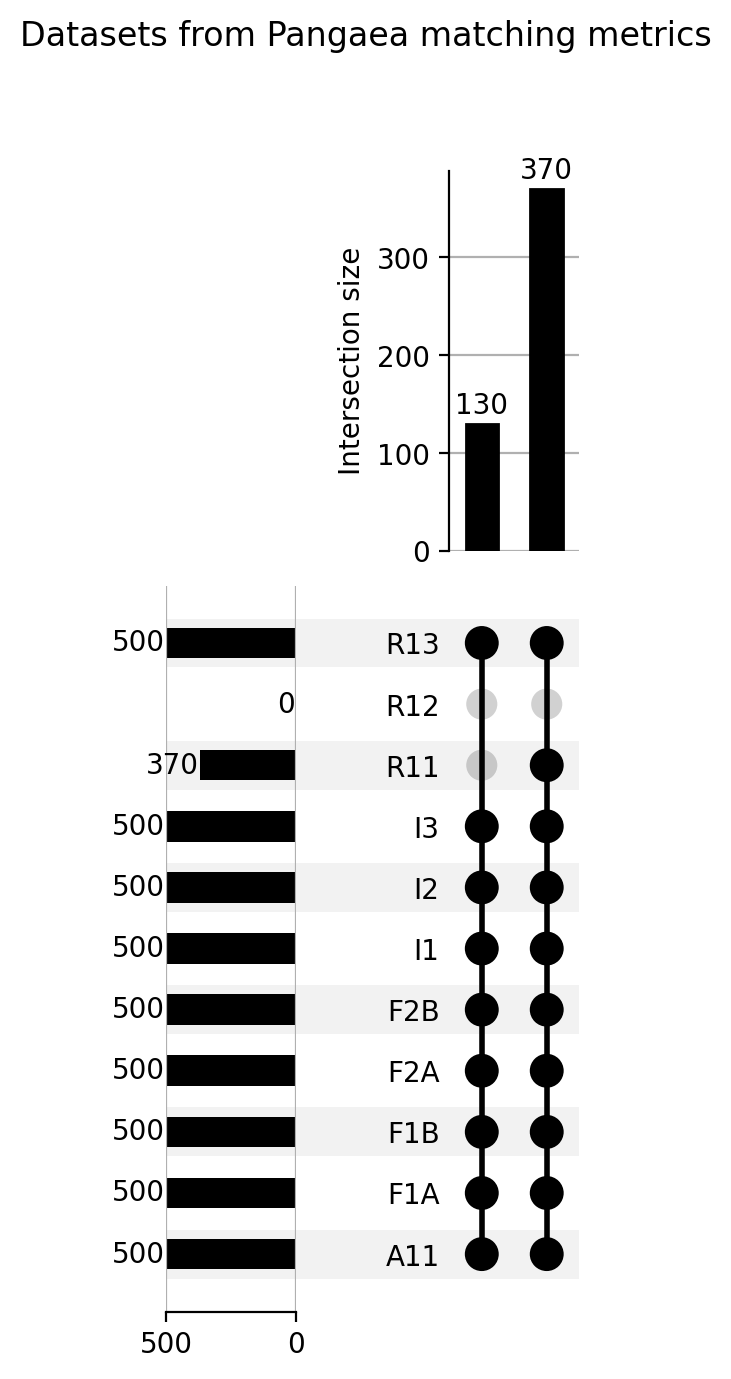

In [18]:
upset = UpSet(df_upset, subset_size='count', show_counts=True, sort_categories_by=None, orientation='horizontal')

#upset.style_subsets(present=["with_exome", "with_images"],
#                    facecolor="red")

params = {'legend.fontsize': 8}
with plt.rc_context(params):
    upset.plot()
plt.suptitle("Datasets from Pangaea matching metrics")
plt.savefig(OUTPUT_DIR + 'pangaea_all_data.png', format="png")
plt.show()